<a href="https://colab.research.google.com/github/Anderche/modeling-digital-assets-with-deep-learning/blob/main/_Dissertation_Anders_Kiss_A_Comparative_Study_of_Multivariate_Macroeconomic_Features_for_Modeling_Digital_Assets_with_Deep_Learning_Algorithms_30Aug2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DISSERTATION
### Dublin Business School
### Master of Science, Artificial Intelligence

### Anders Kiss


02-September-2022

Email: 

anderskiss11@gmail.com

---

### **NOTE** 

The following code implementation can be recreated 
by uploading the provided .csv files under the 
**Data Preparation** subheading, **ESTABLISH - ALL DATASETS TO MODEL** .

### **REFERENCE >> INDICATORS**

### **INSTALLS**

In [ ]:
!pip install yfinance
!pip install investpy
# !pip install cif
!pip install ta
# !pip install bls-data
!pip install fredapi
!pip install cryptocmd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.2 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 6.3 MB/s 
     |████████████████████████████████| 235 kB 34.3 MB/s 
  Created wheel for investpy: filename=investpy-1.0.8-py3-none-any.whl size=4481592 sha256=4c32bb6163a00e31a5211b33533984f309f0daef4b8d33610e8013a20d873f15
  Stored in directory: /root/.cache/pip/wheels/96/a8/a5/0d33c72eaf00b41df7b9dc1e15d2b7c7154b3f1379ed350211
Successfully built investpy
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for ta: filename=ta-0.10.2-py3-none-any.whl size=29104 sha256=

In [ ]:
!pip install dataframe_image

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.5 MB 5.2 MB/s 


### **IMPORTS**

In [ ]:
import pandas as pd
import yfinance as yf
import investpy
# from cif import cif
import urllib.request as urlreq
import json
import pickle
import datetime as dt
from datetime import date, time, datetime, timezone, timedelta
from pandas_datareader import data as pdr
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, YearLocator
plt.style.use('classic')
%matplotlib inline

from fredapi import Fred
from cryptocmd import CmcScraper
from ta.trend import SMAIndicator, EMAIndicator, MACD
from ta.others import DailyLogReturnIndicator
from ta.momentum import RSIIndicator, ROCIndicator

import requests
import seaborn as sns

sns.set_theme()
sns.set_style("whitegrid")
sns.set_context("paper")

import math
from ta import add_all_ta_features
from ta.utils import dropna
from IPython.display import display
from tabulate import tabulate
import dataframe_image as dfi

In [ ]:
# IMPORTS for modelling
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Flatten
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import sklearn.metrics as metrics
from sklearn.metrics import mean_squared_error

In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [ ]:
'''
Federal Reserve Economic Data (FRED); an online database for time series, economic data from U.S., international, 
public, and private sources by the Research Department at the Federal Reserve Bank of St. Louis.
'''

fred_api_key = "a9d6167dd1a412ab3680462118beca97"
fred = Fred(api_key=fred_api_key)

In [ ]:
# SAVE plot files for report
# plt.savefig('Path/FigureName.png')    # As png
# plt.savefig('Path/FigureName.pdf')    # As pdf

### **MOUNT Google Drive** for saving/loading files

In [ ]:
# IMPORT Google Drive API, MOUNT, then AUTHENTICATE
from google.colab import drive, files
drive.mount('/content/drive')

Mounted at /content/drive


### **FUNCTIONS**

#### **FUNCTION >> REMOVE NaN's from dataframe**

In [ ]:
def remove_nan(df_name):
  vals_NaN_indices = df_name.isnull()
  indices_rows_with_NaN = vals_NaN_indices.any(axis=1)
  indices_NaN_rows = df_name[indices_rows_with_NaN]
  count_to_drop = len(indices_NaN_rows) 
  df_name = df_name.drop(df_name.index[range(count_to_drop)],inplace=True)
  return df_name

#### **FUNCTION >> MERGE dataframes**

In [ ]:
# df1 = df1.merge(df2, how="inner", left_index=True, right_index=True)
def merge_dataframes(df_name, df_to_add):
  final_df = df_name.merge(df_to_add, left_index=True, right_index=True, how='outer')
  final_df = final_df.replace('', np.nan).ffill()
  return final_df

#### **FUNCTION >> CONCAT dataframes**

In [ ]:
# def concat_dataframes(df_name, df_to_add):
#   final_df = pd.concat([df_name, df_to_add], axis=1)
#   final_df = final_df.replace('', np.nan).ffill()
#   return final_df

#### **FUNCTION >> join_series**

In [ ]:
def join_series(series, df_name):
  df_new = pd.DataFrame(series)
  final_df = df_new.join(df_name)
  final_df = final_df.replace('', np.nan).ffill()
  return final_df

#### **FUNCTION >> CHECK dataframe**

In [ ]:
def df_sanity_check(df_name): 
  print("SHAPE of df is:\t\t", df_name.shape)   # shape
  print("NaN in df present?\t", df_name.isnull().values.any())    # NaN values present?
  print("NaN count in df:\t",df_name.isnull().sum().sum())        # NaN values count
  print("COLUMNS in df:")         # columns
  for i in df_name.columns:
    print("\t",i)

#### **FUNCTION >> ADD Model's Evalution Results to Evalution DataFrame**

In [ ]:
def add_eval_dict(dict_to_add, df):
  model_list = []
  for val in dict_to_add.values():
    model_list.append(val)

  df.loc[len(df)] = model_list
  return df

### **ESTABLISH DATES**

#### **dates_list**
_(indicators come from different data API's requiring different date formats)_

#### Establish the start and end dates to be used with the various API's.

In [ ]:
# MAKE data list of start and end dates
dates_list = []
dates_01 = { 'start' : '', 'end' : '' }
dates_02 = { 'start' : '', 'end' : '' }
dates_03 = { 'start' : '', 'end' : '' }
dates_04 = { 'start' : '', 'end' : '' }

#### **pkl_str**

In [ ]:
# MAKE data string for saving dataframes when saving as pickle 
now = datetime.now(timezone(dt.timedelta(hours=-4), 'EST'))
print("The date and time at present:\n\t",now)
pkl_str = now.strftime("%d%b%Y_%H%M")
print("The DATE string to append to the end of the pickled file will be:\n\t", pkl_str)

The date and time at present:
	 2022-09-02 06:36:57.300232-04:00
The DATE string to append to the end of the pickled file will be:
	 02Sep2022_0636


In [ ]:
# DELETE >> REFERENCE ONLY
currentDate = dt.date.today()
firstDayOfMonth = dt.date(currentDate.year, currentDate.month, 1)
print(currentDate,firstDayOfMonth)

2022-09-02 2022-09-01


In [ ]:
end_date_01 = dt.datetime.today()
total_days = 365 * 11.5
start_date_01 = end_date_01 - dt.timedelta(days=total_days)
print(start_date_01)
start_date_01 = dt.date(start_date_01.year, start_date_01.month, 1)
print(start_date_01)

2011-03-06 22:36:57.338184
2011-03-01


In [ ]:
def make_dates(years):
  total_days = 365 * years

  end_date_orig = dt.datetime.today()
  start_date_orig = end_date_orig - dt.timedelta(days=total_days)
  start_date_orig = dt.date(start_date_orig.year, start_date_orig.month, 1)

  # CREATE dates_01 with format: 'dd/mm/yyyy'
  start_date_01 = start_date_orig.strftime("%d/%m/%Y")
  end_date_01 = end_date_orig.strftime("%d/%m/%Y")
  dates_01['start'] = start_date_01
  dates_01['end'] = end_date_01
  dates_01
  
  # CREATE dates_02 with format: 'yyyy/mm/dd'
  start_date_02 = start_date_orig.strftime("%Y/%m/%d")
  end_date_02 = end_date_orig.strftime("%Y/%m/%d")
  dates_02['start'] = start_date_02
  dates_02['end'] = end_date_02
  dates_02

  # CREATE dates_03 with format: '%Y-%m-%d'
  start_date_03 = start_date_orig.strftime("%Y-%m-%d")
  end_date_03 = end_date_orig.strftime("%Y-%m-%d")
  dates_03['start'] = start_date_03
  dates_03['end'] = end_date_03
  dates_03

  # CREATE dates_04 with format: '%d-%m-%Y'
  start_date_04 = start_date_orig.strftime("%d-%m-%Y")
  end_date_04 = end_date_orig.strftime("%d-%m-%Y")
  dates_04['start'] = start_date_04
  dates_04['end'] = end_date_04
  dates_04

  dates_list.append(dates_01)
  dates_list.append(dates_02)
  dates_list.append(dates_03)
  dates_list.append(dates_04)
  return dates_list
  

In [ ]:
make_dates(11)

[{'start': '01/09/2011', 'end': '02/09/2022'},
 {'start': '2011/09/01', 'end': '2022/09/02'},
 {'start': '2011-09-01', 'end': '2022-09-02'},
 {'start': '01-09-2011', 'end': '02-09-2022'}]

In [ ]:
dates_list

[{'start': '01/09/2011', 'end': '02/09/2022'},
 {'start': '2011/09/01', 'end': '2022/09/02'},
 {'start': '2011-09-01', 'end': '2022-09-02'},
 {'start': '01-09-2011', 'end': '02-09-2022'}]

In [ ]:
print(dates_list[0]['start'])
print(dates_list[0]['end'])

01/09/2011
02/09/2022


In [ ]:
print(type(dates_list[1]['start']))

<class 'str'>


In [ ]:
now = datetime.now(timezone(dt.timedelta(hours=-4), 'EST'))
print("now:\t", now)
date_time_str = now.strftime("%d%b%Y_%H%M")
print("date and time:\t", date_time_str)

now:	 2022-09-02 06:36:57.445924-04:00
date and time:	 02Sep2022_0636


# **CRISP-DM**

## The **CRISP-DM** process for modeling data will be implemented for this research. The **six phases** include:

- ### **BUSINESS UNDERSTANDING**
- ### **DATA UNDERSTANDING**
- ### **DATA PREPARATION**
- ### **MODELING**
- ### **EVALLUATION**
- ### **DEPLOYMENT**



# **BUSINESS UNDERSTANDING**

Modeling financial assets like equities (stocks) and bonds is commonplace in the financial centers of the world given that they are the basis of most people’s investment plan, such as a retirement account or pension plan. Since its creation in 2008, Bitcoin has steadily grown in adoption to a total market capitalization of over $382 billion as of August 2022 due in large part to its highly inelastic and limited supply, and decentralized characteristics. By utilizing deep learning RNN’s like LSTM and GRU’s, investors can start to understand the interplay of independent variables upon Bitcoin’s price movement over time and make more informed investment decisions.


# **DATA UNDERSTANDING**

#### The following API Data sources were used to gather the input and target features:


```
| Feature / Indicator                                                       | Category             | API / Python library                                                                                               |
| ------------------------------------------------------------------------- | -------------------- | ------------------------------------------------------------------------------------------------------------------ |
| Bitcoin Closing Price<br>(target variable)                                | Bitcoin Indicator    | Investpy                                                                                                           |
| Bitcoin High Price                                                        | Bitcoin Indicator    | Investpy                                                                                                           |
| Bitcoin log return                                                        | Bitcoin Indicator    | ta (TA-Lib)                                                                                                        |
| Bitcoin Low Price                                                         | Bitcoin Indicator    | Investpy                                                                                                           |
| Bitcoin Open Price                                                        | Bitcoin Indicator    | Investpy                                                                                                           |
| Bitcoin RSI                                                               | Bitcoin Indicator    | ta (TA-Lib)                                                                                                        |
| Bitcoin Volume                                                            | Bitcoin Indicator    | Investpy                                                                                                           |
| Case-Shiller Home Price Index                                             | Bonds & Indices      | [https://fred.stlouisfed.org/series/CSUSHPISA](https://fred.stlouisfed.org/series/CSUSHPISA)                       |
| Consumer Discretionary Select Sector SPDR                                 | Bonds & Indices      | Investpy                                                                                                           |
| CPI                                                                       | Bonds & Indices      | [https://fred.stlouisfed.org/series/CORESTICKM159SFRBATL](https://fred.stlouisfed.org/series/CORESTICKM159SFRBATL) |
| DE02Y                                                                     | Bonds & Indices      | Investpy                                                                                                           |
| DXY                                                                       | Bonds & Indices      | Investpy                                                                                                           |
| Housing permits<br>(U.S. total unit permits)                              | Bonds & Indices      | [https://fred.stlouisfed.org/series/permit](https://fred.stlouisfed.org/series/permit)                             |
| IT02Y                                                                     | Bonds & Indices      | Investpy                                                                                                           |
| JP02Y                                                                     | Bonds & Indices      | Investpy                                                                                                           |
| NDX<br><br>(NASDAQ-100 Index)                                             | Bonds & Indices      | Investpy                                                                                                           |
| PPI                                                                       | Bonds & Indices      | [https://fred.stlouisfed.org/series/PPIACO](https://fred.stlouisfed.org/series/PPIACO)                             |
| SPX<br><br>(S&P-500 Index)                                                | Bonds & Indices      | Investpy                                                                                                           |
| US02Y                                                                     | Bonds & Indices      | Investpy                                                                                                           |
| US02Y - US10Y                                                             | Bonds & Indices      | [https://fred.stlouisfed.org/series/T10Y2Y](https://fred.stlouisfed.org/series/T10Y2Y)                             |
| US10Y                                                                     | Bonds & Indices      | Investpy                                                                                                           |
| Copper                                                                    | Commodity            | Investpy                                                                                                           |
| Crude Oil WTI                                                             | Commodity            | Investpy                                                                                                           |
| Gold                                                                      | Commodity            | Investpy                                                                                                           |
| Lumber                                                                    | Commodity            | Investpy                                                                                                           |
| Nickel                                                                    | Commodity            | Investpy                                                                                                           |
| U.S. Wheat                                                                | Commodity            | Investpy                                                                                                           |
| Central Bank Liquidity Swaps                                              | Macroeconomic Metric | [https://fred.stlouisfed.org/series/SWPT](https://fred.stlouisfed.org/series/SWPT)                                 |
| Consumer Loans                                                            | Macroeconomic Metric | [https://fred.stlouisfed.org/series/CCLACBW027SBOG](https://fred.stlouisfed.org/series/CCLACBW027SBOG)             |
| Inventories to Sales                                                      | Macroeconomic Metric | [https://fred.stlouisfed.org/series/MNFCTRIRSA](https://fred.stlouisfed.org/series/MNFCTRIRSA)                     |
| U.S. Fed Funds rate                                                       | Macroeconomic Metric | [https://fred.stlouisfed.org/series/fedfunds](https://fred.stlouisfed.org/series/fedfunds)                         |
| U.S. Federal Debt: Total Public Debt as Percent of Gross Domestic Product | Macroeconomic Metric | [https://fred.stlouisfed.org/series/GFDEGDQ188S](https://fred.stlouisfed.org/series/GFDEGDQ188S)                   |
| Unemployment Rate                                                         | Macroeconomic Metric | [https://fred.stlouisfed.org/series/unrate](https://fred.stlouisfed.org/series/unrate)                             |
| University of Michigan, Index of Consumer Sentiment                       | Macroeconomic Metric | [https://fred.stlouisfed.org/series/umcsent](https://fred.stlouisfed.org/series/umcsent)                           |
| Volatility Index (VIX)                                                    | Macroeconomic Metric | Investpy                                                                                                           |
| Natural Gas                                                               | Commodity            | Investpy                                                                                                           |
```

# **DATA PREPARATION**

## **BTC Price and Technical Indicators**

### **TARGET VARIABLE >> BTC Closing Price (target) & BTC Volume >> SOURCE: Investpy**

In [ ]:
dates_list
print(dates_list[0]['start'])

01/09/2011


In [ ]:
btc_df = investpy.crypto.get_crypto_historical_data(crypto='bitcoin',
                                                            from_date=dates_list[0]['start'],
                                                            to_date=dates_list[0]['end'],
                                                            as_json=False,
                                                            order='ascending',
                                                            interval='Daily')

In [ ]:
# VERIFY index is of datetime object
# print(btc_df_v2.index.inferred_type == "datetime64","\n")
btc_df.head(3)

Open  High  Low  Close  Volume Currency
Date                                               
2011-09-01   8.2   8.4  8.1    8.2   11904      USD
2011-09-02   8.2   8.7  8.2    8.6   16815      USD
2011-09-03   8.6   8.7  8.4    8.5    6945      USD

In [ ]:
# DROP all columns, except for 'Close'
btc_df.drop(['Currency'], axis = 1, inplace = True)

In [ ]:
btc_df.tail(3)

Open     High      Low    Close  Volume
Date                                                  
2022-08-31  19793.4  20469.1  19793.4  20043.9  318166
2022-09-01  20049.9  20202.7  19584.4  20126.1  275079
2022-09-02  20131.6  20273.3  19960.6  20073.9  253410

In [ ]:
btc_df.rename(columns={'Close':'BTC', 'Volume':'BTC_vol'},inplace=True, errors='raise')

In [ ]:
btc_df.head(3)

Open  High  Low  BTC  BTC_vol
Date                                     
2011-09-01   8.2   8.4  8.1  8.2    11904
2011-09-02   8.2   8.7  8.2  8.6    16815
2011-09-03   8.6   8.7  8.4  8.5     6945

In [ ]:
# col = df.pop("Mid")
# df.insert(0, col.name, col)
col = btc_df.pop('BTC')
btc_df.insert(0, col.name, col)
btc_df.head(3)

BTC  Open  High  Low  BTC_vol
Date                                     
2011-09-01  8.2   8.2   8.4  8.1    11904
2011-09-02  8.6   8.2   8.7  8.2    16815
2011-09-03  8.5   8.6   8.7  8.4     6945

### **BTC Relative Strength Index (RSI)**

In [ ]:
# 20-week Simple Moving Average (SMA); 20 wk == 140 days
btc_rsi = RSIIndicator(close = btc_df['BTC'], window=14, fillna=False)
btc_df['BTC_RSI'] = btc_rsi.rsi()
btc_df['BTC_RSI'].tail()

Date
2022-08-29    37.165070
2022-08-30    34.361302
2022-08-31    36.920659
2022-09-01    37.775327
2022-09-02    37.428513
Name: BTC_RSI, dtype: float64

In [ ]:
btc_df.tail(3)

BTC     Open     High      Low  BTC_vol    BTC_RSI
Date                                                              
2022-08-31  20043.9  19793.4  20469.1  19793.4   318166  36.920659
2022-09-01  20126.1  20049.9  20202.7  19584.4   275079  37.775327
2022-09-02  20073.9  20131.6  20273.3  19960.6   253410  37.428513

Text(0, 0.5, 'Value')

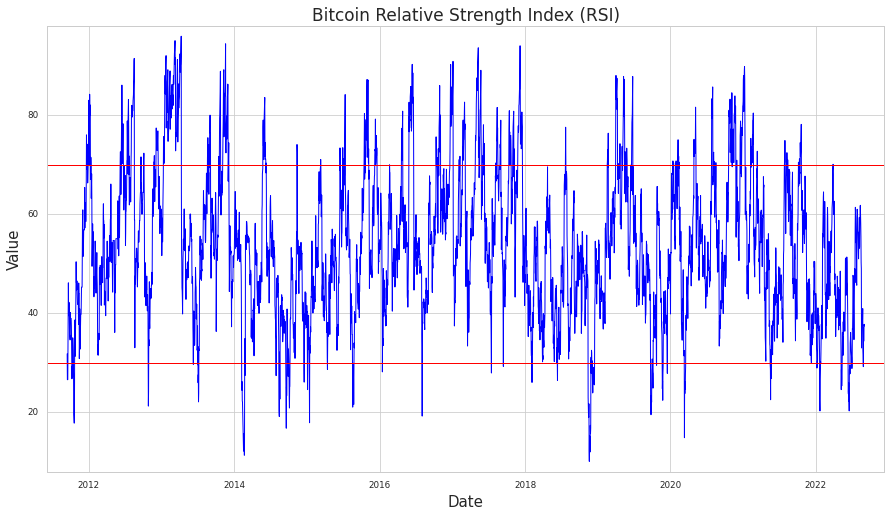

In [ ]:
# SEABORN GRAPH
plt.figure(figsize = (15,8))
graph = sns.lineplot(data=btc_df['BTC_RSI'],color="blue",lw=1)
graph.axhline(y=70,color="red",lw=1)
graph.axhline(y=30,color="red",lw=1)
graph.margins(0.025)
graph.set_title("Bitcoin Relative Strength Index (RSI)", fontsize = 17)
graph.set_xlabel("Date", fontsize = 15)
graph.set_ylabel("Value", fontsize = 15)

In [ ]:
# btc_df.plot()

### **BTC Log Return**

In [ ]:
btc_log = DailyLogReturnIndicator(close=btc_df['BTC'],fillna=False)
btc_df['BTC_log'] = btc_log.daily_log_return()
btc_df['BTC_log'].tail()

Date
2022-08-29    3.742845
2022-08-30   -2.510584
2022-08-31    1.261674
2022-09-01    0.409261
2022-09-02   -0.259702
Name: BTC_log, dtype: float64

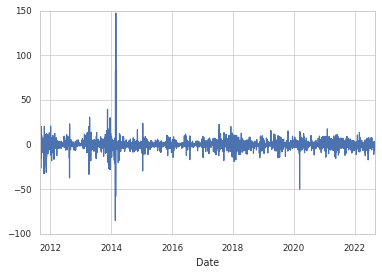

In [ ]:
btc_df['BTC_log'].plot()

In [ ]:
# ENSURE target variable is on the far right for modelling purposes
btc_df.tail(3)

BTC     Open     High      Low  BTC_vol    BTC_RSI   BTC_log
Date                                                                        
2022-08-31  20043.9  19793.4  20469.1  19793.4   318166  36.920659  1.261674
2022-09-01  20126.1  20049.9  20202.7  19584.4   275079  37.775327  0.409261
2022-09-02  20073.9  20131.6  20273.3  19960.6   253410  37.428513 -0.259702

In [ ]:
btc_df.head(3)

BTC  Open  High  Low  BTC_vol  BTC_RSI   BTC_log
Date                                                        
2011-09-01  8.2   8.2   8.4  8.1    11904      NaN       NaN
2011-09-02  8.6   8.2   8.7  8.2    16815      NaN  4.762805
2011-09-03  8.5   8.6   8.7  8.4     6945      NaN -1.169604

In [ ]:
print(type(btc_df))
print(type(btc_df['BTC']))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


### **FIND NaN values**

In [ ]:
df_sanity_check(btc_df)

SHAPE of df is:		 (4020, 7)
NaN in df present?	 True
NaN count in df:	 14
COLUMNS in df:
	 BTC
	 Open
	 High
	 Low
	 BTC_vol
	 BTC_RSI
	 BTC_log


In [ ]:
remove_nan(btc_df)
df_sanity_check(btc_df)

SHAPE of df is:		 (4007, 7)
NaN in df present?	 False
NaN count in df:	 0
COLUMNS in df:
	 BTC
	 Open
	 High
	 Low
	 BTC_vol
	 BTC_RSI
	 BTC_log


In [ ]:
btc_df.head(3)

BTC  Open  High  Low  BTC_vol    BTC_RSI    BTC_log
Date                                                           
2011-09-14  5.6   5.8   5.8  5.3    43768  31.804028  -3.509132
2011-09-15  4.8   5.6   5.6  4.4    86221  26.586215 -15.415068
2011-09-16  4.8   4.8   5.0  4.6    31651  26.586215   0.000000

### **PKL >> Pickle BTC DataFrame and store as .pkl file**

In [ ]:
# Pickle DataFrame to file
btc_df.to_pickle("/content/drive/MyDrive/___DBS_September 2021_anderskiss11/__DISSERTATION_DBS_APPLIED RESEARCH PAPER/__IMAGES & FILES_Dissertation/btc_df_{}.pkl".format(pkl_str))

In [ ]:
# btc_df = pd.read_pickle("/content/drive/MyDrive/___DBS_September 2021_anderskiss11/__DISSERTATION_DBS_APPLIED RESEARCH PAPER/__IMAGES & FILES_Dissertation/btc_df_v2_29Aug2022_0818.pkl.pkl")
print(len(btc_df))
btc_df.head(3)

4007


BTC  Open  High  Low  BTC_vol    BTC_RSI    BTC_log
Date                                                           
2011-09-14  5.6   5.8   5.8  5.3    43768  31.804028  -3.509132
2011-09-15  4.8   5.6   5.6  4.4    86221  26.586215 -15.415068
2011-09-16  4.8   4.8   5.0  4.6    31651  26.586215   0.000000

In [ ]:
btc_df.index.inferred_type == "datetime64"

True

### **PLOT; BTC Price (log scale)**

In [ ]:
# lastconnection = datetime.strptime("21/12/2008", "%d/%m/%Y").strftime('%Y-%m-%d')
# val = btc_df['BTC'][-1]
# btc_df.index[-1].strftime('%Y-%m-%d')

In [ ]:
# from_date = btc_df.index[0].strftime('%Y-%m-%d')
from_date = btc_df.index[0].strftime('%d-%b-%Y')
to_date = btc_df.index[-1].strftime('%d-%b-%Y')

print(from_date)
print(to_date)

14-Sep-2011
02-Sep-2022


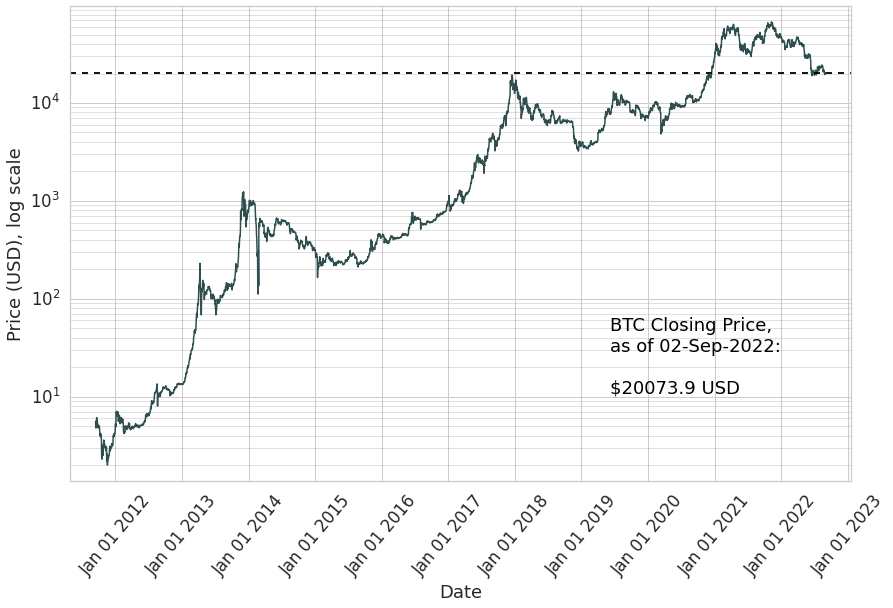

In [ ]:
# PLOT last five years of data

# CREATE mask for last five years
# mask = (btc_df.index > '2017-01-01') & (btc_df.index <= '2022-08-06')
# btc_last_five_yr = btc_df.loc[mask]
# btc_last_five_yr['Close'].plot()

# PLOT
plt.figure(figsize = (14,8.5))
# plt.figure(figsize = (8.5,6.3))
sns.set(font_scale = 1.5)
sns.set_style("whitegrid")
# graph = sns.lineplot(data = btc_last_five_yr['BTC'] , lw=1.8 , color = 'blue') 
graph = sns.lineplot(data = btc_df['BTC'],lw=1.5,color='darkslategrey') 
graph.margins(0.035)
# graph.set_title("Bitcoin Price ({} to {})".format(from_date,to_date), fontsize = 21, y=1.05)
graph.set_xlabel("Date", fontsize = 18)
graph.set_ylabel("Price (USD), log scale", fontsize = 18)
graph.tick_params(axis='x', rotation=50)
yloc = YearLocator()
mloc = MonthLocator()
graph.axhline(y = btc_df['BTC'][-1], color='black',ls='--',lw=1.9, alpha=0.95)
graph.text(dt.date(2019,6,9), 11, "BTC Closing Price,\nas of {}:\n\n${} USD".format(to_date, btc_df['BTC'][-1]),color='black')
graph.xaxis.set_major_locator(yloc) # GRIDLINES; MAJOR 
graph.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.3) # GRIDLINES; MINOR
plt.yscale('log')
# ADD line to save to google drive
plt.savefig('/content/drive/MyDrive/___DBS_September 2021_anderskiss11/__DISSERTATION_DBS_APPLIED RESEARCH PAPER/__IMAGES & FILES_Dissertation/BTC_LOG_SCALE_{}.png'.format(pkl_str),bbox_inches='tight',dpi=120)
# plt.savefig('BTC_LOG_SCALE_{}.png'.format(pkl_str), bbox_inches='tight', dpi=120)
plt.show()

### **PLOT; Bitcoin subplot**

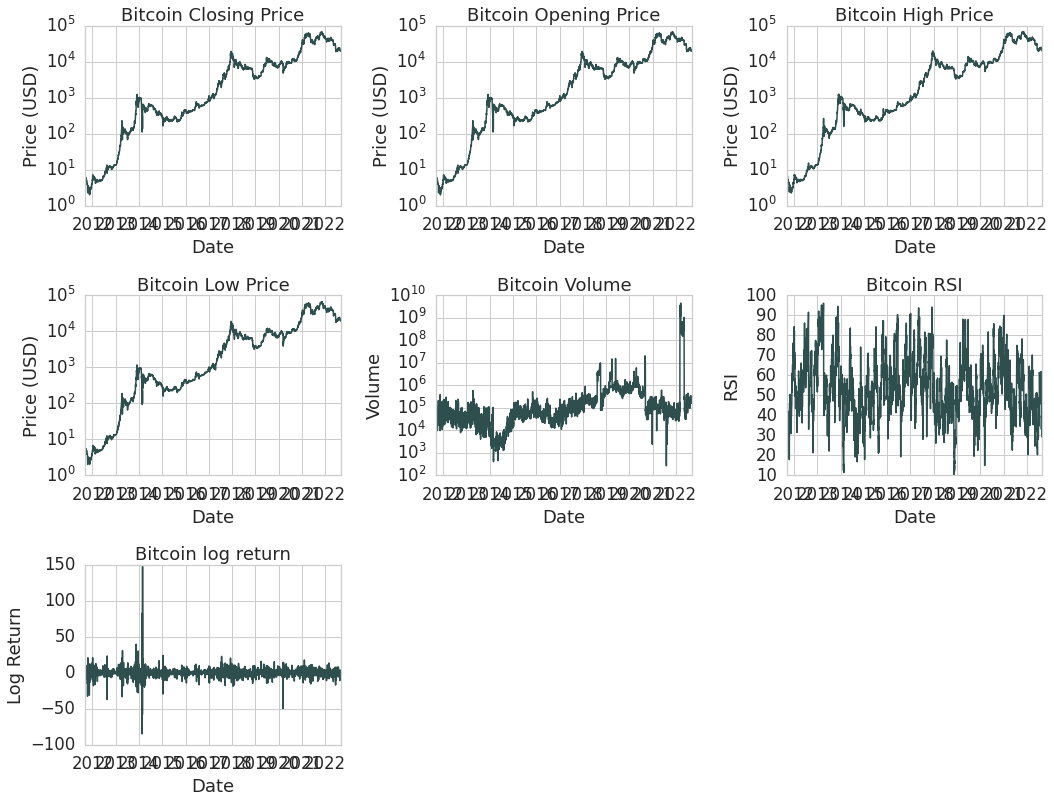

In [ ]:
fig, axes = plt.subplots(3,3, figsize=(15,11.5))
# fig.suptitle('Features: Bitcoin Price & Technical Indicators (as of {})'.format(now.strftime("%d-%b-%Y")), size=19, weight='bold', y=1.07) 

sns.lineplot(ax=axes[0, 0], color='darkslategrey', data=btc_df['BTC'], x=btc_df.index, y=btc_df['BTC']).set(ylabel='Price (USD)', title='Bitcoin Closing Price', yscale='log')
sns.lineplot(ax=axes[0, 1], color='darkslategrey', data=btc_df['Open'], x=btc_df.index, y=btc_df['Open']).set(ylabel='Price (USD)', title='Bitcoin Opening Price', yscale='log')
sns.lineplot(ax=axes[0, 2], color='darkslategrey', data=btc_df['High'], x=btc_df.index, y=btc_df['High']).set(ylabel='Price (USD)', title='Bitcoin High Price', yscale='log')

sns.lineplot(ax=axes[1, 0], color='darkslategrey', data=btc_df['Low'], x=btc_df.index, y=btc_df['Low']).set(ylabel='Price (USD)', title='Bitcoin Low Price', yscale='log')
sns.lineplot(ax=axes[1, 1], color='darkslategrey', data=btc_df['BTC_vol'], x=btc_df.index, y=btc_df['BTC_vol']).set(ylabel='Volume', title='Bitcoin Volume', yscale='log')
sns.lineplot(ax=axes[1, 2], color='darkslategrey', data=btc_df['BTC_RSI'], x=btc_df.index, y=btc_df['BTC_RSI']).set(ylabel='RSI', title='Bitcoin RSI')

sns.lineplot(ax=axes[2, 0], color='darkslategrey', data=btc_df['BTC_log'], x=btc_df.index, y=btc_df['BTC_log']).set(ylabel='Log Return', title='Bitcoin log return')
fig.delaxes(ax= axes[2,1])
fig.delaxes(ax= axes[2,2])

fig.tight_layout()
# ADD line to save to google drive
fig.savefig('/content/drive/MyDrive/___DBS_September 2021_anderskiss11/__DISSERTATION_DBS_APPLIED RESEARCH PAPER/__IMAGES & FILES_Dissertation/BTC_subplots_v2_{}.png'.format(pkl_str),bbox_inches='tight',dpi=120)
# fig.savefig('BTC_subplots.png', bbox_inches='tight', dpi=120)
plt.show()

### **PLOT; Correlation Matrix - Bitcoin Price & Technicals**

In [ ]:
# OPTION 01: Correlation Matrix (method='Pearson' by default)
# corr_matrix = btc_df.corr()
# corr_matrix.style.background_gradient(cmap='coolwarm')

In [ ]:
print(pkl_str)
print(now.strftime("%d-%b-%Y"))

02Sep2022_0636
02-Sep-2022


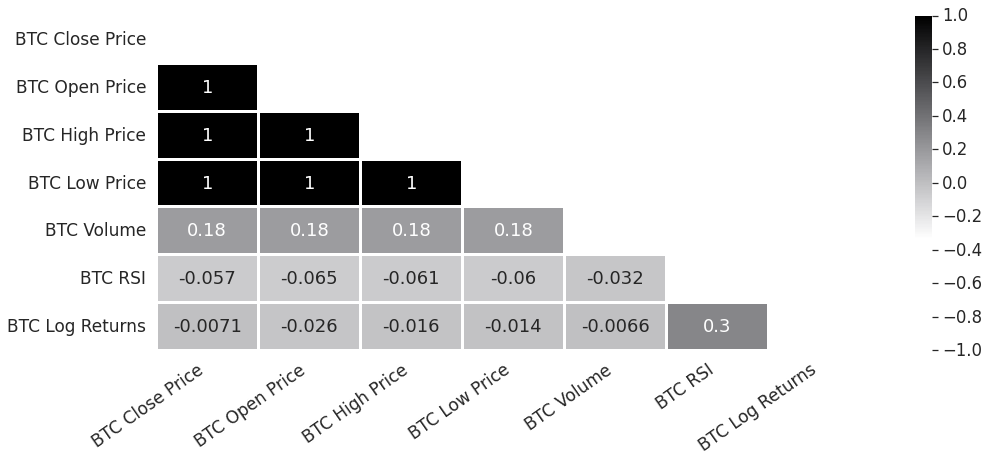

In [ ]:
# Correlation Matrix - Bitcoin and Technicals
plt.figure(figsize=(16, 6))

# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.

y_cols = ['BTC Close Price','BTC Open Price','BTC High Price','BTC Low Price','BTC Volume','BTC RSI','BTC Log Returns']
x_cols = ['BTC Close Price','BTC Open Price','BTC High Price','BTC Low Price','BTC Volume','BTC RSI','BTC Log Returns']

corr = btc_df.corr()

# ESTABLISH mask for upper half of matrix only
matrix = np.triu(corr)
cmap = sns.cubehelix_palette(50, hue=0.05, rot=0, light=1.5, dark=0, as_cmap=True)
hm = sns.heatmap(corr,vmin=-1,vmax=1,annot=True,linewidth=2,mask=matrix,cmap=cmap,xticklabels=x_cols,yticklabels=y_cols)
# sns.lineplot(ax=axes[1, 0], color='darkslategrey', data=btc_df['BTC_50D_SMA'], x=btc_df.index, y=btc_df['BTC_50D_SMA']).set(ylabel='Price (USD)', title='Bitcoin Price (50 Day SMA)', yscale='log')

# hm.set_title('Correlation Matrix - Bitcoin & Bitcoin Technical Indicators (as of {})'.format(now.strftime("%d-%b-%Y")), fontsize=20, fontdict={'fontsize':12}, pad=12)
hm.set_xticklabels(hm.get_xticklabels(),fontsize=17,rotation=35, horizontalalignment='right')
hm.set_yticklabels(hm.get_ymajorticklabels(),fontsize=17,rotation=0)
# sns.set(font_scale=1.4)

fig.tight_layout()
fig = hm.get_figure()
# fig.savefig('/content/drive/MyDrive/___DBS_September 2021_anderskiss11/__DISSERTATION_DBS_APPLIED RESEARCH PAPER/__IMAGES & FILES_Dissertation/BTC_corr_matrix_{}.png'.format(pkl_str),bbox_inches='tight',dpi=120)
# hm.savefig('BTC_corr_matrix_{}.png'.format(pkl_str),bbox_inches='tight',dpi=120)

## **BONDS & INDICES**

### **BONDS; United States 2 year Bond Yield**

In [ ]:
dates_list[0]['start']

'01/09/2011'

In [ ]:
US02Y = investpy.get_bond_historical_data(bond='U.S. 2Y', from_date = dates_list[0]['start'], to_date = dates_list[0]['end'])
US02Y.tail(3)

Open    High     Low   Close
Date                                      
2022-08-31  3.4480  3.5030  3.4250  3.4950
2022-09-01  3.5032  3.5466  3.4707  3.5117
2022-09-02  3.5117  3.5158  3.4902  3.5026

In [ ]:
US02Y.drop(['Open','High','Low'], axis = 1, inplace = True)
US02Y.rename(columns={'Close':'US02Y'},inplace=True, errors='raise')
US02Y.tail(3)

US02Y
Date              
2022-08-31  3.4950
2022-09-01  3.5117
2022-09-02  3.5026

In [ ]:
len(US02Y)

3357

In [ ]:
type(US02Y.index)

pandas.core.indexes.datetimes.DatetimeIndex

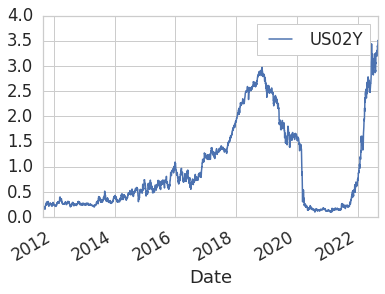

In [ ]:
US02Y.plot()

In [ ]:
print(dates_list[2])
index = pd.date_range(start=dates_list[0]['start'], end=dates_list[0]['end'], freq='D')
blank_df = pd.DataFrame(index=index)
blank_df.head(3)

{'start': '2011-09-01', 'end': '2022-09-02'}


Empty DataFrame
Columns: []
Index: [2011-01-09 00:00:00, 2011-01-10 00:00:00, 2011-01-11 00:00:00]

In [ ]:
bonds_indices_df = US02Y.copy(deep=True)
bonds_indices_df.tail(3)

US02Y
Date              
2022-08-31  3.4950
2022-09-01  3.5117
2022-09-02  3.5026

In [ ]:
bonds_indices_df = merge_dataframes(blank_df,bonds_indices_df)
bonds_indices_df.head(3)

US02Y
2011-01-09    NaN
2011-01-10    NaN
2011-01-11    NaN

### **BONDS; United States 10 year Bond Yield**

In [ ]:
US10Y = investpy.get_bond_historical_data(bond='U.S. 10Y', from_date = dates_list[0]['start'], to_date = dates_list[0]['end'])
US10Y.tail(3)

Open   High    Low  Close
Date                                  
2022-08-31  3.108  3.198  3.091  3.196
2022-09-01  3.198  3.295  3.185  3.263
2022-09-02  3.257  3.269  3.235  3.263

In [ ]:
US10Y.drop(['Open','High','Low'], axis = 1, inplace = True)
US10Y.rename(columns={'Close':'US10Y'},inplace=True, errors='raise')
US10Y.tail(3)

US10Y
Date             
2022-08-31  3.196
2022-09-01  3.263
2022-09-02  3.263

In [ ]:
len(US10Y)

3288

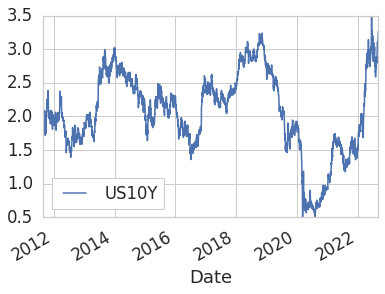

In [ ]:
US10Y.plot()

In [ ]:
bonds_indices_df = merge_dataframes(bonds_indices_df, US10Y)
bonds_indices_df.tail(3)

US02Y  US10Y
2022-08-31  3.4950  3.196
2022-09-01  3.5117  3.263
2022-09-02  3.5026  3.263

In [ ]:
bonds_indices_df.head(3)

US02Y  US10Y
2011-01-09    NaN    NaN
2011-01-10    NaN    NaN
2011-01-11    NaN    NaN

### **BOND SPREAD; 10-Year Treasury Constant Maturity minus 2-Year Treasury Constant Maturity**


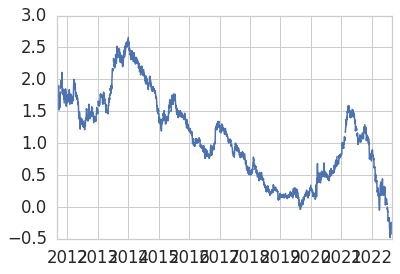

In [ ]:
us_spread = fred.get_series('T10Y2Y', observation_start=dates_list[2]['start'], observation_end=dates_list[2]['end'])
us_spread.plot()

In [ ]:
len(us_spread)

2871

In [ ]:
print(type(us_spread),'\n')
us_spread.tail(3)

<class 'pandas.core.series.Series'> 



2022-08-30   -0.35
2022-08-31   -0.30
2022-09-01   -0.25
dtype: float64

In [ ]:
# CONVERT Series to a DataFrame
us_spread = pd.DataFrame(us_spread, columns=['US10Y2Y'])
us_spread.head(3)

US10Y2Y
2011-09-01     1.96
2011-09-02     1.82
2011-09-05      NaN

In [ ]:
bonds_indices_df = merge_dataframes(bonds_indices_df, us_spread)
bonds_indices_df.head(3)

US02Y  US10Y  US10Y2Y
2011-01-09    NaN    NaN      NaN
2011-01-10    NaN    NaN      NaN
2011-01-11    NaN    NaN      NaN

Text(0, 0.5, 'Percent')

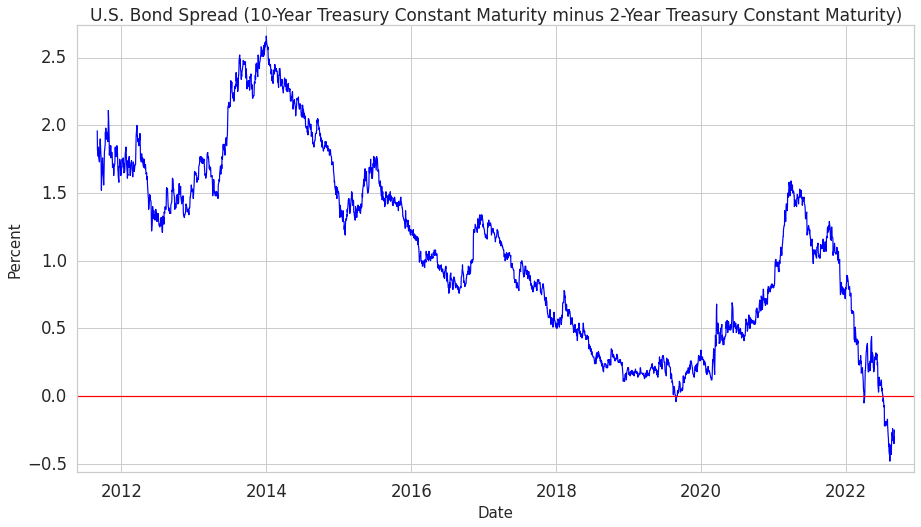

In [ ]:
plt.figure(figsize = (15,8))
graph = sns.lineplot(data = us_spread['US10Y2Y'],color="blue",lw=1.2)
graph.axhline(y=0.0,color="red",lw=1.2)
graph.margins(0.025)

# graph.set_title("The U.S. Bond Spread (10-Year less the 2-Year Yield)", fontsize = 20)
graph.set_title("U.S. Bond Spread (10-Year Treasury Constant Maturity minus 2-Year Treasury Constant Maturity)", fontsize = 17)
graph.set_xlabel("Date", fontsize = 15)
graph.set_ylabel("Percent", fontsize = 15)

### **BOND; Japan 2-Year**

In [ ]:
JP02Y = investpy.get_bond_historical_data(bond='Japan 2Y', from_date = dates_list[0]['start'], to_date = dates_list[0]['end'])

In [ ]:
print(type(JP02Y))

<class 'pandas.core.frame.DataFrame'>


In [ ]:
JP02Y.tail(3)

Open   High    Low  Close
Date                                  
2022-08-31 -0.086 -0.084 -0.089 -0.084
2022-09-01 -0.083 -0.075 -0.083 -0.076
2022-09-02 -0.076 -0.075 -0.083 -0.083

In [ ]:
JP02Y.drop(['Open','High','Low'], axis = 1, inplace = True)
JP02Y.rename(columns={'Close':'JP02Y'},inplace=True, errors='raise')
JP02Y.tail(3)

JP02Y
Date             
2022-08-31 -0.084
2022-09-01 -0.076
2022-09-02 -0.083

Text(0, 0.5, 'Percent')

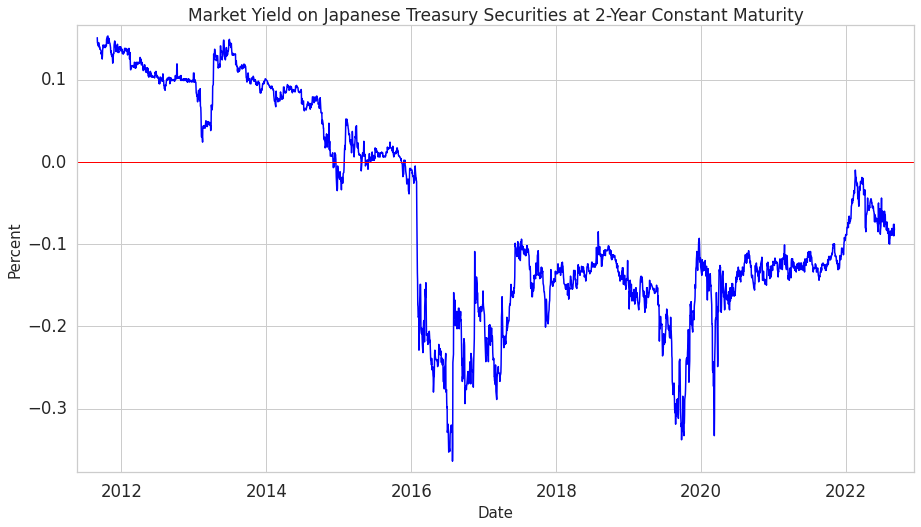

In [ ]:
plt.figure(figsize = (15,8))
graph = sns.lineplot(data = JP02Y['JP02Y'], color='blue')
graph.axhline(y=0.0,color="red",lw=1)
graph.margins(0.025)
graph.set_title("Market Yield on Japanese Treasury Securities at 2-Year Constant Maturity", fontsize = 17)
graph.set_xlabel("Date", fontsize = 15)
graph.set_ylabel("Percent", fontsize = 15)

In [ ]:
bonds_indices_df = merge_dataframes(bonds_indices_df, JP02Y)
bonds_indices_df.head(3)

US02Y  US10Y  US10Y2Y  JP02Y
2011-01-09    NaN    NaN      NaN    NaN
2011-01-10    NaN    NaN      NaN    NaN
2011-01-11    NaN    NaN      NaN    NaN

In [ ]:
# BONDS_df_dictionary.update({'JP02Y' : JP02Y})
# BONDS_df_dictionary.get('JP02Y').tail(3)

### **BOND; Italy 2-Year**

In [ ]:
IT02Y = investpy.get_bond_historical_data(bond='Italy 2Y', from_date = dates_list[0]['start'], to_date = dates_list[0]['end'])

In [ ]:
print(type(IT02Y))

<class 'pandas.core.frame.DataFrame'>


In [ ]:
IT02Y.tail(3)

Open   High    Low  Close
Date                                  
2022-08-31  2.083  2.302  2.061  2.203
2022-09-01  2.217  2.303  2.197  2.256
2022-09-02  2.255  2.275  2.214  2.263

In [ ]:
IT02Y.drop(['Open','High','Low'], axis = 1, inplace = True)
IT02Y.rename(columns={'Close':'IT02Y'},inplace=True, errors='raise')
IT02Y.tail(3)

IT02Y
Date             
2022-08-31  2.203
2022-09-01  2.256
2022-09-02  2.263

Text(0, 0.5, 'Percent')

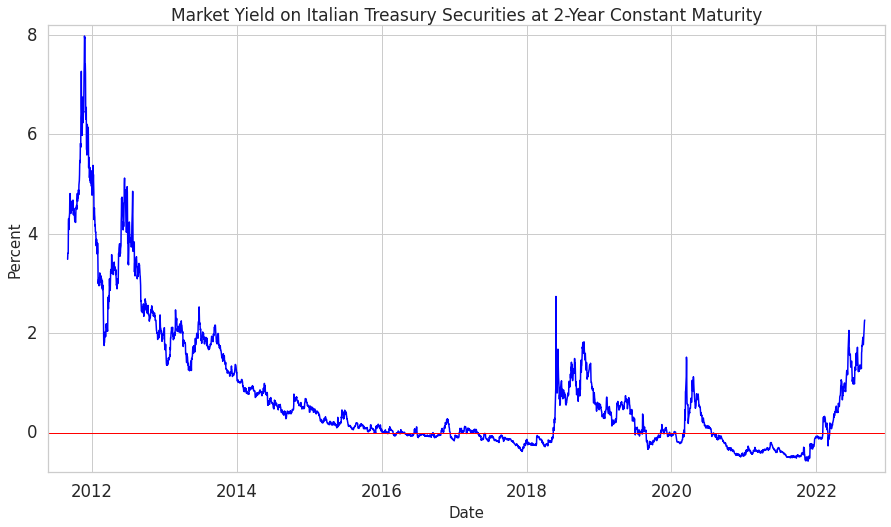

In [ ]:
plt.figure(figsize = (15,8))
graph = sns.lineplot(data = IT02Y['IT02Y'],color="blue")
graph.axhline(y=0.0,color="red",lw=1)
graph.margins(0.025)
graph.set_title("Market Yield on Italian Treasury Securities at 2-Year Constant Maturity", fontsize = 17)
graph.set_xlabel("Date", fontsize = 15)
graph.set_ylabel("Percent", fontsize = 15)

In [ ]:
bonds_indices_df = merge_dataframes(bonds_indices_df, IT02Y)
bonds_indices_df.head(3)

US02Y  US10Y  US10Y2Y  JP02Y  IT02Y
2011-01-09    NaN    NaN      NaN    NaN    NaN
2011-01-10    NaN    NaN      NaN    NaN    NaN
2011-01-11    NaN    NaN      NaN    NaN    NaN

In [ ]:
# BONDS_df_dictionary.update({'IT02Y' : IT02Y})
# BONDS_df_dictionary.get('IT02Y').tail(3)

### **BOND; German 2-Year**

In [ ]:
DE02Y = investpy.get_bond_historical_data(bond='Germany 2Y', from_date = dates_list[0]['start'], to_date = dates_list[0]['end'])

In [ ]:
print(type(DE02Y))

<class 'pandas.core.frame.DataFrame'>


In [ ]:
DE02Y.tail(3)

Open   High    Low  Close
Date                                  
2022-08-31  1.152  1.238  1.097  1.198
2022-09-01  1.195  1.275  1.157  1.190
2022-09-02  1.166  1.207  1.153  1.184

In [ ]:
DE02Y.drop(['Open','High','Low'], axis = 1, inplace = True)
DE02Y.rename(columns={'Close':'DE02Y'},inplace=True, errors='raise')
DE02Y.tail(3)

DE02Y
Date             
2022-08-31  1.198
2022-09-01  1.190
2022-09-02  1.184

Text(0, 0.5, 'Percent')

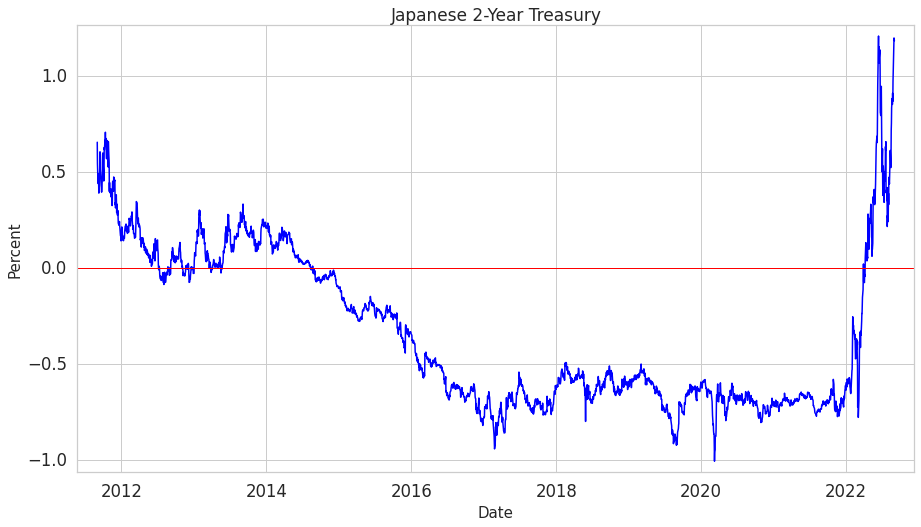

In [ ]:
plt.figure(figsize = (15,8))
graph = sns.lineplot(data = DE02Y['DE02Y'],color='blue')
graph.axhline(y=0.0,color="red",lw=1)
graph.margins(0.025)
graph.set_title("Japanese 2-Year Treasury", fontsize = 17)
graph.set_xlabel("Date", fontsize = 15)
graph.set_ylabel("Percent", fontsize = 15)

In [ ]:
bonds_indices_df = merge_dataframes(bonds_indices_df, DE02Y)
bonds_indices_df.head(3)

US02Y  US10Y  US10Y2Y  JP02Y  IT02Y  DE02Y
2011-01-09    NaN    NaN      NaN    NaN    NaN    NaN
2011-01-10    NaN    NaN      NaN    NaN    NaN    NaN
2011-01-11    NaN    NaN      NaN    NaN    NaN    NaN

In [ ]:
# BONDS_df_dictionary.update({'DE02Y' : DE02Y})
# BONDS_df_dictionary.get('DE02Y').tail(3)

In [ ]:
df_sanity_check(bonds_indices_df)

SHAPE of df is:		 (4230, 6)
NaN in df present?	 True
NaN count in df:	 1410
COLUMNS in df:
	 US02Y
	 US10Y
	 US10Y2Y
	 JP02Y
	 IT02Y
	 DE02Y


### **SPX**

In [ ]:
spx_hist = investpy.indices.get_index_historical_data(index='S&P 500',country="United States", from_date=dates_list[0]['start'], to_date=dates_list[0]['end'], as_json=False, order='ascending', interval='Daily')

In [ ]:
spx_hist.drop(['Open','High','Low','Volume','Currency'], axis = 1, inplace = True)
spx_hist.rename(columns={'Close':'SPX'},inplace=True, errors='raise')

In [ ]:
spx_hist.tail()

SPX
Date               
2022-08-26  4057.66
2022-08-29  4030.61
2022-08-30  3986.16
2022-08-31  3955.00
2022-09-01  3966.85

In [ ]:
# spx_info = investpy.indices.get_index_information(index='S&P 500 TR',country="United States", as_json=False)
# spx_info.transpose()

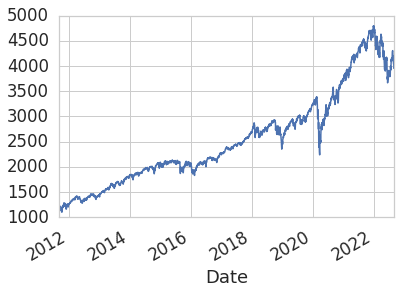

In [ ]:
spx_hist['SPX'].plot()

Text(0, 0.5, 'Index Value')

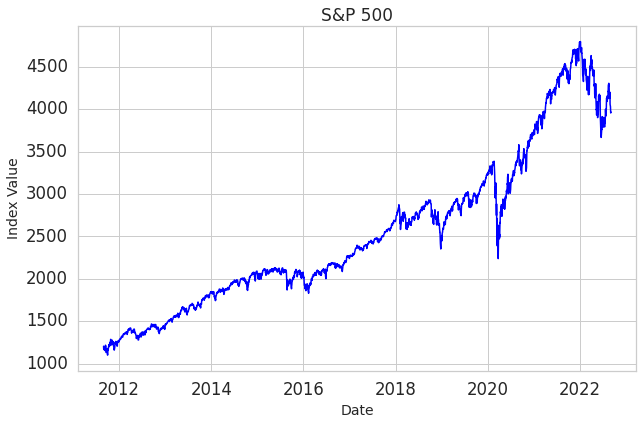

In [ ]:
# SEABORN GRAPH
plt.figure(figsize = (10,6.18))
graph = sns.lineplot(data=spx_hist['SPX'],color='blue')
graph.margins(0.05)
graph.set_title("S&P 500", fontsize = 17)
graph.set_xlabel("Date", fontsize = 14)
graph.set_ylabel("Index Value", fontsize = 14)

In [ ]:
# # ADD dataframes to INDICES_df_dictionary
# INDICES_df_dictionary.update({'spx_cl_price' : spx_hist})
# INDICES_df_dictionary['spx_cl_price'].tail()

In [ ]:
# print(dates_list[2])
# index = pd.date_range(start=dates_list[2]['start'], end=dates_list[2]['end'], freq='D')
# blank_df = pd.DataFrame(index=index)
# blank_df.head(3)

In [ ]:
# indices_df = spx_hist.copy(deep=True)
# indices_df.tail(3)

In [ ]:
bonds_indices_df = merge_dataframes(bonds_indices_df, spx_hist)
bonds_indices_df.head(3)

US02Y  US10Y  US10Y2Y  JP02Y  IT02Y  DE02Y  SPX
2011-01-09    NaN    NaN      NaN    NaN    NaN    NaN  NaN
2011-01-10    NaN    NaN      NaN    NaN    NaN    NaN  NaN
2011-01-11    NaN    NaN      NaN    NaN    NaN    NaN  NaN

In [ ]:
bonds_indices_df.tail(3)

US02Y  US10Y  US10Y2Y  JP02Y  IT02Y  DE02Y      SPX
2022-08-31  3.4950  3.196    -0.30 -0.084  2.203  1.198  3955.00
2022-09-01  3.5117  3.263    -0.25 -0.076  2.256  1.190  3966.85
2022-09-02  3.5026  3.263    -0.25 -0.083  2.263  1.184  3966.85

### **NDX**

In [ ]:
ndx_hist = investpy.indices.get_index_historical_data(index='Nasdaq 100',country="United States", from_date=dates_list[0]['start'], to_date=dates_list[0]['end'], as_json=False, order='ascending', interval='Daily')
ndx_hist.tail()

Open      High       Low     Close     Volume Currency
Date                                                                  
2022-08-26  13129.15  13172.93  12605.17  12605.17  307908224      USD
2022-08-29  12487.76  12593.90  12440.81  12484.32  219329824      USD
2022-08-30  12562.40  12571.91  12240.83  12342.70  232041888      USD
2022-08-31  12447.56  12500.79  12268.71  12272.03  314460352      USD
2022-09-01  12158.00  12289.77  12013.56  12274.63  276693824      USD

In [ ]:
ndx_hist.drop(['Open','High','Low','Volume','Currency'], axis = 1, inplace = True)
ndx_hist.rename(columns={'Close':'NDX'},inplace=True, errors='raise')

In [ ]:
ndx_hist.tail(3)

NDX
Date                
2022-08-30  12342.70
2022-08-31  12272.03
2022-09-01  12274.63

Text(0, 0.5, 'Index Value')

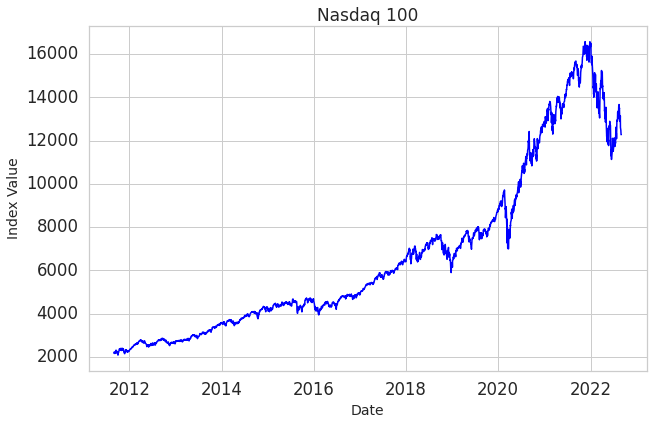

In [ ]:
plt.figure(figsize = (10,6.18))
graph = sns.lineplot(data=ndx_hist['NDX'],color='blue')
graph.margins(0.05)
graph.set_title("Nasdaq 100", fontsize = 17)
graph.set_xlabel("Date", fontsize = 14)
graph.set_ylabel("Index Value", fontsize = 14)

In [ ]:
bonds_indices_df.head(3)

US02Y  US10Y  US10Y2Y  JP02Y  IT02Y  DE02Y  SPX
2011-01-09    NaN    NaN      NaN    NaN    NaN    NaN  NaN
2011-01-10    NaN    NaN      NaN    NaN    NaN    NaN  NaN
2011-01-11    NaN    NaN      NaN    NaN    NaN    NaN  NaN

In [ ]:
bonds_indices_df = merge_dataframes(bonds_indices_df, ndx_hist)
bonds_indices_df.head(3)

US02Y  US10Y  US10Y2Y  JP02Y  IT02Y  DE02Y  SPX  NDX
2011-01-09    NaN    NaN      NaN    NaN    NaN    NaN  NaN  NaN
2011-01-10    NaN    NaN      NaN    NaN    NaN    NaN  NaN  NaN
2011-01-11    NaN    NaN      NaN    NaN    NaN    NaN  NaN  NaN

In [ ]:
bonds_indices_df.tail(3)

US02Y  US10Y  US10Y2Y  JP02Y  IT02Y  DE02Y      SPX       NDX
2022-08-31  3.4950  3.196    -0.30 -0.084  2.203  1.198  3955.00  12272.03
2022-09-01  3.5117  3.263    -0.25 -0.076  2.256  1.190  3966.85  12274.63
2022-09-02  3.5026  3.263    -0.25 -0.083  2.263  1.184  3966.85  12274.63

In [ ]:
# ADD dataframes to INDICES_df_dictionary
# INDICES_df_dictionary.update({'ndx_cl_price' : ndx_hist})
# INDICES_df_dictionary.tail(3)

### **DXY**

In [ ]:
dxy_info = investpy.indices.get_index_information(index='US Dollar Index', country='United States')
dxy_info

Index Name  Prev. Close  Volume    Day's Range    Open  \
0  US Dollar Index       109.69     0.0  109.14-109.61  109.64   

  Average Vol. (3m)   52 wk Range 1-Year Change  
0                 -  91.95-109.98        18.53%

In [ ]:
# investpy.indices.get_index_historical_data(index, country, from_date, to_date, as_json=False, order='ascending', interval='Daily')
dxy = investpy.indices.get_index_historical_data(index='US Dollar Index', country='United States', from_date=dates_list[0]['start'], to_date=dates_list[0]['end'], as_json=False, order='ascending', interval='Daily')
dxy.tail()

Open    High     Low   Close  Volume Currency
Date                                                       
2022-08-29  108.84  109.48  108.49  108.83       0      USD
2022-08-30  108.65  109.11  108.29  108.76       0      USD
2022-08-31  108.76  109.20  108.38  108.86       0      USD
2022-09-01  108.86  109.98  108.77  109.60       0      USD
2022-09-02  109.60  109.61  109.14  109.31       0      USD

In [ ]:
dxy.drop(['Open','High','Low','Volume','Currency'], axis = 1, inplace = True)
dxy.rename(columns={'Close':'DXY'},inplace=True, errors='raise')

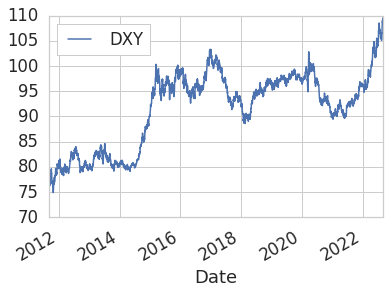

In [ ]:
dxy.plot()

Text(0, 0.5, 'Index Jan 2006 = 100')

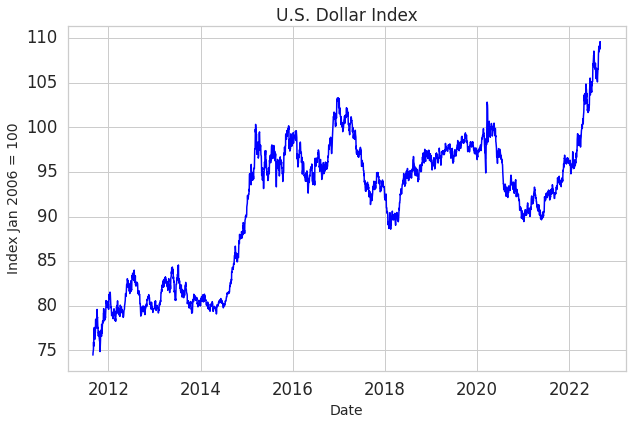

In [ ]:
# SEABORN GRAPH
plt.figure(figsize = (10,6.18))
graph = sns.lineplot(data=dxy['DXY'],color='blue')
graph.margins(0.05)
graph.set_title("U.S. Dollar Index", fontsize = 17)
graph.set_xlabel("Date", fontsize = 14)
graph.set_ylabel("Index Jan 2006 = 100", fontsize = 14)

In [ ]:
bonds_indices_df = merge_dataframes(bonds_indices_df, dxy)
bonds_indices_df.head(3)

US02Y  US10Y  US10Y2Y  JP02Y  IT02Y  DE02Y  SPX  NDX  DXY
2011-01-09    NaN    NaN      NaN    NaN    NaN    NaN  NaN  NaN  NaN
2011-01-10    NaN    NaN      NaN    NaN    NaN    NaN  NaN  NaN  NaN
2011-01-11    NaN    NaN      NaN    NaN    NaN    NaN  NaN  NaN  NaN

In [ ]:
bonds_indices_df.head(3)

US02Y  US10Y  US10Y2Y  JP02Y  IT02Y  DE02Y  SPX  NDX  DXY
2011-01-09    NaN    NaN      NaN    NaN    NaN    NaN  NaN  NaN  NaN
2011-01-10    NaN    NaN      NaN    NaN    NaN    NaN  NaN  NaN  NaN
2011-01-11    NaN    NaN      NaN    NaN    NaN    NaN  NaN  NaN  NaN

### **HOUSING UNITS, U.S. Permits**

In [ ]:
dates_list

[{'start': '01/09/2011', 'end': '02/09/2022'},
 {'start': '2011/09/01', 'end': '2022/09/02'},
 {'start': '2011-09-01', 'end': '2022-09-02'},
 {'start': '01-09-2011', 'end': '02-09-2022'}]

In [ ]:
# SOURCE: FRED
# FREQUENCY: MONTHLY
# fred.get_series('SP500', observation_start='2014-09-02', observation_end='2014-09-05')
housing = fred.get_series('PERMIT', observation_start=dates_list[2]['start'], observation_end=dates_list[2]['end'])

In [ ]:
print(len(housing),"\n")
housing.tail()

131 



2022-03-01    1879.0
2022-04-01    1823.0
2022-05-01    1695.0
2022-06-01    1696.0
2022-07-01    1685.0
dtype: float64

In [ ]:
# df = pd. DataFrame(np_array, columns=['Column1', 'Column2'])
housing_df = pd.DataFrame(housing, columns=['Housing_Units'])
housing_df.head(3)

Housing_Units
2011-09-01          610.0
2011-10-01          671.0
2011-11-01          706.0

In [ ]:
housing_df.tail(3)

Housing_Units
2022-05-01         1695.0
2022-06-01         1696.0
2022-07-01         1685.0

In [ ]:
housing_df.index.inferred_type == "datetime64"

True

In [ ]:
type(housing_df)

pandas.core.frame.DataFrame

Text(0, 0.5, 'Thousands of Units')

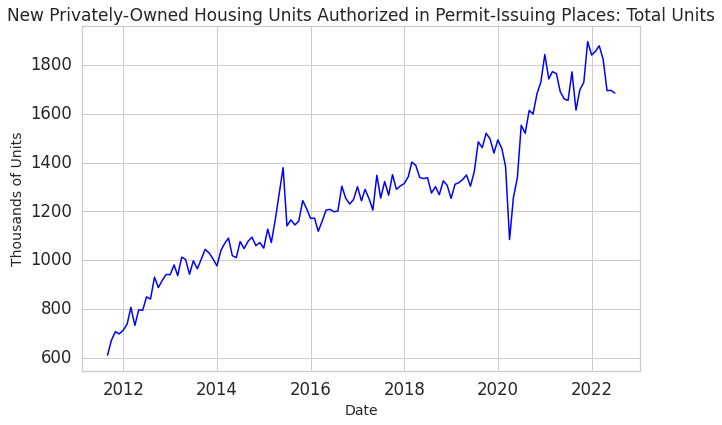

In [ ]:
plt.figure(figsize = (10,6.18))
graph = sns.lineplot(data=housing_df['Housing_Units'],color='blue')
graph.margins(0.05)
graph.set_title("New Privately-Owned Housing Units Authorized in Permit-Issuing Places: Total Units", fontsize = 17)
graph.set_xlabel("Date", fontsize = 14)
graph.set_ylabel("Thousands of Units", fontsize = 14)

In [ ]:
bonds_indices_df = merge_dataframes(bonds_indices_df, housing_df)
bonds_indices_df.head(3)

US02Y  US10Y  US10Y2Y  JP02Y  IT02Y  DE02Y  SPX  NDX  DXY  \
2011-01-09    NaN    NaN      NaN    NaN    NaN    NaN  NaN  NaN  NaN   
2011-01-10    NaN    NaN      NaN    NaN    NaN    NaN  NaN  NaN  NaN   
2011-01-11    NaN    NaN      NaN    NaN    NaN    NaN  NaN  NaN  NaN   

            Housing_Units  
2011-01-09            NaN  
2011-01-10            NaN  
2011-01-11            NaN

In [ ]:
# ADD dataframes to INDICES_df_dictionary
# INDICES_df_dictionary.update({'index_housing' : housing_df})
# INDICES_df_dictionary['index_housing'].tail()

### **HOUSING Case-Shiller Price Index**

In [ ]:
# SOURCE: FRED
# FREQUENCY: MONTHLY
case_schiller = fred.get_series('CSUSHPISA', observation_start=dates_list[2]['start'], observation_end=dates_list[2]['end'])

In [ ]:
print(len(case_schiller),"\n")
case_schiller.tail()

130 



2022-02-01    290.371
2022-03-01    296.362
2022-04-01    301.409
2022-05-01    305.179
2022-06-01    306.181
dtype: float64

In [ ]:
case_schiller_df = pd.DataFrame(case_schiller, columns=['Case-Shiller'])
case_schiller_df.head()

Case-Shiller
2011-09-01       138.667
2011-10-01       137.953
2011-11-01       137.154
2011-12-01       136.676
2012-01-01       136.607

In [ ]:
case_schiller_df.tail(3)

Case-Shiller
2022-04-01       301.409
2022-05-01       305.179
2022-06-01       306.181

In [ ]:
print(type(case_schiller_df))

<class 'pandas.core.frame.DataFrame'>


Text(0, 0.5, 'Index Jan 2000 = 100')

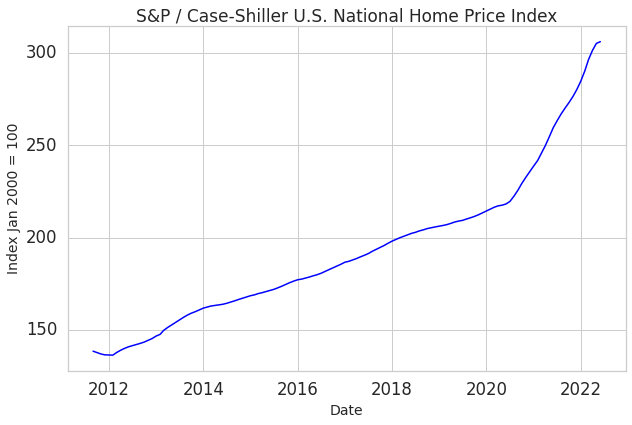

In [ ]:
# SEABORN GRAPH
plt.figure(figsize = (10,6.18))
# plt.figure(figsize = (15,8))
graph = sns.lineplot(data = case_schiller_df['Case-Shiller'] ,color='blue')
# graph.axhline(y=0.0,color="red",lw=1)
graph.margins(0.05)
graph.set_title("S&P / Case-Shiller U.S. National Home Price Index", fontsize = 17)
graph.set_xlabel("Date", fontsize = 14)
graph.set_ylabel("Index Jan 2000 = 100", fontsize = 14)

In [ ]:
bonds_indices_df = merge_dataframes(bonds_indices_df, case_schiller_df)
bonds_indices_df.head(3)

US02Y  US10Y  US10Y2Y  JP02Y  IT02Y  DE02Y  SPX  NDX  DXY  \
2011-01-09    NaN    NaN      NaN    NaN    NaN    NaN  NaN  NaN  NaN   
2011-01-10    NaN    NaN      NaN    NaN    NaN    NaN  NaN  NaN  NaN   
2011-01-11    NaN    NaN      NaN    NaN    NaN    NaN  NaN  NaN  NaN   

            Housing_Units  Case-Shiller  
2011-01-09            NaN           NaN  
2011-01-10            NaN           NaN  
2011-01-11            NaN           NaN

In [ ]:
# ADD dataframes to INDICES_df_dictionary
# INDICES_df_dictionary.update({'index_cs':case_schiller_df})
# INDICES_df_dictionary['index_cs'].tail()

### **Consumer Discretionary Select Sector SPDR**

In [ ]:
cons_discr = investpy.etfs.get_etf_historical_data(etf='Consumer Discretionary Select Sector SPDR',
                                                        country='United States',
                                                        from_date = dates_list[0]['start'],
                                                        to_date = dates_list[0]['end'],
                                                        interval='Daily')

In [ ]:
cons_discr.head(3)

Open   High    Low  Close    Volume Currency Exchange
Date                                                              
2011-09-01  37.55  37.90  37.05  37.11   9822187      USD     NYSE
2011-09-02  36.36  36.54  35.94  36.06  12263720      USD     NYSE
2011-09-06  35.01  36.00  34.99  35.95   8780994      USD     NYSE

In [ ]:
cons_discr['Close'].tail(3)

Date
2022-08-30    157.06
2022-08-31    155.51
2022-09-01    156.93
Name: Close, dtype: float64

In [ ]:
cons_discr['Close'].head(3)

Date
2011-09-01    37.11
2011-09-02    36.06
2011-09-06    35.95
Name: Close, dtype: float64

In [ ]:
cons_discr.drop(['Open','High','Low','Volume','Currency','Exchange'], axis = 1, inplace = True)
cons_discr.rename(columns={'Close':'Consumer-Discr.'},inplace=True, errors='raise')

In [ ]:
cons_discr.head(3)

Consumer-Discr.
Date                       
2011-09-01            37.11
2011-09-02            36.06
2011-09-06            35.95

In [ ]:
type(cons_discr)

pandas.core.frame.DataFrame

Text(0, 0.5, 'Index')

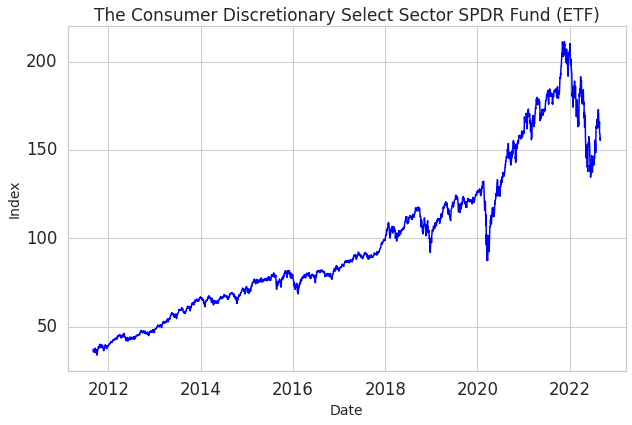

In [ ]:
plt.figure(figsize = (10,6.18))
graph = sns.lineplot(data=cons_discr['Consumer-Discr.'],color='blue')
graph.margins(0.05)
graph.set_title("The Consumer Discretionary Select Sector SPDR Fund (ETF)", fontsize = 17)
graph.set_xlabel("Date", fontsize = 14)
graph.set_ylabel("Index", fontsize = 14)

In [ ]:
bonds_indices_df = merge_dataframes(bonds_indices_df, cons_discr)
bonds_indices_df.head(3)

US02Y  US10Y  US10Y2Y  JP02Y  IT02Y  DE02Y  SPX  NDX  DXY  \
2011-01-09    NaN    NaN      NaN    NaN    NaN    NaN  NaN  NaN  NaN   
2011-01-10    NaN    NaN      NaN    NaN    NaN    NaN  NaN  NaN  NaN   
2011-01-11    NaN    NaN      NaN    NaN    NaN    NaN  NaN  NaN  NaN   

            Housing_Units  Case-Shiller  Consumer-Discr.  
2011-01-09            NaN           NaN              NaN  
2011-01-10            NaN           NaN              NaN  
2011-01-11            NaN           NaN              NaN

### **Sticky Price Consumer Price Index less Food and Energy**

In [ ]:
# Source: FRED
# Sticky Price Consumer Price Index less Food and Energy (CORESTICKM159SFRBATL)	
# FREQUENCY: Monthly

In [ ]:
cpi = fred.get_series('CORESTICKM159SFRBATL', observation_start=dates_list[2]['start'], observation_end=dates_list[2]['end'])
cpi = pd.DataFrame(cpi, columns=['CPI'])
cpi.tail()

CPI
2022-03-01  4.551815
2022-04-01  4.723538
2022-05-01  4.975575
2022-06-01  5.425963
2022-07-01  5.629465

In [ ]:
type(cpi)

pandas.core.frame.DataFrame

Text(0, 0.5, 'Percent Change from Year Ago')

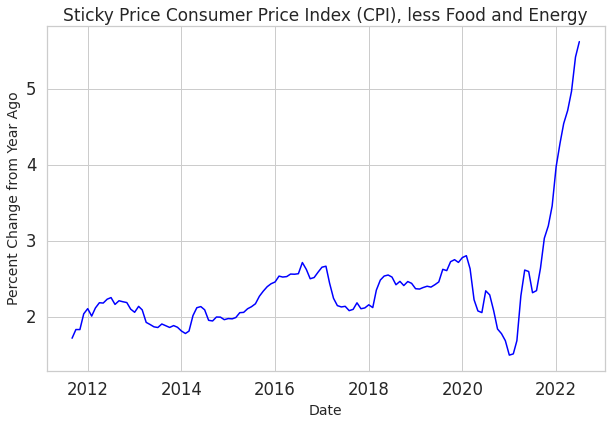

In [ ]:
plt.figure(figsize = (10,6.18))
graph = sns.lineplot(data=cpi['CPI'],color='blue')
graph.margins(0.05)
graph.set_title("Sticky Price Consumer Price Index (CPI), less Food and Energy", fontsize = 17)
graph.set_xlabel("Date", fontsize = 14)
graph.set_ylabel("Percent Change from Year Ago", fontsize = 14)

In [ ]:
bonds_indices_df = merge_dataframes(bonds_indices_df, cpi)
bonds_indices_df.head(3)

US02Y  US10Y  US10Y2Y  JP02Y  IT02Y  DE02Y  SPX  NDX  DXY  \
2011-01-09    NaN    NaN      NaN    NaN    NaN    NaN  NaN  NaN  NaN   
2011-01-10    NaN    NaN      NaN    NaN    NaN    NaN  NaN  NaN  NaN   
2011-01-11    NaN    NaN      NaN    NaN    NaN    NaN  NaN  NaN  NaN   

            Housing_Units  Case-Shiller  Consumer-Discr.  CPI  
2011-01-09            NaN           NaN              NaN  NaN  
2011-01-10            NaN           NaN              NaN  NaN  
2011-01-11            NaN           NaN              NaN  NaN

### **PPI >> PRODUCER PRICE INDEX**

In [ ]:
# Producer Price Index by Commodity: All Commodities (PPIACO)	

In [ ]:
ppi = fred.get_series('PPIACO', observation_start=dates_list[2]['start'], observation_end=dates_list[2]['end'])
ppi = pd.DataFrame(ppi, columns=['PPI'])
ppi.tail()

PPI
2022-03-01  260.014
2022-04-01  265.412
2022-05-01  273.305
2022-06-01  280.459
2022-07-01  271.625

Text(0, 0.5, 'Index (1982 = 100)')

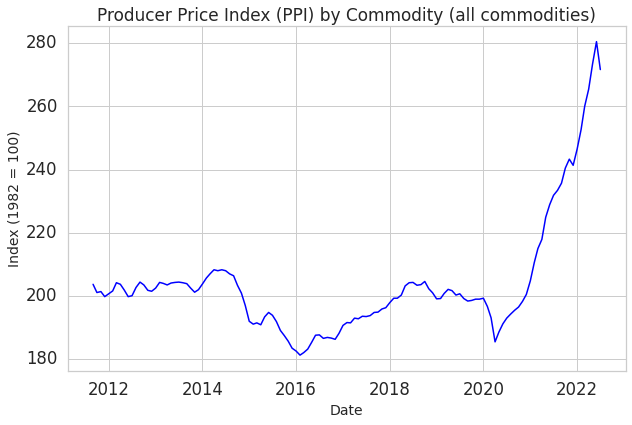

In [ ]:
plt.figure(figsize = (10,6.18))
graph = sns.lineplot(data=ppi['PPI'],color='blue')
graph.margins(0.05)
graph.set_title("Producer Price Index (PPI) by Commodity (all commodities)", fontsize = 17)
graph.set_xlabel("Date", fontsize = 14)
graph.set_ylabel("Index (1982 = 100)", fontsize = 14)

In [ ]:
bonds_indices_df = merge_dataframes(bonds_indices_df, ppi)
bonds_indices_df.head(3)

US02Y  US10Y  US10Y2Y  JP02Y  IT02Y  DE02Y  SPX  NDX  DXY  \
2011-01-09    NaN    NaN      NaN    NaN    NaN    NaN  NaN  NaN  NaN   
2011-01-10    NaN    NaN      NaN    NaN    NaN    NaN  NaN  NaN  NaN   
2011-01-11    NaN    NaN      NaN    NaN    NaN    NaN  NaN  NaN  NaN   

            Housing_Units  Case-Shiller  Consumer-Discr.  CPI  PPI  
2011-01-09            NaN           NaN              NaN  NaN  NaN  
2011-01-10            NaN           NaN              NaN  NaN  NaN  
2011-01-11            NaN           NaN              NaN  NaN  NaN

In [ ]:
df_sanity_check(bonds_indices_df)

SHAPE of df is:		 (4230, 14)
NaN in df present?	 True
NaN count in df:	 3290
COLUMNS in df:
	 US02Y
	 US10Y
	 US10Y2Y
	 JP02Y
	 IT02Y
	 DE02Y
	 SPX
	 NDX
	 DXY
	 Housing_Units
	 Case-Shiller
	 Consumer-Discr.
	 CPI
	 PPI


In [ ]:
bonds_indices_df.head(3)

US02Y  US10Y  US10Y2Y  JP02Y  IT02Y  DE02Y  SPX  NDX  DXY  \
2011-01-09    NaN    NaN      NaN    NaN    NaN    NaN  NaN  NaN  NaN   
2011-01-10    NaN    NaN      NaN    NaN    NaN    NaN  NaN  NaN  NaN   
2011-01-11    NaN    NaN      NaN    NaN    NaN    NaN  NaN  NaN  NaN   

            Housing_Units  Case-Shiller  Consumer-Discr.  CPI  PPI  
2011-01-09            NaN           NaN              NaN  NaN  NaN  
2011-01-10            NaN           NaN              NaN  NaN  NaN  
2011-01-11            NaN           NaN              NaN  NaN  NaN

In [ ]:
# df.index = pd.to_datetime(df.index)
bonds_indices_df.index = pd.to_datetime(bonds_indices_df.index)

In [ ]:
bonds_indices_df.head(3)

US02Y  US10Y  US10Y2Y  JP02Y  IT02Y  DE02Y  SPX  NDX  DXY  \
2011-01-09    NaN    NaN      NaN    NaN    NaN    NaN  NaN  NaN  NaN   
2011-01-10    NaN    NaN      NaN    NaN    NaN    NaN  NaN  NaN  NaN   
2011-01-11    NaN    NaN      NaN    NaN    NaN    NaN  NaN  NaN  NaN   

            Housing_Units  Case-Shiller  Consumer-Discr.  CPI  PPI  
2011-01-09            NaN           NaN              NaN  NaN  NaN  
2011-01-10            NaN           NaN              NaN  NaN  NaN  
2011-01-11            NaN           NaN              NaN  NaN  NaN

### **PKL >> Bonds & Indices**

In [ ]:
# Pickle DataFrame to file
# bonds_indices_df.to_pickle("/content/drive/MyDrive/___DBS_September 2021_anderskiss11/__DISSERTATION_DBS_APPLIED RESEARCH PAPER/__IMAGES & FILES_Dissertation/bonds_indices_df_{}.pkl".format(pkl_str))
bonds_indices_df = pd.read_pickle("/content/drive/MyDrive/___DBS_September 2021_anderskiss11/__DISSERTATION_DBS_APPLIED RESEARCH PAPER/__IMAGES & FILES_Dissertation/bonds_indices_df_29Aug2022_0818.pkl")
print(len(bonds_indices_df))

4251


In [ ]:
remove_nan(bonds_indices_df)
df_sanity_check(bonds_indices_df)

SHAPE of df is:		 (4016, 14)
NaN in df present?	 False
NaN count in df:	 0
COLUMNS in df:
	 US02Y
	 US10Y
	 US10Y2Y
	 JP02Y
	 IT02Y
	 DE02Y
	 SPX
	 NDX
	 DXY
	 Housing_Units
	 Case-Shiller
	 Consumer-Discr.
	 CPI
	 PPI


In [ ]:
bonds_indices_df.head(3)
bonds_indices_df.tail(3)

US02Y  US10Y  US10Y2Y  JP02Y  IT02Y  DE02Y      SPX       NDX  \
2022-08-27  3.3824  3.030    -0.33 -0.085  1.768  0.972  4057.66  12605.17   
2022-08-28  3.4375  3.071    -0.33 -0.084  1.768  0.972  4057.66  12605.17   
2022-08-29  3.4109  3.097    -0.33 -0.082  2.041  1.084  4036.80  12534.47   

               DXY  Housing_Units  Case-Shiller  Consumer-Discr.       CPI  \
2022-08-27  108.80         1685.0       304.831           159.68  5.629465   
2022-08-28  109.18         1685.0       304.831           159.68  5.629465   
2022-08-29  108.61         1685.0       304.831           158.80  5.629465   

                PPI  
2022-08-27  271.625  
2022-08-28  271.625  
2022-08-29  271.625

### **PLOT >> Indices subplot**

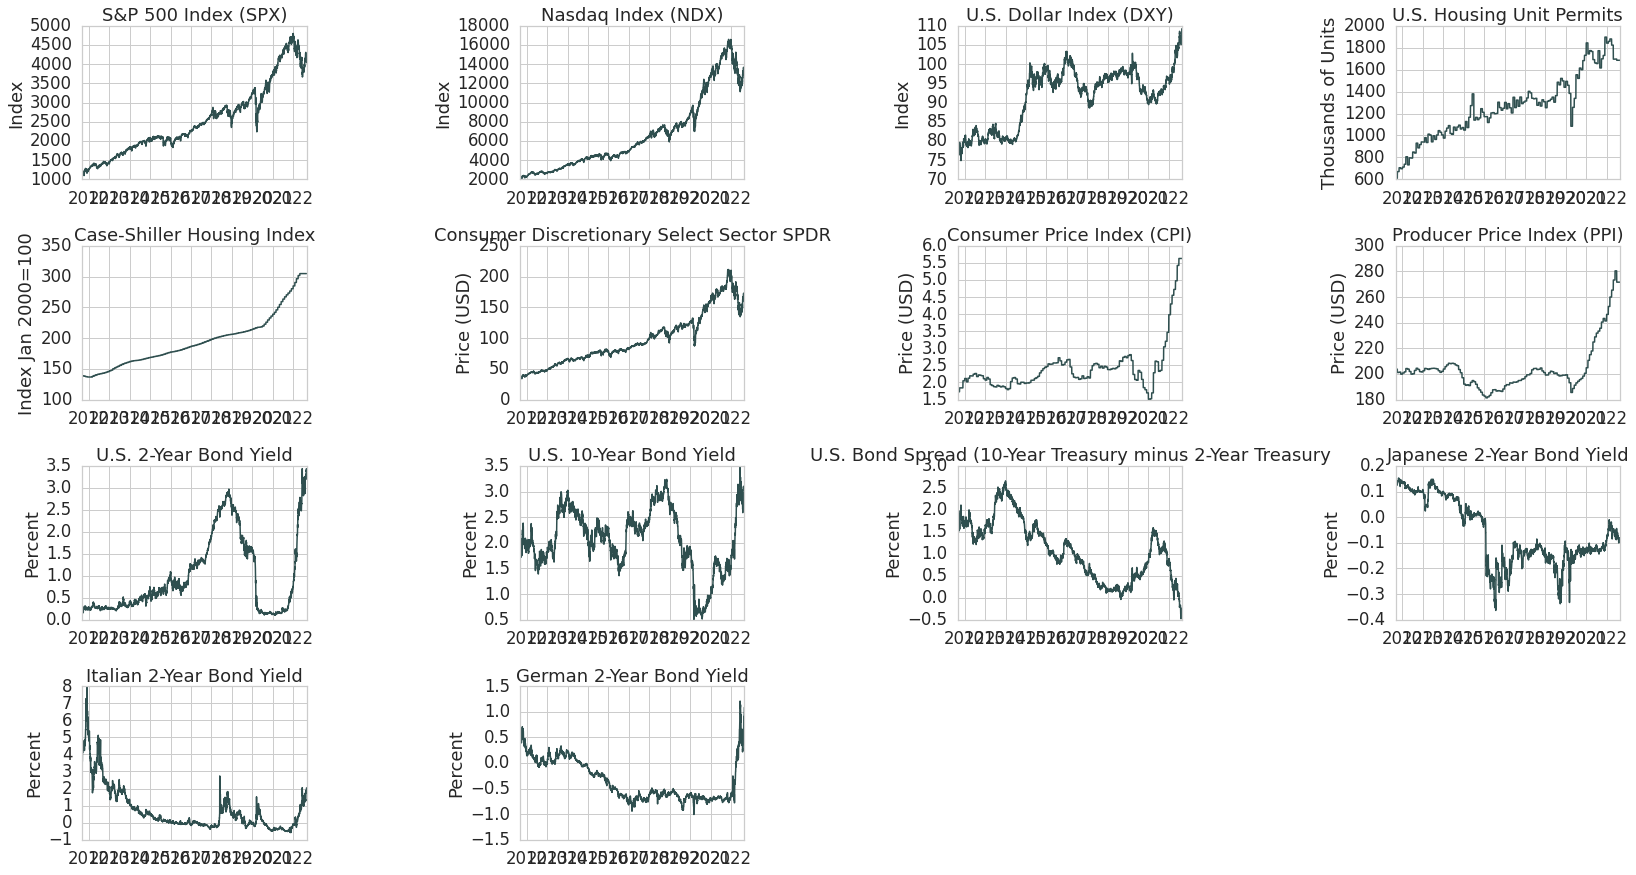

In [ ]:
# fig, axes = plt.subplots(3, 3, figsize=(17, 14))
fig, axes = plt.subplots(4, 4, figsize=(23, 12.5))
# fig.suptitle('Features: Bitcoin Price & Indices (as of {})'.format(now.strftime("%d-%b-%Y")), size=19, weight='bold', y=1.05) 

sns.lineplot(ax=axes[0, 0], color='darkslategrey', data=bonds_indices_df['SPX'], x=bonds_indices_df.index, y=bonds_indices_df['SPX']).set(ylabel='Index', title='S&P 500 Index (SPX)')
sns.lineplot(ax=axes[0, 1], color='darkslategrey', data=bonds_indices_df['NDX'], x=bonds_indices_df.index, y=bonds_indices_df['NDX']).set(ylabel='Index', title='Nasdaq Index (NDX)')
sns.lineplot(ax=axes[0, 2], color='darkslategrey', data=bonds_indices_df['DXY'], x=bonds_indices_df.index, y=bonds_indices_df['DXY']).set(ylabel='Index', title='U.S. Dollar Index (DXY)')
sns.lineplot(ax=axes[0, 3], color='darkslategrey', data=bonds_indices_df['Housing_Units'], x=bonds_indices_df.index, y=bonds_indices_df['Housing_Units']).set(ylabel='Thousands of Units', title='U.S. Housing Unit Permits')

sns.lineplot(ax=axes[1, 0], color='darkslategrey', data=bonds_indices_df['Case-Shiller'], x=bonds_indices_df.index, y=bonds_indices_df['Case-Shiller']).set(ylabel='Index Jan 2000=100', title='Case-Shiller Housing Index')
sns.lineplot(ax=axes[1, 1], color='darkslategrey', data=bonds_indices_df['Consumer-Discr.'], x=bonds_indices_df.index, y=bonds_indices_df['Consumer-Discr.']).set(ylabel='Price (USD)', title='Consumer Discretionary Select Sector SPDR')
sns.lineplot(ax=axes[1, 2], color='darkslategrey', data=bonds_indices_df['CPI'], x=bonds_indices_df.index, y=bonds_indices_df['CPI']).set(ylabel='Price (USD)', title='Consumer Price Index (CPI)')
sns.lineplot(ax=axes[1, 3], color='darkslategrey', data=bonds_indices_df['PPI'], x=bonds_indices_df.index, y=bonds_indices_df['PPI']).set(ylabel='Price (USD)', title='Producer Price Index (PPI)')

sns.lineplot(ax=axes[2, 0], color='darkslategrey', data=bonds_indices_df['US02Y'], x=bonds_indices_df.index, y=bonds_indices_df['US02Y']).set(ylabel='Percent', title='U.S. 2-Year Bond Yield')
sns.lineplot(ax=axes[2, 1], color='darkslategrey', data=bonds_indices_df['US10Y'], x=bonds_indices_df.index, y=bonds_indices_df['US10Y']).set(ylabel='Percent', title='U.S. 10-Year Bond Yield')
sns.lineplot(ax=axes[2, 2], color='darkslategrey', data=bonds_indices_df['US10Y2Y'], x=bonds_indices_df.index, y=bonds_indices_df['US10Y2Y']).set(ylabel='Percent', title='U.S. Bond Spread (10-Year Treasury minus 2-Year Treasury')
sns.lineplot(ax=axes[2, 3], color='darkslategrey', data=bonds_indices_df['JP02Y'], x=bonds_indices_df.index, y=bonds_indices_df['JP02Y']).set(ylabel='Percent', title='Japanese 2-Year Bond Yield')

sns.lineplot(ax=axes[3, 0], color='darkslategrey', data=bonds_indices_df['IT02Y'], x=bonds_indices_df.index, y=bonds_indices_df['IT02Y']).set(ylabel='Percent', title='Italian 2-Year Bond Yield')
sns.lineplot(ax=axes[3, 1], color='darkslategrey', data=bonds_indices_df['DE02Y'], x=bonds_indices_df.index, y=bonds_indices_df['DE02Y']).set(ylabel='Percent', title='German 2-Year Bond Yield')

# f, axes = plt.subplots(2, 3, figsize=(20, 10))
# This line will delete the last empty plot
# f.delaxes(ax= axes[1,2])
fig.delaxes(ax= axes[3,2])
fig.delaxes(ax= axes[3,3])

fig.tight_layout()
# ADD line to save to google drive
# fig.savefig('/content/drive/MyDrive/___DBS_September 2021_anderskiss11/__DISSERTATION_DBS_APPLIED RESEARCH PAPER/__IMAGES & FILES_Dissertation/bonds_indices_df_subplots_{}.png'.format(pkl_str),bbox_inches='tight',dpi=200)
# fig.savefig('bonds_indices_df_subplots.png',bbox_inches='tight',dpi=200)
plt.show()


In [ ]:
bonds_indices_df.tail(3)

US02Y  US10Y  US10Y2Y  JP02Y  IT02Y  DE02Y      SPX       NDX  \
2022-08-27  3.3824  3.030    -0.33 -0.085  1.768  0.972  4057.66  12605.17   
2022-08-28  3.4375  3.071    -0.33 -0.084  1.768  0.972  4057.66  12605.17   
2022-08-29  3.4109  3.097    -0.33 -0.082  2.041  1.084  4036.80  12534.47   

               DXY  Housing_Units  Case-Shiller  Consumer-Discr.       CPI  \
2022-08-27  108.80         1685.0       304.831           159.68  5.629465   
2022-08-28  109.18         1685.0       304.831           159.68  5.629465   
2022-08-29  108.61         1685.0       304.831           158.80  5.629465   

                PPI  
2022-08-27  271.625  
2022-08-28  271.625  
2022-08-29  271.625

In [ ]:
btc_df.head(3)

BTC  Open  High  Low  BTC_vol    BTC_RSI    BTC_log
Date                                                           
2011-09-14  5.6   5.8   5.8  5.3    43768  31.804028  -3.509132
2011-09-15  4.8   5.6   5.6  4.4    86221  26.586215 -15.415068
2011-09-16  4.8   4.8   5.0  4.6    31651  26.586215   0.000000

In [ ]:
btc_df['BTC'] = pd.DataFrame(btc_df['BTC'])

In [ ]:
btc_df['BTC'].head(3)

Date
2011-09-14    5.6
2011-09-15    4.8
2011-09-16    4.8
Name: BTC, dtype: float64

### **PLOT >> Correlation Matrix - Bitcoin Price & Indices**

In [ ]:
plot_df = join_series(btc_df['BTC'], bonds_indices_df)
plot_df.head(3)

BTC  US02Y  US10Y  US10Y2Y  JP02Y  IT02Y  DE02Y      SPX      NDX  \
Date                                                                            
2011-09-14  5.6  0.189  1.992     1.84  0.137  4.786  0.544  1188.68  2252.75   
2011-09-15  4.8  0.193  2.083     1.88  0.137  4.566  0.605  1209.11  2286.56   
2011-09-16  4.8  0.173  2.057     1.90  0.137  4.514  0.516  1216.01  2306.09   

              DXY  Housing_Units  Case-Shiller  Consumer-Discr.       CPI  \
Date                                                                        
2011-09-14  76.83          610.0       138.667            36.86  1.726814   
2011-09-15  76.24          610.0       138.667            37.48  1.726814   
2011-09-16  76.60          610.0       138.667            37.77  1.726814   

              PPI  
Date               
2011-09-14  203.7  
2011-09-15  203.7  
2011-09-16  203.7

In [ ]:
df_sanity_check(plot_df)

SHAPE of df is:		 (4007, 15)
NaN in df present?	 False
NaN count in df:	 0
COLUMNS in df:
	 BTC
	 US02Y
	 US10Y
	 US10Y2Y
	 JP02Y
	 IT02Y
	 DE02Y
	 SPX
	 NDX
	 DXY
	 Housing_Units
	 Case-Shiller
	 Consumer-Discr.
	 CPI
	 PPI


In [ ]:
remove_nan(plot_df)
df_sanity_check(plot_df)

SHAPE of df is:		 (4007, 15)
NaN in df present?	 False
NaN count in df:	 0
COLUMNS in df:
	 BTC
	 US02Y
	 US10Y
	 US10Y2Y
	 JP02Y
	 IT02Y
	 DE02Y
	 SPX
	 NDX
	 DXY
	 Housing_Units
	 Case-Shiller
	 Consumer-Discr.
	 CPI
	 PPI


In [ ]:
plot_df.head(3)

BTC  US02Y  US10Y  US10Y2Y  JP02Y  IT02Y  DE02Y      SPX      NDX  \
Date                                                                            
2011-09-14  5.6  0.189  1.992     1.84  0.137  4.786  0.544  1188.68  2252.75   
2011-09-15  4.8  0.193  2.083     1.88  0.137  4.566  0.605  1209.11  2286.56   
2011-09-16  4.8  0.173  2.057     1.90  0.137  4.514  0.516  1216.01  2306.09   

              DXY  Housing_Units  Case-Shiller  Consumer-Discr.       CPI  \
Date                                                                        
2011-09-14  76.83          610.0       138.667            36.86  1.726814   
2011-09-15  76.24          610.0       138.667            37.48  1.726814   
2011-09-16  76.60          610.0       138.667            37.77  1.726814   

              PPI  
Date               
2011-09-14  203.7  
2011-09-15  203.7  
2011-09-16  203.7

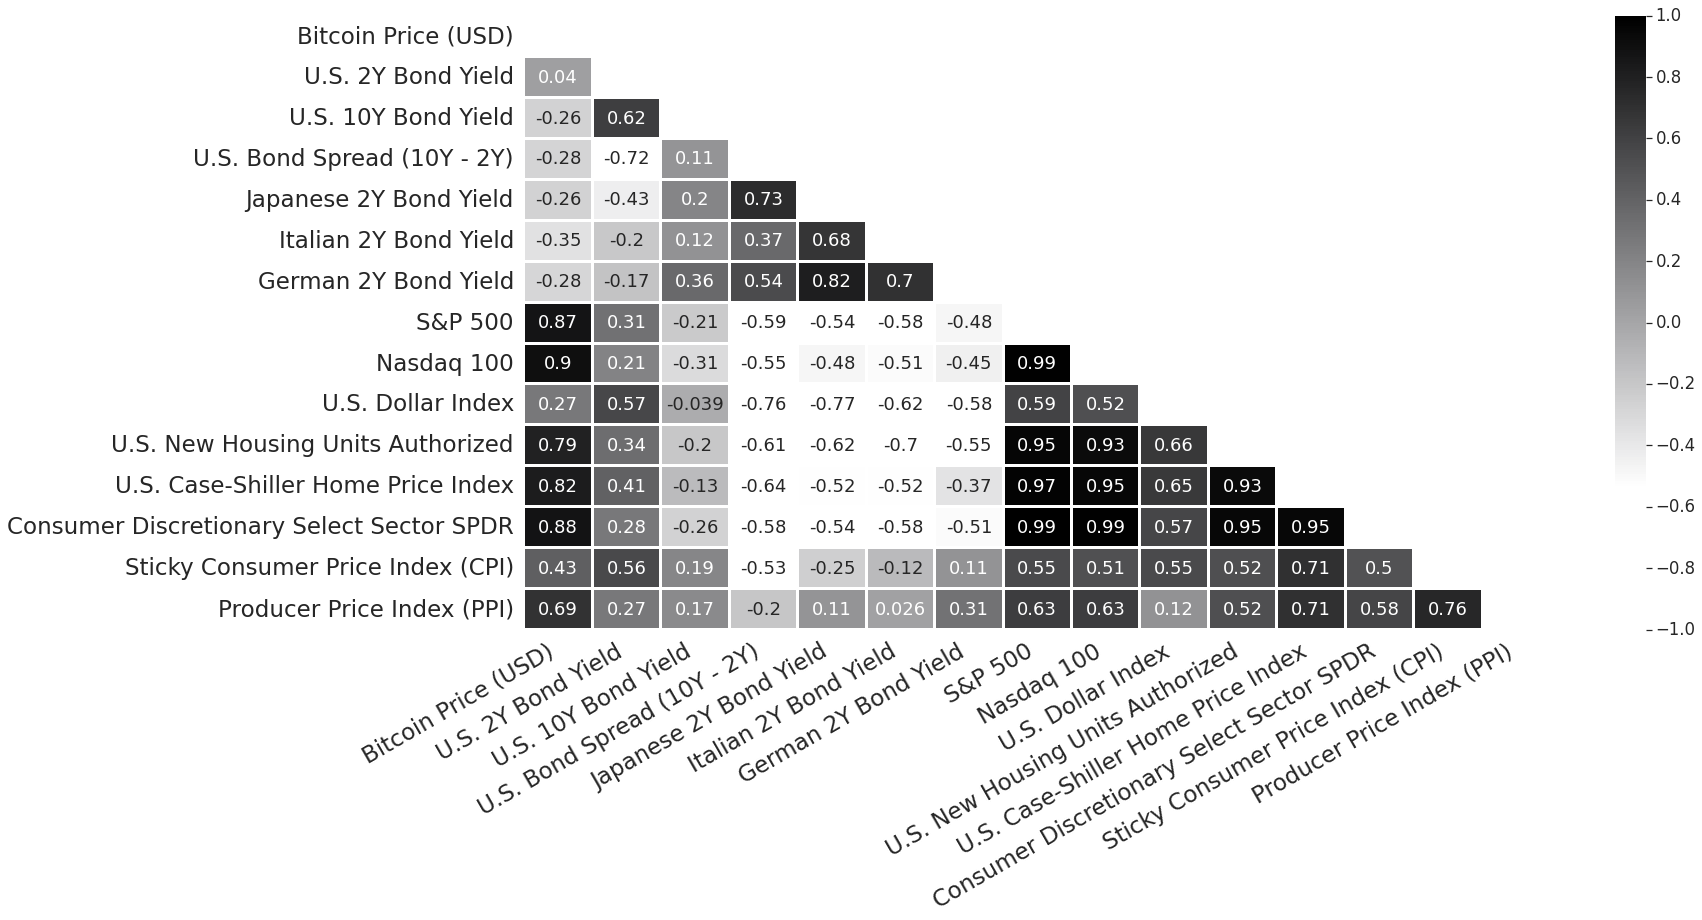

In [ ]:
# Correlation Matrix - Bitcoin and Technicals
plt.figure(figsize=(23, 11))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
corr = plot_df.corr()
# ESTABLISH mask for upper half of matrix only
matrix = np.triu(corr)
# BLACK & WHITE
# cmap = sns.cubehelix_palette(50, hue=0.05, rot=0, light=1.5, dark=0, as_cmap=True)
cmap = sns.cubehelix_palette(50, hue=0.033, rot=0, light=1.3, dark=0, as_cmap=True)
y_cols = ['Bitcoin Price (USD)','U.S. 2Y Bond Yield','U.S. 10Y Bond Yield','U.S. Bond Spread (10Y - 2Y)','Japanese 2Y Bond Yield','Italian 2Y Bond Yield','German 2Y Bond Yield','S&P 500','Nasdaq 100','U.S. Dollar Index','U.S. New Housing Units Authorized','U.S. Case-Shiller Home Price Index','Consumer Discretionary Select Sector SPDR','Sticky Consumer Price Index (CPI)','Producer Price Index (PPI)']
x_cols = ['Bitcoin Price (USD)','U.S. 2Y Bond Yield','U.S. 10Y Bond Yield','U.S. Bond Spread (10Y - 2Y)','Japanese 2Y Bond Yield','Italian 2Y Bond Yield','German 2Y Bond Yield','S&P 500','Nasdaq 100','U.S. Dollar Index','U.S. New Housing Units Authorized','U.S. Case-Shiller Home Price Index','Consumer Discretionary Select Sector SPDR','Sticky Consumer Price Index (CPI)','Producer Price Index (PPI)']
hm = sns.heatmap(corr,vmin=-1,vmax=1,annot=True,linewidth=2,mask=matrix,cmap=cmap,xticklabels=x_cols,yticklabels=y_cols)

# WITH COLOR
# hm = sns.heatmap(corr, vmin=-1, vmax=1, annot=True, linewidth=2, mask=matrix, cmap ='RdYlBu_r')
# hm.set_title('Correlation Matrix - Bitcoin Price & Indices (as of {})'.format(now.strftime("%d-%b-%Y")), fontsize=20, fontdict={'fontsize':12}, pad=12)
hm.set_xticklabels(hm.get_xticklabels(),fontsize=23,rotation=30, horizontalalignment='right')
hm.set_yticklabels(hm.get_ymajorticklabels(),fontsize=23,rotation=0)

fig.tight_layout()
fig = hm.get_figure()
# fig.savefig('/content/drive/MyDrive/___DBS_September 2021_anderskiss11/__DISSERTATION_DBS_APPLIED RESEARCH PAPER/__IMAGES & FILES_Dissertation/btc_bonds_indices_corr_matrix_{}.png'.format(pkl_str),bbox_inches='tight',dpi=120)
# hm.savefig('BTC_corr_matrix_{}.png'.format(pkl_str),bbox_inches='tight',dpi=120)

## **COMMODITIES**

In [ ]:
print(dates_list[2])
index = pd.date_range(start=dates_list[2]['start'], end=dates_list[2]['end'], freq='D')
blank_df = pd.DataFrame(index=index)
blank_df.head(3)

{'start': '2011-09-01', 'end': '2022-09-02'}


Empty DataFrame
Columns: []
Index: [2011-09-01 00:00:00, 2011-09-02 00:00:00, 2011-09-03 00:00:00]

#### **GOLD**

In [ ]:
gold = investpy.commodities.get_commodity_historical_data("Gold",
                                                          from_date=dates_list[0]['start'],
                                                          to_date=dates_list[0]['end'],
                                                          country=None, 
                                                          as_json=False, 
                                                          order='ascending', 
                                                          interval='Daily')

In [ ]:
gold.drop(['Open','High','Low','Volume','Currency'], axis = 1, inplace = True)
gold.rename(columns={'Close':'gold'},inplace=True, errors='raise')
gold.tail(3)

gold
Date               
2022-08-31  1726.20
2022-09-01  1709.30
2022-09-02  1716.95

Text(0, 0.5, 'Price')

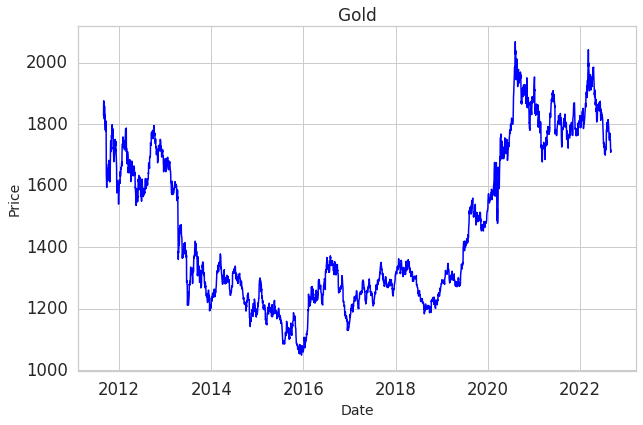

In [ ]:
plt.figure(figsize = (10,6.18))
graph = sns.lineplot(data = gold['gold'],color='blue')
graph.margins(0.05)
graph.set_title("Gold", fontsize = 17)
graph.set_xlabel("Date", fontsize = 14)
graph.set_ylabel("Price", fontsize = 14)

In [ ]:
print(dates_list[0]['start'])
index = pd.date_range(start=dates_list[2]['start'], end=dates_list[2]['end'], freq='D')
blank_df_commodities = pd.DataFrame(index=index)
blank_df_commodities.head(3)  

01/09/2011


Empty DataFrame
Columns: []
Index: [2011-09-01 00:00:00, 2011-09-02 00:00:00, 2011-09-03 00:00:00]

In [ ]:
commodities_df = gold.copy(deep=True)
commodities_df.head(3)

gold
Date              
2011-09-01  1829.1
2011-09-02  1876.9
2011-09-05  1873.3

In [ ]:
commodities_df = merge_dataframes(blank_df,commodities_df)
commodities_df.head(3)

gold
2011-09-01  1829.1
2011-09-02  1876.9
2011-09-03  1876.9

#### **WHEAT**

In [ ]:
wheat = investpy.commodities.get_commodity_historical_data("US Wheat",
                                                          from_date=dates_list[0]['start'],
                                                          to_date=dates_list[0]['end'],
                                                          country=None, 
                                                          as_json=False, 
                                                          order='ascending', 
                                                          interval='Daily')

In [ ]:
wheat.drop(['Open','High','Low','Volume','Currency'], axis = 1, inplace = True)
wheat.rename(columns={'Close':'wheat'},inplace=True, errors='raise')
wheat.tail(3)

wheat
Date              
2022-08-31  831.50
2022-09-01  797.75
2022-09-02  804.25

In [ ]:
wheat.head(3)

wheat
Date              
2011-09-01  765.13
2011-09-02  775.88
2011-09-05  765.63

Text(0, 0.5, 'Price')

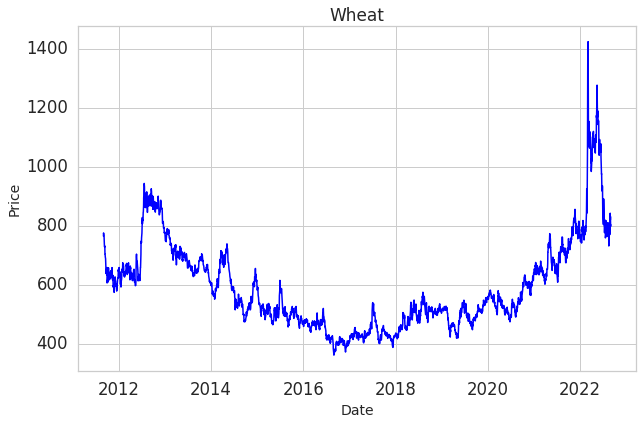

In [ ]:
plt.figure(figsize = (10,6.18))
graph = sns.lineplot(data = wheat['wheat'],color='blue')
graph.margins(0.05)
graph.set_title("Wheat", fontsize = 17)
graph.set_xlabel("Date", fontsize = 14)
graph.set_ylabel("Price", fontsize = 14)

In [ ]:
commodities_df = merge_dataframes(commodities_df, wheat)
commodities_df.head(3)

gold   wheat
2011-09-01  1829.1  765.13
2011-09-02  1876.9  775.88
2011-09-03  1876.9  775.88

In [ ]:
commodities_df.tail(3)

gold   wheat
2022-08-31  1726.20  831.50
2022-09-01  1709.30  797.75
2022-09-02  1716.95  804.25

#### **NATURAL GAS**

In [ ]:
gas = investpy.commodities.get_commodity_historical_data(commodity='Natural Gas',
                                                         from_date=dates_list[0]['start'],
                                                         to_date=dates_list[0]['end'],
                                                         country=None, 
                                                         as_json=False,
                                                         order='ascending',
                                                         interval='Daily')

In [ ]:
gas.head(3)

Open   High    Low  Close  Volume Currency
Date                                                   
2011-09-01  4.060  4.130  3.970  4.050  153275      USD
2011-09-02  4.050  4.065  3.850  3.872  127809      USD
2011-09-06  3.882  3.950  3.851  3.938  107033      USD

In [ ]:
gas.drop(['Open','High','Low','Volume','Currency'], axis = 1, inplace = True)
gas.rename(columns={'Close':'gas'},inplace=True, errors='raise')
gas.tail(3)

gas
Date             
2022-08-31  9.127
2022-09-01  9.262
2022-09-02  9.030

Text(0, 0.5, 'Price (USD)')

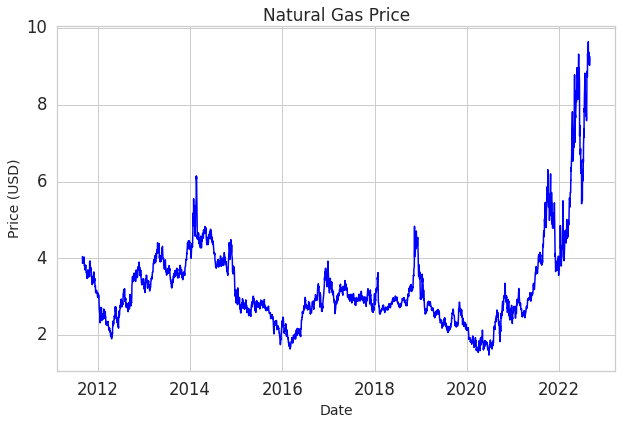

In [ ]:
plt.figure(figsize = (10,6.18))
graph = sns.lineplot(data = gas['gas'],color='blue')
graph.margins(0.05)
graph.set_title("Natural Gas Price", fontsize = 17)
graph.set_xlabel("Date", fontsize = 14)
graph.set_ylabel("Price (USD)", fontsize = 14)

In [ ]:
commodities_df = merge_dataframes(commodities_df, gas)
commodities_df.head(3)

gold   wheat    gas
2011-09-01  1829.1  765.13  4.050
2011-09-02  1876.9  775.88  3.872
2011-09-03  1876.9  775.88  3.872

#### **LUMBER**

In [ ]:
lumber = investpy.commodities.get_commodity_historical_data("lumber",
                                                          from_date=dates_list[0]['start'],
                                                          to_date=dates_list[0]['end'],
                                                          country=None, 
                                                          as_json=False, 
                                                          order='ascending', 
                                                          interval='Daily')

In [ ]:
lumber.drop(['Open','High','Low','Volume','Currency'], axis = 1, inplace = True)
lumber.rename(columns={'Close':'lumber'},inplace=True, errors='raise')
lumber.tail(3)

lumber
Date              
2022-08-30   504.8
2022-08-31   509.0
2022-09-01   499.7

Text(0, 0.5, 'Price')

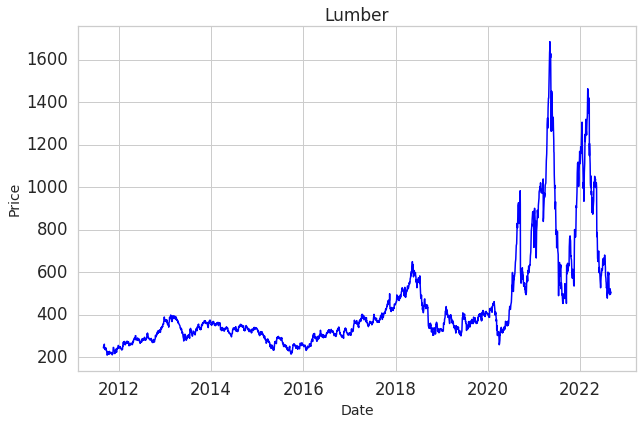

In [ ]:
plt.figure(figsize = (10,6.18))
graph = sns.lineplot(data=lumber['lumber'],color='blue')
graph.margins(0.05)
graph.set_title("Lumber", fontsize = 17)
graph.set_xlabel("Date", fontsize = 14)
graph.set_ylabel("Price", fontsize = 14)

In [ ]:
commodities_df = merge_dataframes(commodities_df, lumber)
commodities_df.head(3)

gold   wheat    gas  lumber
2011-09-01  1829.1  765.13  4.050   245.0
2011-09-02  1876.9  775.88  3.872   250.9
2011-09-03  1876.9  775.88  3.872   250.9

#### **OIL**

In [ ]:
oil = investpy.commodities.get_commodity_historical_data("Crude Oil WTI",
                                                          from_date=dates_list[0]['start'],
                                                          to_date=dates_list[0]['end'],
                                                          country=None, 
                                                          as_json=False, 
                                                          order='ascending', 
                                                          interval='Daily')

In [ ]:
oil.drop(['Open','High','Low','Volume','Currency'], axis = 1, inplace = True)
oil.rename(columns={'Close':'oil'},inplace=True, errors='raise')
oil.tail(3)

oil
Date             
2022-08-31  89.55
2022-09-01  86.61
2022-09-02  88.35

Text(0, 0.5, 'Price')

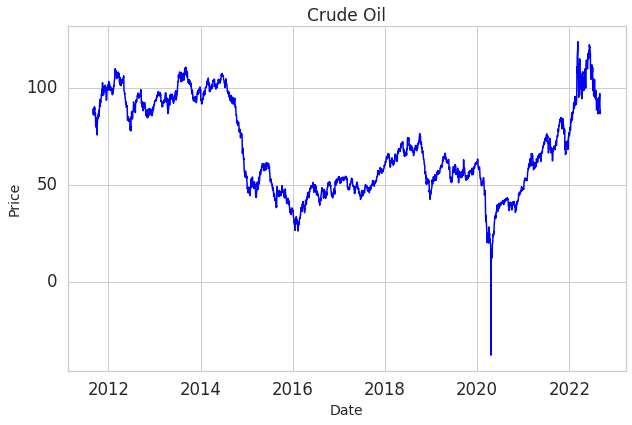

In [ ]:
plt.figure(figsize = (10,6.18))
graph = sns.lineplot(data = oil['oil'],color='blue')
graph.margins(0.05)
graph.set_title("Crude Oil", fontsize = 17)
graph.set_xlabel("Date", fontsize = 14)
graph.set_ylabel("Price", fontsize = 14)

In [ ]:
commodities_df = merge_dataframes(commodities_df, oil)
commodities_df.head(3)

gold   wheat    gas  lumber    oil
2011-09-01  1829.1  765.13  4.050   245.0  88.93
2011-09-02  1876.9  775.88  3.872   250.9  86.45
2011-09-03  1876.9  775.88  3.872   250.9  86.45

#### **COPPER**

In [ ]:
copper = investpy.commodities.get_commodity_historical_data("Copper",
                                                          from_date=dates_list[0]['start'],
                                                          to_date=dates_list[0]['end'],
                                                          country=None, 
                                                          as_json=False, 
                                                          order='ascending', 
                                                          interval='Daily')

/usr/local/lib/python3.7/dist-packages/investpy/commodities.py:648: Warning: Note that the displayed commodity data can differ depending on the country. If you want to retrieve copper data from either united states or united kingdom, specify the country parameter.
  warnings.warn(msg, Warning)


In [ ]:
copper.drop(['Open','High','Low','Volume','Currency'], axis = 1, inplace = True)
copper.rename(columns={'Close':'copper'},inplace=True, errors='raise')
copper.tail(3)

copper
Date              
2022-08-31  3.5185
2022-09-01  3.4190
2022-09-02  3.3957

Text(0, 0.5, 'Price')

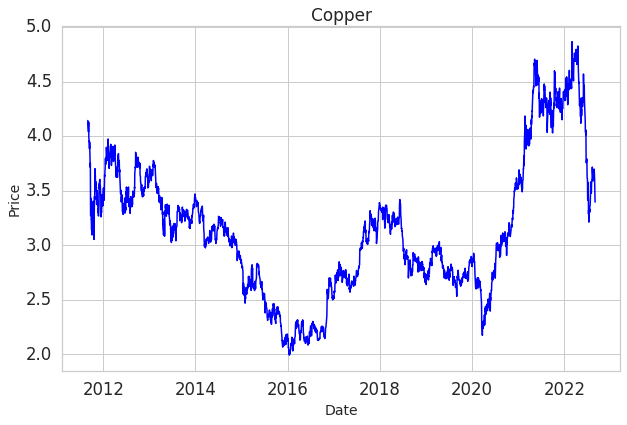

In [ ]:
plt.figure(figsize = (10,6.18))
graph = sns.lineplot(data=copper['copper'],color='blue')
graph.margins(0.05)
graph.set_title("Copper", fontsize = 17)
graph.set_xlabel("Date", fontsize = 14)
graph.set_ylabel("Price", fontsize = 14)

In [ ]:
commodities_df = merge_dataframes(commodities_df, copper)
commodities_df.head(3)

gold   wheat    gas  lumber    oil  copper
2011-09-01  1829.1  765.13  4.050   245.0  88.93   4.143
2011-09-02  1876.9  775.88  3.872   250.9  86.45   4.107
2011-09-03  1876.9  775.88  3.872   250.9  86.45   4.107

#### **NICKEL**

In [ ]:
nickel = investpy.commodities.get_commodity_historical_data("Nickel",
                                                          from_date=dates_list[0]['start'],
                                                          to_date=dates_list[0]['end'],
                                                          country=None, 
                                                          as_json=False, 
                                                          order='ascending', 
                                                          interval='Daily')

In [ ]:
nickel.drop(['Open','High','Low','Volume','Currency'], axis = 1, inplace = True)
nickel.rename(columns={'Close':'nickel'},inplace=True, errors='raise')
nickel.tail(3)

nickel
Date               
2022-08-31  21411.0
2022-09-01  20311.0
2022-09-02  20141.0

Text(0, 0.5, 'Price')

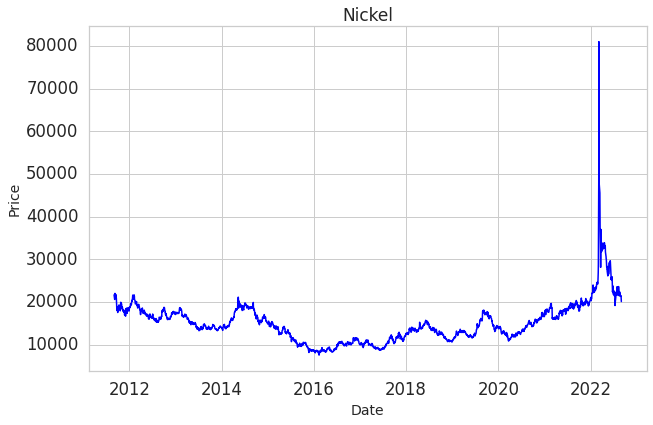

In [ ]:
plt.figure(figsize = (10,6.18))
graph = sns.lineplot(data=nickel['nickel'],color='blue')
graph.margins(0.05)
graph.set_title("Nickel", fontsize = 17)
graph.set_xlabel("Date", fontsize = 14)
graph.set_ylabel("Price", fontsize = 14)

In [ ]:
commodities_df = merge_dataframes(commodities_df, nickel)
commodities_df.head(3)

gold   wheat    gas  lumber    oil  copper   nickel
2011-09-01  1829.1  765.13  4.050   245.0  88.93   4.143  21715.0
2011-09-02  1876.9  775.88  3.872   250.9  86.45   4.107  21465.0
2011-09-03  1876.9  775.88  3.872   250.9  86.45   4.107  21465.0

### **PKL >> COMMODITIES**

In [ ]:
df_sanity_check(commodities_df)

SHAPE of df is:		 (4020, 7)
NaN in df present?	 False
NaN count in df:	 0
COLUMNS in df:
	 gold
	 wheat
	 gas
	 lumber
	 oil
	 copper
	 nickel


In [ ]:
remove_nan(commodities_df)
df_sanity_check(commodities_df)

SHAPE of df is:		 (4020, 7)
NaN in df present?	 False
NaN count in df:	 0
COLUMNS in df:
	 gold
	 wheat
	 gas
	 lumber
	 oil
	 copper
	 nickel


In [ ]:
df_sanity_check(commodities_df)

SHAPE of df is:		 (4020, 7)
NaN in df present?	 False
NaN count in df:	 0
COLUMNS in df:
	 gold
	 wheat
	 gas
	 lumber
	 oil
	 copper
	 nickel


In [ ]:
remove_nan(commodities_df)
df_sanity_check(commodities_df)

SHAPE of df is:		 (4020, 7)
NaN in df present?	 False
NaN count in df:	 0
COLUMNS in df:
	 gold
	 wheat
	 gas
	 lumber
	 oil
	 copper
	 nickel


In [ ]:
commodities_df.head(3)

gold   wheat    gas  lumber    oil  copper   nickel
2011-09-01  1829.1  765.13  4.050   245.0  88.93   4.143  21715.0
2011-09-02  1876.9  775.88  3.872   250.9  86.45   4.107  21465.0
2011-09-03  1876.9  775.88  3.872   250.9  86.45   4.107  21465.0

In [ ]:
# Pickle DataFrame to file
# commodities_df.to_pickle("/content/drive/MyDrive/___DBS_September 2021_anderskiss11/__DISSERTATION_DBS_APPLIED RESEARCH PAPER/__IMAGES & FILES_Dissertation/commodities_df_{}.pkl".format(pkl_str))
commodities_df = pd.read_pickle("/content/drive/MyDrive/___DBS_September 2021_anderskiss11/__DISSERTATION_DBS_APPLIED RESEARCH PAPER/__IMAGES & FILES_Dissertation/commodities_df_29Aug2022_1640.pkl")
print(len(commodities_df))

4016


In [ ]:
df_sanity_check(commodities_df)

SHAPE of df is:		 (4016, 7)
NaN in df present?	 False
NaN count in df:	 0
COLUMNS in df:
	 gold
	 wheat
	 gas
	 lumber
	 oil
	 copper
	 nickel


### **PLOT; Commodities subplots**

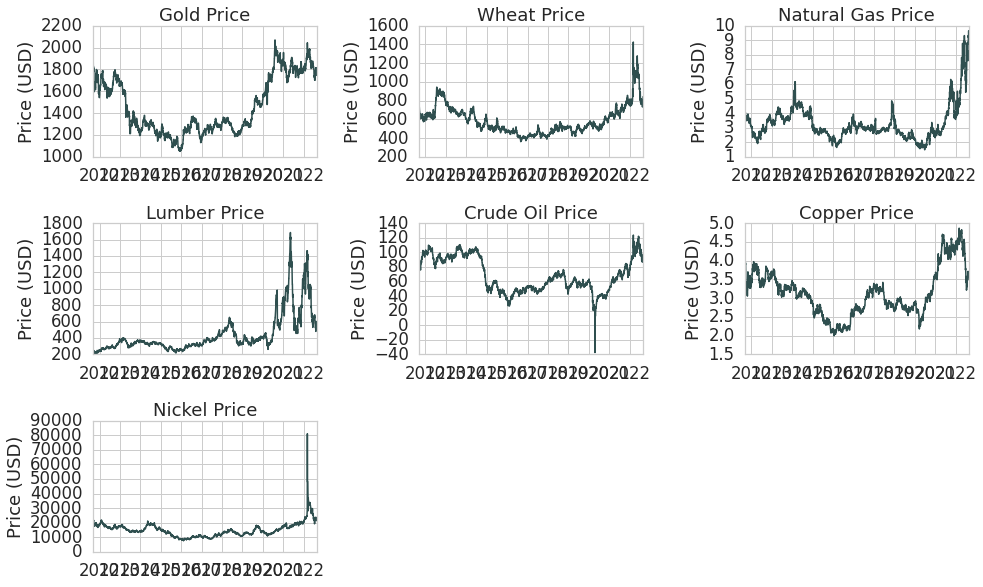

In [ ]:
# fig, axes = plt.subplots(3, 3, figsize=(17, 14))
fig, axes = plt.subplots(3, 3, figsize=(14, 8.5))
# fig.suptitle('Features: Commodities (as of {})'.format(now.strftime("%d-%b-%Y")), size=19, weight='bold', y=1.05) 

sns.lineplot(ax=axes[0, 0], color='darkslategrey', data=commodities_df['gold'], x=commodities_df.index, y=commodities_df['gold']).set(ylabel='Price (USD)', title='Gold Price')
sns.lineplot(ax=axes[0, 1], color='darkslategrey', data=commodities_df['wheat'], x=commodities_df.index, y=commodities_df['wheat']).set(ylabel='Price (USD)', title='Wheat Price')
sns.lineplot(ax=axes[0, 2], color='darkslategrey', data=commodities_df['gas'], x=commodities_df.index, y=commodities_df['gas']).set(ylabel='Price (USD)', title='Natural Gas Price')
sns.lineplot(ax=axes[1, 0], color='darkslategrey', data=commodities_df['lumber'], x=commodities_df.index, y=commodities_df['lumber']).set(ylabel='Price (USD)', title='Lumber Price')
sns.lineplot(ax=axes[1, 1], color='darkslategrey', data=commodities_df['oil'], x=commodities_df.index, y=commodities_df['oil']).set(ylabel='Price (USD)', title='Crude Oil Price')
sns.lineplot(ax=axes[1, 2], color='darkslategrey', data=commodities_df['copper'], x=commodities_df.index, y=commodities_df['copper']).set(ylabel='Price (USD)', title='Copper Price')
sns.lineplot(ax=axes[2, 0], color='darkslategrey', data=commodities_df['nickel'], x=commodities_df.index, y=commodities_df['nickel']).set(ylabel='Price (USD)', title='Nickel Price')

# Delete empty subplots
fig.delaxes(ax= axes[2,1])
fig.delaxes(ax= axes[2,2])

fig.tight_layout()
# ADD line to save to google drive
# fig.savefig('/content/drive/MyDrive/___DBS_September 2021_anderskiss11/__DISSERTATION_DBS_APPLIED RESEARCH PAPER/__IMAGES & FILES_Dissertation/Commodities_subplots_{}.png'.format(pkl_str),bbox_inches='tight',dpi=120)
# fig.savefig('Commodities_subplots.png',bbox_inches='tight',dpi=120)
plt.show()

### **PLOT; Correlation Matrix - Bitcoin Price & Commodities**

In [ ]:
# plot_df_btc_commodities = concat_dataframes(btc_df['BTC'], commodities_df)
plot_df_btc_commodities = join_series(btc_df['BTC'], commodities_df)
plot_df_btc_commodities.tail(3)

BTC     gold  wheat    gas  lumber    oil  copper   nickel
Date                                                                      
2022-08-31  20043.9  1749.75  842.1  9.264   509.8  96.95  3.6045  21633.0
2022-09-01  20126.1  1749.75  842.1  9.264   509.8  96.95  3.6045  21633.0
2022-09-02  20073.9  1749.75  842.1  9.264   509.8  96.95  3.6045  21633.0

In [ ]:
df_sanity_check(plot_df_btc_commodities)

SHAPE of df is:		 (4007, 8)
NaN in df present?	 False
NaN count in df:	 0
COLUMNS in df:
	 BTC
	 gold
	 wheat
	 gas
	 lumber
	 oil
	 copper
	 nickel


In [ ]:
remove_nan(plot_df_btc_commodities)
# df_sanity_check(plot_df_btc_commodities)

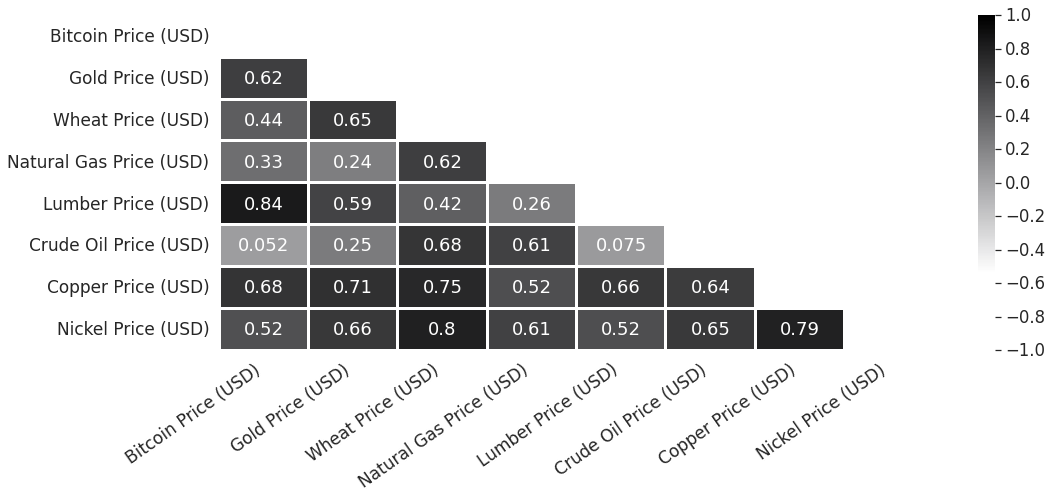

In [ ]:
plt.figure(figsize=(16, 6))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
corr = plot_df_btc_commodities.corr()
# ESTABLISH mask for upper half of matrix only
matrix = np.triu(corr)
# BLACK & WHITE
# cmap = sns.cubehelix_palette(50, hue=0.05, rot=0, light=1.5, dark=0, as_cmap=True)
cmap = sns.cubehelix_palette(50, hue=0.033, rot=0, light=1.3, dark=0, as_cmap=True)
y_cols = ['Bitcoin Price (USD)','Gold Price (USD)','Wheat Price (USD)','Natural Gas Price (USD)','Lumber Price (USD)','Crude Oil Price (USD)','Copper Price (USD)','Nickel Price (USD)']
x_cols = ['Bitcoin Price (USD)','Gold Price (USD)','Wheat Price (USD)','Natural Gas Price (USD)','Lumber Price (USD)','Crude Oil Price (USD)','Copper Price (USD)','Nickel Price (USD)']
hm = sns.heatmap(corr,vmin=-1,vmax=1,annot=True,linewidth=2,mask=matrix,cmap=cmap,xticklabels=x_cols,yticklabels=y_cols)

# WITH COLOR
# hm = sns.heatmap(corr, vmin=-1, vmax=1, annot=True, linewidth=2, mask=matrix, cmap ='RdYlBu_r')
# hm.set_title('Correlation Matrix - Bitcoin Price & Commodities (as of {})'.format(now.strftime("%d-%b-%Y")), fontsize=20, fontdict={'fontsize':12}, pad=12)
hm.set_xticklabels(hm.get_xticklabels(),fontsize=17,rotation=35, horizontalalignment='right')
hm.set_yticklabels(hm.get_ymajorticklabels(),fontsize=17,rotation=0)
fig.tight_layout()
fig = hm.get_figure()
fig.savefig('/content/drive/MyDrive/___DBS_September 2021_anderskiss11/__DISSERTATION_DBS_APPLIED RESEARCH PAPER/__IMAGES & FILES_Dissertation/BTC_commodities_corr_matrix_{}.png'.format(pkl_str),bbox_inches='tight',dpi=120)
# hm.savefig('BTC_commodities_corr_matrix_{}.png'.format(pkl_str),bbox_inches='tight',dpi=120)

## **MACRO**

In [ ]:
print(dates_list[2])
index = pd.date_range(start=dates_list[2]['start'], end=dates_list[2]['end'], freq='D')
blank_df = pd.DataFrame(index=index)
blank_df.head(3)

{'start': '2011-09-01', 'end': '2022-09-02'}


Empty DataFrame
Columns: []
Index: [2011-09-01 00:00:00, 2011-09-02 00:00:00, 2011-09-03 00:00:00]

In [ ]:
print(blank_df.index.inferred_type == "datetime64","\n")

True 



In [ ]:
# MACRO_df_dictionary = {}
# len(MACRO_df_dictionary)
# MACRO_df_dictionary

#### **University of Michigan: Consumer Sentiment**

In [ ]:
umcsent = fred.get_series('UMCSENT', observation_start=dates_list[2]['start'], observation_end=dates_list[2]['end'])
print(len(umcsent),"\n")
umcsent.tail(3)

131 



2022-05-01    58.4
2022-06-01    50.0
2022-07-01    51.5
dtype: float64

In [ ]:
print(type(umcsent))

<class 'pandas.core.series.Series'>


In [ ]:
# df = pd. DataFrame(np_array, columns=['Column1', 'Column2'])
umcsent = pd.DataFrame(umcsent, columns=['UMCSENT'])
umcsent.tail(3)

UMCSENT
2022-05-01     58.4
2022-06-01     50.0
2022-07-01     51.5

In [ ]:
umcsent.head(3)

UMCSENT
2011-09-01     59.5
2011-10-01     60.8
2011-11-01     63.7

In [ ]:
print(type(umcsent))

<class 'pandas.core.frame.DataFrame'>


Text(0, 0.5, 'Index 1966:Q1 = 100')

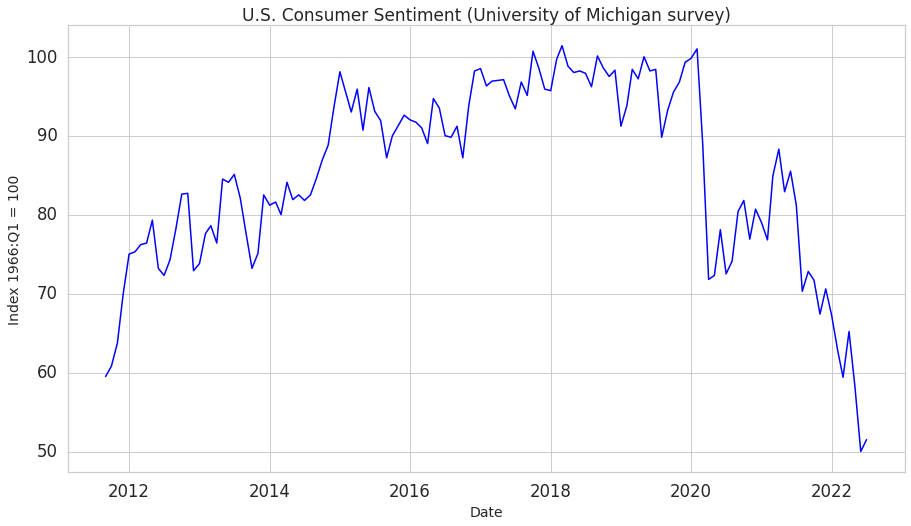

In [ ]:
plt.figure(figsize = (15,8))
graph = sns.lineplot(data=umcsent['UMCSENT'],color='blue')
graph.margins(0.05)
graph.set_title("U.S. Consumer Sentiment (University of Michigan survey)", fontsize = 17)
graph.set_xlabel("Date", fontsize = 14)
graph.set_ylabel("Index 1966:Q1 = 100", fontsize = 14)

In [ ]:
blank_df.head(3)

Empty DataFrame
Columns: []
Index: [2011-09-01 00:00:00, 2011-09-02 00:00:00, 2011-09-03 00:00:00]

In [ ]:
umcsent.head(3)

UMCSENT
2011-09-01     59.5
2011-10-01     60.8
2011-11-01     63.7

In [ ]:
macro_df = merge_dataframes(blank_df, umcsent)
macro_df.head(3)

UMCSENT
2011-09-01     59.5
2011-09-02     59.5
2011-09-03     59.5

In [ ]:
# VERIFY monthly data is forward filled
# macro_df.head(35)

In [ ]:
# MACRO_df_dictionary.update({'UMCSENT' : umcsent})
# MACRO_df_dictionary.get('UMCSENT').tail(3)

#### **Central Bank Liquidity Swaps**

In [ ]:
# SOURCE: FRED
# FREQUENCY: MONTHLY
# Assets: Central Bank Liquidity Swaps: Central Bank Liquidity Swaps: Wednesday Level (SWPT)	
swaps = fred.get_series('SWPT', observation_start=dates_list[2]['start'], observation_end=dates_list[2]['end'])
print(len(swaps),"\n")
swaps.tail(3)

574 



2022-08-17    189.0
2022-08-24    166.0
2022-08-31    171.0
dtype: float64

In [ ]:
print(type(swaps))

<class 'pandas.core.series.Series'>


In [ ]:
swaps = pd.DataFrame(swaps, columns=['SWAPS'])
swaps.tail(3)

SWAPS
2022-08-17  189.0
2022-08-24  166.0
2022-08-31  171.0

In [ ]:
print(type(swaps))

<class 'pandas.core.frame.DataFrame'>


Text(0, 0.5, 'Millions of U.S. Dollars')

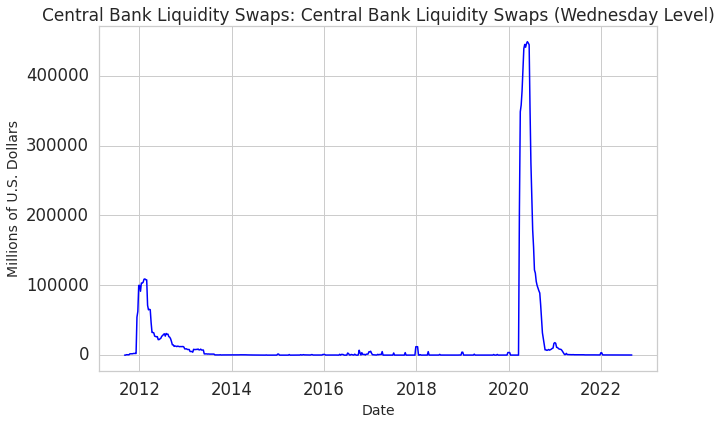

In [ ]:
plt.figure(figsize = (10,6.18))
graph = sns.lineplot(data = swaps['SWAPS'], color='blue')
graph.margins(0.05)
graph.set_title("Central Bank Liquidity Swaps: Central Bank Liquidity Swaps (Wednesday Level)", fontsize = 17)
graph.set_xlabel("Date", fontsize = 14)
graph.set_ylabel("Millions of U.S. Dollars", fontsize = 14)

In [ ]:
macro_df = merge_dataframes(macro_df, swaps)
macro_df.head(3)

UMCSENT  SWAPS
2011-09-01     59.5    NaN
2011-09-02     59.5    NaN
2011-09-03     59.5    NaN

In [ ]:
# MACRO_df_dictionary.update({'SWAPS' : swaps})
# MACRO_df_dictionary.get('SWAPS').tail(3)

#### **FED FUNDS rate**

In [ ]:
# SOURCE: FRED
# FREQUENCY: MONTHLY
ff = fred.get_series('FEDFUNDS', observation_start=dates_list[2]['start'], observation_end=dates_list[2]['end'])
print(len(ff),"\n")
ff.tail(3)

132 



2022-06-01    1.21
2022-07-01    1.68
2022-08-01    2.33
dtype: float64

In [ ]:
print(type(ff))

<class 'pandas.core.series.Series'>


In [ ]:
ff = pd.DataFrame(ff, columns=['FEDFUNDS'])
ff.tail(3)

FEDFUNDS
2022-06-01      1.21
2022-07-01      1.68
2022-08-01      2.33

In [ ]:
print(type(ff))

<class 'pandas.core.frame.DataFrame'>


Text(0, 0.5, 'Percent')

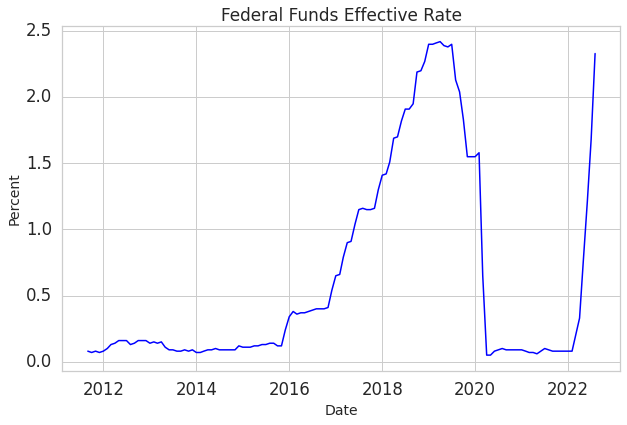

In [ ]:
plt.figure(figsize = (10,6.18))
graph = sns.lineplot(data = ff['FEDFUNDS'], color='blue')
graph.margins(0.05)
graph.set_title("Federal Funds Effective Rate", fontsize = 17)
graph.set_xlabel("Date", fontsize = 14)
graph.set_ylabel("Percent", fontsize = 14)

In [ ]:
macro_df = merge_dataframes(macro_df, ff)
macro_df.head(3)

UMCSENT  SWAPS  FEDFUNDS
2011-09-01     59.5    NaN      0.08
2011-09-02     59.5    NaN      0.08
2011-09-03     59.5    NaN      0.08

In [ ]:
# MACRO_df_dictionary.update({'FEDFUNDS' : ff})
# MACRO_df_dictionary.get('FEDFUNDS').tail(3)

#### **VIX**

In [ ]:
vix = investpy.indices.get_index_historical_data(index='S&P 500 VIX', country='United States', from_date=dates_list[0]['start'], to_date=dates_list[0]['end'], as_json=False, order='ascending', interval='Daily')
vix.tail(3)

Open   High    Low  Close  Volume Currency
Date                                                   
2022-08-31  25.86  26.62  25.31  25.87       0      USD
2022-09-01  26.88  27.45  25.25  25.56       0      USD
2022-09-02  25.51  25.59  25.26  25.50       0      USD

In [ ]:
vix.drop(['Open','High','Low','Volume','Currency'], axis = 1, inplace = True)
vix.rename(columns={'Close':'VIX'},inplace=True, errors='raise')

In [ ]:
vix.tail(3)

VIX
Date             
2022-08-31  25.87
2022-09-01  25.56
2022-09-02  25.50

Text(0, 0.5, 'Index')

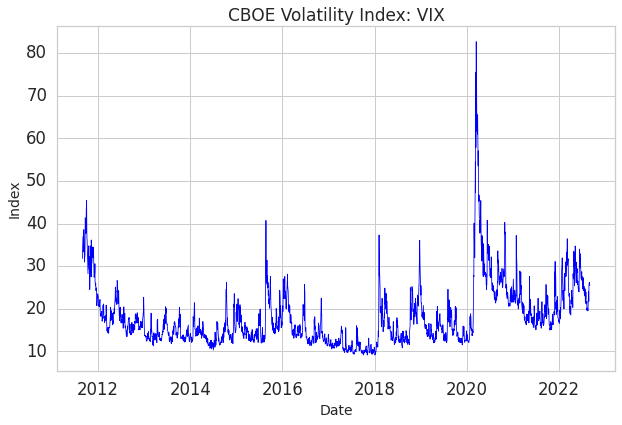

In [ ]:
plt.figure(figsize = (10,6.18))
graph = sns.lineplot(data=vix['VIX'],color='blue',lw=0.8)
graph.margins(0.05)
graph.set_title("CBOE Volatility Index: VIX", fontsize = 17)
graph.set_xlabel("Date", fontsize = 14)
graph.set_ylabel("Index", fontsize = 14)

In [ ]:
macro_df = merge_dataframes(macro_df, vix)
macro_df.head(3)

UMCSENT  SWAPS  FEDFUNDS    VIX
2011-09-01     59.5    NaN      0.08  31.82
2011-09-02     59.5    NaN      0.08  33.92
2011-09-03     59.5    NaN      0.08  33.92

In [ ]:
# MACRO_df_dictionary.update({'VIX' : vix})
# MACRO_df_dictionary.get('VIX').tail(3)

### **Unemployment Rate**

In [ ]:
# SOURCE: FRED
# FREQUENCY: MONTHLY
unrate = fred.get_series('UNRATE', observation_start=dates_list[2]['start'], observation_end=dates_list[2]['end'])
print(len(unrate),"\n")
unrate.tail(3)

131 



2022-05-01    3.6
2022-06-01    3.6
2022-07-01    3.5
dtype: float64

In [ ]:
print(type(unrate))

<class 'pandas.core.series.Series'>


In [ ]:
unrate = pd.DataFrame(unrate, columns=['UNRATE'])
unrate.tail(3)

UNRATE
2022-05-01     3.6
2022-06-01     3.6
2022-07-01     3.5

In [ ]:
print(type(unrate))

<class 'pandas.core.frame.DataFrame'>


Text(0, 0.5, 'Percent')

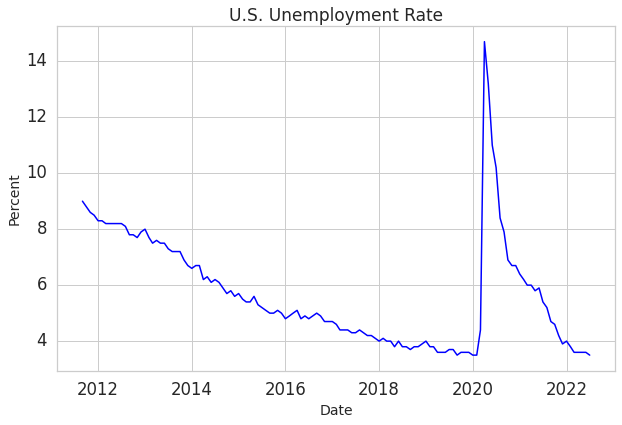

In [ ]:
plt.figure(figsize = (10,6.18))
graph = sns.lineplot(data=unrate['UNRATE'],color='blue')
graph.margins(0.05)
graph.set_title("U.S. Unemployment Rate", fontsize = 17)
graph.set_xlabel("Date", fontsize = 14)
graph.set_ylabel("Percent", fontsize = 14)

In [ ]:
macro_df = merge_dataframes(macro_df, unrate)
macro_df.head(3)

UMCSENT  SWAPS  FEDFUNDS    VIX  UNRATE
2011-09-01     59.5    NaN      0.08  31.82     9.0
2011-09-02     59.5    NaN      0.08  33.92     9.0
2011-09-03     59.5    NaN      0.08  33.92     9.0

In [ ]:
# MACRO_df_dictionary.update({'UNRATE' : unrate})
# MACRO_df_dictionary.get('UNRATE').tail(3)

### **Federal Debt: Total Public Debt as Percent of Gross Domestic Product**

In [ ]:
# SOURCE: FRED
# FREQUENCY: MONTHLY
debt_to_gdp = fred.get_series('GFDEGDQ188S', observation_start=dates_list[2]['start'], observation_end=dates_list[2]['end'])
print(len(debt_to_gdp),"\n")
debt_to_gdp.tail(3)

44 



2021-10-01    123.39059
2022-01-01    124.66188
2022-04-01    122.84986
dtype: float64

In [ ]:
print(type(debt_to_gdp))

<class 'pandas.core.series.Series'>


In [ ]:
debt_to_gdp = pd.DataFrame(debt_to_gdp, columns=['debt_to_gdp'])
debt_to_gdp.head(3)

debt_to_gdp
2011-07-01     94.52097
2011-10-01     96.09067
2012-01-01     97.12296

In [ ]:
print(type(debt_to_gdp))

<class 'pandas.core.frame.DataFrame'>


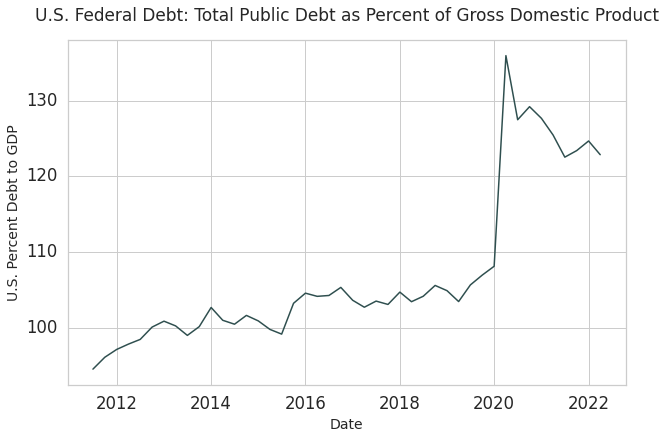

In [ ]:
plt.figure(figsize = (10,6.18))
graph = sns.lineplot(data = debt_to_gdp['debt_to_gdp'], color='darkslategrey')
graph.margins(0.05)
graph.set_title("U.S. Federal Debt: Total Public Debt as Percent of Gross Domestic Product", fontsize = 17, y=1.04)
graph.set_xlabel("Date", fontsize = 14)
graph.set_ylabel("U.S. Percent Debt to GDP", fontsize = 14)
plt.savefig('/content/drive/MyDrive/___DBS_September 2021_anderskiss11/__DISSERTATION_DBS_APPLIED RESEARCH PAPER/__IMAGES & FILES_Dissertation/US_Debt_to_GDP_{}.png'.format(pkl_str),bbox_inches='tight',dpi=120)

In [ ]:
macro_df = merge_dataframes(macro_df, debt_to_gdp)
macro_df.head(3)

UMCSENT  SWAPS  FEDFUNDS    VIX  UNRATE  debt_to_gdp
2011-07-01      NaN    NaN       NaN    NaN     NaN     94.52097
2011-09-01     59.5    NaN      0.08  31.82     9.0     94.52097
2011-09-02     59.5    NaN      0.08  33.92     9.0     94.52097

In [ ]:
# MACRO_df_dictionary.update({'percent_gdp' : debt_to_gdp})
# MACRO_df_dictionary.get('percent_gdp').tail(3)

### **Consumer Loans: Credit Cards and Other Revolving Plans, All Commercial Banks**

In [ ]:
# SOURCE: FRED
# FREQUENCY: MONTHLY
consmr_loans = fred.get_series('CCLACBW027SBOG', observation_start=dates_list[2]['start'], observation_end=dates_list[2]['end'])
print(len(consmr_loans),"\n")
consmr_loans.tail(3)

572 



2022-08-03    896.3401
2022-08-10    898.9077
2022-08-17    898.8889
dtype: float64

In [ ]:
print(type(consmr_loans))

<class 'pandas.core.series.Series'>


In [ ]:
consmr_loans = pd.DataFrame(consmr_loans, columns=['consmr_loans'])
consmr_loans.tail(3)

consmr_loans
2022-08-03      896.3401
2022-08-10      898.9077
2022-08-17      898.8889

In [ ]:
print(type(consmr_loans))

<class 'pandas.core.frame.DataFrame'>


Text(0, 0.5, 'Billions of U.S. Dollars')

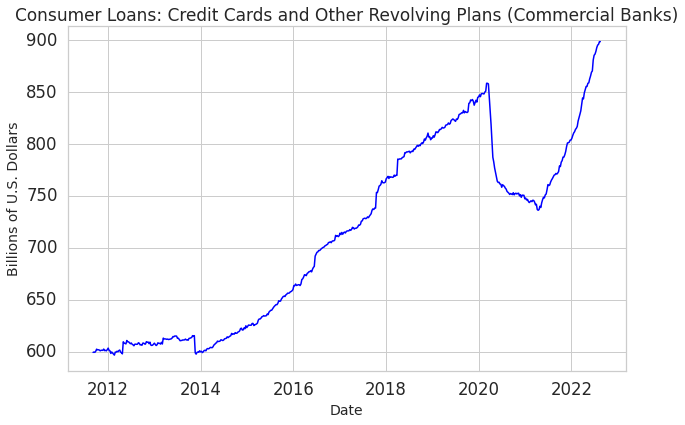

In [ ]:
plt.figure(figsize = (10,6.18))
graph = sns.lineplot(data = consmr_loans['consmr_loans'],color='blue')
graph.margins(0.05)
graph.set_title("Consumer Loans: Credit Cards and Other Revolving Plans (Commercial Banks)", fontsize = 17)
graph.set_xlabel("Date", fontsize = 14)
graph.set_ylabel("Billions of U.S. Dollars", fontsize = 14)

In [ ]:
macro_df = merge_dataframes(macro_df, consmr_loans)
macro_df.head(3)

UMCSENT  SWAPS  FEDFUNDS    VIX  UNRATE  debt_to_gdp  consmr_loans
2011-07-01      NaN    NaN       NaN    NaN     NaN     94.52097           NaN
2011-09-01     59.5    NaN      0.08  31.82     9.0     94.52097           NaN
2011-09-02     59.5    NaN      0.08  33.92     9.0     94.52097           NaN

In [ ]:
# MACRO_df_dictionary.update({'consmr_loans' : consmr_loans})
# MACRO_df_dictionary.get('consmr_loans').tail(3)

### **Inventories to Sales**

In [ ]:
# SOURCE: FRED
# FREQUENCY: MONTHLY
inv_to_sales = fred.get_series('MNFCTRIRSA', observation_start=dates_list[2]['start'], observation_end=dates_list[2]['end'])
print(len(inv_to_sales),"\n")
inv_to_sales.tail(5)

130 



2022-02-01    1.48
2022-03-01    1.47
2022-04-01    1.47
2022-05-01    1.46
2022-06-01    1.45
dtype: float64

In [ ]:
print(type(inv_to_sales))

<class 'pandas.core.series.Series'>


In [ ]:
inv_to_sales = pd.DataFrame(inv_to_sales, columns=['inv_to_sales'])
inv_to_sales.head(3)

inv_to_sales
2011-09-01          1.29
2011-10-01          1.30
2011-11-01          1.30

In [ ]:
print(type(inv_to_sales))

<class 'pandas.core.frame.DataFrame'>


Text(0, 0.5, 'Ratio')

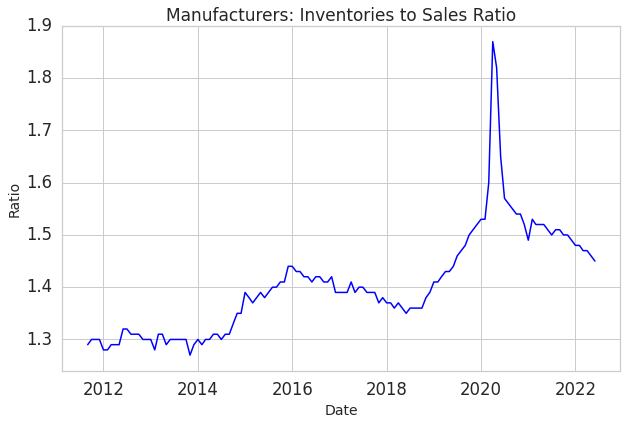

In [ ]:
plt.figure(figsize = (10,6.18))
graph = sns.lineplot(data = inv_to_sales['inv_to_sales'],color='blue')
graph.margins(0.05)
graph.set_title("Manufacturers: Inventories to Sales Ratio", fontsize = 17)
graph.set_xlabel("Date", fontsize = 14)
graph.set_ylabel("Ratio", fontsize = 14)

In [ ]:
macro_df = merge_dataframes(macro_df, inv_to_sales)
macro_df.head(3)

UMCSENT  SWAPS  FEDFUNDS    VIX  UNRATE  debt_to_gdp  \
2011-07-01      NaN    NaN       NaN    NaN     NaN     94.52097   
2011-09-01     59.5    NaN      0.08  31.82     9.0     94.52097   
2011-09-02     59.5    NaN      0.08  33.92     9.0     94.52097   

            consmr_loans  inv_to_sales  
2011-07-01           NaN           NaN  
2011-09-01           NaN          1.29  
2011-09-02           NaN          1.29

In [ ]:
# MACRO_df_dictionary.update({'inv_to_sales' : inv_to_sales})
# MACRO_df_dictionary.get('inv_to_sales').tail(5)

In [ ]:
df_sanity_check(macro_df)

SHAPE of df is:		 (4021, 8)
NaN in df present?	 True
NaN count in df:	 19
COLUMNS in df:
	 UMCSENT
	 SWAPS
	 FEDFUNDS
	 VIX
	 UNRATE
	 debt_to_gdp
	 consmr_loans
	 inv_to_sales


In [ ]:
# print("// 'MACRO_df_dictionary' details:")
# print("Expected Dictionary Length is: 7","\nActual Dictionary Length is:", len(MACRO_df_dictionary),"\n")
# print("// 'MACRO_df_dictionary' keys:")
# for key in MACRO_df_dictionary.keys():
#   print(key)

In [ ]:
# print(dates_list[2])
# index = pd.date_range(start=dates_list[2]['start'], end=dates_list[2]['end'], freq='D')
# blank_df = pd.DataFrame(index=index)

In [ ]:
remove_nan(macro_df)
df_sanity_check(macro_df)

SHAPE of df is:		 (4014, 8)
NaN in df present?	 False
NaN count in df:	 0
COLUMNS in df:
	 UMCSENT
	 SWAPS
	 FEDFUNDS
	 VIX
	 UNRATE
	 debt_to_gdp
	 consmr_loans
	 inv_to_sales


In [ ]:
macro_df.head(3)

UMCSENT  SWAPS  FEDFUNDS    VIX  UNRATE  debt_to_gdp  \
2011-09-07     59.5    0.0      0.08  33.38     9.0     94.52097   
2011-09-08     59.5    0.0      0.08  34.32     9.0     94.52097   
2011-09-09     59.5    0.0      0.08  38.52     9.0     94.52097   

            consmr_loans  inv_to_sales  
2011-09-07      599.5108          1.29  
2011-09-08      599.5108          1.29  
2011-09-09      599.5108          1.29

### **PKL >> MACRO**

In [ ]:
# Pickle DataFrame to file
# macro_df.to_pickle("/content/drive/MyDrive/___DBS_September 2021_anderskiss11/__DISSERTATION_DBS_APPLIED RESEARCH PAPER/__IMAGES & FILES_Dissertation/macro_df_{}.pkl".format(pkl_str))
macro_df = pd.read_pickle("/content/drive/MyDrive/___DBS_September 2021_anderskiss11/__DISSERTATION_DBS_APPLIED RESEARCH PAPER/__IMAGES & FILES_Dissertation/macro_df_23Aug2022_2211.pkl")
macro_df.head(3)

UMCSENT    SWAPS  FEDFUNDS    VIX  UNRATE  debt_to_gdp  \
2009-08-05     65.7  76271.0      0.16  24.90     9.6     82.42733   
2009-08-06     65.7  76271.0      0.16  25.67     9.6     82.42733   
2009-08-07     65.7  76271.0      0.16  24.76     9.6     82.42733   

            consmr_loans  inv_to_sales  
2009-08-05      352.9438          1.37  
2009-08-06      352.9438          1.37  
2009-08-07      352.9438          1.37

In [ ]:
df_sanity_check(macro_df)

SHAPE of df is:		 (4768, 8)
NaN in df present?	 False
NaN count in df:	 0
COLUMNS in df:
	 UMCSENT
	 SWAPS
	 FEDFUNDS
	 VIX
	 UNRATE
	 debt_to_gdp
	 consmr_loans
	 inv_to_sales


### **PLOT; Macro subplots**

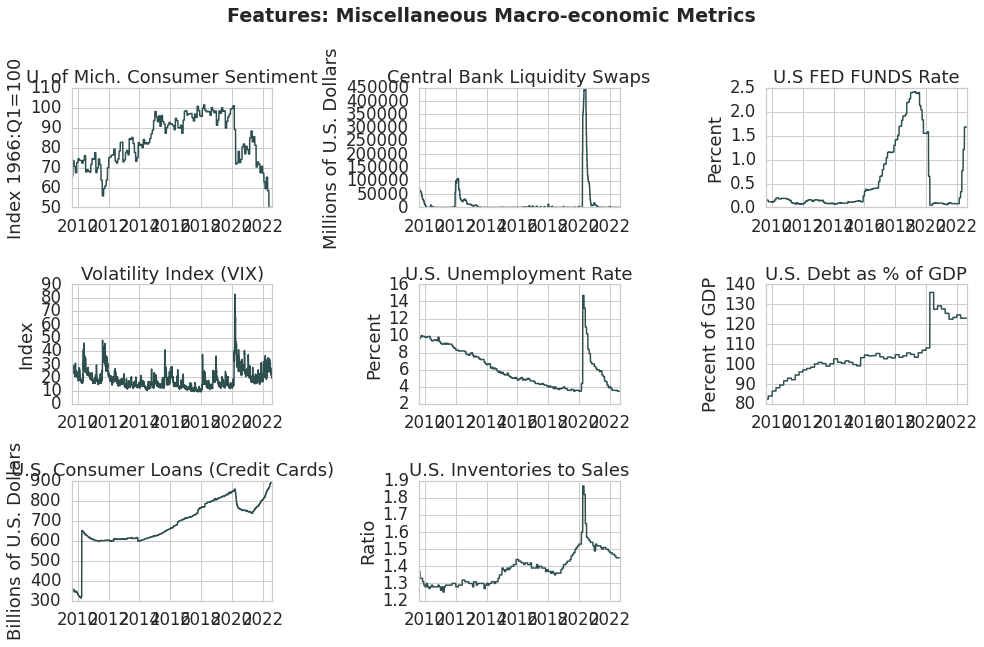

In [ ]:
# fig, axes = plt.subplots(3, 3, figsize=(17, 14))
fig, axes = plt.subplots(3, 3, figsize=(14, 8.5))
fig.suptitle('Features: Miscellaneous Macro-economic Metrics', size=19, weight='bold', y=1.05) 

# sns.lineplot(ax=axes[0, 0], color='darkslategrey', data=macro_df['UMCSENT'], x=macro_df.index, y=macro_df['UMCSENT'])
sns.lineplot(ax=axes[0, 0], color='darkslategrey', data=macro_df['UMCSENT'], x=macro_df.index, y=macro_df['UMCSENT']).set_ylabel('Index 1966:Q1=100')
sns.lineplot(ax=axes[0, 1], color='darkslategrey', data=macro_df['SWAPS'], x=macro_df.index, y=macro_df['SWAPS']).set_ylabel('Millions of U.S. Dollars')
sns.lineplot(ax=axes[0, 2], color='darkslategrey', data=macro_df['FEDFUNDS'], x=macro_df.index, y=macro_df['FEDFUNDS']).set_ylabel('Percent')

sns.lineplot(ax=axes[1, 0], color='darkslategrey', data=macro_df['VIX'], x=macro_df.index, y=macro_df['VIX']).set_ylabel('Index')
sns.lineplot(ax=axes[1, 1], color='darkslategrey', data=macro_df['UNRATE'], x=macro_df.index, y=macro_df['UNRATE']).set_ylabel('Percent')
sns.lineplot(ax=axes[1, 2], color='darkslategrey', data=macro_df['debt_to_gdp'], x=macro_df.index, y=macro_df['debt_to_gdp']).set_ylabel('Percent of GDP')

sns.lineplot(ax=axes[2, 0], color='darkslategrey', data=macro_df['consmr_loans'], x=macro_df.index, y=macro_df['consmr_loans']).set_ylabel('Billions of U.S. Dollars')
sns.lineplot(ax=axes[2, 1], color='darkslategrey', data=macro_df['inv_to_sales'], x=macro_df.index, y=macro_df['inv_to_sales']).set_ylabel('Ratio')

axes[0, 0].title.set_text('U. of Mich. Consumer Sentiment')
# axes[0, 0].set_xticklabels(labels=macro_df.index, rotation=30)
axes[0, 1].title.set_text('Central Bank Liquidity Swaps')
axes[0, 2].title.set_text('U.S FED FUNDS Rate')

axes[1, 0].title.set_text('Volatility Index (VIX)')
axes[1, 1].title.set_text('U.S. Unemployment Rate')
axes[1, 2].title.set_text('U.S. Debt as % of GDP')

axes[2, 0].title.set_text('U.S. Consumer Loans (Credit Cards)')
axes[2, 1].title.set_text('U.S. Inventories to Sales')
fig.delaxes(ax=axes[2,2])

fig.tight_layout()
# ADD line to save to google drive
# fig.savefig('/content/drive/MyDrive/___DBS_September 2021_anderskiss11/__DISSERTATION_DBS_APPLIED RESEARCH PAPER/__IMAGES & FILES_Dissertation/Macro_subplots_{}.png'.format(pkl_str),bbox_inches='tight',dpi=120)
# fig.savefig('Macro_subplots.png',bbox_inches='tight',dpi=120)
plt.show()

In [ ]:
# fig, axes = plt.subplots(3, 3, figsize=(14,10))
# # fig.suptitle('Features: Miscellaneous Macro-economic Metrics', size=19, weight='bold', y=1.05) 

# sns.lineplot(ax=axes[0, 0], color='darkslategrey', data=macro_df['UMCSENT'], x=macro_df.index, y=macro_df['UMCSENT']).set(ylabel='Index 1966:Q1=100', title='Univ. of Michigan Index of Consumer Sentiment Survey')
# sns.lineplot(ax=axes[0, 1], color='darkslategrey', data=macro_df['SWAPS'], x=macro_df.index, y=macro_df['SWAPS']).set(ylabel='Millions of U.S. Dollars', title='Central Bank Liquidity Swaps')
# sns.lineplot(ax=axes[0, 2], color='darkslategrey', data=macro_df['FEDFUNDS'], x=macro_df.index, y=macro_df['FEDFUNDS']).set(ylabel='Percent', title='U.S FED FUNDS Rate')

# sns.lineplot(ax=axes[1, 0], color='darkslategrey', data=macro_df['VIX'], x=macro_df.index, y=macro_df['VIX']).set(ylabel='Index', title='Volatility Index (VIX)')
# sns.lineplot(ax=axes[1, 1], color='darkslategrey', data=macro_df['UNRATE'], x=macro_df.index, y=macro_df['UNRATE']).set(ylabel='Percent', title='U.S. Unemployment Rate')
# sns.lineplot(ax=axes[1, 2], color='darkslategrey', data=macro_df['debt_to_gdp'], x=macro_df.index, y=macro_df['debt_to_gdp']).set(ylabel='U.S. Percent of Total Debt to GDP', title='U.S. Debt as % of GDP')

# sns.lineplot(ax=axes[2, 0], color='darkslategrey', data=macro_df['consmr_loans'], x=macro_df.index, y=macro_df['consmr_loans']).set(ylabel='Billions of U.S. Dollars', title='U.S. Consumer Loans (Credit Cards)')
# sns.lineplot(ax=axes[2, 1], color='darkslategrey', data=macro_df['inv_to_sales'], x=macro_df.index, y=macro_df['inv_to_sales']).set(ylabel='Ratio', title='U.S. Inventories to Sales')

# # Delete empty subplot
# fig.delaxes(ax=axes[2,2])

# fig.tight_layout()
# # ADD line to save to google drive
# # fig.savefig('/content/drive/MyDrive/___DBS_September 2021_anderskiss11/__DISSERTATION_DBS_APPLIED RESEARCH PAPER/__IMAGES & FILES_Dissertation/Macro_subplots_{}.png'.format(pkl_str),bbox_inches='tight',dpi=200)
# # fig.savefig('Macro_subplots.png',bbox_inches='tight',dpi=200)
# plt.show()

### **PLOT; Correlation Matrix - Bitcoin Price & Macro Indicators**

In [ ]:
plot_df_btc_macro = join_series(btc_df['BTC'], macro_df)
plot_df_btc_macro.tail(3)

BTC  UMCSENT  SWAPS  FEDFUNDS    VIX  UNRATE  debt_to_gdp  \
Date                                                                        
2022-08-31  20043.9     50.0  189.0      1.68  24.11     3.5    123.00345   
2022-09-01  20126.1     50.0  189.0      1.68  24.11     3.5    123.00345   
2022-09-02  20073.9     50.0  189.0      1.68  24.11     3.5    123.00345   

            consmr_loans  inv_to_sales  
Date                                    
2022-08-31      898.9899          1.45  
2022-09-01      898.9899          1.45  
2022-09-02      898.9899          1.45

In [ ]:
df_sanity_check(plot_df_btc_macro)

SHAPE of df is:		 (4007, 9)
NaN in df present?	 False
NaN count in df:	 0
COLUMNS in df:
	 BTC
	 UMCSENT
	 SWAPS
	 FEDFUNDS
	 VIX
	 UNRATE
	 debt_to_gdp
	 consmr_loans
	 inv_to_sales


In [ ]:
remove_nan(plot_df_btc_macro)
df_sanity_check(plot_df_btc_macro)

SHAPE of df is:		 (4007, 9)
NaN in df present?	 False
NaN count in df:	 0
COLUMNS in df:
	 BTC
	 UMCSENT
	 SWAPS
	 FEDFUNDS
	 VIX
	 UNRATE
	 debt_to_gdp
	 consmr_loans
	 inv_to_sales


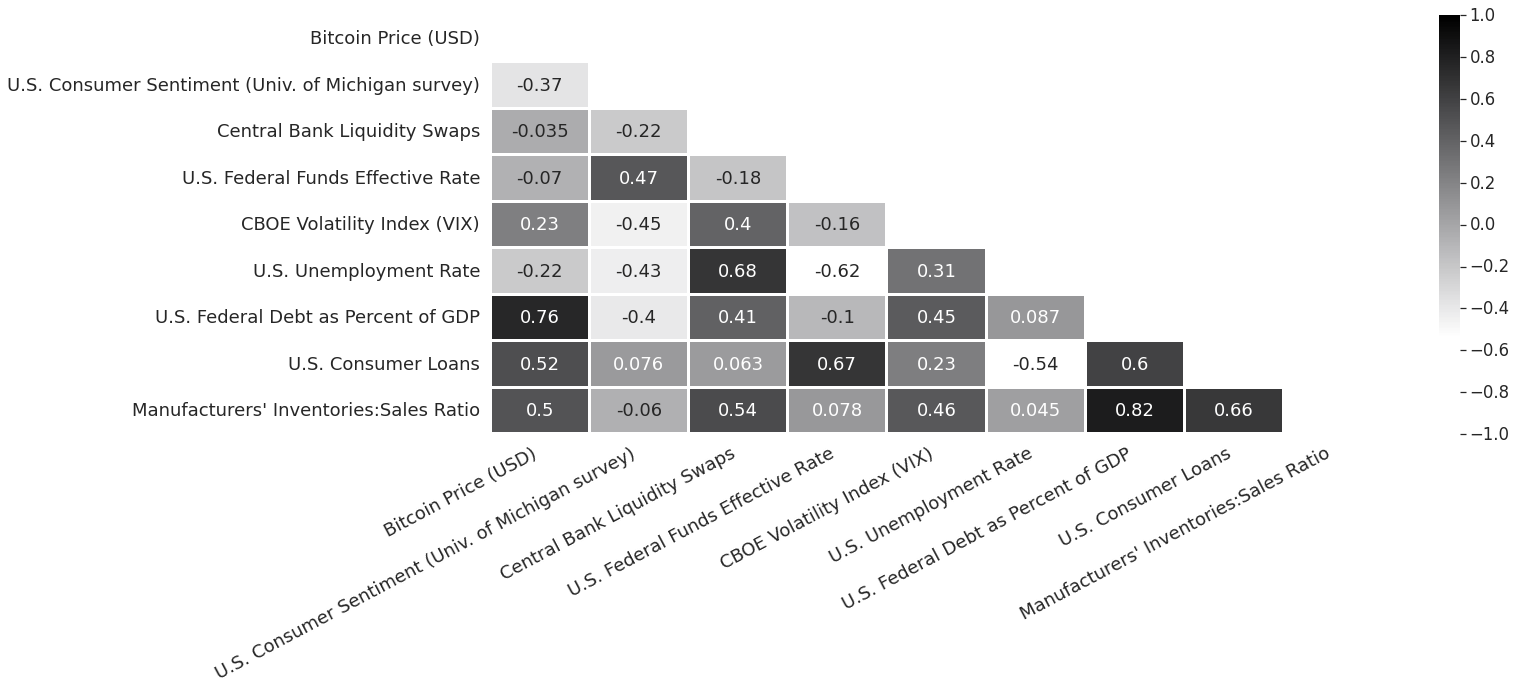

In [ ]:
plt.figure(figsize=(20, 7.5))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
corr = plot_df_btc_macro.corr()
# ESTABLISH mask for upper half of matrix only
matrix = np.triu(corr)

# BLACK & WHITE
# cmap = sns.cubehelix_palette(50, hue=0.05, rot=0, light=1.5, dark=0, as_cmap=True)
cmap = sns.cubehelix_palette(50, hue=0.033, rot=0, light=1.3, dark=0, as_cmap=True)
x_cols = ['Bitcoin Price (USD)','U.S. Consumer Sentiment (Univ. of Michigan survey)','Central Bank Liquidity Swaps','U.S. Federal Funds Effective Rate','CBOE Volatility Index (VIX)','U.S. Unemployment Rate','U.S. Federal Debt as Percent of GDP','U.S. Consumer Loans',"Manufacturers' Inventories:Sales Ratio"]
y_cols = ['Bitcoin Price (USD)','U.S. Consumer Sentiment (Univ. of Michigan survey)','Central Bank Liquidity Swaps','U.S. Federal Funds Effective Rate','CBOE Volatility Index (VIX)','U.S. Unemployment Rate','U.S. Federal Debt as Percent of GDP','U.S. Consumer Loans',"Manufacturers' Inventories:Sales Ratio"]
hm = sns.heatmap(corr,vmin=-1,vmax=1,annot=True,linewidth=2,mask=matrix,cmap=cmap,xticklabels=x_cols,yticklabels=y_cols)

# WITH COLOR
# hm = sns.heatmap(corr, vmin=-1, vmax=1, annot=True, linewidth=2, mask=matrix, cmap ='RdYlBu_r')
# hm.set_title('Correlation Matrix - Bitcoin Price & Commodities (as of {})'.format(now.strftime("%d-%b-%Y")), fontsize=20, fontdict={'fontsize':12}, pad=12)
hm.set_xticklabels(hm.get_xticklabels(),fontsize=18,rotation=28, horizontalalignment='right')
hm.set_yticklabels(hm.get_ymajorticklabels(),fontsize=18,rotation=0)
fig = hm.get_figure()
fig.savefig('/content/drive/MyDrive/___DBS_September 2021_anderskiss11/__DISSERTATION_DBS_APPLIED RESEARCH PAPER/__IMAGES & FILES_Dissertation/BTC_macro_corr_matrix_{}.png'.format(pkl_str),bbox_inches='tight',dpi=120)
# hm.savefig('BTC_macro_corr_matrix_{}.png'.format(pkl_str),bbox_inches='tight',dpi=120)

## **ESTABLISH - ALL DATASETS TO MODEL**

### **BTC DATASET**

In [ ]:
# BTC Dataset
print("BTC Dataset:\n")
df_sanity_check(btc_df)

BTC Dataset:

SHAPE of df is:		 (4003, 7)
NaN in df present?	 False
NaN count in df:	 0
COLUMNS in df:
	 BTC
	 Open
	 High
	 Low
	 BTC_vol
	 BTC_RSI
	 BTC_log


In [ ]:
btc_df.head(3)

BTC  Open  High  Low  BTC_vol    BTC_RSI    BTC_log
Date                                                           
2011-09-14  5.6   5.8   5.8  5.3    43768  31.804028  -3.509132
2011-09-15  4.8   5.6   5.6  4.4    86221  26.586215 -15.415068
2011-09-16  4.8   4.8   5.0  4.6    31651  26.586215   0.000000

In [ ]:
btc_df.to_csv(r'/content/drive/MyDrive/___DBS_September 2021_anderskiss11/__DISSERTATION_DBS_APPLIED RESEARCH PAPER/___CODE_Dissertation/_CSV/btc_df.csv', index=True, header=True)
print('Model saved to .CSV')

# btc_df = pd.read_csv(r'/content/drive/MyDrive/___DBS_September 2021_anderskiss11/__DISSERTATION_DBS_APPLIED RESEARCH PAPER/___CODE_Dissertation/_CSV/btc_df.csv').set_index('Date', inplace=True)
# btc_df.set_index('Date', inplace=True)
# print('Model loaded from .CSV')

Model saved to .CSV


In [ ]:
btc_df.head(3)

BTC  Open  High  Low  BTC_vol    BTC_RSI    BTC_log
Date                                                           
2011-09-14  5.6   5.8   5.8  5.3    43768  31.804028  -3.509132
2011-09-15  4.8   5.6   5.6  4.4    86221  26.586215 -15.415068
2011-09-16  4.8   4.8   5.0  4.6    31651  26.586215   0.000000

### **BTC + BONDS & INDICES DATASET**

In [ ]:
df_sanity_check(bonds_indices_df)

SHAPE of df is:		 (4016, 14)
NaN in df present?	 False
NaN count in df:	 0
COLUMNS in df:
	 US02Y
	 US10Y
	 US10Y2Y
	 JP02Y
	 IT02Y
	 DE02Y
	 SPX
	 NDX
	 DXY
	 Housing_Units
	 Case-Shiller
	 Consumer-Discr.
	 CPI
	 PPI


In [ ]:
bonds_indices_df.head(3)

US02Y  US10Y  US10Y2Y  JP02Y  IT02Y  DE02Y      SPX      NDX  \
2011-09-01  0.184  2.132     1.96  0.151  3.486  0.655  1204.42  2219.05   
2011-09-02  0.204  1.994     1.82  0.145  3.592  0.545  1173.97  2167.83   
2011-09-03  0.204  1.994     1.82  0.145  3.610  0.545  1173.97  2167.83   

              DXY  Housing_Units  Case-Shiller  Consumer-Discr.       CPI  \
2011-09-01  74.48          610.0       138.667            37.11  1.726814   
2011-09-02  74.76          610.0       138.667            36.06  1.726814   
2011-09-03  74.76          610.0       138.667            36.06  1.726814   

              PPI  
2011-09-01  203.7  
2011-09-02  203.7  
2011-09-03  203.7

In [ ]:
# BTC + BONDS & INDICES Dataset
btc_bonds_indices_df_to_model = pd.DataFrame()
btc_bonds_indices_df_to_model = merge_dataframes(btc_df, bonds_indices_df['NDX'])
btc_bonds_indices_df_to_model.head(3)

BTC  Open  High  Low  BTC_vol  BTC_RSI  BTC_log      NDX
2011-09-01 00:00:00  NaN   NaN   NaN  NaN      NaN      NaN      NaN  2219.05
2011-09-02 00:00:00  NaN   NaN   NaN  NaN      NaN      NaN      NaN  2167.83
2011-09-03 00:00:00  NaN   NaN   NaN  NaN      NaN      NaN      NaN  2167.83

In [ ]:
remove_nan(btc_bonds_indices_df_to_model)
df_sanity_check(btc_bonds_indices_df_to_model)

SHAPE of df is:		 (4003, 8)
NaN in df present?	 False
NaN count in df:	 0
COLUMNS in df:
	 BTC
	 Open
	 High
	 Low
	 BTC_vol
	 BTC_RSI
	 BTC_log
	 NDX


In [ ]:
btc_bonds_indices_df_to_model.head(3)

BTC  Open  High  Low  BTC_vol    BTC_RSI    BTC_log       NDX
2011-09-14  5.6   5.8   5.8  5.3  43768.0  31.804028  -3.509132  12484.32
2011-09-15  4.8   5.6   5.6  4.4  86221.0  26.586215 -15.415068  12484.32
2011-09-16  4.8   4.8   5.0  4.6  31651.0  26.586215   0.000000  12484.32

In [ ]:
# change index from type 'RangeIndex' to 'Datetimeindex'

print(type(btc_bonds_indices_df_to_model.index))
btc_bonds_indices_df_to_model = btc_bonds_indices_df_to_model.set_index(pd.to_datetime(btc_bonds_indices_df_to_model.index))
print(type(btc_bonds_indices_df_to_model.index))


pandas.core.indexes.datetimes.DatetimeIndex

In [ ]:
btc_bonds_indices_df_to_model.head(3)

BTC  Open  High  Low  BTC_vol    BTC_RSI    BTC_log       NDX
2011-09-14  5.6   5.8   5.8  5.3  43768.0  31.804028  -3.509132  12484.32
2011-09-15  4.8   5.6   5.6  4.4  86221.0  26.586215 -15.415068  12484.32
2011-09-16  4.8   4.8   5.0  4.6  31651.0  26.586215   0.000000  12484.32

In [ ]:
# btc_bonds_indices_df_to_model.to_csv(r'/content/drive/MyDrive/___DBS_September 2021_anderskiss11/__DISSERTATION_DBS_APPLIED RESEARCH PAPER/___CODE_Dissertation/_CSV/btc_bonds_indices_df_to_model.csv',index=True,header=True,date_format="%Y-%m-%d")
# print('Model saved to .CSV')

btc_bonds_indices_df_to_model = pd.read_csv(r'/content/drive/MyDrive/___DBS_September 2021_anderskiss11/__DISSERTATION_DBS_APPLIED RESEARCH PAPER/___CODE_Dissertation/_CSV/btc_bonds_indices_df_to_model.csv',index_col=0)
print(type(btc_bonds_indices_df_to_model.index))
btc_bonds_indices_df_to_model = btc_bonds_indices_df_to_model.set_index(pd.to_datetime(btc_bonds_indices_df_to_model.index))
print(type(btc_bonds_indices_df_to_model.index))
print('Model loaded from .CSV')

btc_bonds_indices_df_to_model.head(3)

<class 'pandas.core.indexes.base.Index'>
<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


BTC  Open  High  Low  BTC_vol    BTC_RSI    BTC_log       NDX
2011-09-14  5.6   5.8   5.8  5.3  43768.0  31.804028  -3.509132  12484.32
2011-09-15  4.8   5.6   5.6  4.4  86221.0  26.586215 -15.415068  12484.32
2011-09-16  4.8   4.8   5.0  4.6  31651.0  26.586215   0.000000  12484.32

### **BTC + COMMODITIES DATASET**

In [ ]:
# BTC + Commodities Dataset
btc_comm_df_to_model = merge_dataframes(btc_df_v2, commodities_df)
df_sanity_check(btc_comm_df_to_model)

SHAPE of df is:		 (4016, 14)
NaN in df present?	 True
NaN count in df:	 91
COLUMNS in df:
	 BTC
	 Open
	 High
	 Low
	 BTC_vol
	 BTC_RSI
	 BTC_log
	 gold
	 wheat
	 gas
	 lumber
	 oil
	 copper
	 nickel


In [ ]:
remove_nan(btc_comm_df_to_model)
df_sanity_check(btc_comm_df_to_model)

SHAPE of df is:		 (4003, 14)
NaN in df present?	 False
NaN count in df:	 0
COLUMNS in df:
	 BTC
	 Open
	 High
	 Low
	 BTC_vol
	 BTC_RSI
	 BTC_log
	 gold
	 wheat
	 gas
	 lumber
	 oil
	 copper
	 nickel


In [ ]:
btc_comm_df_to_model.to_csv(r'/content/drive/MyDrive/___DBS_September 2021_anderskiss11/__DISSERTATION_DBS_APPLIED RESEARCH PAPER/___CODE_Dissertation/_CSV/btc_comm_df_to_model.csv',index=True,header=True,date_format="%Y-%m-%d")
print('Model saved to .CSV')

# btc_comm_df_to_model = pd.read_csv(r'/content/drive/MyDrive/___DBS_September 2021_anderskiss11/__DISSERTATION_DBS_APPLIED RESEARCH PAPER/___CODE_Dissertation/_CSV/btc_comm_df_to_model.csv',index_col=0)
# print(type(btc_comm_df_to_model.index))
# btc_comm_df_to_model = btc_comm_df_to_model.set_index(pd.to_datetime(btc_comm_df_to_model.index))
# print(type(btc_comm_df_to_model.index))
# print('Model loaded from .CSV')

# btc_comm_df_to_model.head(3)



Model saved to .CSV


### **BTC + MACRO DATASET**

In [ ]:
# BTC + Macro Dataset
btc_macro_df_to_model = merge_dataframes(btc_df,macro_df['debt_to_gdp'])
df_sanity_check(btc_macro_df_to_model)

SHAPE of df is:		 (4777, 8)
NaN in df present?	 True
NaN count in df:	 5390
COLUMNS in df:
	 BTC
	 Open
	 High
	 Low
	 BTC_vol
	 BTC_RSI
	 BTC_log
	 debt_to_gdp


In [ ]:
remove_nan(btc_macro_df_to_model)
df_sanity_check(btc_macro_df_to_model)

SHAPE of df is:		 (4007, 8)
NaN in df present?	 False
NaN count in df:	 0
COLUMNS in df:
	 BTC
	 Open
	 High
	 Low
	 BTC_vol
	 BTC_RSI
	 BTC_log
	 debt_to_gdp


In [ ]:
btc_macro_df_to_model.head(3)

BTC  Open  High  Low  BTC_vol    BTC_RSI    BTC_log  debt_to_gdp
2011-09-14  5.6   5.8   5.8  5.3  43768.0  31.804028  -3.509132     94.52097
2011-09-15  4.8   5.6   5.6  4.4  86221.0  26.586215 -15.415068     94.52097
2011-09-16  4.8   4.8   5.0  4.6  31651.0  26.586215   0.000000     94.52097

In [ ]:
# btc_macro_df_to_model.to_csv(r'/content/drive/MyDrive/___DBS_September 2021_anderskiss11/__DISSERTATION_DBS_APPLIED RESEARCH PAPER/___CODE_Dissertation/_CSV/btc_macro_df_to_model.csv',index=True,header=True,date_format="%Y-%m-%d")
btc_macro_df_to_model.to_csv(r'/content/drive/MyDrive/___DBS_September 2021_anderskiss11/__DISSERTATION_DBS_APPLIED RESEARCH PAPER/___CODE_Dissertation/_CSV/btc_macro_df_to_model.csv',header=True,date_format="%Y-%m-%d")
print('Model saved to .CSV')

Model saved to .CSV


In [ ]:
btc_macro_df_to_model = pd.read_csv(r'/content/drive/MyDrive/___DBS_September 2021_anderskiss11/__DISSERTATION_DBS_APPLIED RESEARCH PAPER/___CODE_Dissertation/_CSV/btc_macro_df_to_model.csv',index_col=0)
print('Model loaded from .CSV')

print(type(btc_macro_df_to_model.index))
btc_macro_df_to_model = btc_macro_df_to_model.set_index(pd.to_datetime(btc_macro_df_to_model.index))
print(type(btc_macro_df_to_model.index))

btc_macro_df_to_model.head(3)

Model loaded from .CSV
<class 'pandas.core.indexes.base.Index'>
<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


BTC  Open  High  Low  BTC_vol    BTC_RSI    BTC_log  debt_to_gdp
2011-09-14  5.6   5.8   5.8  5.3  43768.0  31.804028  -3.509132     94.52097
2011-09-15  4.8   5.6   5.6  4.4  86221.0  26.586215 -15.415068     94.52097
2011-09-16  4.8   4.8   5.0  4.6  31651.0  26.586215   0.000000     94.52097

### **BTC + NDX + lumber + debt_to_gdp**

In [ ]:
# btc_df
# bonds_indices_df
# macro_df
# commodities_df

# combined_macro_df = pd.DataFrame()
combined_macro_df = merge_dataframes(btc_df, bonds_indices_df['NDX'])
combined_macro_df = merge_dataframes(combined_macro_df, macro_df['debt_to_gdp'])
combined_macro_df = merge_dataframes(combined_macro_df, commodities_df['lumber'])

In [ ]:
df_sanity_check(combined_macro_df)

SHAPE of df is:		 (4773, 10)
NaN in df present?	 True
NaN count in df:	 6904
COLUMNS in df:
	 BTC
	 Open
	 High
	 Low
	 BTC_vol
	 BTC_RSI
	 BTC_log
	 NDX
	 debt_to_gdp
	 lumber


In [ ]:
remove_nan(combined_macro_df)
df_sanity_check(combined_macro_df)

SHAPE of df is:		 (4003, 10)
NaN in df present?	 False
NaN count in df:	 0
COLUMNS in df:
	 BTC
	 Open
	 High
	 Low
	 BTC_vol
	 BTC_RSI
	 BTC_log
	 NDX
	 debt_to_gdp
	 lumber


In [ ]:
combined_macro_df.to_csv(r'/content/drive/MyDrive/___DBS_September 2021_anderskiss11/__DISSERTATION_DBS_APPLIED RESEARCH PAPER/___CODE_Dissertation/_CSV/combined_macro_df.csv',header=True,date_format="%Y-%m-%d")
print('Model saved to .CSV')

Model saved to .CSV


In [ ]:
combined_macro_df = pd.read_csv(r'/content/drive/MyDrive/___DBS_September 2021_anderskiss11/__DISSERTATION_DBS_APPLIED RESEARCH PAPER/___CODE_Dissertation/_CSV/combined_macro_df.csv',index_col=0)

print('Model loaded from .CSV')
print(type(combined_macro_df.index))
combined_macro_df = combined_macro_df.set_index(pd.to_datetime(combined_macro_df.index))
print(type(combined_macro_df.index))

combined_macro_df.head(3)

Model loaded from .CSV
<class 'pandas.core.indexes.base.Index'>
<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


BTC  Open  High  Low  BTC_vol    BTC_RSI    BTC_log      NDX  \
2011-09-14  5.6   5.8   5.8  5.3  43768.0  31.804028  -3.509132  2252.75   
2011-09-15  4.8   5.6   5.6  4.4  86221.0  26.586215 -15.415068  2286.56   
2011-09-16  4.8   4.8   5.0  4.6  31651.0  26.586215   0.000000  2306.09   

            debt_to_gdp  lumber  
2011-09-14     94.52097   237.2  
2011-09-15     94.52097   244.2  
2011-09-16     94.52097   244.6

### **ALL DATASETS COMBINED**

In [ ]:
# btc_df
# bonds_indices_df
# macro_df
# commodities_df

all_combined = merge_dataframes(btc_df, bonds_indices_df)
all_combined = merge_dataframes(all_combined, macro_df)
all_combined = merge_dataframes(all_combined, commodities_df)
df_sanity_check(all_combined)

SHAPE of df is:		 (4016, 36)
NaN in df present?	 True
NaN count in df:	 139
COLUMNS in df:
	 BTC
	 Open
	 High
	 Low
	 BTC_vol
	 BTC_RSI
	 BTC_log
	 US02Y
	 US10Y
	 US10Y2Y
	 JP02Y
	 IT02Y
	 DE02Y
	 SPX
	 NDX
	 DXY
	 Housing_Units
	 Case-Shiller
	 Consumer-Discr.
	 CPI
	 PPI
	 UMCSENT
	 SWAPS
	 FEDFUNDS
	 VIX
	 UNRATE
	 debt_to_gdp
	 consmr_loans
	 inv_to_sales
	 gold
	 wheat
	 gas
	 lumber
	 oil
	 copper
	 nickel


In [ ]:
remove_nan(all_combined)
df_sanity_check(all_combined)

SHAPE of df is:		 (4003, 36)
NaN in df present?	 False
NaN count in df:	 0
COLUMNS in df:
	 BTC
	 Open
	 High
	 Low
	 BTC_vol
	 BTC_RSI
	 BTC_log
	 US02Y
	 US10Y
	 US10Y2Y
	 JP02Y
	 IT02Y
	 DE02Y
	 SPX
	 NDX
	 DXY
	 Housing_Units
	 Case-Shiller
	 Consumer-Discr.
	 CPI
	 PPI
	 UMCSENT
	 SWAPS
	 FEDFUNDS
	 VIX
	 UNRATE
	 debt_to_gdp
	 consmr_loans
	 inv_to_sales
	 gold
	 wheat
	 gas
	 lumber
	 oil
	 copper
	 nickel


In [ ]:
all_combined.to_csv(r'/content/drive/MyDrive/___DBS_September 2021_anderskiss11/__DISSERTATION_DBS_APPLIED RESEARCH PAPER/___CODE_Dissertation/_CSV/all_combined.csv',index=True,header=True)
print('Model saved to .CSV')


all_combined = pd.read_csv(r'/content/drive/MyDrive/___DBS_September 2021_anderskiss11/__DISSERTATION_DBS_APPLIED RESEARCH PAPER/___CODE_Dissertation/_CSV/all_combined.csv',index_col=0)
print(type(all_combined.index))
all_combined = all_combined.set_index(pd.to_datetime(all_combined.index))
print(type(all_combined.index))
print('Model loaded from .CSV')

all_combined.head(3)




Model loaded from .CSV


In [ ]:
vals = ['Model_name','Model_Type','Model_Dataset','Samples (lookback)','Total params','Train_Split','Model_Epochs','Hidden_Layers','Hidden_Neurons','RMSE_train_score','RMSE_test_score','MAPE','Accuracy (%)']
all_eval_df = pd.DataFrame(columns=vals)

print('\nRows in "all_eval_df:"\t',len(all_eval_df.index),'\n')
all_eval_df.head(3)


Rows in "all_eval_df:"	 0 



Empty DataFrame
Columns: [Model_name, Model_Type, Model_Dataset, Samples (lookback), Total params, Train_Split, Model_Epochs, Hidden_Layers, Hidden_Neurons, RMSE_train_score, RMSE_test_score, MAPE, Accuracy (%)]
Index: []

# **MODELING**

## **LSTM's**

In [ ]:
btc_df_to_model = pd.read_pickle("/content/drive/MyDrive/___DBS_September 2021_anderskiss11/__DISSERTATION_DBS_APPLIED RESEARCH PAPER/__IMAGES & FILES_Dissertation/btc_df_23Aug2022_0749.pkl")
print(len(btc_df_to_model))
btc_df_to_model.head(3)

4420


BTC  BTC_vol  BTC_50D_VOL_SMA  BTC_50D_SMA  BTC_100D_SMA  BTC_RSI  \
Date                                                                            
2010-07-18  0.1       75              NaN          NaN           NaN      NaN   
2010-07-19  0.1      574              NaN          NaN           NaN      NaN   
2010-07-20  0.1      262              NaN          NaN           NaN      NaN   

            BTC_MACD  BTC_MACD_signal  BTC_log  
Date                                            
2010-07-18       NaN              NaN      NaN  
2010-07-19       NaN              NaN      0.0  
2010-07-20       NaN              NaN      0.0

### **lstm_model_01 - LSTM Baseline (samples=45 days)**

#### **COPY dataset**

In [ ]:
btc_df_v2 = btc_df.copy(deep=True)
btc_df_v2.head(3)

BTC  Open  High  Low  BTC_vol    BTC_RSI    BTC_log
Date                                                           
2011-09-14  5.6   5.8   5.8  5.3    43768  31.804028  -3.509132
2011-09-15  4.8   5.6   5.6  4.4    86221  26.586215 -15.415068
2011-09-16  4.8   4.8   5.0  4.6    31651  26.586215   0.000000

In [ ]:
df_sanity_check(btc_df_v2)

SHAPE of df is:		 (4007, 7)
NaN in df present?	 False
NaN count in df:	 0
COLUMNS in df:
	 BTC
	 Open
	 High
	 Low
	 BTC_vol
	 BTC_RSI
	 BTC_log


In [ ]:
df_dates = pd.to_datetime(btc_df_v2.index)
df_dates[:3]

DatetimeIndex(['2011-09-14', '2011-09-15', '2011-09-16'], dtype='datetime64[ns]', name='Date', freq=None)

In [ ]:
# CONVERT dates from DatetimeIndex object to Series
date_range = df_dates.to_series()
print(type(date_range))
date_range[-3:]

<class 'pandas.core.series.Series'>


Date
2022-08-31   2022-08-31
2022-09-01   2022-09-01
2022-09-02   2022-09-02
Name: Date, dtype: datetime64[ns]

In [ ]:
date_range.shape

(4007,)

#### **SCALE data**

In [ ]:
# SCALE data
# for multivariate example
cols = btc_df_v2.columns
x = btc_df_v2.values #returns a numpy array

# MINMAX Scaler
min_max_scaler = MinMaxScaler()
scaled_data = min_max_scaler.fit_transform(btc_df_v2)
scaled_data
# Standard Scaler
# stnd_scaler = StandardScaler()
# scaled_data = stnd_scaler.fit_transform(btc_df_v2)
# scaled_data

array([[5.33128770e-05, 5.62740368e-05, 5.07332403e-05, ...,
        9.73527780e-06, 2.52914840e-01, 3.50294611e-01],
       [4.14655710e-05, 5.33122454e-05, 4.78341980e-05, ...,
        1.92353640e-05, 1.92181695e-01, 2.99042383e-01],
       [4.14655710e-05, 4.14650797e-05, 3.91370711e-05, ...,
        7.02374872e-06, 1.92181695e-01, 3.65400591e-01],
       ...,
       [2.96803153e-01, 2.93089993e-01, 2.96670595e-01, ...,
        7.11397638e-05, 3.12470281e-01, 3.70831797e-01],
       [2.98020463e-01, 2.96888490e-01, 2.92809071e-01, ...,
        6.14978018e-05, 3.22418259e-01, 3.67162363e-01],
       [2.97247427e-01, 2.98098382e-01, 2.93832432e-01, ...,
        5.66487365e-05, 3.18381493e-01, 3.64282637e-01]])

In [ ]:
btc_df2_scaled = pd.DataFrame(scaled_data)
btc_df2_scaled.columns = cols
btc_df2_scaled.index = date_range
btc_df2_scaled.head(3)

BTC      Open      High       Low   BTC_vol   BTC_RSI  \
Date                                                                     
2011-09-14  0.000053  0.000056  0.000051  0.000050  0.000010  0.252915   
2011-09-15  0.000041  0.000053  0.000048  0.000036  0.000019  0.192182   
2011-09-16  0.000041  0.000041  0.000039  0.000039  0.000007  0.192182   

             BTC_log  
Date                  
2011-09-14  0.350295  
2011-09-15  0.299042  
2011-09-16  0.365401

In [ ]:
# VERIFY data shape
btc_df2_scaled.shape

(4007, 7)

In [ ]:
btc_df2_scaled.iloc[:3, :1]

BTC
Date                
2011-09-14  0.000053
2011-09-15  0.000041
2011-09-16  0.000041

#### **RESHAPE data**
**shapes includes: sample, time steps, features**

In [ ]:
# models need data in the form [sample, timesteps, features]

samples = 45 # samples
steps = 1 # timesteps
X = []
Y = []
for i in range(btc_df2_scaled.shape[0] - samples):
    # ENSURE INDEX RANGE for X matches input range 
    # use Open,High,Low to predict Close
    X.append(btc_df2_scaled.iloc[i:i+samples, 1:].values) # Independent Samples
    Y.append(btc_df2_scaled.iloc[i+samples, :1].values) # Dependent Samples
print('Training Data length:',len(X[0:1][0]),'\n', X[0:1])
print('\nTesting Data length:', len(Y[0:1]),'\n', Y[0:1])

Training Data length: 45 
 [array([[5.62740368e-05, 5.07332403e-05, 4.97490687e-05, 9.73527780e-06,
        2.52914840e-01, 3.50294611e-01],
       [5.33122454e-05, 4.78341980e-05, 3.61811409e-05, 1.92353640e-05,
        1.92181695e-01, 2.99042383e-01],
       [4.14650797e-05, 3.91370711e-05, 3.91962360e-05, 7.02374872e-06,
        1.92181695e-01, 3.65400591e-01],
       [4.14650797e-05, 3.76875499e-05, 4.07037835e-05, 4.48430562e-06,
        1.92181695e-01, 3.65400591e-01],
       [4.14650797e-05, 4.78341980e-05, 4.07037835e-05, 9.92683255e-06,
        2.71593434e-01, 3.99857076e-01],
       [4.73886626e-05, 4.78341980e-05, 4.37188786e-05, 1.10933920e-05,
        3.25710822e-01, 3.89545775e-01],
       [5.18313497e-05, 6.52284518e-05, 5.12566162e-05, 2.60673342e-05,
        4.19959672e-01, 4.09972395e-01],
       [6.07167239e-05, 5.79808460e-05, 4.67339736e-05, 1.51945881e-05,
        3.63551401e-01, 3.28585325e-01],
       [5.33122454e-05, 5.07332403e-05, 4.97490687e-05, 7.02374872e-

In [ ]:
type(X )

list

In [ ]:
# Convert data from list to array for modeling
print("Original datatype for X is:\t", type(X))
print("- - - - - - - - - - - - - - - - - - - - -")
X = np.array(X)
Y = np.array(Y)
print("Converted datatype for X is:\t", type(X))
print('\nX Shape: ', X.shape, '\nY Shape: ', Y.shape)

Original datatype for X is:	 <class 'list'>
- - - - - - - - - - - - - - - - - - - - -
Converted datatype for X is:	 <class 'numpy.ndarray'>

X Shape:  (3962, 45, 6) 
Y Shape:  (3962, 1)


In [ ]:
# ESTABLISH training and testing sets
split_data = round(0.7 * X.shape[0])
trainX, trainY = X[:split_data], Y[:split_data]
testX, testY =  X[split_data:], Y[split_data:]
print('Train Set (input and output arrays):\n','TRAIN INPUTS: ',trainX.shape,'\t\tTRAIN OUTPUT: ',trainY.shape,'\n\nTest Set (input and output arrays):\n','TEST INPUTS: ',testX.shape,'\t\tTEST OUTPUT: ', testY.shape)

Train Set (input and output arrays):
 TRAIN INPUTS:  (2773, 45, 6) 		TRAIN OUTPUT:  (2773, 1) 

Test Set (input and output arrays):
 TEST INPUTS:  (1189, 45, 6) 		TEST OUTPUT:  (1189, 1)


#### **BUILD / TRAIN / SAVE Model**

In [ ]:
# VERIFY that the same train/test sets are used
# Reshaped data
print('X Shape: ', X.shape, '\nY Shape: ', Y.shape)

X Shape:  (3962, 45, 6) 
Y Shape:  (3962, 1)


In [ ]:
# VERIFY training and testing sets
print("\n# # # SPLIT DATASETS: # # #\n")
print('Train Set Input:',trainX.shape,'\t\tTrain Set Output:', trainY.shape)
print("\n- - - - - - - - - - - - -\n")      
print('\nTest Set Input:',testX.shape,'\t\tTest Set Output:', testY.shape)


# # # SPLIT DATASETS: # # #

Train Set Input: (2773, 45, 6) 		Train Set Output: (2773, 1)

- - - - - - - - - - - - -


Test Set Input: (1189, 45, 6) 		Test Set Output: (1189, 1)


In [ ]:
# BUILD the LSTM
lstm_model_01 = keras.Sequential()
lstm_model_01.add(layers.LSTM(16,
                         input_shape=(trainX.shape[1], trainX.shape[2])))

# Add a Dense layer with 1 units
lstm_model_01.add(layers.Dense(1))
lstm_model_01.compile(optimizer='adam',loss='mean_squared_error',metrics='MeanSquaredError')
lstm_model_01.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 16)                1472      
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 1,489
Trainable params: 1,489
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# fit the model
history = lstm_model_01.fit(trainX,
                        trainY,
                        shuffle = False, 
                        epochs=50,
                        batch_size=15,
                        validation_split=0.2,
                        verbose=1)

# pickle.dump(lstm_model_01, open("/content/drive/MyDrive/___DBS_September 2021_anderskiss11/__DISSERTATION_DBS_APPLIED RESEARCH PAPER/___CODE_Dissertation/_MODELS/lstm_model_01_{}.pkl".format(pkl_str), "wb"))
# lstm_model_01 = pickle.load(open('/content/drive/MyDrive/___DBS_September 2021_anderskiss11/__DISSERTATION_DBS_APPLIED RESEARCH PAPER/___CODE_Dissertation/_MODELS/lstm_model_01_____.pk', 'rb'))
print("\nModel:\tlstm_model_01 successfully saved to .pkl file")

Epoch 1/50
148/148 [==============================] - 3s 21ms/step - loss: 3.3968e-06 - mean_squared_error: 3.3968e-06 - val_loss: 1.9355e-04 - val_mean_squared_error: 1.9355e-04
Epoch 2/50
148/148 [==============================] - 3s 21ms/step - loss: 4.9871e-06 - mean_squared_error: 4.9871e-06 - val_loss: 2.1327e-04 - val_mean_squared_error: 2.1327e-04
Epoch 3/50
148/148 [==============================] - 3s 21ms/step - loss: 4.3818e-06 - mean_squared_error: 4.3818e-06 - val_loss: 2.3213e-04 - val_mean_squared_error: 2.3213e-04
Epoch 4/50
148/148 [==============================] - 4s 29ms/step - loss: 5.5273e-06 - mean_squared_error: 5.5273e-06 - val_loss: 2.4357e-04 - val_mean_squared_error: 2.4357e-04
Epoch 5/50
148/148 [==============================] - 3s 23ms/step - loss: 5.5737e-06 - mean_squared_error: 5.5737e-06 - val_loss: 2.3931e-04 - val_mean_squared_error: 2.3931e-04
Epoch 6/50
148/148 [==============================] - 3s 21ms/step - loss: 5.4831e-06 - mean_squared_erro

In [ ]:
# model_08_v2 = pickle.load(open("/content/drive/MyDrive/___DBS_September 2021_anderskiss11/__DISSERTATION_DBS_APPLIED RESEARCH PAPER/___CODE_Dissertation/_MODELS/_____.pkl", "rb"))
# print("model_08_v2 successfully loaded!")

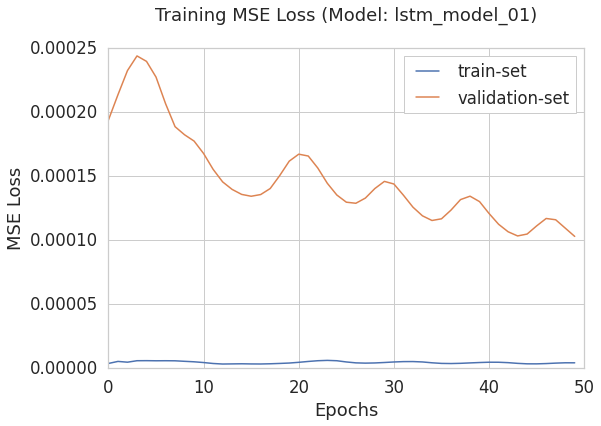

In [ ]:
# Plotting the loss 
plt.figure(figsize=(8.7,6.3))
plt.title('Training MSE Loss (Model: lstm_model_01)',fontsize=18,y=1.07)
plt.plot(history.history['loss'], label = 'train-set')
plt.plot(history.history['val_loss'], label ='validation-set')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.tight_layout()
plt.legend()
# Save image with proper modelname
# plt.savefig('/content/drive/MyDrive/___DBS_September 2021_anderskiss11/__DISSERTATION_DBS_APPLIED RESEARCH PAPER/__IMAGES & FILES_Dissertation/lstm_model_01_loss_{}.png'.format(pkl_str),bbox_inches='tight',dpi=120)
# plt.savefig('lstm_model_01_loss_.png'.format(pkl_str), bbox_inches='tight', dpi=120)

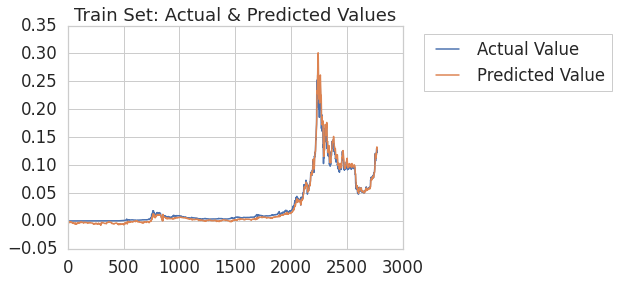

In [ ]:
# This is a one step forecast
y_pred_train = lstm_model_01.predict(trainX)
plt.title('Train Set: Actual & Predicted Values')
plt.plot(trainY, label = 'Actual Value')
plt.plot(y_pred_train, label = 'Predicted Value')
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
# plt.legend(loc="upper left")
# plt.legend()

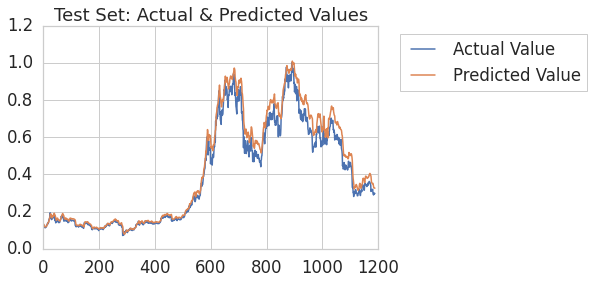

In [ ]:
# This is a one step forecast
y_pred = lstm_model_01.predict(testX)
plt.title('Test Set: Actual & Predicted Values')
plt.plot(testY, label = 'Actual Value')
plt.plot(y_pred, label = 'Predicted Value')
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
# plt.legend(loc="upper left")
# plt.legend()

#### **EVALUATION Metric**

In [ ]:
# Measure RMSE error
lstm_model_01_rmse_train = np.sqrt(metrics.mean_squared_error(y_pred_train,trainY)).round(5)
lstm_model_01_rmse_test = np.sqrt(metrics.mean_squared_error(y_pred,testY)).round(5)
print("Train RMSE:\t{}".format(lstm_model_01_rmse_train), "\nTest RMSE:\t{}".format(lstm_model_01_rmse_test))
# CALCULATE Mean Absolute Percentage Error (MAPE)
lstm_model_01_mape = (np.mean(np.abs((testY - y_pred) / testY)) * 100).round(2)
lstm_model_01_acc = (100 - lstm_model_01_mape).round(2)

print("\nMAPE:\t\t{}".format(lstm_model_01_mape), "\nModel Accuracy:\t{}%\n".format(lstm_model_01_acc))

Train RMSE:	0.00571 
Test RMSE:	0.05195

MAPE:		8.38 
Model Accuracy:	91.62%



#### **STORE Data**

In [ ]:
# STORE model information and evaluation metrics in a dictionary
lstm_model_01_dict = {
                    'Model_name': 'lstm_model_01',
                    'Model_Type': 'LSTM',
                    'Model_Dataset': 'BTC only',
                    'Samples (lookback)': samples,
                    'Total params' : 1489,
                    'Train_Split': '70%',
                    'Model_Epochs': 50,
                    'Hidden_Layers': '1L',
                    'Hidden_Neurons': '16 (1L)',
                    'RMSE_train_score':lstm_model_01_rmse_train,
                    'RMSE_test_score':lstm_model_01_rmse_test,
                    'MAPE':lstm_model_01_mape,
                    'Accuracy (%)':lstm_model_01_acc
                    }
lstm_model_01_dict

# DELETE
# plt.savefig('/content/drive/MyDrive/___DBS_September 2021_anderskiss11/__DISSERTATION_DBS_APPLIED RESEARCH PAPER/__IMAGES & FILES_Dissertation/lstm_model_01_loss_{}.png'.format(pkl_str),bbox_inches='tight',dpi=120)
# plt.savefig('lstm_model_01_loss_.png'.format(pkl_str), bbox_inches='tight', dpi=120)

{'Model_name': 'lstm_model_01',
 'Model_Type': 'LSTM',
 'Model_Dataset': 'BTC only',
 'Samples (lookback)': 45,
 'Total params': 1489,
 'Train_Split': '70%',
 'Model_Epochs': 50,
 'Hidden_Layers': '1L',
 'Hidden_Neurons': '16 (1L)',
 'RMSE_train_score': 0.00571,
 'RMSE_test_score': 0.05195,
 'MAPE': 8.38,
 'Accuracy (%)': 91.62}

In [ ]:
# all_eval_df.drop([1,2,3,4], inplace=True)
all_eval_df = add_eval_dict(lstm_model_01_dict,all_eval_df)
all_eval_df.head()

Model_name Model_Type Model_Dataset Samples (lookback) Total params  \
0  lstm_model_01       LSTM      BTC only                 45         1489   

  Train_Split Model_Epochs Hidden_Layers Hidden_Neurons  RMSE_train_score  \
0         70%           50            1L        16 (1L)           0.00583   

   RMSE_test_score  MAPE  Accuracy (%)  
0          0.03688  6.99         93.01

In [ ]:
# all_eval_df.to_pickle('/content/drive/MyDrive/___DBS_September 2021_anderskiss11/__DISSERTATION_DBS_APPLIED RESEARCH PAPER/__IMAGES & FILES_Dissertation/lstm_model_01_eval_metrics_{}.pkl'.format(pkl_str))
print("Dataframe saved to .pkl")

# all_eval_df = pickle.load(open('/content/drive/MyDrive/___DBS_September 2021_anderskiss11/__DISSERTATION_DBS_APPLIED RESEARCH PAPER/__IMAGES & FILES_Dissertation/lstm_model_01_eval_metrics_29Aug2022_0818.pkl', 'rb'))
# all_eval_df.head()

Dataframe saved to .pkl


#### **MAKE Prediction**

In [ ]:
# MAKE FORECAST PREDICTION
forecast = lstm_model_01.predict(X[-samples:])
print(len(forecast))

# MAKE COPIES OF PREDICTED VALUE IN ORDER TO MATCH THE EXPECTED SHAPE WHEN INVERSING
forecast_copies = np.repeat(forecast, btc_df_v2.shape[1], axis=-1)
print(forecast_copies)

45
[[0.36432186 0.36432186 0.36432186 0.36432186 0.36432186 0.36432186
  0.36432186]
 [0.3777571  0.3777571  0.3777571  0.3777571  0.3777571  0.3777571
  0.3777571 ]
 [0.37796783 0.37796783 0.37796783 0.37796783 0.37796783 0.37796783
  0.37796783]
 [0.37950614 0.37950614 0.37950614 0.37950614 0.37950614 0.37950614
  0.37950614]
 [0.37452763 0.37452763 0.37452763 0.37452763 0.37452763 0.37452763
  0.37452763]
 [0.37418836 0.37418836 0.37418836 0.37418836 0.37418836 0.37418836
  0.37418836]
 [0.36652833 0.36652833 0.36652833 0.36652833 0.36652833 0.36652833
  0.36652833]
 [0.3551327  0.3551327  0.3551327  0.3551327  0.3551327  0.3551327
  0.3551327 ]
 [0.35944024 0.35944024 0.35944024 0.35944024 0.35944024 0.35944024
  0.35944024]
 [0.37511915 0.37511915 0.37511915 0.37511915 0.37511915 0.37511915
  0.37511915]
 [0.38602227 0.38602227 0.38602227 0.38602227 0.38602227 0.38602227
  0.38602227]
 [0.39083737 0.39083737 0.39083737 0.39083737 0.39083737 0.39083737
  0.39083737]
 [0.39020324 0.

In [ ]:
# INVERSE SCALER
# forecast_scaled = stnd_scaler.inverse_transform(prediction_copies)[:,0]
forecast_scaled = min_max_scaler.inverse_transform(forecast_copies)[:,0]
print(len(forecast_scaled))
forecast_scaled[-5:]

45


array([22953.98 , 22980.186, 22545.94 , 22141.842, 21753.076],
      dtype=float32)

In [ ]:
# INVERSE testY data for comparison of 
copies_test = np.repeat(testY, btc_df_v2.shape[1], axis=-1)
print(copies_test)

# MINMAX SCALER on testY
# forecast_scaled_testY = stnd_scaler.inverse_transform(copies_test)[:,0]
scaled_testY = min_max_scaler.inverse_transform(copies_test)[:,0]
print(len(scaled_testY))
scaled_testY[-5:]

[[0.12671138 0.12671138 0.12671138 ... 0.12671138 0.12671138 0.12671138]
 [0.12652479 0.12652479 0.12652479 ... 0.12652479 0.12652479 0.12652479]
 [0.12923338 0.12923338 0.12923338 ... 0.12923338 0.12923338 0.12923338]
 ...
 [0.29665506 0.29665506 0.29665506 ... 0.29665506 0.29665506 0.29665506]
 [0.28949188 0.28949188 0.28949188 ... 0.28949188 0.28949188 0.28949188]
 [0.30124441 0.30124441 0.30124441 ... 0.30124441 0.30124441 0.30124441]]
1187


array([21565.4, 20249.9, 20033.9, 19550.2, 20343.8])

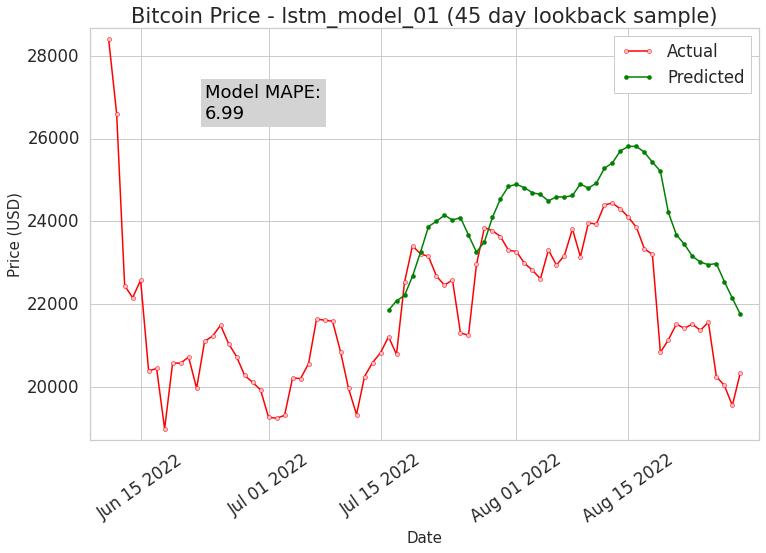

In [ ]:
plt.figure(figsize=(12,7.4))
plt.plot(btc_df_v2.index[-80:], scaled_testY[-80:], marker='.', markerfacecolor='pink',markersize=8, color='red', label='Actual')
plt.plot(btc_df_v2.index[-45:], forecast_scaled, marker='.', markerfacecolor='green', markersize=8, color='green', label='Predicted')
plt.title('Bitcoin Price - lstm_model_01 (45 day lookback sample)', fontsize=21)
plt.xlabel('Date',fontsize=15)
plt.ylabel('Price (USD)',fontsize=15)
plt.margins(0.03)

plt.text(dt.date(2022,6,23),26500, "Model MAPE:\n{}".format(lstm_model_01_mape),color='black',backgroundcolor='lightgrey')

plt.xticks(rotation=35)
# plt.grid(True, color='lightgrey')
plt.grid(True)
plt.legend()
plt.savefig('/content/drive/MyDrive/___DBS_September 2021_anderskiss11/__DISSERTATION_DBS_APPLIED RESEARCH PAPER/__IMAGES & FILES_Dissertation/Prediction_LSTM Baseline_{}.png'.format(pkl_str),bbox_inches='tight',dpi=120)
plt.show()

### **lstm_model_02 - LSTM Baseline + 'NDX' (samples=45 days)**
NDX => feature from Bonds & Indices category

#### **COPY dataset**

In [ ]:
btc_bonds_indices_df_to_model = btc_bonds_indices_df_to_model.copy(deep=True)
btc_bonds_indices_df_to_model.head(3)

BTC  Open  High  Low  BTC_vol    BTC_RSI    BTC_log      NDX
2011-09-14  5.6   5.8   5.8  5.3  43768.0  31.804028  -3.509132  2252.75
2011-09-15  4.8   5.6   5.6  4.4  86221.0  26.586215 -15.415068  2286.56
2011-09-16  4.8   4.8   5.0  4.6  31651.0  26.586215   0.000000  2306.09

In [ ]:
df_sanity_check(btc_bonds_indices_df_to_model)

SHAPE of df is:		 (4003, 8)
NaN in df present?	 False
NaN count in df:	 0
COLUMNS in df:
	 BTC
	 Open
	 High
	 Low
	 BTC_vol
	 BTC_RSI
	 BTC_log
	 NDX


In [ ]:
df_dates = pd.to_datetime(btc_bonds_indices_df_to_model.index)
df_dates[:3]

DatetimeIndex(['2011-09-14', '2011-09-15', '2011-09-16'], dtype='datetime64[ns]', freq=None)

In [ ]:
# CONVERT dates from DatetimeIndex object to Series
date_range = df_dates.to_series()
print(type(date_range))
date_range[-3:]

<class 'pandas.core.series.Series'>


2022-08-27   2022-08-27
2022-08-28   2022-08-28
2022-08-29   2022-08-29
dtype: datetime64[ns]

In [ ]:
date_range.shape

(4003,)

#### **SCALE data**

In [ ]:
# SCALE data
# for multivariate example
cols = btc_bonds_indices_df_to_model.columns
x = btc_bonds_indices_df_to_model.values #returns a numpy array

# MINMAX Scaler
min_max_scaler = MinMaxScaler()
scaled_data = min_max_scaler.fit_transform(btc_bonds_indices_df_to_model)
scaled_data
# Standard Scaler
# stnd_scaler = StandardScaler()
# scaled_data = stnd_scaler.fit_transform(btc_bonds_indices_df_to_model)
# scaled_data

array([[5.33128770e-05, 5.62740368e-05, 5.07332403e-05, ...,
        2.52914840e-01, 3.50294611e-01, 1.15755472e-02],
       [4.14655710e-05, 5.33122454e-05, 4.78341980e-05, ...,
        1.92181695e-01, 2.99042383e-01, 1.39091543e-02],
       [4.14655710e-05, 4.14650797e-05, 3.91370711e-05, ...,
        1.92181695e-01, 3.65400591e-01, 1.52571385e-02],
       ...,
       [2.96655061e-01, 2.99850281e-01, 2.94851446e-01, ...,
        2.50867832e-01, 3.60784156e-01, 7.26112104e-01],
       [2.89491884e-01, 2.96655989e-01, 2.92056769e-01, ...,
        2.22822051e-01, 3.54879612e-01, 7.26112104e-01],
       [3.01244411e-01, 2.89504744e-01, 2.95237018e-01, ...,
        3.20563193e-01, 3.82529534e-01, 7.21232305e-01]])

In [ ]:
lstm_model_02_scaled = pd.DataFrame(scaled_data)
lstm_model_02_scaled.columns = cols
lstm_model_02_scaled.index = date_range
lstm_model_02_scaled.head(3)

BTC      Open      High       Low   BTC_vol   BTC_RSI  \
2011-09-14  0.000053  0.000056  0.000051  0.000050  0.000010  0.252915   
2011-09-15  0.000041  0.000053  0.000048  0.000036  0.000019  0.192182   
2011-09-16  0.000041  0.000041  0.000039  0.000039  0.000007  0.192182   

             BTC_log       NDX  
2011-09-14  0.350295  0.011576  
2011-09-15  0.299042  0.013909  
2011-09-16  0.365401  0.015257

In [ ]:
# VERIFY data shape
lstm_model_02_scaled.shape

(4003, 8)

In [ ]:
lstm_model_02_scaled.iloc[:3, :1]

BTC
2011-09-14  0.000053
2011-09-15  0.000041
2011-09-16  0.000041

#### **RESHAPE data**
**shapes includes: sample, time steps, features**

In [ ]:
# models need data in the form [sample, timesteps, features]

samples = 45 # samples
steps = 1 # timesteps
X = []
Y = []
for i in range(lstm_model_02_scaled.shape[0] - samples):
    # ENSURE INDEX RANGE for X matches input range 
    # use Open,High,Low to predict Close
    X.append(lstm_model_02_scaled.iloc[i:i+samples, 1:].values) # Independent Samples
    Y.append(lstm_model_02_scaled.iloc[i+samples, :1].values) # Dependent Samples
print('Training Data length:',len(X[0:1][0]),'\n', X[0:1])
print('\nTesting Data length:', len(Y[0:1]),'\n', Y[0:1])

Training Data length: 45 
 [array([[5.62740368e-05, 5.07332403e-05, 4.97490687e-05, 9.73527780e-06,
        2.52914840e-01, 3.50294611e-01, 1.15755472e-02],
       [5.33122454e-05, 4.78341980e-05, 3.61811409e-05, 1.92353640e-05,
        1.92181695e-01, 2.99042383e-01, 1.39091543e-02],
       [4.14650797e-05, 3.91370711e-05, 3.91962360e-05, 7.02374872e-06,
        1.92181695e-01, 3.65400591e-01, 1.52571385e-02],
       [4.14650797e-05, 3.76875499e-05, 4.07037835e-05, 4.48430562e-06,
        1.92181695e-01, 3.65400591e-01, 1.52571385e-02],
       [4.14650797e-05, 4.78341980e-05, 4.07037835e-05, 9.92683255e-06,
        2.71593434e-01, 3.99857076e-01, 1.52571385e-02],
       [4.73886626e-05, 4.78341980e-05, 4.37188786e-05, 1.10933920e-05,
        3.25710822e-01, 3.89545775e-01, 1.54414251e-02],
       [5.18313497e-05, 6.52284518e-05, 5.12566162e-05, 2.60673342e-05,
        4.19959672e-01, 4.09972395e-01, 1.45531222e-02],
       [6.07167239e-05, 5.79808460e-05, 4.67339736e-05, 1.51945881e-0

In [ ]:
type(X)

numpy.ndarray

In [ ]:
# Convert data from list to array for modeling
print("Original datatype for X is:\t", type(X))
print("- - - - - - - - - - - - - - - - - - - - -")
X = np.array(X)
Y = np.array(Y)
print("Converted datatype for X is:\t", type(X))
print('\nX Shape: ', X.shape, '\nY Shape: ', Y.shape)

Original datatype for X is:	 <class 'numpy.ndarray'>
- - - - - - - - - - - - - - - - - - - - -
Converted datatype for X is:	 <class 'numpy.ndarray'>

X Shape:  (3958, 45, 7) 
Y Shape:  (3958, 1)


In [ ]:
# ESTABLISH training and testing sets
split_data = round(0.7 * X.shape[0])
trainX, trainY = X[:split_data], Y[:split_data]
testX, testY =  X[split_data:], Y[split_data:]
print('Train Set (input and output arrays):\n','TRAIN INPUTS: ',trainX.shape,'\t\tTRAIN OUTPUT: ',trainY.shape,'\n\nTest Set (input and output arrays):\n','TEST INPUTS: ',testX.shape,'\t\tTEST OUTPUT: ', testY.shape)

Train Set (input and output arrays):
 TRAIN INPUTS:  (2771, 45, 7) 		TRAIN OUTPUT:  (2771, 1) 

Test Set (input and output arrays):
 TEST INPUTS:  (1187, 45, 7) 		TEST OUTPUT:  (1187, 1)


#### **BUILD / TRAIN / SAVE Model**

In [ ]:
# VERIFY that the same train/test sets are used
# Reshaped data
print('X Shape: ', X.shape, '\nY Shape: ', Y.shape)

X Shape:  (3958, 45, 7) 
Y Shape:  (3958, 1)


In [ ]:
# VERIFY training and testing sets
print("\n# # # SPLIT DATASETS: # # #\n")
print('Train Set Input:',trainX.shape,'\t\tTrain Set Output:', trainY.shape)
print("\n- - - - - - - - - - - - -\n")      
print('\nTest Set Input:',testX.shape,'\t\tTest Set Output:', testY.shape)


# # # SPLIT DATASETS: # # #

Train Set Input: (2771, 45, 7) 		Train Set Output: (2771, 1)

- - - - - - - - - - - - -


Test Set Input: (1187, 45, 7) 		Test Set Output: (1187, 1)


In [ ]:
# BUILD the LSTM
lstm_model_02 = keras.Sequential()
lstm_model_02.add(layers.LSTM(16,
                         input_shape=(trainX.shape[1], trainX.shape[2])))

# Add a Dense layer with 1 units
lstm_model_02.add(layers.Dense(1))
lstm_model_02.compile(optimizer='adam',loss='mean_squared_error',metrics='MeanSquaredError')
lstm_model_02.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 16)                1536      
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1,553
Trainable params: 1,553
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# fit the model
history = lstm_model_02.fit(trainX,
                        trainY,
                        shuffle = False, 
                        epochs=50,
                        batch_size=15,
                        validation_split=0.2,
                        verbose=1)

# pickle.dump(lstm_model_02, open("/content/drive/MyDrive/___DBS_September 2021_anderskiss11/__DISSERTATION_DBS_APPLIED RESEARCH PAPER/___CODE_Dissertation/_MODELS/lstm_model_02_{}.pkl".format(pkl_str), "wb"))
# lstm_model_02 = pickle.load(open('/content/drive/MyDrive/___DBS_September 2021_anderskiss11/__DISSERTATION_DBS_APPLIED RESEARCH PAPER/___CODE_Dissertation/_MODELS/lstm_model_02_____.pk', 'rb'))
print("\nModel:\tlstm_model_02 successfully saved to .pkl file")

Epoch 1/50
148/148 [==============================] - 7s 30ms/step - loss: 8.0694e-04 - mean_squared_error: 8.0694e-04 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 2/50
148/148 [==============================] - 4s 24ms/step - loss: 6.8177e-04 - mean_squared_error: 6.8177e-04 - val_loss: 6.1432e-04 - val_mean_squared_error: 6.1432e-04
Epoch 3/50
148/148 [==============================] - 4s 27ms/step - loss: 2.5551e-04 - mean_squared_error: 2.5551e-04 - val_loss: 2.5243e-04 - val_mean_squared_error: 2.5243e-04
Epoch 4/50
148/148 [==============================] - 5s 36ms/step - loss: 5.9590e-05 - mean_squared_error: 5.9590e-05 - val_loss: 1.7396e-04 - val_mean_squared_error: 1.7396e-04
Epoch 5/50
148/148 [==============================] - 3s 22ms/step - loss: 1.4471e-05 - mean_squared_error: 1.4471e-05 - val_loss: 1.7454e-04 - val_mean_squared_error: 1.7454e-04
Epoch 6/50
148/148 [==============================] - 3s 18ms/step - loss: 9.3553e-06 - mean_squared_error: 9.355

In [ ]:
# lstm_model_02 = pickle.load(open("/content/drive/MyDrive/___DBS_September 2021_anderskiss11/__DISSERTATION_DBS_APPLIED RESEARCH PAPER/___CODE_Dissertation/_MODELS/_____.pkl", "rb"))
# print("lstm_model_02 successfully loaded!")

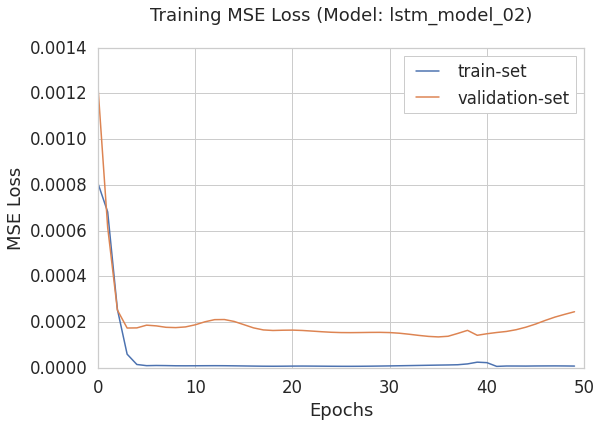

In [ ]:
# Plotting the loss 
plt.figure(figsize=(8.7,6.3))
plt.title('Training MSE Loss (Model: lstm_model_02)',fontsize=18,y=1.07)
plt.plot(history.history['loss'], label = 'train-set')
plt.plot(history.history['val_loss'], label ='validation-set')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.tight_layout()
plt.legend()
# Save image with proper modelname
plt.savefig('/content/drive/MyDrive/___DBS_September 2021_anderskiss11/__DISSERTATION_DBS_APPLIED RESEARCH PAPER/__IMAGES & FILES_Dissertation/lstm_model_02_loss_{}.png'.format(pkl_str),bbox_inches='tight',dpi=120)
# plt.savefig('lstm_model_02_loss_.png'.format(pkl_str), bbox_inches='tight', dpi=120)

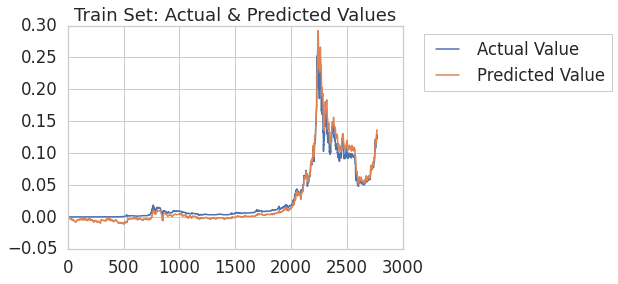

In [ ]:
# This is a one step forecast
y_pred_train = lstm_model_02.predict(trainX)
plt.title('Train Set: Actual & Predicted Values')
plt.plot(trainY, label = 'Actual Value')
plt.plot(y_pred_train, label = 'Predicted Value')
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
# plt.legend(loc="upper left")
# plt.legend()

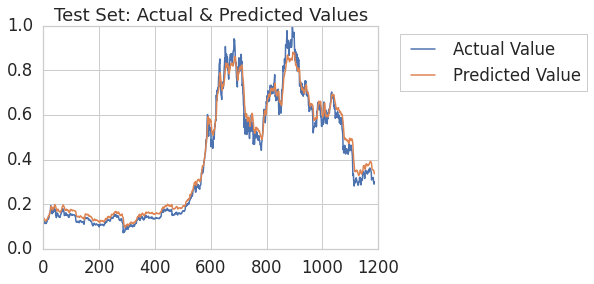

In [ ]:
# This is a one step forecast
y_pred = lstm_model_02.predict(testX)
plt.title('Test Set: Actual & Predicted Values')
plt.plot(testY, label = 'Actual Value')
plt.plot(y_pred, label = 'Predicted Value')
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
# plt.legend(loc="upper left")
# plt.legend()

#### **EVALUATION Metric**

In [ ]:

# Measure RMSE error
lstm_model_02_rmse_train = np.sqrt(metrics.mean_squared_error(y_pred_train,trainY)).round(5)
lstm_model_02_rmse_test = np.sqrt(metrics.mean_squared_error(y_pred,testY)).round(5)
print("Train RMSE:\t{}".format(lstm_model_02_rmse_train), "\nTest RMSE:\t{}".format(lstm_model_02_rmse_test))
# CALCULATE Mean Absolute Percentage Error (MAPE)
lstm_model_02_mape = (np.mean(np.abs((testY - y_pred) / testY)) * 100).round(2)
lstm_model_02_acc = (100 - lstm_model_02_mape).round(2)

print("\nMAPE:\t\t{}".format(lstm_model_02_mape), "\nModel Accuracy:\t{}%\n".format(lstm_model_02_acc))

Train RMSE:	0.00861 
Test RMSE:	0.03565

MAPE:		9.79 
Model Accuracy:	90.21%



#### **STORE Data**

In [ ]:
# STORE model information and evaluation metrics in a dictionary
lstm_model_02_dict = {
                    'Model_name': 'lstm_model_02',
                    'Model_Type': 'LSTM',
                    'Model_Dataset': 'BTC + NDX',
                    'Samples (lookback)': samples,
                    'Total params' : 1553,
                    'Train_Split': '70%',
                    'Model_Epochs': 50,
                    'Hidden_Layers': '1L',
                    'Hidden_Neurons': '16 (1L)',
                    'RMSE_train_score':lstm_model_02_rmse_train,
                    'RMSE_test_score':lstm_model_02_rmse_test,
                    'MAPE':lstm_model_02_mape,
                    'Accuracy (%)':lstm_model_02_acc
                    }
lstm_model_02_dict

# DELETE
# plt.savefig('/content/drive/MyDrive/___DBS_September 2021_anderskiss11/__DISSERTATION_DBS_APPLIED RESEARCH PAPER/__IMAGES & FILES_Dissertation/lstm_model_02_loss_{}.png'.format(pkl_str),bbox_inches='tight',dpi=120)
# plt.savefig('lstm_model_02_loss_.png'.format(pkl_str), bbox_inches='tight', dpi=120)

{'Model_name': 'lstm_model_02',
 'Model_Type': 'LSTM',
 'Model_Dataset': 'BTC + NDX',
 'Samples (lookback)': 45,
 'Total params': 1553,
 'Train_Split': '70%',
 'Model_Epochs': 50,
 'Hidden_Layers': '1L',
 'Hidden_Neurons': '16 (1L)',
 'RMSE_train_score': 0.00861,
 'RMSE_test_score': 0.03565,
 'MAPE': 9.79,
 'model_percent_acc': 90.21}

In [ ]:
# all_eval_df.drop([1], inplace=True)
all_eval_df = add_eval_dict(lstm_model_02_dict,all_eval_df)
all_eval_df.head()

Model_name Model_Type Model_Dataset Samples (lookback) Total params  \
0  lstm_model_01       LSTM      BTC only                 45         1489   
1  lstm_model_02       LSTM     BTC + NDX                 45         1553   

  Train_Split Model_Epochs Hidden_Layers Hidden_Neurons  RMSE_train_score  \
0         70%           50            1L        16 (1L)           0.00583   
1         70%           50            1L        16 (1L)           0.00861   

   RMSE_test_score  MAPE  Accuracy (%)  
0          0.03688  6.99         93.01  
1          0.03565  9.79         90.21

In [ ]:
all_eval_df.to_pickle('/content/drive/MyDrive/___DBS_September 2021_anderskiss11/__DISSERTATION_DBS_APPLIED RESEARCH PAPER/__IMAGES & FILES_Dissertation/lstm_model_02_eval_metrics_{}.pkl'.format(pkl_str))
print("Dataframe saved to .pkl")

# all_eval_df = pickle.load(open('/content/drive/MyDrive/___DBS_September 2021_anderskiss11/__DISSERTATION_DBS_APPLIED RESEARCH PAPER/__IMAGES & FILES_Dissertation/lstm_model_02_eval_metrics_29Aug2022_0818.pkl', 'rb'))
# all_eval_df.head()

Dataframe saved to .pkl


#### **MAKE Prediction**

In [ ]:
# MAKE FORECAST PREDICTION
forecast = lstm_model_02.predict(X[-samples:])
print(len(forecast))

# MAKE COPIES OF PREDICTED VALUE IN ORDER TO MATCH THE EXPECTED SHAPE WHEN INVERSING
forecast_copies = np.repeat(forecast, btc_bonds_indices_df_to_model.shape[1], axis=-1)
print(forecast_copies)

45
[[0.3411925  0.3411925  0.3411925  0.3411925  0.3411925  0.3411925
  0.3411925  0.3411925 ]
 [0.344609   0.344609   0.344609   0.344609   0.344609   0.344609
  0.344609   0.344609  ]
 [0.34652188 0.34652188 0.34652188 0.34652188 0.34652188 0.34652188
  0.34652188 0.34652188]
 [0.35273153 0.35273153 0.35273153 0.35273153 0.35273153 0.35273153
  0.35273153 0.35273153]
 [0.36314133 0.36314133 0.36314133 0.36314133 0.36314133 0.36314133
  0.36314133 0.36314133]
 [0.3720219  0.3720219  0.3720219  0.3720219  0.3720219  0.3720219
  0.3720219  0.3720219 ]
 [0.37240037 0.37240037 0.37240037 0.37240037 0.37240037 0.37240037
  0.37240037 0.37240037]
 [0.37374642 0.37374642 0.37374642 0.37374642 0.37374642 0.37374642
  0.37374642 0.37374642]
 [0.37061018 0.37061018 0.37061018 0.37061018 0.37061018 0.37061018
  0.37061018 0.37061018]
 [0.37009212 0.37009212 0.37009212 0.37009212 0.37009212 0.37009212
  0.37009212 0.37009212]
 [0.36470363 0.36470363 0.36470363 0.36470363 0.36470363 0.36470363
  0

In [ ]:
# INVERSE SCALER
# forecast_scaled = stnd_scaler.inverse_transform(prediction_copies)[:,0]
forecast_scaled = min_max_scaler.inverse_transform(forecast_copies)[:,0]
print(len(forecast_scaled))
forecast_scaled[-5:]

45


array([23827.193, 23820.951, 23608.246, 23091.473, 22719.287],
      dtype=float32)

In [ ]:
# INVERSE testY data for comparison of 
copies_test = np.repeat(testY, btc_bonds_indices_df_to_model.shape[1], axis=-1)
print(copies_test)

# MINMAX SCALER on testY
# forecast_scaled_testY = stnd_scaler.inverse_transform(copies_test)[:,0]
scaled_testY = min_max_scaler.inverse_transform(copies_test)[:,0]
print(len(scaled_testY))
scaled_testY[-5:]

[[0.12671138 0.12671138 0.12671138 ... 0.12671138 0.12671138 0.12671138]
 [0.12652479 0.12652479 0.12652479 ... 0.12652479 0.12652479 0.12652479]
 [0.12923338 0.12923338 0.12923338 ... 0.12923338 0.12923338 0.12923338]
 ...
 [0.29665506 0.29665506 0.29665506 ... 0.29665506 0.29665506 0.29665506]
 [0.28949188 0.28949188 0.28949188 ... 0.28949188 0.28949188 0.28949188]
 [0.30124441 0.30124441 0.30124441 ... 0.30124441 0.30124441 0.30124441]]
1187


array([21565.4, 20249.9, 20033.9, 19550.2, 20343.8])

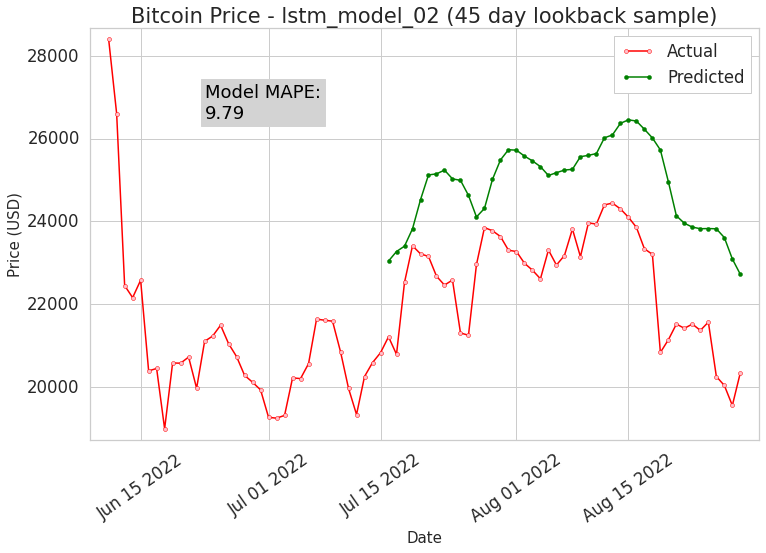

In [ ]:
plt.figure(figsize=(12,7.4))
plt.plot(btc_bonds_indices_df_to_model.index[-80:], scaled_testY[-80:], marker='.', markerfacecolor='pink',markersize=8, color='red', label='Actual')
plt.plot(btc_bonds_indices_df_to_model.index[-45:], forecast_scaled, marker='.', markerfacecolor='green', markersize=8, color='green', label='Predicted')
plt.title('Bitcoin Price - lstm_model_02 (45 day lookback sample)', fontsize=21)
plt.xlabel('Date',fontsize=15)
plt.ylabel('Price (USD)',fontsize=15)
plt.margins(0.03)

plt.text(dt.date(2022,6,23),26500, "Model MAPE:\n{}".format(lstm_model_02_mape),color='black',backgroundcolor='lightgrey')

plt.xticks(rotation=35)
# plt.grid(True, color='lightgrey')
plt.grid(True)
plt.legend()
plt.show()

### **lstm_model_03 - LSTM Baseline + 'lumber' (samples=45 days)**
lumber => feature from Commodities category

#### **COPY dataset**

In [ ]:
btc_comm_df_to_model = btc_comm_df_to_model.copy(deep=True)
btc_comm_df_to_model.head(3)

BTC  Open  High  Low  BTC_vol    BTC_RSI    BTC_log  lumber
2011-09-14  5.6   5.8   5.8  5.3  43768.0  31.804028  -3.509132   237.2
2011-09-15  4.8   5.6   5.6  4.4  86221.0  26.586215 -15.415068   244.2
2011-09-16  4.8   4.8   5.0  4.6  31651.0  26.586215   0.000000   244.6

In [ ]:
df_sanity_check(btc_bonds_indices_df_to_model)

SHAPE of df is:		 (4003, 8)
NaN in df present?	 False
NaN count in df:	 0
COLUMNS in df:
	 BTC
	 Open
	 High
	 Low
	 BTC_vol
	 BTC_RSI
	 BTC_log
	 NDX


In [ ]:
df_dates = pd.to_datetime(btc_bonds_indices_df_to_model.index)
df_dates[:3]

DatetimeIndex(['2011-09-14', '2011-09-15', '2011-09-16'], dtype='datetime64[ns]', freq=None)

In [ ]:
# CONVERT dates from DatetimeIndex object to Series
date_range = df_dates.to_series()
print(type(date_range))
date_range[-3:]

<class 'pandas.core.series.Series'>


2022-08-27   2022-08-27
2022-08-28   2022-08-28
2022-08-29   2022-08-29
dtype: datetime64[ns]

In [ ]:
date_range.shape

(4003,)

#### **SCALE data**

In [ ]:
# SCALE data
# for multivariate example
cols = btc_comm_df_to_model.columns
x = btc_comm_df_to_model.values #returns a numpy array

# MINMAX Scaler
min_max_scaler = MinMaxScaler()
scaled_data = min_max_scaler.fit_transform(btc_comm_df_to_model)
scaled_data
# Standard Scaler
# stnd_scaler = StandardScaler()
# scaled_data = stnd_scaler.fit_transform(btc_comm_df_to_model)
# scaled_data

array([[5.33128770e-05, 5.62740368e-05, 5.07332403e-05, ...,
        2.52914840e-01, 3.50294611e-01, 1.76961150e-02],
       [4.14655710e-05, 5.33122454e-05, 4.78341980e-05, ...,
        1.92181695e-01, 2.99042383e-01, 2.24421995e-02],
       [4.14655710e-05, 4.14650797e-05, 3.91370711e-05, ...,
        1.92181695e-01, 3.65400591e-01, 2.27134043e-02],
       ...,
       [2.96655061e-01, 2.99850281e-01, 2.94851446e-01, ...,
        2.50867832e-01, 3.60784156e-01, 2.11878771e-01],
       [2.89491884e-01, 2.96655989e-01, 2.92056769e-01, ...,
        2.22822051e-01, 3.54879612e-01, 2.12488982e-01],
       [2.97602846e-01, 2.89504744e-01, 2.91753819e-01, ...,
        2.92852043e-01, 3.77294570e-01, 2.04217235e-01]])

In [ ]:
lstm_model_03_scaled = pd.DataFrame(scaled_data)
lstm_model_03_scaled.columns = cols
lstm_model_03_scaled.index = date_range
lstm_model_03_scaled.head(3)

BTC      Open      High       Low   BTC_vol   BTC_RSI  \
2011-09-14  0.000053  0.000056  0.000051  0.000050  0.000010  0.252915   
2011-09-15  0.000041  0.000053  0.000048  0.000036  0.000019  0.192182   
2011-09-16  0.000041  0.000041  0.000039  0.000039  0.000007  0.192182   

             BTC_log    lumber  
2011-09-14  0.350295  0.017696  
2011-09-15  0.299042  0.022442  
2011-09-16  0.365401  0.022713

In [ ]:
# VERIFY data shape
lstm_model_03_scaled.shape

(4003, 8)

In [ ]:
lstm_model_03_scaled.iloc[:3, :1]

BTC
2011-09-14  0.000053
2011-09-15  0.000041
2011-09-16  0.000041

#### **RESHAPE data**
**shapes includes: sample, time steps, features**

In [ ]:
# models need data in the form [sample, timesteps, features]

samples = 45 # samples
steps = 1 # timesteps
X = []
Y = []
for i in range(lstm_model_03_scaled.shape[0] - samples):
    # ENSURE INDEX RANGE for X matches input range 
    # use Open,High,Low to predict Close
    X.append(lstm_model_03_scaled.iloc[i:i+samples, 1:].values) # Independent Samples
    Y.append(lstm_model_03_scaled.iloc[i+samples, :1].values) # Dependent Samples
print('Training Data length:',len(X[0:1][0]),'\n', X[0:1])
print('\nTesting Data length:', len(Y[0:1]),'\n', Y[0:1])

Training Data length: 45 
 [array([[5.62740368e-05, 5.07332403e-05, 4.97490687e-05, 9.73527780e-06,
        2.52914840e-01, 3.50294611e-01, 1.76961150e-02],
       [5.33122454e-05, 4.78341980e-05, 3.61811409e-05, 1.92353640e-05,
        1.92181695e-01, 2.99042383e-01, 2.24421995e-02],
       [4.14650797e-05, 3.91370711e-05, 3.91962360e-05, 7.02374872e-06,
        1.92181695e-01, 3.65400591e-01, 2.27134043e-02],
       [4.14650797e-05, 3.76875499e-05, 4.07037835e-05, 4.48430562e-06,
        1.92181695e-01, 3.65400591e-01, 2.27134043e-02],
       [4.14650797e-05, 4.78341980e-05, 4.07037835e-05, 9.92683255e-06,
        2.71593434e-01, 3.99857076e-01, 2.27134043e-02],
       [4.73886626e-05, 4.78341980e-05, 4.37188786e-05, 1.10933920e-05,
        3.25710822e-01, 3.89545775e-01, 2.04081633e-02],
       [5.18313497e-05, 6.52284518e-05, 5.12566162e-05, 2.60673342e-05,
        4.19959672e-01, 4.09972395e-01, 2.29846091e-02],
       [6.07167239e-05, 5.79808460e-05, 4.67339736e-05, 1.51945881e-0

In [ ]:
type(X)

list

In [ ]:
# Convert data from list to array for modeling
print("Original datatype for X is:\t", type(X))
print("- - - - - - - - - - - - - - - - - - - - -")
X = np.array(X)
Y = np.array(Y)
print("Converted datatype for X is:\t", type(X))
print('\nX Shape: ', X.shape, '\nY Shape: ', Y.shape)

Original datatype for X is:	 <class 'list'>
- - - - - - - - - - - - - - - - - - - - -
Converted datatype for X is:	 <class 'numpy.ndarray'>

X Shape:  (3958, 45, 7) 
Y Shape:  (3958, 1)


In [ ]:
# ESTABLISH training and testing sets
split_data = round(0.7 * X.shape[0])
trainX, trainY = X[:split_data], Y[:split_data]
testX, testY =  X[split_data:], Y[split_data:]
print('Train Set (input and output arrays):\n','TRAIN INPUTS: ',trainX.shape,'\t\tTRAIN OUTPUT: ',trainY.shape,'\n\nTest Set (input and output arrays):\n','TEST INPUTS: ',testX.shape,'\t\tTEST OUTPUT: ', testY.shape)

Train Set (input and output arrays):
 TRAIN INPUTS:  (2771, 45, 7) 		TRAIN OUTPUT:  (2771, 1) 

Test Set (input and output arrays):
 TEST INPUTS:  (1187, 45, 7) 		TEST OUTPUT:  (1187, 1)


#### **BUILD / TRAIN / SAVE Model**

In [ ]:
# VERIFY that the same train/test sets are used
# Reshaped data
print('X Shape: ', X.shape, '\nY Shape: ', Y.shape)

X Shape:  (3958, 45, 7) 
Y Shape:  (3958, 1)


In [ ]:
# VERIFY training and testing sets
print("\n# # # SPLIT DATASETS: # # #\n")
print('Train Set Input:',trainX.shape,'\t\tTrain Set Output:', trainY.shape)
print("\n- - - - - - - - - - - - -\n")      
print('\nTest Set Input:',testX.shape,'\t\tTest Set Output:', testY.shape)


# # # SPLIT DATASETS: # # #

Train Set Input: (2771, 45, 7) 		Train Set Output: (2771, 1)

- - - - - - - - - - - - -


Test Set Input: (1187, 45, 7) 		Test Set Output: (1187, 1)


In [ ]:
# BUILD the LSTM
lstm_model_03 = keras.Sequential()
lstm_model_03.add(layers.LSTM(16,
                         input_shape=(trainX.shape[1], trainX.shape[2])))

# Add a Dense layer with 1 units
lstm_model_03.add(layers.Dense(1))
lstm_model_03.compile(optimizer='adam',loss='mean_squared_error',metrics='MeanSquaredError')
lstm_model_03.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 16)                1536      
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1,553
Trainable params: 1,553
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# fit the model
history = lstm_model_03.fit(trainX,
                        trainY,
                        shuffle = False, 
                        epochs=50,
                        batch_size=15,
                        validation_split=0.2,
                        verbose=1)

# pickle.dump(lstm_model_03, open("/content/drive/MyDrive/___DBS_September 2021_anderskiss11/__DISSERTATION_DBS_APPLIED RESEARCH PAPER/___CODE_Dissertation/_MODELS/lstm_model_03_{}.pkl".format(pkl_str), "wb"))
# lstm_model_03 = pickle.load(open('/content/drive/MyDrive/___DBS_September 2021_anderskiss11/__DISSERTATION_DBS_APPLIED RESEARCH PAPER/___CODE_Dissertation/_MODELS/lstm_model_03_____.pk', 'rb'))
print("\nModel:\tlstm_model_03 successfully saved to .pkl file")


Epoch 1/50
148/148 [==============================] - 5s 20ms/step - loss: 1.1109e-04 - mean_squared_error: 1.1109e-04 - val_loss: 0.0026 - val_mean_squared_error: 0.0026
Epoch 2/50
148/148 [==============================] - 3s 22ms/step - loss: 4.3356e-04 - mean_squared_error: 4.3356e-04 - val_loss: 0.0010 - val_mean_squared_error: 0.0010
Epoch 3/50
148/148 [==============================] - 3s 21ms/step - loss: 2.1322e-04 - mean_squared_error: 2.1322e-04 - val_loss: 4.8238e-04 - val_mean_squared_error: 4.8238e-04
Epoch 4/50
148/148 [==============================] - 3s 17ms/step - loss: 9.1763e-05 - mean_squared_error: 9.1763e-05 - val_loss: 2.8550e-04 - val_mean_squared_error: 2.8550e-04
Epoch 5/50
148/148 [==============================] - 4s 25ms/step - loss: 3.6489e-05 - mean_squared_error: 3.6489e-05 - val_loss: 2.2986e-04 - val_mean_squared_error: 2.2986e-04
Epoch 6/50
148/148 [==============================] - 4s 25ms/step - loss: 2.0457e-05 - mean_squared_error: 2.0457e-05 - 

In [ ]:
# lstm_model_03 = pickle.load(open("/content/drive/MyDrive/___DBS_September 2021_anderskiss11/__DISSERTATION_DBS_APPLIED RESEARCH PAPER/___CODE_Dissertation/_MODELS/_____.pkl", "rb"))
# print("lstm_model_03 successfully loaded!")

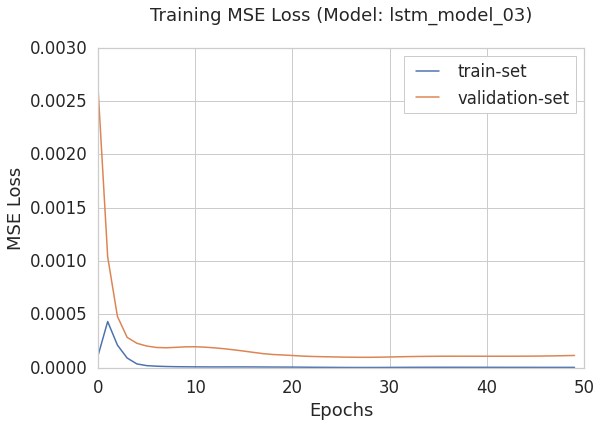

In [ ]:
# Plotting the loss 
plt.figure(figsize=(8.7,6.3))
plt.title('Training MSE Loss (Model: lstm_model_03)',fontsize=18,y=1.07)
plt.plot(history.history['loss'], label = 'train-set')
plt.plot(history.history['val_loss'], label ='validation-set')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.tight_layout()
plt.legend()
# Save image with proper modelname
plt.savefig('/content/drive/MyDrive/___DBS_September 2021_anderskiss11/__DISSERTATION_DBS_APPLIED RESEARCH PAPER/__IMAGES & FILES_Dissertation/lstm_model_03_loss_{}.png'.format(pkl_str),bbox_inches='tight',dpi=120)
# plt.savefig('lstm_model_03_loss_.png'.format(pkl_str), bbox_inches='tight', dpi=120)

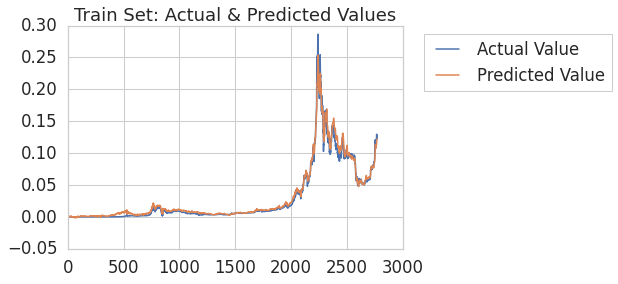

In [ ]:
# This is a one step forecast
y_pred_train = lstm_model_03.predict(trainX)
plt.title('Train Set: Actual & Predicted Values')
plt.plot(trainY, label = 'Actual Value')
plt.plot(y_pred_train, label = 'Predicted Value')
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
# plt.legend(loc="upper left")
# plt.legend()

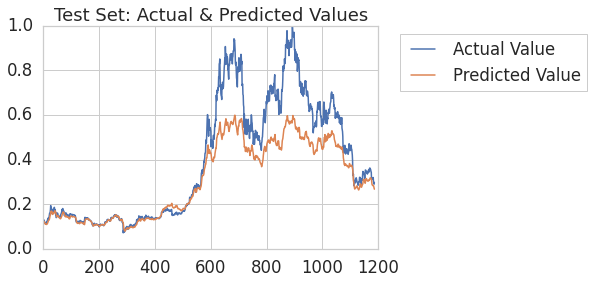

In [ ]:
# This is a one step forecast
y_pred = lstm_model_03.predict(testX)
plt.title('Test Set: Actual & Predicted Values')
plt.plot(testY, label = 'Actual Value')
plt.plot(y_pred, label = 'Predicted Value')
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
# plt.legend(loc="upper left")
# plt.legend()

#### **EVALUATION Metric**

In [ ]:
# Measure RMSE error
lstm_model_03_rmse_train = np.sqrt(metrics.mean_squared_error(y_pred_train,trainY)).round(5)
lstm_model_03_rmse_test = np.sqrt(metrics.mean_squared_error(y_pred,testY)).round(5)
print("Train RMSE:\t{}".format(lstm_model_03_rmse_train), "\nTest RMSE:\t{}".format(lstm_model_03_rmse_test))
# CALCULATE Mean Absolute Percentage Error (MAPE)
lstm_model_03_mape = (np.mean(np.abs((testY - y_pred) / testY)) * 100).round(2)
lstm_model_03_acc = (100 - lstm_model_03_mape).round(2)

print("\nMAPE:\t\t{}".format(lstm_model_03_mape), "\nModel Accuracy:\t{}%\n".format(lstm_model_03_acc))

Train RMSE:	0.00541 
Test RMSE:	0.13467

MAPE:		14.99 
Model Accuracy:	85.01%



#### **STORE Data**

In [ ]:
# STORE model information and evaluation metrics in a dictionary
lstm_model_03_dict = {
                    'Model_name': 'lstm_model_03',
                    'Model_Type': 'LSTM',
                    'Model_Dataset': 'BTC + lumber',
                    'Samples (lookback)': samples,
                    'Total params' : 1553,
                    'Train_Split': '70%',
                    'Model_Epochs': 50,
                    'Hidden_Layers': '1L',
                    'Hidden_Neurons': '16 (1L)',
                    'RMSE_train_score':lstm_model_03_rmse_train,
                    'RMSE_test_score':lstm_model_03_rmse_test,
                    'MAPE':lstm_model_03_mape,
                    'model_percent_acc':lstm_model_03_acc
                    }
lstm_model_03_dict

# DELETE
# plt.savefig('/content/drive/MyDrive/___DBS_September 2021_anderskiss11/__DISSERTATION_DBS_APPLIED RESEARCH PAPER/__IMAGES & FILES_Dissertation/lstm_model_03_loss_{}.png'.format(pkl_str),bbox_inches='tight',dpi=120)
# plt.savefig('lstm_model_03_loss_.png'.format(pkl_str), bbox_inches='tight', dpi=120)

{'Model_name': 'lstm_model_03',
 'Model_Type': 'LSTM',
 'Model_Dataset': 'BTC + lumber',
 'Samples (lookback)': 45,
 'Total params': 1553,
 'Train_Split': '70%',
 'Model_Epochs': 50,
 'Hidden_Layers': '1L',
 'Hidden_Neurons': '16 (1L)',
 'RMSE_train_score': 0.00541,
 'RMSE_test_score': 0.13467,
 'MAPE': 14.99,
 'model_percent_acc': 85.01}

In [ ]:
# all_eval_df.drop([1], inplace=True)
all_eval_df = add_eval_dict(lstm_model_03_dict,all_eval_df)
all_eval_df.head()

Model_name Model_Type Model_Dataset Samples (lookback) Total params  \
0  lstm_model_01       LSTM      BTC only                 45         1489   
1  lstm_model_02       LSTM     BTC + NDX                 45         1553   
2  lstm_model_03       LSTM  BTC + lumber                 45         1553   

  Train_Split Model_Epochs Hidden_Layers Hidden_Neurons  RMSE_train_score  \
0         70%           50            1L        16 (1L)           0.00583   
1         70%           50            1L        16 (1L)           0.00861   
2         70%           50            1L        16 (1L)           0.00541   

   RMSE_test_score   MAPE  Accuracy (%)  
0          0.03688   6.99         93.01  
1          0.03565   9.79         90.21  
2          0.13467  14.99         85.01

In [ ]:
all_eval_df.to_pickle('/content/drive/MyDrive/___DBS_September 2021_anderskiss11/__DISSERTATION_DBS_APPLIED RESEARCH PAPER/__IMAGES & FILES_Dissertation/lstm_model_03_eval_metrics_{}.pkl'.format(pkl_str))
print("Dataframe saved to .pkl")

# all_eval_df = pickle.load(open('/content/drive/MyDrive/___DBS_September 2021_anderskiss11/__DISSERTATION_DBS_APPLIED RESEARCH PAPER/__IMAGES & FILES_Dissertation/lstm_model_03_eval_metrics_29Aug2022_0818.pkl', 'rb'))
# all_eval_df.head()

Dataframe saved to .pkl


#### **MAKE Prediction**

In [ ]:
# MAKE FORECAST PREDICTION
forecast = lstm_model_03.predict(X[-samples:])
print(len(forecast))

# MAKE COPIES OF PREDICTED VALUE IN ORDER TO MATCH THE EXPECTED SHAPE WHEN INVERSING
forecast_copies = np.repeat(forecast, btc_comm_df_to_model.shape[1], axis=-1)
print(forecast_copies)

45
[[0.3411925  0.3411925  0.3411925  0.3411925  0.3411925  0.3411925
  0.3411925  0.3411925 ]
 [0.344609   0.344609   0.344609   0.344609   0.344609   0.344609
  0.344609   0.344609  ]
 [0.34652188 0.34652188 0.34652188 0.34652188 0.34652188 0.34652188
  0.34652188 0.34652188]
 [0.35273153 0.35273153 0.35273153 0.35273153 0.35273153 0.35273153
  0.35273153 0.35273153]
 [0.36314133 0.36314133 0.36314133 0.36314133 0.36314133 0.36314133
  0.36314133 0.36314133]
 [0.3720219  0.3720219  0.3720219  0.3720219  0.3720219  0.3720219
  0.3720219  0.3720219 ]
 [0.37240037 0.37240037 0.37240037 0.37240037 0.37240037 0.37240037
  0.37240037 0.37240037]
 [0.37374642 0.37374642 0.37374642 0.37374642 0.37374642 0.37374642
  0.37374642 0.37374642]
 [0.37061018 0.37061018 0.37061018 0.37061018 0.37061018 0.37061018
  0.37061018 0.37061018]
 [0.37009212 0.37009212 0.37009212 0.37009212 0.37009212 0.37009212
  0.37009212 0.37009212]
 [0.36470363 0.36470363 0.36470363 0.36470363 0.36470363 0.36470363
  0

In [ ]:
# INVERSE SCALER
# forecast_scaled = stnd_scaler.inverse_transform(prediction_copies)[:,0]
forecast_scaled = min_max_scaler.inverse_transform(forecast_copies)[:,0]
print(len(forecast_scaled))
forecast_scaled[-5:]

45


array([23827.193, 23820.951, 23608.246, 23091.473, 22719.287],
      dtype=float32)

In [ ]:
# INVERSE testY data for comparison of 
copies_test = np.repeat(testY, btc_comm_df_to_model.shape[1], axis=-1)
print(copies_test)

# MINMAX SCALER on testY
# forecast_scaled_testY = stnd_scaler.inverse_transform(copies_test)[:,0]
scaled_testY = min_max_scaler.inverse_transform(copies_test)[:,0]
print(len(scaled_testY))
scaled_testY[-5:]

[[0.12671138 0.12671138 0.12671138 ... 0.12671138 0.12671138 0.12671138]
 [0.12652479 0.12652479 0.12652479 ... 0.12652479 0.12652479 0.12652479]
 [0.12923338 0.12923338 0.12923338 ... 0.12923338 0.12923338 0.12923338]
 ...
 [0.29665506 0.29665506 0.29665506 ... 0.29665506 0.29665506 0.29665506]
 [0.28949188 0.28949188 0.28949188 ... 0.28949188 0.28949188 0.28949188]
 [0.30124441 0.30124441 0.30124441 ... 0.30124441 0.30124441 0.30124441]]
1187


array([21565.4, 20249.9, 20033.9, 19550.2, 20343.8])

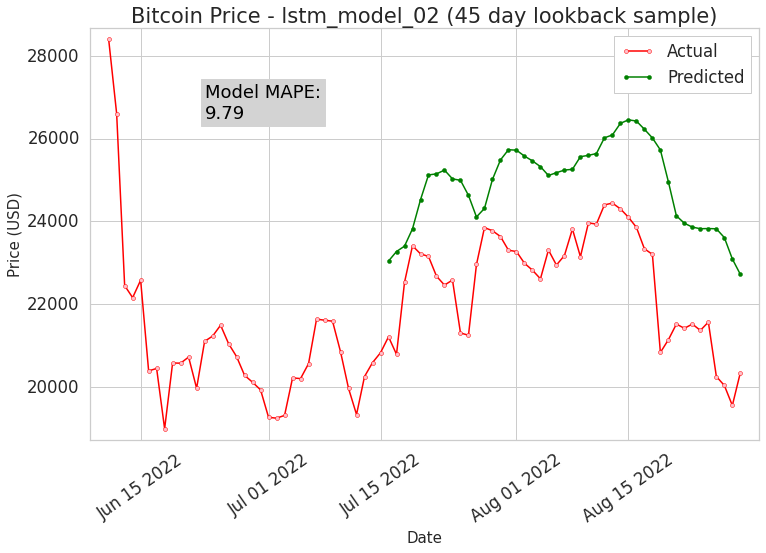

In [ ]:
plt.figure(figsize=(12,7.4))
plt.plot(btc_bonds_indices_df_to_model.index[-80:], scaled_testY[-80:], marker='.', markerfacecolor='pink',markersize=8, color='red', label='Actual')
plt.plot(btc_bonds_indices_df_to_model.index[-45:], forecast_scaled, marker='.', markerfacecolor='green', markersize=8, color='green', label='Predicted')
plt.title('Bitcoin Price - lstm_model_03 (45 day lookback sample)', fontsize=21)
plt.xlabel('Date',fontsize=15)
plt.ylabel('Price (USD)',fontsize=15)
plt.margins(0.03)

plt.text(dt.date(2022,6,23),26500, "Model MAPE:\n{}".format(lstm_model_03_mape),color='black',backgroundcolor='lightgrey')

plt.xticks(rotation=35)
# plt.grid(True, color='lightgrey')
plt.grid(True)
plt.legend()
plt.show()

### **lstm_model_04 - LSTM Baseline + 'debt_to_gdp' (samples=45 days)**
debt_to_gdp => corresponds to the U.S. Federal Debt as a Percentage of Gross Domestic Product (feature from **Macroeconomic Metrics** category)

#### **COPY dataset**

In [ ]:
btc_macro_df_to_model = btc_macro_df_to_model.copy(deep=True)
btc_macro_df_to_model.head(3)

BTC  Open  High  Low  BTC_vol    BTC_RSI    BTC_log  debt_to_gdp
2011-09-14  5.6   5.8   5.8  5.3  43768.0  31.804028  -3.509132     94.52097
2011-09-15  4.8   5.6   5.6  4.4  86221.0  26.586215 -15.415068     94.52097
2011-09-16  4.8   4.8   5.0  4.6  31651.0  26.586215   0.000000     94.52097

In [ ]:
df_sanity_check(btc_macro_df_to_model)

SHAPE of df is:		 (4003, 8)
NaN in df present?	 False
NaN count in df:	 0
COLUMNS in df:
	 BTC
	 Open
	 High
	 Low
	 BTC_vol
	 BTC_RSI
	 BTC_log
	 debt_to_gdp


In [ ]:
df_dates = pd.to_datetime(btc_macro_df_to_model.index)
df_dates[:3]

DatetimeIndex(['2011-09-14', '2011-09-15', '2011-09-16'], dtype='datetime64[ns]', freq=None)

In [ ]:
# CONVERT dates from DatetimeIndex object to Series
date_range = df_dates.to_series()
print(type(date_range))
date_range[-3:]

<class 'pandas.core.series.Series'>


2022-08-27   2022-08-27
2022-08-28   2022-08-28
2022-08-29   2022-08-29
dtype: datetime64[ns]

In [ ]:
date_range.shape

(4003,)

#### **SCALE data**

In [ ]:
# SCALE data
# for multivariate example
cols = btc_macro_df_to_model.columns
x = btc_macro_df_to_model.values #returns a numpy array

# MINMAX Scaler
min_max_scaler = MinMaxScaler()
scaled_data = min_max_scaler.fit_transform(btc_macro_df_to_model)
scaled_data
# Standard Scaler
# stnd_scaler = StandardScaler()
# scaled_data = stnd_scaler.fit_transform(btc_macro_df_to_model)
# scaled_data

array([[5.33128770e-05, 5.62740368e-05, 5.07332403e-05, ...,
        2.52914840e-01, 3.50294611e-01, 0.00000000e+00],
       [4.14655710e-05, 5.33122454e-05, 4.78341980e-05, ...,
        1.92181695e-01, 2.99042383e-01, 0.00000000e+00],
       [4.14655710e-05, 4.14650797e-05, 3.91370711e-05, ...,
        1.92181695e-01, 3.65400591e-01, 0.00000000e+00],
       ...,
       [2.96655061e-01, 2.99850281e-01, 2.94851446e-01, ...,
        2.50867832e-01, 3.60784156e-01, 6.83992004e-01],
       [2.89491884e-01, 2.96655989e-01, 2.92056769e-01, ...,
        2.22822051e-01, 3.54879612e-01, 6.83992004e-01],
       [3.01244411e-01, 2.89504744e-01, 2.95237018e-01, ...,
        3.20563193e-01, 3.82529534e-01, 6.83992004e-01]])

In [ ]:
lstm_model_04_scaled = pd.DataFrame(scaled_data)
lstm_model_04_scaled.columns = cols
lstm_model_04_scaled.index = date_range
lstm_model_04_scaled.head(3)

BTC      Open      High       Low   BTC_vol   BTC_RSI  \
2011-09-14  0.000053  0.000056  0.000051  0.000050  0.000010  0.252915   
2011-09-15  0.000041  0.000053  0.000048  0.000036  0.000019  0.192182   
2011-09-16  0.000041  0.000041  0.000039  0.000039  0.000007  0.192182   

             BTC_log  debt_to_gdp  
2011-09-14  0.350295          0.0  
2011-09-15  0.299042          0.0  
2011-09-16  0.365401          0.0

In [ ]:
# VERIFY data shape
lstm_model_04_scaled.shape

(4003, 8)

In [ ]:
lstm_model_04_scaled.iloc[:3, :1]

BTC
2011-09-14  0.000053
2011-09-15  0.000041
2011-09-16  0.000041

#### **RESHAPE data**
**shapes includes: sample, time steps, features**

In [ ]:
# models need data in the form [sample, timesteps, features]

samples = 45 # samples
steps = 1 # timesteps
X = []
Y = []
for i in range(lstm_model_04_scaled.shape[0] - samples):
    # ENSURE INDEX RANGE for X matches input range 
    # use Open,High,Low to predict Close
    X.append(lstm_model_04_scaled.iloc[i:i+samples, 1:].values) # Independent Samples
    Y.append(lstm_model_04_scaled.iloc[i+samples, :1].values) # Dependent Samples
print('Training Data length:',len(X[0:1][0]),'\n', X[0:1])
print('\nTesting Data length:', len(Y[0:1]),'\n', Y[0:1])

Training Data length: 45 
 [array([[5.62740368e-05, 5.07332403e-05, 4.97490687e-05, 9.73527780e-06,
        2.52914840e-01, 3.50294611e-01, 0.00000000e+00],
       [5.33122454e-05, 4.78341980e-05, 3.61811409e-05, 1.92353640e-05,
        1.92181695e-01, 2.99042383e-01, 0.00000000e+00],
       [4.14650797e-05, 3.91370711e-05, 3.91962360e-05, 7.02374872e-06,
        1.92181695e-01, 3.65400591e-01, 0.00000000e+00],
       [4.14650797e-05, 3.76875499e-05, 4.07037835e-05, 4.48430562e-06,
        1.92181695e-01, 3.65400591e-01, 0.00000000e+00],
       [4.14650797e-05, 4.78341980e-05, 4.07037835e-05, 9.92683255e-06,
        2.71593434e-01, 3.99857076e-01, 0.00000000e+00],
       [4.73886626e-05, 4.78341980e-05, 4.37188786e-05, 1.10933920e-05,
        3.25710822e-01, 3.89545775e-01, 0.00000000e+00],
       [5.18313497e-05, 6.52284518e-05, 5.12566162e-05, 2.60673342e-05,
        4.19959672e-01, 4.09972395e-01, 0.00000000e+00],
       [6.07167239e-05, 5.79808460e-05, 4.67339736e-05, 1.51945881e-0

In [ ]:
type(X)

list

In [ ]:
# Convert data from list to array for modeling
print("Original datatype for X is:\t", type(X))
print("- - - - - - - - - - - - - - - - - - - - -")
X = np.array(X)
Y = np.array(Y)
print("Converted datatype for X is:\t", type(X))
print('\nX Shape: ', X.shape, '\nY Shape: ', Y.shape)

Original datatype for X is:	 <class 'list'>
- - - - - - - - - - - - - - - - - - - - -
Converted datatype for X is:	 <class 'numpy.ndarray'>

X Shape:  (3958, 45, 7) 
Y Shape:  (3958, 1)


In [ ]:
# ESTABLISH training and testing sets
split_data = round(0.7 * X.shape[0])
trainX, trainY = X[:split_data], Y[:split_data]
testX, testY =  X[split_data:], Y[split_data:]
print('Train Set (input and output arrays):\n','TRAIN INPUTS: ',trainX.shape,'\t\tTRAIN OUTPUT: ',trainY.shape,'\n\nTest Set (input and output arrays):\n','TEST INPUTS: ',testX.shape,'\t\tTEST OUTPUT: ', testY.shape)

Train Set (input and output arrays):
 TRAIN INPUTS:  (2771, 45, 7) 		TRAIN OUTPUT:  (2771, 1) 

Test Set (input and output arrays):
 TEST INPUTS:  (1187, 45, 7) 		TEST OUTPUT:  (1187, 1)


#### **BUILD / TRAIN / SAVE Model**

In [ ]:
# VERIFY that the same train/test sets are used
# Reshaped data
print('X Shape: ', X.shape, '\nY Shape: ', Y.shape)

X Shape:  (3958, 45, 7) 
Y Shape:  (3958, 1)


In [ ]:
# VERIFY training and testing sets
print("\n# # # SPLIT DATASETS: # # #\n")
print('Train Set Input:',trainX.shape,'\t\tTrain Set Output:', trainY.shape)
print("\n- - - - - - - - - - - - -\n")      
print('\nTest Set Input:',testX.shape,'\t\tTest Set Output:', testY.shape)


# # # SPLIT DATASETS: # # #

Train Set Input: (2771, 45, 7) 		Train Set Output: (2771, 1)

- - - - - - - - - - - - -


Test Set Input: (1187, 45, 7) 		Test Set Output: (1187, 1)


In [ ]:
# BUILD the LSTM
lstm_model_04 = keras.Sequential()
lstm_model_04.add(layers.LSTM(16,
                         input_shape=(trainX.shape[1], trainX.shape[2])))

# Add a Dense layer with 1 units
lstm_model_04.add(layers.Dense(1))
lstm_model_04.compile(optimizer='adam',loss='mean_squared_error',metrics='MeanSquaredError')
lstm_model_04.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 16)                1536      
                                                                 
 dense_6 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1,553
Trainable params: 1,553
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# fit the model
history = lstm_model_04.fit(trainX,
                        trainY,
                        shuffle = False, 
                        epochs=50,
                        batch_size=15,
                        validation_split=0.2,
                        verbose=1)

pickle.dump(lstm_model_04, open("/content/drive/MyDrive/___DBS_September 2021_anderskiss11/__DISSERTATION_DBS_APPLIED RESEARCH PAPER/___CODE_Dissertation/_MODELS/lstm_model_04_{}.pkl".format(pkl_str), "wb"))
# lstm_model_04 = pickle.load(open('/content/drive/MyDrive/___DBS_September 2021_anderskiss11/__DISSERTATION_DBS_APPLIED RESEARCH PAPER/___CODE_Dissertation/_MODELS/lstm_model_04_____.pk', 'rb'))
print("\nModel:\tlstm_model_04 successfully saved to .pkl file")

Epoch 1/50
148/148 [==============================] - 4s 27ms/step - loss: 2.4291e-06 - mean_squared_error: 2.4291e-06 - val_loss: 9.8952e-05 - val_mean_squared_error: 9.8952e-05
Epoch 2/50
148/148 [==============================] - 3s 20ms/step - loss: 2.3909e-06 - mean_squared_error: 2.3909e-06 - val_loss: 1.0139e-04 - val_mean_squared_error: 1.0139e-04
Epoch 3/50
148/148 [==============================] - 3s 18ms/step - loss: 2.3445e-06 - mean_squared_error: 2.3445e-06 - val_loss: 1.0340e-04 - val_mean_squared_error: 1.0340e-04
Epoch 4/50
148/148 [==============================] - 3s 18ms/step - loss: 2.2993e-06 - mean_squared_error: 2.2993e-06 - val_loss: 1.0490e-04 - val_mean_squared_error: 1.0490e-04
Epoch 5/50
148/148 [==============================] - 3s 18ms/step - loss: 2.2632e-06 - mean_squared_error: 2.2632e-06 - val_loss: 1.0596e-04 - val_mean_squared_error: 1.0596e-04
Epoch 6/50
148/148 [==============================] - 3s 18ms/step - loss: 2.2398e-06 - mean_squared_erro


Model:	lstm_model_04 successfully saved to .pkl file


In [ ]:
# lstm_model_04 = pickle.load(open("/content/drive/MyDrive/___DBS_September 2021_anderskiss11/__DISSERTATION_DBS_APPLIED RESEARCH PAPER/___CODE_Dissertation/_MODELS/_____.pkl", "rb"))
# print("lstm_model_04 successfully loaded!")

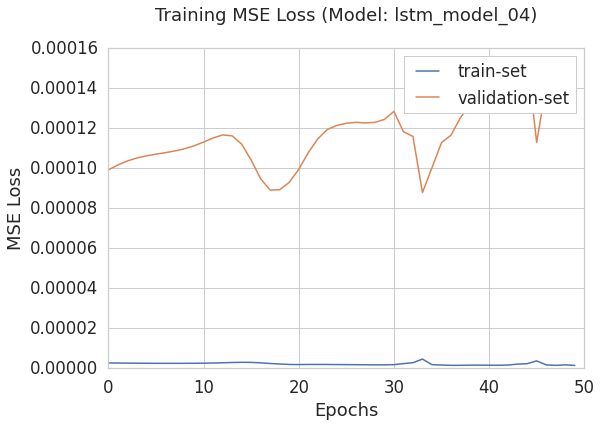

In [ ]:
# Plotting the loss 
plt.figure(figsize=(8.7,6.3))
plt.title('Training MSE Loss (Model: lstm_model_04)',fontsize=18,y=1.07)
plt.plot(history.history['loss'], label = 'train-set')
plt.plot(history.history['val_loss'], label ='validation-set')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.tight_layout()
plt.legend()
# Save image with proper modelname
plt.savefig('/content/drive/MyDrive/___DBS_September 2021_anderskiss11/__DISSERTATION_DBS_APPLIED RESEARCH PAPER/__IMAGES & FILES_Dissertation/lstm_model_04_loss_{}.png'.format(pkl_str),bbox_inches='tight',dpi=120)
# plt.savefig('lstm_model_04_loss_.png'.format(pkl_str), bbox_inches='tight', dpi=120)

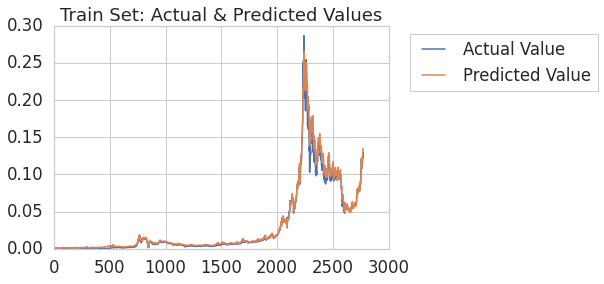

In [ ]:
# This is a one step forecast
y_pred_train = lstm_model_04.predict(trainX)
plt.title('Train Set: Actual & Predicted Values')
plt.plot(trainY, label = 'Actual Value')
plt.plot(y_pred_train, label = 'Predicted Value')
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
# plt.legend(loc="upper left")
# plt.legend()

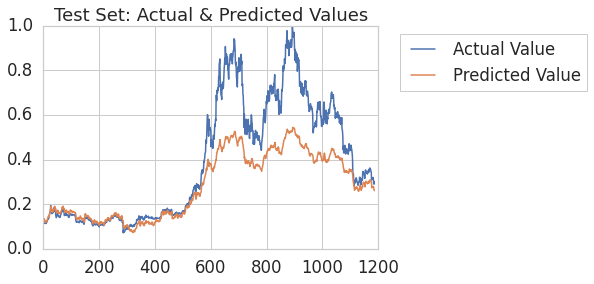

In [ ]:
# This is a one step forecast
y_pred = lstm_model_04.predict(testX)
plt.title('Test Set: Actual & Predicted Values')
plt.plot(testY, label = 'Actual Value')
plt.plot(y_pred, label = 'Predicted Value')
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
# plt.legend(loc="upper left")
# plt.legend()

#### **EVALUATION Metric**

In [ ]:
# Measure RMSE error
lstm_model_04_rmse_train = np.sqrt(metrics.mean_squared_error(y_pred_train,trainY)).round(5)
lstm_model_04_rmse_test = np.sqrt(metrics.mean_squared_error(y_pred,testY)).round(5)
print("Train RMSE:\t{}".format(lstm_model_04_rmse_train), "\nTest RMSE:\t{}".format(lstm_model_04_rmse_test))
# CALCULATE Mean Absolute Percentage Error (MAPE)
lstm_model_04_mape = (np.mean(np.abs((testY - y_pred) / testY)) * 100).round(2)
lstm_model_04_acc = (100 - lstm_model_04_mape).round(2)

print("\nMAPE:\t\t{}".format(lstm_model_04_mape), "\nModel Accuracy:\t{}%\n".format(lstm_model_04_acc))

Train RMSE:	0.00546 
Test RMSE:	0.16582

MAPE:		20.67 
Model Accuracy:	79.33%



#### **STORE Data**

In [ ]:
# STORE model information and evaluation metrics in a dictionary
lstm_model_04_dict = {
                    'Model_name': 'lstm_model_04',
                    'Model_Type': 'LSTM',
                    'Model_Dataset': 'BTC + U.S. Debt-to-GDP',
                    'Samples (lookback)': samples,
                    'Total params' : 1553,
                    'Train_Split': '70%',
                    'Model_Epochs': 50,
                    'Hidden_Layers': '1L',
                    'Hidden_Neurons': '16 (1L)',
                    'RMSE_train_score':lstm_model_04_rmse_train,
                    'RMSE_test_score':lstm_model_04_rmse_test,
                    'MAPE':lstm_model_04_mape,
                    'model_percent_acc':lstm_model_04_acc
                    }
lstm_model_04_dict

# DELETE
# plt.savefig('/content/drive/MyDrive/___DBS_September 2021_anderskiss11/__DISSERTATION_DBS_APPLIED RESEARCH PAPER/__IMAGES & FILES_Dissertation/lstm_model_04_loss_{}.png'.format(pkl_str),bbox_inches='tight',dpi=120)
# plt.savefig('lstm_model_04_loss_.png'.format(pkl_str), bbox_inches='tight', dpi=120)

{'Model_name': 'lstm_model_04',
 'Model_Type': 'LSTM',
 'Model_Dataset': 'BTC + U.S. Debt-to-GDP',
 'Samples (lookback)': 45,
 'Total params': 1553,
 'Train_Split': '70%',
 'Model_Epochs': 50,
 'Hidden_Layers': '1L',
 'Hidden_Neurons': '16 (1L)',
 'RMSE_train_score': 0.00546,
 'RMSE_test_score': 0.16582,
 'MAPE': 20.67,
 'model_percent_acc': 79.33}

In [ ]:
# all_eval_df.drop([1], inplace=True)
all_eval_df = add_eval_dict(lstm_model_04_dict,all_eval_df)
all_eval_df.head()

Model_name Model_Type           Model_Dataset Samples (lookback)  \
0  lstm_model_01       LSTM                BTC only                 45   
1  lstm_model_02       LSTM               BTC + NDX                 45   
2  lstm_model_03       LSTM            BTC + lumber                 45   
3  lstm_model_04       LSTM  BTC + U.S. Debt-to-GDP                 45   

  Total params Train_Split Model_Epochs Hidden_Layers Hidden_Neurons  \
0         1489         70%           50            1L        16 (1L)   
1         1553         70%           50            1L        16 (1L)   
2         1553         70%           50            1L        16 (1L)   
3         1553         70%           50            1L        16 (1L)   

   RMSE_train_score  RMSE_test_score   MAPE  Accuracy (%)  
0           0.00583          0.03688   6.99         93.01  
1           0.00861          0.03565   9.79         90.21  
2           0.00541          0.13467  14.99         85.01  
3           0.00546          0.16582  20.67         79.33

In [ ]:
# all_eval_df.to_pickle('/content/drive/MyDrive/___DBS_September 2021_anderskiss11/__DISSERTATION_DBS_APPLIED RESEARCH PAPER/__IMAGES & FILES_Dissertation/lstm_model_04_eval_metrics_{}.pkl'.format(pkl_str))
# print("Dataframe saved to .pkl")

all_eval_df = pickle.load(open('/content/drive/MyDrive/___DBS_September 2021_anderskiss11/__DISSERTATION_DBS_APPLIED RESEARCH PAPER/__IMAGES & FILES_Dissertation/lstm_model_04_eval_metrics_29Aug2022_0818.pkl', 'rb'))
all_eval_df.head()

Model_name Model_Type           Model_Dataset Samples (lookback)  \
0  lstm_model_01       LSTM                BTC only                 45   
1  lstm_model_02       LSTM               BTC + NDX                 45   
2  lstm_model_03       LSTM            BTC + lumber                 45   
3  lstm_model_04       LSTM  BTC + U.S. Debt-to-GDP                 45   

  Total params Train_Split Model_Epochs Hidden_Layers Hidden_Neurons  \
0         1489         70%           50            1L        16 (1L)   
1         1553         70%           50            1L        16 (1L)   
2         1553         70%           50            1L        16 (1L)   
3         1553         70%           50            1L        16 (1L)   

   RMSE_train_score  RMSE_test_score   MAPE  Accuracy (%)  
0           0.00583          0.03688   6.99         93.01  
1           0.00861          0.03565   9.79         90.21  
2           0.00541          0.13467  14.99         85.01  
3           0.00546          0.16582  20.67         79.33

#### **MAKE Prediction**

In [ ]:
# MAKE FORECAST PREDICTION
forecast = lstm_model_03.predict(X[-samples:])
print(len(forecast))

# MAKE COPIES OF PREDICTED VALUE IN ORDER TO MATCH THE EXPECTED SHAPE WHEN INVERSING
forecast_copies = np.repeat(forecast, btc_comm_df_to_model.shape[1], axis=-1)
print(forecast_copies)

45
[[0.3411925  0.3411925  0.3411925  0.3411925  0.3411925  0.3411925
  0.3411925  0.3411925 ]
 [0.344609   0.344609   0.344609   0.344609   0.344609   0.344609
  0.344609   0.344609  ]
 [0.34652188 0.34652188 0.34652188 0.34652188 0.34652188 0.34652188
  0.34652188 0.34652188]
 [0.35273153 0.35273153 0.35273153 0.35273153 0.35273153 0.35273153
  0.35273153 0.35273153]
 [0.36314133 0.36314133 0.36314133 0.36314133 0.36314133 0.36314133
  0.36314133 0.36314133]
 [0.3720219  0.3720219  0.3720219  0.3720219  0.3720219  0.3720219
  0.3720219  0.3720219 ]
 [0.37240037 0.37240037 0.37240037 0.37240037 0.37240037 0.37240037
  0.37240037 0.37240037]
 [0.37374642 0.37374642 0.37374642 0.37374642 0.37374642 0.37374642
  0.37374642 0.37374642]
 [0.37061018 0.37061018 0.37061018 0.37061018 0.37061018 0.37061018
  0.37061018 0.37061018]
 [0.37009212 0.37009212 0.37009212 0.37009212 0.37009212 0.37009212
  0.37009212 0.37009212]
 [0.36470363 0.36470363 0.36470363 0.36470363 0.36470363 0.36470363
  0

In [ ]:
# INVERSE SCALER
# forecast_scaled = stnd_scaler.inverse_transform(prediction_copies)[:,0]
forecast_scaled = min_max_scaler.inverse_transform(forecast_copies)[:,0]
print(len(forecast_scaled))
forecast_scaled[-5:]

45


array([23827.193, 23820.951, 23608.246, 23091.473, 22719.287],
      dtype=float32)

In [ ]:
# INVERSE testY data for comparison of 
copies_test = np.repeat(testY, btc_comm_df_to_model.shape[1], axis=-1)
print(copies_test)

# MINMAX SCALER on testY
# forecast_scaled_testY = stnd_scaler.inverse_transform(copies_test)[:,0]
scaled_testY = min_max_scaler.inverse_transform(copies_test)[:,0]
print(len(scaled_testY))
scaled_testY[-5:]

[[0.12671138 0.12671138 0.12671138 ... 0.12671138 0.12671138 0.12671138]
 [0.12652479 0.12652479 0.12652479 ... 0.12652479 0.12652479 0.12652479]
 [0.12923338 0.12923338 0.12923338 ... 0.12923338 0.12923338 0.12923338]
 ...
 [0.29665506 0.29665506 0.29665506 ... 0.29665506 0.29665506 0.29665506]
 [0.28949188 0.28949188 0.28949188 ... 0.28949188 0.28949188 0.28949188]
 [0.30124441 0.30124441 0.30124441 ... 0.30124441 0.30124441 0.30124441]]
1187


array([21565.4, 20249.9, 20033.9, 19550.2, 20343.8])

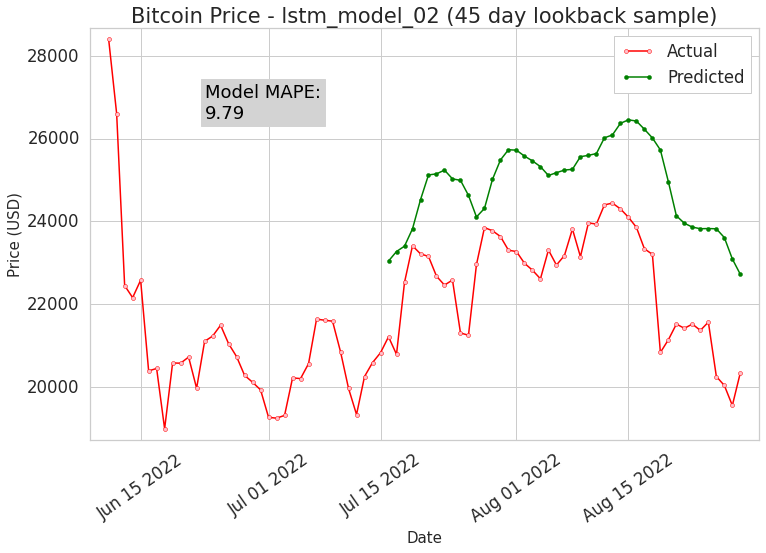

In [ ]:
plt.figure(figsize=(12,7.4))
plt.plot(btc_bonds_indices_df_to_model.index[-80:], scaled_testY[-80:], marker='.', markerfacecolor='pink',markersize=8, color='red', label='Actual')
plt.plot(btc_bonds_indices_df_to_model.index[-45:], forecast_scaled, marker='.', markerfacecolor='green', markersize=8, color='green', label='Predicted')
plt.title('Bitcoin Price - lstm_model_04 (45 day lookback sample)', fontsize=21)
plt.xlabel('Date',fontsize=15)
plt.ylabel('Price (USD)',fontsize=15)
plt.margins(0.03)

plt.text(dt.date(2022,6,23),26500, "Model MAPE:\n{}".format(lstm_model_04_mape),color='black',backgroundcolor='lightgrey')

plt.xticks(rotation=35)
# plt.grid(True, color='lightgrey')
plt.grid(True)
plt.legend()
plt.show()

### **lstm_model_05 - LSTM Baseline + 'NDX' + 'lumber' + 'debt_to_gdp'**

(samples=45 days)

(combine features from all categories category)

#### **COPY dataset**

In [ ]:
combined_macro_df = combined_macro_df.copy(deep=True)
combined_macro_df.head(3)

BTC  Open  High  Low  BTC_vol    BTC_RSI    BTC_log      NDX  debt_to_gdp  \
0  5.6   5.8   5.8  5.3  43768.0  31.804028  -3.509132  2252.75     94.52097   
1  4.8   5.6   5.6  4.4  86221.0  26.586215 -15.415068  2286.56     94.52097   
2  4.8   4.8   5.0  4.6  31651.0  26.586215   0.000000  2306.09     94.52097   

   lumber  
0   237.2  
1   244.2  
2   244.6

In [ ]:
df_sanity_check(combined_macro_df)

SHAPE of df is:		 (4003, 10)
NaN in df present?	 False
NaN count in df:	 0
COLUMNS in df:
	 BTC
	 Open
	 High
	 Low
	 BTC_vol
	 BTC_RSI
	 BTC_log
	 NDX
	 debt_to_gdp
	 lumber


In [ ]:
df_dates = pd.to_datetime(combined_macro_df.index)
df_dates[:3]

DatetimeIndex([          '1970-01-01 00:00:00',
               '1970-01-01 00:00:00.000000001',
               '1970-01-01 00:00:00.000000002'],
              dtype='datetime64[ns]', freq=None)

In [ ]:
# CONVERT dates from DatetimeIndex object to Series
date_range = df_dates.to_series()
print(type(date_range))
date_range[-3:]

<class 'pandas.core.series.Series'>


1970-01-01 00:00:00.000004000   1970-01-01 00:00:00.000004000
1970-01-01 00:00:00.000004001   1970-01-01 00:00:00.000004001
1970-01-01 00:00:00.000004002   1970-01-01 00:00:00.000004002
dtype: datetime64[ns]

In [ ]:
date_range.shape

(4003,)

#### **SCALE data**

In [ ]:
# SCALE data
# for multivariate example
cols = combined_macro_df.columns
x = combined_macro_df.values #returns a numpy array

# MINMAX Scaler
min_max_scaler = MinMaxScaler()
scaled_data = min_max_scaler.fit_transform(combined_macro_df)
scaled_data
# Standard Scaler
# stnd_scaler = StandardScaler()
# scaled_data = stnd_scaler.fit_transform(combined_macro_df)
# scaled_data

array([[5.33128770e-05, 5.62740368e-05, 5.07332403e-05, ...,
        1.15755472e-02, 0.00000000e+00, 1.76961150e-02],
       [4.14655710e-05, 5.33122454e-05, 4.78341980e-05, ...,
        1.39091543e-02, 0.00000000e+00, 2.24421995e-02],
       [4.14655710e-05, 4.14650797e-05, 3.91370711e-05, ...,
        1.52571385e-02, 0.00000000e+00, 2.27134043e-02],
       ...,
       [2.96655061e-01, 2.99850281e-01, 2.94851446e-01, ...,
        7.26112104e-01, 6.83992004e-01, 2.11878771e-01],
       [2.89491884e-01, 2.96655989e-01, 2.92056769e-01, ...,
        7.26112104e-01, 6.83992004e-01, 2.12488982e-01],
       [3.01244411e-01, 2.89504744e-01, 2.95237018e-01, ...,
        7.21232305e-01, 6.83992004e-01, 2.04217235e-01]])

In [ ]:
lstm_model_05_scaled = pd.DataFrame(scaled_data)
lstm_model_05_scaled.columns = cols
lstm_model_05_scaled.index = date_range
lstm_model_05_scaled.head(3)

BTC      Open      High       Low  \
1970-01-01 00:00:00.000000000  0.000053  0.000056  0.000051  0.000050   
1970-01-01 00:00:00.000000001  0.000041  0.000053  0.000048  0.000036   
1970-01-01 00:00:00.000000002  0.000041  0.000041  0.000039  0.000039   

                                BTC_vol   BTC_RSI   BTC_log       NDX  \
1970-01-01 00:00:00.000000000  0.000010  0.252915  0.350295  0.011576   
1970-01-01 00:00:00.000000001  0.000019  0.192182  0.299042  0.013909   
1970-01-01 00:00:00.000000002  0.000007  0.192182  0.365401  0.015257   

                               debt_to_gdp    lumber  
1970-01-01 00:00:00.000000000          0.0  0.017696  
1970-01-01 00:00:00.000000001          0.0  0.022442  
1970-01-01 00:00:00.000000002          0.0  0.022713

In [ ]:
# VERIFY data shape
lstm_model_05_scaled.shape

(4003, 10)

In [ ]:
lstm_model_05_scaled.iloc[:3, :1]

BTC
1970-01-01 00:00:00.000000000  0.000053
1970-01-01 00:00:00.000000001  0.000041
1970-01-01 00:00:00.000000002  0.000041

#### **RESHAPE data**
**shapes includes: sample, time steps, features**

In [ ]:
# models need data in the form [sample, timesteps, features]

samples = 45 # samples
steps = 1 # timesteps
X = []
Y = []
for i in range(lstm_model_05_scaled.shape[0] - samples):
    # ENSURE INDEX RANGE for X matches input range 
    # use Open,High,Low to predict Close
    X.append(lstm_model_05_scaled.iloc[i:i+samples, 1:].values) # Independent Samples
    Y.append(lstm_model_05_scaled.iloc[i+samples, :1].values) # Dependent Samples
print('Training Data length:',len(X[0:1][0]),'\n', X[0:1])
print('\nTesting Data length:', len(Y[0:1]),'\n', Y[0:1])

Training Data length: 45 
 [array([[5.62740368e-05, 5.07332403e-05, 4.97490687e-05, 9.73527780e-06,
        2.52914840e-01, 3.50294611e-01, 1.15755472e-02, 0.00000000e+00,
        1.76961150e-02],
       [5.33122454e-05, 4.78341980e-05, 3.61811409e-05, 1.92353640e-05,
        1.92181695e-01, 2.99042383e-01, 1.39091543e-02, 0.00000000e+00,
        2.24421995e-02],
       [4.14650797e-05, 3.91370711e-05, 3.91962360e-05, 7.02374872e-06,
        1.92181695e-01, 3.65400591e-01, 1.52571385e-02, 0.00000000e+00,
        2.27134043e-02],
       [4.14650797e-05, 3.76875499e-05, 4.07037835e-05, 4.48430562e-06,
        1.92181695e-01, 3.65400591e-01, 1.52571385e-02, 0.00000000e+00,
        2.27134043e-02],
       [4.14650797e-05, 4.78341980e-05, 4.07037835e-05, 9.92683255e-06,
        2.71593434e-01, 3.99857076e-01, 1.52571385e-02, 0.00000000e+00,
        2.27134043e-02],
       [4.73886626e-05, 4.78341980e-05, 4.37188786e-05, 1.10933920e-05,
        3.25710822e-01, 3.89545775e-01, 1.54414251e-02,

In [ ]:
type(X)

list

In [ ]:
# Convert data from list to array for modeling
print("Original datatype for X is:\t", type(X))
print("- - - - - - - - - - - - - - - - - - - - -")
X = np.array(X)
Y = np.array(Y)
print("Converted datatype for X is:\t", type(X))
print('\nX Shape: ', X.shape, '\nY Shape: ', Y.shape)

Original datatype for X is:	 <class 'list'>
- - - - - - - - - - - - - - - - - - - - -
Converted datatype for X is:	 <class 'numpy.ndarray'>

X Shape:  (3958, 45, 9) 
Y Shape:  (3958, 1)


In [ ]:
# ESTABLISH training and testing sets
split_data = round(0.7 * X.shape[0])
trainX, trainY = X[:split_data], Y[:split_data]
testX, testY =  X[split_data:], Y[split_data:]
print('Train Set (input and output arrays):\n','TRAIN INPUTS: ',trainX.shape,'\t\tTRAIN OUTPUT: ',trainY.shape,'\n\nTest Set (input and output arrays):\n','TEST INPUTS: ',testX.shape,'\t\tTEST OUTPUT: ', testY.shape)

Train Set (input and output arrays):
 TRAIN INPUTS:  (2771, 45, 9) 		TRAIN OUTPUT:  (2771, 1) 

Test Set (input and output arrays):
 TEST INPUTS:  (1187, 45, 9) 		TEST OUTPUT:  (1187, 1)


#### **BUILD / TRAIN / SAVE Model**

In [ ]:
# VERIFY that the same train/test sets are used
# Reshaped data
print('X Shape: ', X.shape, '\nY Shape: ', Y.shape)

X Shape:  (3958, 45, 9) 
Y Shape:  (3958, 1)


In [ ]:
# VERIFY training and testing sets
print("\n# # # SPLIT DATASETS: # # #\n")
print('Train Set Input:',trainX.shape,'\t\tTrain Set Output:', trainY.shape)
print("\n- - - - - - - - - - - - -\n")      
print('\nTest Set Input:',testX.shape,'\t\tTest Set Output:', testY.shape)


# # # SPLIT DATASETS: # # #

Train Set Input: (2771, 45, 9) 		Train Set Output: (2771, 1)

- - - - - - - - - - - - -


Test Set Input: (1187, 45, 9) 		Test Set Output: (1187, 1)


In [ ]:
# BUILD the LSTM
lstm_model_05 = keras.Sequential()
lstm_model_05.add(layers.LSTM(16,
                         input_shape=(trainX.shape[1], trainX.shape[2])))

# Add a Dense layer with 1 units
lstm_model_05.add(layers.Dense(1))
lstm_model_05.compile(optimizer='adam',loss='mean_squared_error',metrics='MeanSquaredError')
lstm_model_05.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 16)                1664      
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 1,681
Trainable params: 1,681
Non-trainable params: 0
_________________________________________________________________


In [ ]:
print(pkl_str)

29Aug2022_1640


In [ ]:
# fit the model
history = lstm_model_05.fit(trainX,
                        trainY,
                        shuffle = False, 
                        epochs=50,
                        batch_size=15,
                        validation_split=0.2,
                        verbose=1)

pickle.dump(lstm_model_05, open("/content/drive/MyDrive/___DBS_September 2021_anderskiss11/__DISSERTATION_DBS_APPLIED RESEARCH PAPER/___CODE_Dissertation/_MODELS/lstm_model_05_{}.pkl".format(pkl_str), "wb"))
print("\nModel:\tlstm_model_05 successfully saved to .pkl file")

Epoch 1/50
148/148 [==============================] - 10s 47ms/step - loss: 2.0660e-05 - mean_squared_error: 2.0660e-05 - val_loss: 1.0827e-04 - val_mean_squared_error: 1.0827e-04
Epoch 2/50
148/148 [==============================] - 5s 33ms/step - loss: 7.2257e-06 - mean_squared_error: 7.2257e-06 - val_loss: 1.2569e-04 - val_mean_squared_error: 1.2569e-04
Epoch 3/50
148/148 [==============================] - 5s 31ms/step - loss: 1.6525e-05 - mean_squared_error: 1.6525e-05 - val_loss: 1.3258e-04 - val_mean_squared_error: 1.3258e-04
Epoch 4/50
148/148 [==============================] - 5s 32ms/step - loss: 9.1813e-06 - mean_squared_error: 9.1813e-06 - val_loss: 1.2881e-04 - val_mean_squared_error: 1.2881e-04
Epoch 5/50
148/148 [==============================] - 4s 28ms/step - loss: 1.1684e-05 - mean_squared_error: 1.1684e-05 - val_loss: 1.2800e-04 - val_mean_squared_error: 1.2800e-04
Epoch 6/50
148/148 [==============================] - 4s 26ms/step - loss: 9.8787e-06 - mean_squared_err


Model:	lstm_model_05 successfully saved to .pkl file


In [ ]:
# lstm_model_05 = pickle.load(open('/content/drive/MyDrive/___DBS_September 2021_anderskiss11/__DISSERTATION_DBS_APPLIED RESEARCH PAPER/___CODE_Dissertation/_MODELS/lstm_model_05_29Aug2022_0818.pkl', 'rb'))
# print("\nModel:\tlstm_model_05 successfully loaded from .pkl file")


Model:	lstm_model_05 successfully loaded from .pkl file


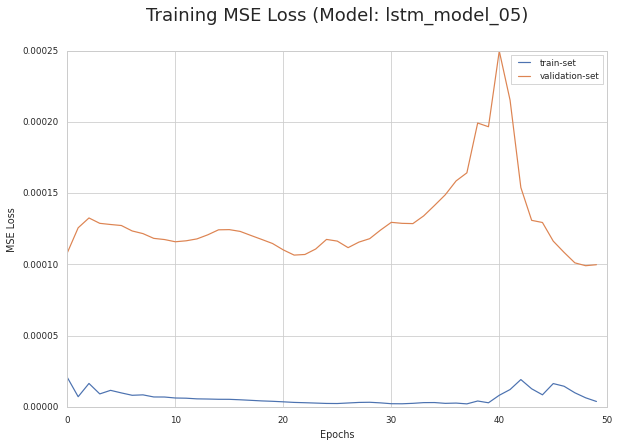

In [ ]:
# Plotting the loss 
plt.figure(figsize=(8.7,6.3))
plt.title('Training MSE Loss (Model: lstm_model_05)',fontsize=18,y=1.07)
plt.plot(history.history['loss'], label = 'train-set')
plt.plot(history.history['val_loss'], label ='validation-set')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.tight_layout()
plt.legend()
# Save image with proper modelname
plt.savefig('/content/drive/MyDrive/___DBS_September 2021_anderskiss11/__DISSERTATION_DBS_APPLIED RESEARCH PAPER/__IMAGES & FILES_Dissertation/lstm_model_05_loss_{}.png'.format(pkl_str),bbox_inches='tight',dpi=120)
# plt.savefig('lstm_model_05_loss_.png'.format(pkl_str), bbox_inches='tight', dpi=120)

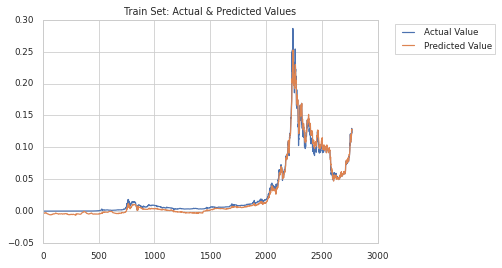

In [ ]:
# This is a one step forecast
y_pred_train = lstm_model_05.predict(trainX)
plt.title('Train Set: Actual & Predicted Values')
plt.plot(trainY, label = 'Actual Value')
plt.plot(y_pred_train, label = 'Predicted Value')
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
# plt.legend(loc="upper left")
# plt.legend()

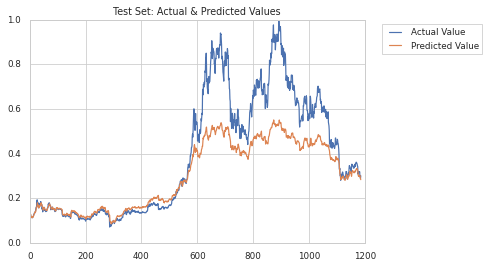

In [ ]:
# This is a one step forecast
y_pred = lstm_model_05.predict(testX)
plt.title('Test Set: Actual & Predicted Values')
plt.plot(testY, label = 'Actual Value')
plt.plot(y_pred, label = 'Predicted Value')
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
# plt.legend(loc="upper left")
# plt.legend()

#### **EVALUATION Metric**

In [ ]:
# Measure RMSE error
lstm_model_05_rmse_train = np.sqrt(metrics.mean_squared_error(y_pred_train,trainY)).round(5)
lstm_model_05_rmse_test = np.sqrt(metrics.mean_squared_error(y_pred,testY)).round(5)
print("Train RMSE:\t{}".format(lstm_model_05_rmse_train), "\nTest RMSE:\t{}".format(lstm_model_05_rmse_test))
# CALCULATE Mean Absolute Percentage Error (MAPE)
lstm_model_05_mape = (np.mean(np.abs((testY - y_pred) / testY)) * 100).round(2)
lstm_model_05_acc = (100 - lstm_model_05_mape).round(2)

print("\nMAPE:\t\t{}".format(lstm_model_05_mape), "\nModel Accuracy:\t{}%\n".format(lstm_model_05_acc))

Train RMSE:	0.00593 
Test RMSE:	0.15152

MAPE:		17.7 
Model Accuracy:	82.3%



#### **STORE Data**

In [ ]:
# STORE model information and evaluation metrics in a dictionary
lstm_model_05_dict = {
                    'Model_name': 'lstm_model_05',
                    'Model_Type': 'LSTM',
                    'Model_Dataset': 'BTC + NDX + lumber + debt_to_gdp',
                    'Samples (lookback)': samples,
                    'Total params' : 1681,
                    'Train_Split': '70%',
                    'Model_Epochs': 50,
                    'Hidden_Layers': '1L',
                    'Hidden_Neurons': '16 (1L)',
                    'RMSE_train_score':lstm_model_05_rmse_train,
                    'RMSE_test_score':lstm_model_05_rmse_test,
                    'MAPE':lstm_model_05_mape,
                    'model_percent_acc':lstm_model_05_acc
                    }
lstm_model_05_dict

# DELETE
# plt.savefig('/content/drive/MyDrive/___DBS_September 2021_anderskiss11/__DISSERTATION_DBS_APPLIED RESEARCH PAPER/__IMAGES & FILES_Dissertation/lstm_model_05_loss_{}.png'.format(pkl_str),bbox_inches='tight',dpi=120)
# plt.savefig('lstm_model_05_loss_.png'.format(pkl_str), bbox_inches='tight', dpi=120)

{'Model_name': 'lstm_model_05',
 'Model_Type': 'LSTM',
 'Model_Dataset': 'BTC + NDX + lumber + debt_to_gdp',
 'Samples (lookback)': 45,
 'Total params': 1681,
 'Train_Split': '70%',
 'Model_Epochs': 50,
 'Hidden_Layers': '1L',
 'Hidden_Neurons': '16 (1L)',
 'RMSE_train_score': 0.00593,
 'RMSE_test_score': 0.15152,
 'MAPE': 17.7,
 'model_percent_acc': 82.3}

In [ ]:
# all_eval_df.drop([1], inplace=True)
# all_eval_df = add_eval_dict(lstm_model_05_dict,all_eval_df)
all_eval_df.head()

NameError: ignored

In [ ]:
all_eval_df.to_pickle('/content/drive/MyDrive/___DBS_September 2021_anderskiss11/__DISSERTATION_DBS_APPLIED RESEARCH PAPER/__IMAGES & FILES_Dissertation/all_eval_metrics_{}.pkl'.format(pkl_str))
print("Dataframe saved to .pkl")

# all_eval_df = pickle.load(open('/content/drive/MyDrive/___DBS_September 2021_anderskiss11/__DISSERTATION_DBS_APPLIED RESEARCH PAPER/__IMAGES & FILES_Dissertation/lstm_model_04_eval_metrics_29Aug2022_0818.pkl', 'rb'))
# all_eval_df.head()

NameError: ignored

#### **MAKE Prediction**

In [ ]:
# MAKE FORECAST PREDICTION
forecast = lstm_model_05.predict(X[-samples:])
print(len(forecast))

# MAKE COPIES OF PREDICTED VALUE IN ORDER TO MATCH THE EXPECTED SHAPE WHEN INVERSING
forecast_copies = np.repeat(forecast, combined_macro_df.shape[1], axis=-1)
print(forecast_copies)

45
[[0.3411925  0.3411925  0.3411925  0.3411925  0.3411925  0.3411925
  0.3411925  0.3411925 ]
 [0.344609   0.344609   0.344609   0.344609   0.344609   0.344609
  0.344609   0.344609  ]
 [0.34652188 0.34652188 0.34652188 0.34652188 0.34652188 0.34652188
  0.34652188 0.34652188]
 [0.35273153 0.35273153 0.35273153 0.35273153 0.35273153 0.35273153
  0.35273153 0.35273153]
 [0.36314133 0.36314133 0.36314133 0.36314133 0.36314133 0.36314133
  0.36314133 0.36314133]
 [0.3720219  0.3720219  0.3720219  0.3720219  0.3720219  0.3720219
  0.3720219  0.3720219 ]
 [0.37240037 0.37240037 0.37240037 0.37240037 0.37240037 0.37240037
  0.37240037 0.37240037]
 [0.37374642 0.37374642 0.37374642 0.37374642 0.37374642 0.37374642
  0.37374642 0.37374642]
 [0.37061018 0.37061018 0.37061018 0.37061018 0.37061018 0.37061018
  0.37061018 0.37061018]
 [0.37009212 0.37009212 0.37009212 0.37009212 0.37009212 0.37009212
  0.37009212 0.37009212]
 [0.36470363 0.36470363 0.36470363 0.36470363 0.36470363 0.36470363
  0

In [ ]:
# INVERSE SCALER
# forecast_scaled = stnd_scaler.inverse_transform(prediction_copies)[:,0]
forecast_scaled = min_max_scaler.inverse_transform(forecast_copies)[:,0]
print(len(forecast_scaled))
forecast_scaled[-5:]

45


array([23827.193, 23820.951, 23608.246, 23091.473, 22719.287],
      dtype=float32)

In [ ]:
# INVERSE testY data for comparison of 
copies_test = np.repeat(testY, combined_macro_df.shape[1], axis=-1)
print(copies_test)

# MINMAX SCALER on testY
# forecast_scaled_testY = stnd_scaler.inverse_transform(copies_test)[:,0]
scaled_testY = min_max_scaler.inverse_transform(copies_test)[:,0]
print(len(scaled_testY))
scaled_testY[-5:]

[[0.12671138 0.12671138 0.12671138 ... 0.12671138 0.12671138 0.12671138]
 [0.12652479 0.12652479 0.12652479 ... 0.12652479 0.12652479 0.12652479]
 [0.12923338 0.12923338 0.12923338 ... 0.12923338 0.12923338 0.12923338]
 ...
 [0.29665506 0.29665506 0.29665506 ... 0.29665506 0.29665506 0.29665506]
 [0.28949188 0.28949188 0.28949188 ... 0.28949188 0.28949188 0.28949188]
 [0.30124441 0.30124441 0.30124441 ... 0.30124441 0.30124441 0.30124441]]
1187


array([21565.4, 20249.9, 20033.9, 19550.2, 20343.8])

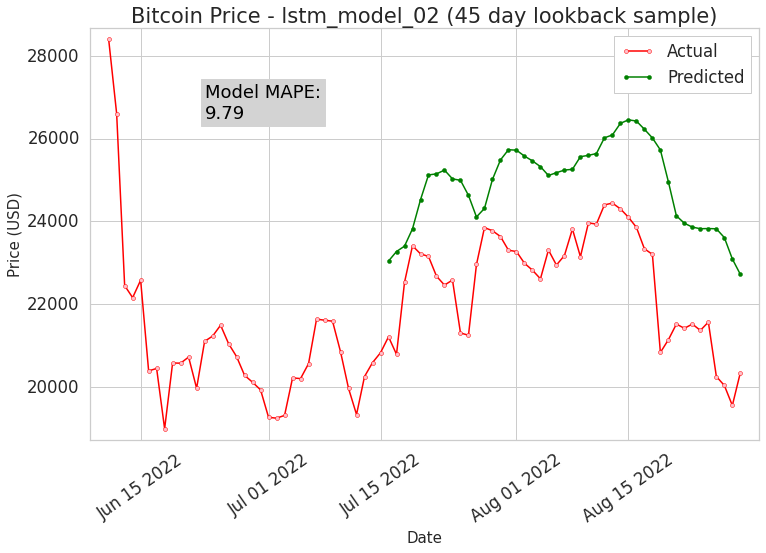

In [ ]:
plt.figure(figsize=(12,7.4))
plt.plot(combined_macro_df.index[-80:], scaled_testY[-80:], marker='.', markerfacecolor='pink',markersize=8, color='red', label='Actual')
plt.plot(combined_macro_df.index[-45:], forecast_scaled, marker='.', markerfacecolor='green', markersize=8, color='green', label='Predicted')
plt.title('Bitcoin Price - lstm_model_05 - BTC and 3x macro features (45 day lookback sample)', fontsize=21)
plt.xlabel('Date',fontsize=15)
plt.ylabel('Price (USD)',fontsize=15)
plt.margins(0.03)

plt.text(dt.date(2022,6,23),26500, "Model MAPE:\n{}".format(lstm_model_05_mape),color='black',backgroundcolor='lightgrey')

plt.xticks(rotation=35)
# plt.grid(True, color='lightgrey')
plt.grid(True)
plt.legend()
plt.show()

## **GRU's**

### **gru_model_01 - GRU Baseline (samples=45 days)**

#### **COPY dataset**

In [ ]:
# btc_df_v2 = pd.read_csv(r'/content/drive/MyDrive/___DBS_September 2021_anderskiss11/__DISSERTATION_DBS_APPLIED RESEARCH PAPER/___CODE_Dissertation/_CSV/btc_df.csv')
btc_df_v2 = pd.read_csv('/content/drive/MyDrive/___DBS_September 2021_anderskiss11/__DISSERTATION_DBS_APPLIED RESEARCH PAPER/___CODE_Dissertation/_CSV/btc_df.csv')

# btc_df_v2 = btc_df_v2.set_index('Date', inplace=True)
print('Model loaded from .CSV')
btc_df_v2.head(3)


print(type(btc_df_v2.index))
btc_df_v2 = btc_df_v2.set_index(pd.to_datetime(btc_df_v2.index))
print(type(btc_df_v2.index))
btc_df_v2.head(3)


Model loaded from .CSV
<class 'pandas.core.indexes.range.RangeIndex'>
<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Date  BTC  Open  High  Low  BTC_vol  \
1970-01-01 00:00:00.000000000  2011-09-14  5.6   5.8   5.8  5.3    43768   
1970-01-01 00:00:00.000000001  2011-09-15  4.8   5.6   5.6  4.4    86221   
1970-01-01 00:00:00.000000002  2011-09-16  4.8   4.8   5.0  4.6    31651   

                                 BTC_RSI    BTC_log  
1970-01-01 00:00:00.000000000  31.804028  -3.509132  
1970-01-01 00:00:00.000000001  26.586215 -15.415068  
1970-01-01 00:00:00.000000002  26.586215   0.000000

In [ ]:
btc_df_v2.set_index('Date',inplace=True)

In [ ]:
btc_df_v2.head(3)

BTC  Open  High  Low  BTC_vol    BTC_RSI    BTC_log
Date                                                           
2011-09-14  5.6   5.8   5.8  5.3    43768  31.804028  -3.509132
2011-09-15  4.8   5.6   5.6  4.4    86221  26.586215 -15.415068
2011-09-16  4.8   4.8   5.0  4.6    31651  26.586215   0.000000

In [ ]:
print(type(btc_df_v2.index))
btc_df_v2 = btc_df_v2.set_index(pd.to_datetime(btc_df_v2.index))
print(type(btc_df_v2.index))
btc_df_v2.head(3)

<class 'pandas.core.indexes.base.Index'>
<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


BTC  Open  High  Low  BTC_vol    BTC_RSI    BTC_log
Date                                                           
2011-09-14  5.6   5.8   5.8  5.3    43768  31.804028  -3.509132
2011-09-15  4.8   5.6   5.6  4.4    86221  26.586215 -15.415068
2011-09-16  4.8   4.8   5.0  4.6    31651  26.586215   0.000000

In [ ]:
df_sanity_check(btc_df_v2)

SHAPE of df is:		 (4003, 7)
NaN in df present?	 False
NaN count in df:	 0
COLUMNS in df:
	 BTC
	 Open
	 High
	 Low
	 BTC_vol
	 BTC_RSI
	 BTC_log


In [ ]:
df_dates = pd.to_datetime(btc_df_v2.index)
df_dates[:3]

DatetimeIndex(['2011-09-14', '2011-09-15', '2011-09-16'], dtype='datetime64[ns]', name='Date', freq=None)

In [ ]:
# CONVERT dates from DatetimeIndex object to Series
date_range = df_dates.to_series()
print(type(date_range))
date_range[-3:]

<class 'pandas.core.series.Series'>


Date
2022-08-27   2022-08-27
2022-08-28   2022-08-28
2022-08-29   2022-08-29
Name: Date, dtype: datetime64[ns]

In [ ]:
date_range.shape

(4003,)

#### **SCALE data**

In [ ]:
# SCALE data
# for multivariate example
cols = btc_df_v2.columns
x = btc_df_v2.values #returns a numpy array

# MINMAX Scaler
min_max_scaler = MinMaxScaler()
scaled_data = min_max_scaler.fit_transform(btc_df_v2)
scaled_data
# Standard Scaler
# stnd_scaler = StandardScaler()
# scaled_data = stnd_scaler.fit_transform(btc_df_v2)
# scaled_data

array([[5.33128770e-05, 5.62740368e-05, 5.07332403e-05, ...,
        9.73527780e-06, 2.52914840e-01, 3.50294611e-01],
       [4.14655710e-05, 5.33122454e-05, 4.78341980e-05, ...,
        1.92353640e-05, 1.92181695e-01, 2.99042383e-01],
       [4.14655710e-05, 4.14650797e-05, 3.91370711e-05, ...,
        7.02374872e-06, 1.92181695e-01, 3.65400591e-01],
       ...,
       [2.96655061e-01, 2.99850281e-01, 2.94851446e-01, ...,
        4.18627687e-05, 2.50867832e-01, 3.60784156e-01],
       [2.89491884e-01, 2.96655989e-01, 2.92056769e-01, ...,
        3.56555892e-05, 2.22822051e-01, 3.54879612e-01],
       [2.99600598e-01, 2.89504744e-01, 2.95589252e-01, ...,
        5.62421302e-05, 3.08310814e-01, 3.80174335e-01]])

In [ ]:
btc_df2_scaled = pd.DataFrame(scaled_data)
btc_df2_scaled.columns = cols
btc_df2_scaled.index = date_range
btc_df2_scaled.head(3)

BTC      Open      High       Low   BTC_vol   BTC_RSI  \
Date                                                                     
2011-09-14  0.000053  0.000056  0.000051  0.000050  0.000010  0.252915   
2011-09-15  0.000041  0.000053  0.000048  0.000036  0.000019  0.192182   
2011-09-16  0.000041  0.000041  0.000039  0.000039  0.000007  0.192182   

             BTC_log  
Date                  
2011-09-14  0.350295  
2011-09-15  0.299042  
2011-09-16  0.365401

In [ ]:
# VERIFY data shape
btc_df2_scaled.shape

(4003, 7)

In [ ]:
btc_df2_scaled.iloc[:3, :1]

BTC
Date                
2011-09-14  0.000053
2011-09-15  0.000041
2011-09-16  0.000041

#### **RESHAPE data**
**shapes includes: sample, time steps, features**

In [ ]:
# models need data in the form [sample, timesteps, features]

samples = 45 # samples
steps = 1 # timesteps
X = []
Y = []
for i in range(btc_df2_scaled.shape[0] - samples):
    # ENSURE INDEX RANGE for X matches input range 
    # use Open,High,Low to predict Close
    X.append(btc_df2_scaled.iloc[i:i+samples, 1:].values) # Independent Samples
    Y.append(btc_df2_scaled.iloc[i+samples, :1].values) # Dependent Samples
print('Training Data length:',len(X[0:1][0]),'\n', X[0:1])
print('\nTesting Data length:', len(Y[0:1]),'\n', Y[0:1])

Training Data length: 45 
 [array([[5.62740368e-05, 5.07332403e-05, 4.97490687e-05, 9.73527780e-06,
        2.52914840e-01, 3.50294611e-01],
       [5.33122454e-05, 4.78341980e-05, 3.61811409e-05, 1.92353640e-05,
        1.92181695e-01, 2.99042383e-01],
       [4.14650797e-05, 3.91370711e-05, 3.91962360e-05, 7.02374872e-06,
        1.92181695e-01, 3.65400591e-01],
       [4.14650797e-05, 3.76875499e-05, 4.07037835e-05, 4.48430562e-06,
        1.92181695e-01, 3.65400591e-01],
       [4.14650797e-05, 4.78341980e-05, 4.07037835e-05, 9.92683255e-06,
        2.71593434e-01, 3.99857076e-01],
       [4.73886626e-05, 4.78341980e-05, 4.37188786e-05, 1.10933920e-05,
        3.25710822e-01, 3.89545775e-01],
       [5.18313497e-05, 6.52284518e-05, 5.12566162e-05, 2.60673342e-05,
        4.19959672e-01, 4.09972395e-01],
       [6.07167239e-05, 5.79808460e-05, 4.67339736e-05, 1.51945881e-05,
        3.63551401e-01, 3.28585325e-01],
       [5.33122454e-05, 5.07332403e-05, 4.97490687e-05, 7.02374872e-

In [ ]:
type(X )

list

In [ ]:
# Convert data from list to array for modeling
print("Original datatype for X is:\t", type(X))
print("- - - - - - - - - - - - - - - - - - - - -")
X = np.array(X)
Y = np.array(Y)
print("Converted datatype for X is:\t", type(X))
print('\nX Shape: ', X.shape, '\nY Shape: ', Y.shape)

Original datatype for X is:	 <class 'list'>
- - - - - - - - - - - - - - - - - - - - -
Converted datatype for X is:	 <class 'numpy.ndarray'>

X Shape:  (3958, 45, 6) 
Y Shape:  (3958, 1)


In [ ]:
# ESTABLISH training and testing sets
split_data = round(0.7 * X.shape[0])
trainX, trainY = X[:split_data], Y[:split_data]
testX, testY =  X[split_data:], Y[split_data:]
print('Train Set (input and output arrays):\n','TRAIN INPUTS: ',trainX.shape,'\t\tTRAIN OUTPUT: ',trainY.shape,'\n\nTest Set (input and output arrays):\n','TEST INPUTS: ',testX.shape,'\t\tTEST OUTPUT: ', testY.shape)

Train Set (input and output arrays):
 TRAIN INPUTS:  (2771, 45, 6) 		TRAIN OUTPUT:  (2771, 1) 

Test Set (input and output arrays):
 TEST INPUTS:  (1187, 45, 6) 		TEST OUTPUT:  (1187, 1)


#### **BUILD / TRAIN / SAVE Model**

In [ ]:
# VERIFY that the same train/test sets are used
# Reshaped data
print('X Shape: ', X.shape, '\nY Shape: ', Y.shape)

X Shape:  (3958, 45, 6) 
Y Shape:  (3958, 1)


In [ ]:
# VERIFY training and testing sets
print("\n# # # SPLIT DATASETS: # # #\n")
print('Train Set Input:',trainX.shape,'\t\tTrain Set Output:', trainY.shape)
print("\n- - - - - - - - - - - - -\n")      
print('\nTest Set Input:',testX.shape,'\t\tTest Set Output:', testY.shape)


# # # SPLIT DATASETS: # # #

Train Set Input: (2771, 45, 6) 		Train Set Output: (2771, 1)

- - - - - - - - - - - - -


Test Set Input: (1187, 45, 6) 		Test Set Output: (1187, 1)


In [ ]:
# BUILD the GRU
gru_model_01 = keras.Sequential()
gru_model_01.add(layers.GRU(16,
                         input_shape=(trainX.shape[1], trainX.shape[2])))

# Add a Dense layer with 1 units
gru_model_01.add(layers.Dense(1))
gru_model_01.compile(optimizer='adam',loss='mean_squared_error',metrics='MeanSquaredError')
gru_model_01.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 16)                1152      
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1,169
Trainable params: 1,169
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# fit the model
history = gru_model_01.fit(trainX,
                        trainY,
                        shuffle = False, 
                        epochs=50,
                        batch_size=15,
                        validation_split=0.2,
                        verbose=1)

pickle.dump(gru_model_01, open("/content/drive/MyDrive/___DBS_September 2021_anderskiss11/__DISSERTATION_DBS_APPLIED RESEARCH PAPER/___CODE_Dissertation/_MODELS/gru_model_01_{}.pkl".format(pkl_str), "wb"))
# gru_model_01 = pickle.load(open('/content/drive/MyDrive/___DBS_September 2021_anderskiss11/__DISSERTATION_DBS_APPLIED RESEARCH PAPER/___CODE_Dissertation/_MODELS/gru_model_01_____.pkl', 'rb'))
print("\nModel:\tgru_model_01 successfully saved to .pkl file")

# pickle.dump(lstm_model_04, open("/content/drive/MyDrive/___DBS_September 2021_anderskiss11/__DISSERTATION_DBS_APPLIED RESEARCH PAPER/___CODE_Dissertation/_MODELS/lstm_model_04_{}.pkl".format(pkl_str), "wb"))
# # lstm_model_04 = pickle.load(open('/content/drive/MyDrive/___DBS_September 2021_anderskiss11/__DISSERTATION_DBS_APPLIED RESEARCH PAPER/___CODE_Dissertation/_MODELS/lstm_model_04_____.pk', 'rb'))
# print("\nModel:\tlstm_model_04 successfully saved to .pkl file")


Epoch 1/50
148/148 [==============================] - 7s 28ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 5.6337e-04 - val_mean_squared_error: 5.6337e-04
Epoch 2/50
148/148 [==============================] - 4s 24ms/step - loss: 1.5681e-04 - mean_squared_error: 1.5681e-04 - val_loss: 1.1686e-04 - val_mean_squared_error: 1.1686e-04
Epoch 3/50
148/148 [==============================] - 4s 25ms/step - loss: 1.7347e-05 - mean_squared_error: 1.7347e-05 - val_loss: 9.9751e-05 - val_mean_squared_error: 9.9751e-05
Epoch 4/50
148/148 [==============================] - 4s 25ms/step - loss: 7.3655e-06 - mean_squared_error: 7.3655e-06 - val_loss: 1.1120e-04 - val_mean_squared_error: 1.1120e-04
Epoch 5/50
148/148 [==============================] - 4s 25ms/step - loss: 6.9729e-06 - mean_squared_error: 6.9729e-06 - val_loss: 1.2617e-04 - val_mean_squared_error: 1.2617e-04
Epoch 6/50
148/148 [==============================] - 4s 25ms/step - loss: 7.6057e-06 - mean_squared_error: 7.605


Model:	gru_model_01 successfully saved to .pkl file


In [ ]:
# gru_model_01 = pickle.load(open("/content/drive/MyDrive/___DBS_September 2021_anderskiss11/__DISSERTATION_DBS_APPLIED RESEARCH PAPER/___CODE_Dissertation/_MODELS/_____.pkl", "rb"))
# print("gru_model_01 successfully loaded!")

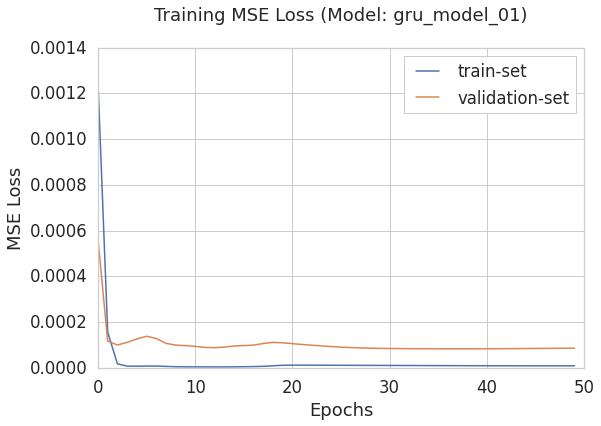

In [ ]:
# Plotting the loss 
plt.figure(figsize=(8.7,6.3))
plt.title('Training MSE Loss (Model: gru_model_01)',fontsize=18,y=1.07)
plt.plot(history.history['loss'], label = 'train-set')
plt.plot(history.history['val_loss'], label ='validation-set')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.tight_layout()
plt.legend()
# Save image with proper modelname
plt.savefig('/content/drive/MyDrive/___DBS_September 2021_anderskiss11/__DISSERTATION_DBS_APPLIED RESEARCH PAPER/__IMAGES & FILES_Dissertation/gru_model_01_loss_{}.png'.format(pkl_str),bbox_inches='tight',dpi=120)
# plt.savefig('gru_model_01_loss_.png'.format(pkl_str), bbox_inches='tight', dpi=120)

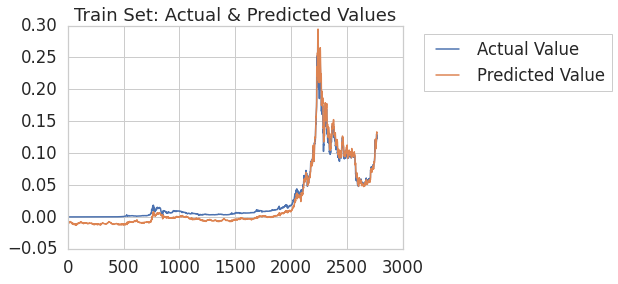

In [ ]:
# This is a one step forecast
y_pred_train = gru_model_01.predict(trainX)
plt.title('Train Set: Actual & Predicted Values')
plt.plot(trainY, label = 'Actual Value')
plt.plot(y_pred_train, label = 'Predicted Value')
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
# plt.legend(loc="upper left")
# plt.legend()

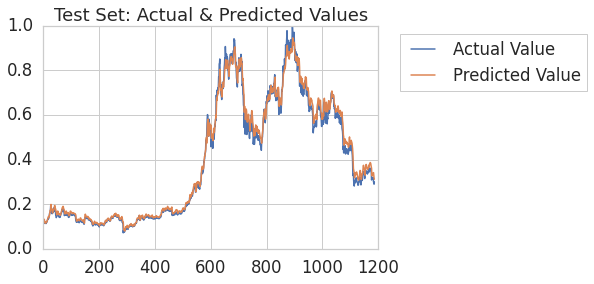

In [ ]:
# This is a one step forecast
y_pred = gru_model_01.predict(testX)
plt.title('Test Set: Actual & Predicted Values')
plt.plot(testY, label = 'Actual Value')
plt.plot(y_pred, label = 'Predicted Value')
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
# plt.legend(loc="upper left")
# plt.legend()

#### **EVALUATION Metric**

In [ ]:
# Measure RMSE error
gru_model_01_rmse_train = np.sqrt(metrics.mean_squared_error(y_pred_train,trainY)).round(5)
gru_model_01_rmse_test = np.sqrt(metrics.mean_squared_error(y_pred,testY)).round(5)
print("Train RMSE:\t{}".format(gru_model_01_rmse_train), "\nTest RMSE:\t{}".format(gru_model_01_rmse_test))
# CALCULATE Mean Absolute Percentage Error (MAPE)
gru_model_01_mape = (np.mean(np.abs((testY - y_pred) / testY)) * 100).round(2)
gru_model_01_acc = (100 - gru_model_01_mape).round(2)

print("\nMAPE:\t\t{}".format(gru_model_01_mape), "\nModel Accuracy:\t{}%\n".format(gru_model_01_acc))

Train RMSE:	0.00933 
Test RMSE:	0.02681

MAPE:		5.28 
Model Accuracy:	94.72%



#### **STORE Data**

In [ ]:
# STORE model information and evaluation metrics in a dictionary
gru_model_01_dict = {
                    'Model_name': 'gru_model_01',
                    'Model_Type': 'GRU',
                    'Model_Dataset': 'BTC only',
                    'Samples (lookback)': samples,
                    'Total params' : 1169,
                    'Train_Split': '70%',
                    'Model_Epochs': 50,
                    'Hidden_Layers': '1L',
                    'Hidden_Neurons': '16 (1L)',
                    'RMSE_train_score':gru_model_01_rmse_train,
                    'RMSE_test_score':gru_model_01_rmse_test,
                    'MAPE':gru_model_01_mape,
                    'model_percent_acc':gru_model_01_acc
                    }
gru_model_01_dict

# DELETE
# plt.savefig('/content/drive/MyDrive/___DBS_September 2021_anderskiss11/__DISSERTATION_DBS_APPLIED RESEARCH PAPER/__IMAGES & FILES_Dissertation/gru_model_01_loss_{}.png'.format(pkl_str),bbox_inches='tight',dpi=120)
# plt.savefig('gru_model_01_loss_.png'.format(pkl_str), bbox_inches='tight', dpi=120)

{'Model_name': 'gru_model_01',
 'Model_Type': 'GRU',
 'Model_Dataset': 'BTC only',
 'Samples (lookback)': 45,
 'Total params': 1169,
 'Train_Split': '70%',
 'Model_Epochs': 50,
 'Hidden_Layers': '1L',
 'Hidden_Neurons': '16 (1L)',
 'RMSE_train_score': 0.00933,
 'RMSE_test_score': 0.02681,
 'MAPE': 5.28,
 'model_percent_acc': 94.72}

In [ ]:
# all_eval_df = pickle.load(open('/content/drive/MyDrive/___DBS_September 2021_anderskiss11/__DISSERTATION_DBS_APPLIED RESEARCH PAPER/__IMAGES & FILES_Dissertation/lstm_model_05_eval_metrics_29Aug2022_1640.pkl', 'rb'))
# all_eval_df.head()

In [ ]:
# all_eval_df.drop([1,2,3,4], inplace=True)
# all_eval_df = add_eval_dict(gru_model_01_dict,all_eval_df)
# all_eval_df.head(12)

Model_name Model_Type                     Model_Dataset  \
0  lstm_model_01       LSTM                          BTC only   
1  lstm_model_02       LSTM                         BTC + NDX   
2  lstm_model_03       LSTM                      BTC + lumber   
3  lstm_model_04       LSTM            BTC + U.S. Debt-to-GDP   
4  lstm_model_05       LSTM  BTC + NDX + lumber + debt_to_gdp   

  Samples (lookback) Total params Train_Split Model_Epochs Hidden_Layers  \
0                 45         1489         70%           50            1L   
1                 45         1553         70%           50            1L   
2                 45         1553         70%           50            1L   
3                 45         1553         70%           50            1L   
4                 45         1681         70%           50            1L   

  Hidden_Neurons  RMSE_train_score  RMSE_test_score   MAPE  Accuracy (%)  
0        16 (1L)           0.00583          0.03688   6.99         93.01  
1        16 (1L)           0.00861          0.03565   9.79         90.21  
2        16 (1L)           0.00541          0.13467  14.99         85.01  
3        16 (1L)           0.00546          0.16582  20.67         79.33  
4        16 (1L)           0.00593          0.15152  17.70         82.30

In [ ]:
# all_eval_df.drop([1], inplace=True)
all_eval_df = add_eval_dict(gru_model_01_dict, all_eval_df)
all_eval_df.head(12)

Model_name Model_Type                     Model_Dataset  \
0  lstm_model_01       LSTM                          BTC only   
1  lstm_model_02       LSTM                         BTC + NDX   
2  lstm_model_03       LSTM                      BTC + lumber   
3  lstm_model_04       LSTM            BTC + U.S. Debt-to-GDP   
4  lstm_model_05       LSTM  BTC + NDX + lumber + debt_to_gdp   
5   gru_model_01        GRU                          BTC only   

  Samples (lookback) Total params Train_Split Model_Epochs Hidden_Layers  \
0                 45         1489         70%           50            1L   
1                 45         1553         70%           50            1L   
2                 45         1553         70%           50            1L   
3                 45         1553         70%           50            1L   
4                 45         1681         70%           50            1L   
5                 45         1169         70%           50            1L   

  Hidden_Neurons  RMSE_train_score  RMSE_test_score   MAPE  Accuracy (%)  
0        16 (1L)           0.00583          0.03688   6.99         93.01  
1        16 (1L)           0.00861          0.03565   9.79         90.21  
2        16 (1L)           0.00541          0.13467  14.99         85.01  
3        16 (1L)           0.00546          0.16582  20.67         79.33  
4        16 (1L)           0.00593          0.15152  17.70         82.30  
5        16 (1L)           0.00484          0.03840   4.80         95.20

In [ ]:
all_eval_df.to_pickle('/content/drive/MyDrive/___DBS_September 2021_anderskiss11/__DISSERTATION_DBS_APPLIED RESEARCH PAPER/__IMAGES & FILES_Dissertation/gru_model_01_eval_metrics_{}.pkl'.format(pkl_str))
print("Dataframe saved to .pkl")

# all_eval_df = pickle.load(open('/content/drive/MyDrive/___DBS_September 2021_anderskiss11/__DISSERTATION_DBS_APPLIED RESEARCH PAPER/__IMAGES & FILES_Dissertation/lstm_model_05_eval_metrics_29Aug2022_1640.pkl', 'rb'))
# all_eval_df.head()

Dataframe saved to .pkl


#### **MAKE Prediction**

In [ ]:
# MAKE FORECAST PREDICTION
forecast = gru_model_01.predict(X[-samples:])
print(len(forecast))

# MAKE COPIES OF PREDICTED VALUE IN ORDER TO MATCH THE EXPECTED SHAPE WHEN INVERSING
forecast_copies = np.repeat(forecast, btc_df_v2.shape[1], axis=-1)
print(forecast_copies)

45
[[0.32390383 0.32390383 0.32390383 0.32390383 0.32390383 0.32390383
  0.32390383]
 [0.32962087 0.32962087 0.32962087 0.32962087 0.32962087 0.32962087
  0.32962087]
 [0.327219   0.327219   0.327219   0.327219   0.327219   0.327219
  0.327219  ]
 [0.34439695 0.34439695 0.34439695 0.34439695 0.34439695 0.34439695
  0.34439695]
 [0.3624828  0.3624828  0.3624828  0.3624828  0.3624828  0.3624828
  0.3624828 ]
 [0.36780515 0.36780515 0.36780515 0.36780515 0.36780515 0.36780515
  0.36780515]
 [0.36145788 0.36145788 0.36145788 0.36145788 0.36145788 0.36145788
  0.36145788]
 [0.35628897 0.35628897 0.35628897 0.35628897 0.35628897 0.35628897
  0.35628897]
 [0.34822968 0.34822968 0.34822968 0.34822968 0.34822968 0.34822968
  0.34822968]
 [0.34848803 0.34848803 0.34848803 0.34848803 0.34848803 0.34848803
  0.34848803]
 [0.33392066 0.33392066 0.33392066 0.33392066 0.33392066 0.33392066
  0.33392066]
 [0.32309404 0.32309404 0.32309404 0.32309404 0.32309404 0.32309404
  0.32309404]
 [0.34579366 0.3

In [ ]:
# INVERSE SCALER
# forecast_scaled = stnd_scaler.inverse_transform(prediction_copies)[:,0]
forecast_scaled = min_max_scaler.inverse_transform(forecast_copies)[:,0]
print(len(forecast_scaled))
forecast_scaled[-5:]

45


array([22246.521, 22422.533, 21602.537, 20736.633, 20346.846],
      dtype=float32)

In [ ]:
# INVERSE testY data for comparison of 
copies_test = np.repeat(testY, btc_df_v2.shape[1], axis=-1)
print(copies_test)

# MINMAX SCALER on testY
# forecast_scaled_testY = stnd_scaler.inverse_transform(copies_test)[:,0]
scaled_testY = min_max_scaler.inverse_transform(copies_test)[:,0]
print(len(scaled_testY))
scaled_testY[-5:]

[[0.12671138 0.12671138 0.12671138 ... 0.12671138 0.12671138 0.12671138]
 [0.12652479 0.12652479 0.12652479 ... 0.12652479 0.12652479 0.12652479]
 [0.12923338 0.12923338 0.12923338 ... 0.12923338 0.12923338 0.12923338]
 ...
 [0.29665506 0.29665506 0.29665506 ... 0.29665506 0.29665506 0.29665506]
 [0.28949188 0.28949188 0.28949188 ... 0.28949188 0.28949188 0.28949188]
 [0.2996006  0.2996006  0.2996006  ... 0.2996006  0.2996006  0.2996006 ]]
1187


array([21565.4, 20249.9, 20033.9, 19550.2, 20232.8])

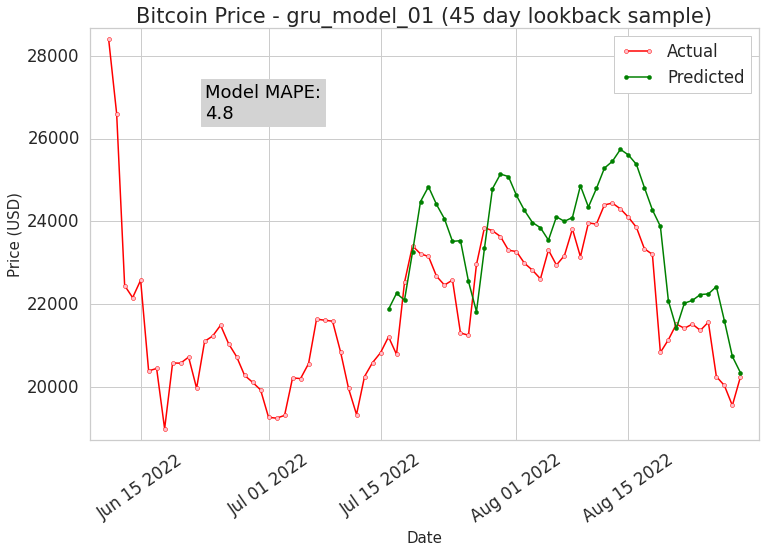

In [ ]:
plt.figure(figsize=(12,7.4))
plt.plot(btc_df_v2.index[-80:], scaled_testY[-80:], marker='.', markerfacecolor='pink',markersize=8, color='red', label='Actual')
plt.plot(btc_df_v2.index[-45:], forecast_scaled, marker='.', markerfacecolor='green', markersize=8, color='green', label='Predicted')
plt.title('Bitcoin Price - gru_model_01 (45 day lookback sample)', fontsize=21)
plt.xlabel('Date',fontsize=15)
plt.ylabel('Price (USD)',fontsize=15)
plt.margins(0.03)

plt.text(dt.date(2022,6,23),26500, "Model MAPE:\n{}".format(gru_model_01_mape),color='black',backgroundcolor='lightgrey')

plt.xticks(rotation=35)
# plt.grid(True, color='lightgrey')
plt.grid(True)
plt.legend()
plt.savefig('/content/drive/MyDrive/___DBS_September 2021_anderskiss11/__DISSERTATION_DBS_APPLIED RESEARCH PAPER/__IMAGES & FILES_Dissertation/Prediction_GRU Baseline_{}.png'.format(pkl_str),bbox_inches='tight',dpi=120)
plt.show()

### **gru_model_02 - GRU Baseline + 'NDX' (samples=45 days)**
NDX => feature from Bonds & Indices category

#### **COPY dataset**

In [ ]:
btc_bonds_indices_df_to_model = pd.read_csv('/content/drive/MyDrive/___DBS_September 2021_anderskiss11/__DISSERTATION_DBS_APPLIED RESEARCH PAPER/___CODE_Dissertation/_CSV/btc_bonds_indices_df_to_model.csv', index_col=0)

print('Model loaded from .CSV')
print(type(btc_bonds_indices_df_to_model.index))
btc_bonds_indices_df_to_model.head(3)

Model loaded from .CSV
<class 'pandas.core.indexes.base.Index'>


BTC  Open  High  Low  BTC_vol    BTC_RSI    BTC_log       NDX
2011-09-14  5.6   5.8   5.8  5.3  43768.0  31.804028  -3.509132  12484.32
2011-09-15  4.8   5.6   5.6  4.4  86221.0  26.586215 -15.415068  12484.32
2011-09-16  4.8   4.8   5.0  4.6  31651.0  26.586215   0.000000  12484.32

In [ ]:
btc_bonds_indices_df_to_model.set_index(pd.to_datetime(btc_bonds_indices_df_to_model.index), inplace=True)
print(type(btc_bonds_indices_df_to_model.index))
btc_bonds_indices_df_to_model.head(3)

<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Unnamed: 0  BTC  Open  High  Low  BTC_vol  \
1970-01-01 00:00:00.000000000  2011-09-14  5.6   5.8   5.8  5.3  43768.0   
1970-01-01 00:00:00.000000001  2011-09-15  4.8   5.6   5.6  4.4  86221.0   
1970-01-01 00:00:00.000000002  2011-09-16  4.8   4.8   5.0  4.6  31651.0   

                                 BTC_RSI    BTC_log       NDX  
1970-01-01 00:00:00.000000000  31.804028  -3.509132  12484.32  
1970-01-01 00:00:00.000000001  26.586215 -15.415068  12484.32  
1970-01-01 00:00:00.000000002  26.586215   0.000000  12484.32

In [ ]:
print(btc_bonds_indices_df_to_model.index.dtype)

object


In [ ]:
# btc_bonds_indices_df_to_model = btc_bonds_indices_df_to_model.copy(deep=True)
# btc_bonds_indices_df_to_model.head(3)

In [ ]:
df_sanity_check(btc_bonds_indices_df_to_model)

SHAPE of df is:		 (4003, 8)
NaN in df present?	 False
NaN count in df:	 0
COLUMNS in df:
	 BTC
	 Open
	 High
	 Low
	 BTC_vol
	 BTC_RSI
	 BTC_log
	 NDX


In [ ]:
print(btc_bonds_indices_df_to_model.index.dtype)

object


In [ ]:
df_dates = pd.to_datetime(btc_bonds_indices_df_to_model.index)
df_dates[:3]

DatetimeIndex(['2011-09-14', '2011-09-15', '2011-09-16'], dtype='datetime64[ns]', freq=None)

In [ ]:
# CONVERT dates from DatetimeIndex object to Series
date_range = df_dates.to_series()
print(type(date_range))
date_range[-3:]

<class 'pandas.core.series.Series'>


2022-08-27   2022-08-27
2022-08-28   2022-08-28
2022-08-29   2022-08-29
dtype: datetime64[ns]

In [ ]:
date_range.shape

(4003,)

#### **SCALE data**

In [ ]:
# SCALE data
# for multivariate example
cols = btc_bonds_indices_df_to_model.columns
x = btc_bonds_indices_df_to_model.values #returns a numpy array

# MINMAX Scaler
min_max_scaler = MinMaxScaler()
scaled_data = min_max_scaler.fit_transform(btc_bonds_indices_df_to_model)
scaled_data
# Standard Scaler
# stnd_scaler = StandardScaler()
# scaled_data = stnd_scaler.fit_transform(btc_bonds_indices_df_to_model)
# scaled_data

array([[5.33128770e-05, 5.62740368e-05, 5.07332403e-05, ...,
        2.52914840e-01, 3.50294611e-01, 0.00000000e+00],
       [4.14655710e-05, 5.33122454e-05, 4.78341980e-05, ...,
        1.92181695e-01, 2.99042383e-01, 0.00000000e+00],
       [4.14655710e-05, 4.14650797e-05, 3.91370711e-05, ...,
        1.92181695e-01, 3.65400591e-01, 0.00000000e+00],
       ...,
       [2.96655061e-01, 2.99850281e-01, 2.94851446e-01, ...,
        2.50867832e-01, 3.60784156e-01, 0.00000000e+00],
       [2.89491884e-01, 2.96655989e-01, 2.92056769e-01, ...,
        2.22822051e-01, 3.54879612e-01, 0.00000000e+00],
       [2.99279240e-01, 2.89504744e-01, 2.95589252e-01, ...,
        3.05867051e-01, 3.79712395e-01, 0.00000000e+00]])

In [ ]:
gru_model_02_scaled = pd.DataFrame(scaled_data)
gru_model_02_scaled.columns = cols
gru_model_02_scaled.index = date_range
gru_model_02_scaled.head(3)

BTC      Open      High       Low   BTC_vol   BTC_RSI  \
2011-09-14  0.000053  0.000056  0.000051  0.000050  0.000010  0.252915   
2011-09-15  0.000041  0.000053  0.000048  0.000036  0.000019  0.192182   
2011-09-16  0.000041  0.000041  0.000039  0.000039  0.000007  0.192182   

             BTC_log  NDX  
2011-09-14  0.350295  0.0  
2011-09-15  0.299042  0.0  
2011-09-16  0.365401  0.0

In [ ]:
# VERIFY data shape
gru_model_02_scaled.shape

(4003, 8)

In [ ]:
gru_model_02_scaled.iloc[:3, :1]

BTC
2011-09-14  0.000053
2011-09-15  0.000041
2011-09-16  0.000041

#### **RESHAPE data**
**shapes includes: sample, time steps, features**

In [ ]:
# models need data in the form [sample, timesteps, features]

samples = 45 # samples
steps = 1 # timesteps
X = []
Y = []
for i in range(gru_model_02_scaled.shape[0] - samples):
    # ENSURE INDEX RANGE for X matches input range 
    # use Open,High,Low to predict Close
    X.append(gru_model_02_scaled.iloc[i:i+samples, 1:].values) # Independent Samples
    Y.append(gru_model_02_scaled.iloc[i+samples, :1].values) # Dependent Samples
print('Training Data length:',len(X[0:1][0]),'\n', X[0:1])
print('\nTesting Data length:', len(Y[0:1]),'\n', Y[0:1])

Training Data length: 45 
 [array([[5.62740368e-05, 5.07332403e-05, 4.97490687e-05, 9.73527780e-06,
        2.52914840e-01, 3.50294611e-01, 0.00000000e+00],
       [5.33122454e-05, 4.78341980e-05, 3.61811409e-05, 1.92353640e-05,
        1.92181695e-01, 2.99042383e-01, 0.00000000e+00],
       [4.14650797e-05, 3.91370711e-05, 3.91962360e-05, 7.02374872e-06,
        1.92181695e-01, 3.65400591e-01, 0.00000000e+00],
       [4.14650797e-05, 3.76875499e-05, 4.07037835e-05, 4.48430562e-06,
        1.92181695e-01, 3.65400591e-01, 0.00000000e+00],
       [4.14650797e-05, 4.78341980e-05, 4.07037835e-05, 9.92683255e-06,
        2.71593434e-01, 3.99857076e-01, 0.00000000e+00],
       [4.73886626e-05, 4.78341980e-05, 4.37188786e-05, 1.10933920e-05,
        3.25710822e-01, 3.89545775e-01, 0.00000000e+00],
       [5.18313497e-05, 6.52284518e-05, 5.12566162e-05, 2.60673342e-05,
        4.19959672e-01, 4.09972395e-01, 0.00000000e+00],
       [6.07167239e-05, 5.79808460e-05, 4.67339736e-05, 1.51945881e-0

In [ ]:
type(X)

list

In [ ]:
# Convert data from list to array for modeling
print("Original datatype for X is:\t", type(X))
print("- - - - - - - - - - - - - - - - - - - - -")
X = np.array(X)
Y = np.array(Y)
print("Converted datatype for X is:\t", type(X))
print('\nX Shape: ', X.shape, '\nY Shape: ', Y.shape)

Original datatype for X is:	 <class 'list'>
- - - - - - - - - - - - - - - - - - - - -
Converted datatype for X is:	 <class 'numpy.ndarray'>

X Shape:  (3958, 45, 7) 
Y Shape:  (3958, 1)


In [ ]:
# ESTABLISH training and testing sets
split_data = round(0.7 * X.shape[0])
trainX, trainY = X[:split_data], Y[:split_data]
testX, testY =  X[split_data:], Y[split_data:]
print('Train Set (input and output arrays):\n','TRAIN INPUTS: ',trainX.shape,'\t\tTRAIN OUTPUT: ',trainY.shape,'\n\nTest Set (input and output arrays):\n','TEST INPUTS: ',testX.shape,'\t\tTEST OUTPUT: ', testY.shape)

Train Set (input and output arrays):
 TRAIN INPUTS:  (2771, 45, 7) 		TRAIN OUTPUT:  (2771, 1) 

Test Set (input and output arrays):
 TEST INPUTS:  (1187, 45, 7) 		TEST OUTPUT:  (1187, 1)


#### **BUILD / TRAIN / SAVE Model**

In [ ]:
# VERIFY that the same train/test sets are used
# Reshaped data
print('X Shape: ', X.shape, '\nY Shape: ', Y.shape)

X Shape:  (3958, 45, 7) 
Y Shape:  (3958, 1)


In [ ]:
# VERIFY training and testing sets
print("\n# # # SPLIT DATASETS: # # #\n")
print('Train Set Input:',trainX.shape,'\t\tTrain Set Output:', trainY.shape)
print("\n- - - - - - - - - - - - -\n")      
print('\nTest Set Input:',testX.shape,'\t\tTest Set Output:', testY.shape)


# # # SPLIT DATASETS: # # #

Train Set Input: (2771, 45, 7) 		Train Set Output: (2771, 1)

- - - - - - - - - - - - -


Test Set Input: (1187, 45, 7) 		Test Set Output: (1187, 1)


In [ ]:
# BUILD the GRU
gru_model_02 = keras.Sequential()
gru_model_02.add(layers.GRU(16,
                            input_shape=(trainX.shape[1], trainX.shape[2])))

# Add a Dense layer with 1 units
gru_model_02.add(layers.Dense(1))
gru_model_02.compile(optimizer='adam',loss='mean_squared_error',metrics='MeanSquaredError')
gru_model_02.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_3 (GRU)                 (None, 16)                1200      
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1,217
Trainable params: 1,217
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# fit the model
history = gru_model_02.fit(trainX,
                        trainY,
                        shuffle = False, 
                        epochs=50,
                        batch_size=15,
                        validation_split=0.2,
                        verbose=1)

# pickle.dump(gru_model_02, open("/content/drive/MyDrive/___DBS_September 2021_anderskiss11/__DISSERTATION_DBS_APPLIED RESEARCH PAPER/___CODE_Dissertation/_MODELS/gru_model_02_{}.pkl".format(pkl_str), "wb"))
# gru_model_02 = pickle.load(open('/content/drive/MyDrive/___DBS_September 2021_anderskiss11/__DISSERTATION_DBS_APPLIED RESEARCH PAPER/___CODE_Dissertation/_MODELS/gru_model_02_____.pk', 'rb'))
print("\nModel:\tgru_model_02 successfully saved to .pkl file")

Epoch 1/50
148/148 [==============================] - 6s 24ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 5.9649e-04 - val_mean_squared_error: 5.9649e-04
Epoch 2/50
148/148 [==============================] - 3s 21ms/step - loss: 1.7977e-04 - mean_squared_error: 1.7977e-04 - val_loss: 1.1031e-04 - val_mean_squared_error: 1.1031e-04
Epoch 3/50
148/148 [==============================] - 3s 21ms/step - loss: 1.9614e-05 - mean_squared_error: 1.9614e-05 - val_loss: 9.8906e-05 - val_mean_squared_error: 9.8906e-05
Epoch 4/50
148/148 [==============================] - 3s 21ms/step - loss: 6.3377e-06 - mean_squared_error: 6.3377e-06 - val_loss: 1.1556e-04 - val_mean_squared_error: 1.1556e-04
Epoch 5/50
148/148 [==============================] - 3s 22ms/step - loss: 5.9542e-06 - mean_squared_error: 5.9542e-06 - val_loss: 1.2852e-04 - val_mean_squared_error: 1.2852e-04
Epoch 6/50
148/148 [==============================] - 3s 22ms/step - loss: 6.0510e-06 - mean_squared_error: 6.051

In [ ]:
# gru_model_02 = pickle.load(open("/content/drive/MyDrive/___DBS_September 2021_anderskiss11/__DISSERTATION_DBS_APPLIED RESEARCH PAPER/___CODE_Dissertation/_MODELS/_____.pkl", "rb"))
# print("gru_model_02 successfully loaded!")

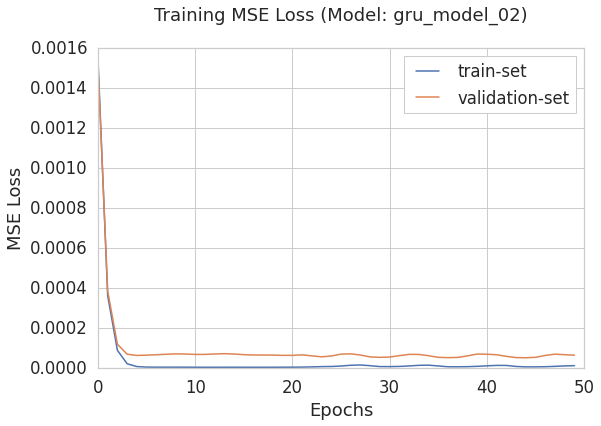

In [ ]:
# Plotting the loss 
plt.figure(figsize=(8.7,6.3))
plt.title('Training MSE Loss (Model: gru_model_02)',fontsize=18,y=1.07)
plt.plot(history.history['loss'], label = 'train-set')
plt.plot(history.history['val_loss'], label ='validation-set')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.tight_layout()
plt.legend()
# Save image with proper modelname
plt.savefig('/content/drive/MyDrive/___DBS_September 2021_anderskiss11/__DISSERTATION_DBS_APPLIED RESEARCH PAPER/__IMAGES & FILES_Dissertation/gru_model_02_loss_{}.png'.format(pkl_str),bbox_inches='tight',dpi=120)
# plt.savefig('gru_model_02_loss_.png'.format(pkl_str), bbox_inches='tight', dpi=120)

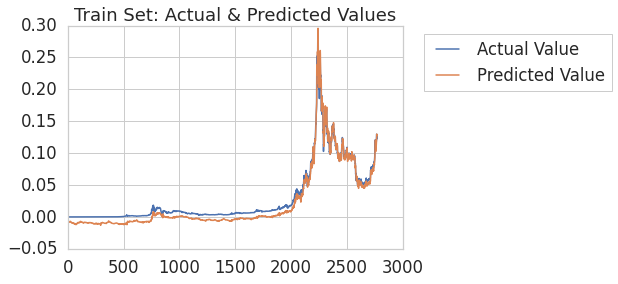

In [ ]:
# This is a one step forecast
y_pred_train = gru_model_02.predict(trainX)
plt.title('Train Set: Actual & Predicted Values')
plt.plot(trainY, label = 'Actual Value')
plt.plot(y_pred_train, label = 'Predicted Value')
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
# plt.legend(loc="upper left")
# plt.legend()

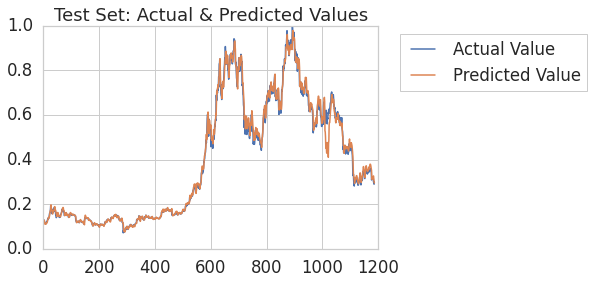

In [ ]:
# This is a one step forecast
y_pred = gru_model_02.predict(testX)
plt.title('Test Set: Actual & Predicted Values')
plt.plot(testY, label = 'Actual Value')
plt.plot(y_pred, label = 'Predicted Value')
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
# plt.legend(loc="upper left")
# plt.legend()

#### **EVALUATION Metric**

In [ ]:
# Measure RMSE error
gru_model_02_rmse_train = np.sqrt(metrics.mean_squared_error(y_pred_train,trainY)).round(5)
gru_model_02_rmse_test = np.sqrt(metrics.mean_squared_error(y_pred,testY)).round(5)
print("Train RMSE:\t{}".format(gru_model_02_rmse_train), "\nTest RMSE:\t{}".format(gru_model_02_rmse_test))
# CALCULATE Mean Absolute Percentage Error (MAPE)
gru_model_02_mape = (np.mean(np.abs((testY - y_pred) / testY)) * 100).round(2)
gru_model_02_acc = (100 - gru_model_02_mape).round(2)

print("\nMAPE:\t\t{}".format(gru_model_02_mape), "\nModel Accuracy:\t{}%\n".format(gru_model_02_acc))

Train RMSE:	0.0087 
Test RMSE:	0.02519

MAPE:		3.59 
Model Accuracy:	96.41%



#### **STORE Data**

In [ ]:
# STORE model information and evaluation metrics in a dictionary
gru_model_02_dict = {
                    'Model_name': 'gru_model_02',
                    'Model_Type': 'GRU',
                    'Model_Dataset': 'BTC + NDX',
                    'Samples (lookback)': samples,
                    'Total params' : 1217,
                    'Train_Split': '70%',
                    'Model_Epochs': 50,
                    'Hidden_Layers': '1L',
                    'Hidden_Neurons': '16 (1L)',
                    'RMSE_train_score':gru_model_02_rmse_train,
                    'RMSE_test_score':gru_model_02_rmse_test,
                    'MAPE':gru_model_02_mape,
                    'model_percent_acc':gru_model_02_acc
                    }
gru_model_02_dict

# DELETE
# plt.savefig('/content/drive/MyDrive/___DBS_September 2021_anderskiss11/__DISSERTATION_DBS_APPLIED RESEARCH PAPER/__IMAGES & FILES_Dissertation/gru_model_02_loss_{}.png'.format(pkl_str),bbox_inches='tight',dpi=120)
# plt.savefig('gru_model_02_loss_.png'.format(pkl_str), bbox_inches='tight', dpi=120)

{'Model_name': 'gru_model_02',
 'Model_Type': 'GRU',
 'Model_Dataset': 'BTC + NDX',
 'Samples (lookback)': 45,
 'Total params': 1217,
 'Train_Split': '70%',
 'Model_Epochs': 50,
 'Hidden_Layers': '1L',
 'Hidden_Neurons': '16 (1L)',
 'RMSE_train_score': 0.0087,
 'RMSE_test_score': 0.02519,
 'MAPE': 3.59,
 'model_percent_acc': 96.41}

In [ ]:
all_eval_df.head(12)

Model_name Model_Type                     Model_Dataset  \
0  lstm_model_01       LSTM                          BTC only   
1  lstm_model_02       LSTM                         BTC + NDX   
2  lstm_model_03       LSTM                      BTC + lumber   
3  lstm_model_04       LSTM            BTC + U.S. Debt-to-GDP   
4  lstm_model_05       LSTM  BTC + NDX + lumber + debt_to_gdp   
5   gru_model_01        GRU                          BTC only   

  Samples (lookback) Total params Train_Split Model_Epochs Hidden_Layers  \
0                 45         1489         70%           50            1L   
1                 45         1553         70%           50            1L   
2                 45         1553         70%           50            1L   
3                 45         1553         70%           50            1L   
4                 45         1681         70%           50            1L   
5                 45         1169         70%           50            1L   

  Hidden_Neurons  RMSE_train_score  RMSE_test_score   MAPE  Accuracy (%)  
0        16 (1L)           0.00583          0.03688   6.99         93.01  
1        16 (1L)           0.00861          0.03565   9.79         90.21  
2        16 (1L)           0.00541          0.13467  14.99         85.01  
3        16 (1L)           0.00546          0.16582  20.67         79.33  
4        16 (1L)           0.00593          0.15152  17.70         82.30  
5        16 (1L)           0.00484          0.03840   4.80         95.20

In [ ]:
# all_eval_df.drop([6,7], inplace=True)
all_eval_df = add_eval_dict(gru_model_02_dict, all_eval_df)
all_eval_df.head(12)

Model_name Model_Type                     Model_Dataset  \
0  lstm_model_01       LSTM                          BTC only   
1  lstm_model_02       LSTM                         BTC + NDX   
2  lstm_model_03       LSTM                      BTC + lumber   
3  lstm_model_04       LSTM            BTC + U.S. Debt-to-GDP   
4  lstm_model_05       LSTM  BTC + NDX + lumber + debt_to_gdp   
5   gru_model_01        GRU                          BTC only   
6   gru_model_02        GRU                         BTC + NDX   

  Samples (lookback) Total params Train_Split Model_Epochs Hidden_Layers  \
0                 45         1489         70%           50            1L   
1                 45         1553         70%           50            1L   
2                 45         1553         70%           50            1L   
3                 45         1553         70%           50            1L   
4                 45         1681         70%           50            1L   
5                 45         1169         70%           50            1L   
6                 45         1217         70%           50            1L   

  Hidden_Neurons  RMSE_train_score  RMSE_test_score   MAPE  Accuracy (%)  
0        16 (1L)           0.00583          0.03688   6.99         93.01  
1        16 (1L)           0.00861          0.03565   9.79         90.21  
2        16 (1L)           0.00541          0.13467  14.99         85.01  
3        16 (1L)           0.00546          0.16582  20.67         79.33  
4        16 (1L)           0.00593          0.15152  17.70         82.30  
5        16 (1L)           0.00484          0.03840   4.80         95.20  
6        16 (1L)           0.00870          0.02519   3.59         96.41

In [ ]:
all_eval_df.to_pickle('/content/drive/MyDrive/___DBS_September 2021_anderskiss11/__DISSERTATION_DBS_APPLIED RESEARCH PAPER/__IMAGES & FILES_Dissertation/gru_model_02_eval_metrics_{}.pkl'.format(pkl_str))
print("Dataframe saved to .pkl")

# all_eval_df = pickle.load(open('/content/drive/MyDrive/___DBS_September 2021_anderskiss11/__DISSERTATION_DBS_APPLIED RESEARCH PAPER/__IMAGES & FILES_Dissertation/gru_model_02_eval_metrics_29Aug2022_0818.pkl', 'rb'))
# all_eval_df.head()

Dataframe saved to .pkl


#### **MAKE Prediction**

In [ ]:
# MAKE FORECAST PREDICTION
forecast = gru_model_02.predict(X[-samples:])
print(len(forecast))

# MAKE COPIES OF PREDICTED VALUE IN ORDER TO MATCH THE EXPECTED SHAPE WHEN INVERSING
forecast_copies = np.repeat(forecast, btc_bonds_indices_df_to_model.shape[1], axis=-1)
print(forecast_copies)

45
[[0.3411925  0.3411925  0.3411925  0.3411925  0.3411925  0.3411925
  0.3411925  0.3411925 ]
 [0.344609   0.344609   0.344609   0.344609   0.344609   0.344609
  0.344609   0.344609  ]
 [0.34652188 0.34652188 0.34652188 0.34652188 0.34652188 0.34652188
  0.34652188 0.34652188]
 [0.35273153 0.35273153 0.35273153 0.35273153 0.35273153 0.35273153
  0.35273153 0.35273153]
 [0.36314133 0.36314133 0.36314133 0.36314133 0.36314133 0.36314133
  0.36314133 0.36314133]
 [0.3720219  0.3720219  0.3720219  0.3720219  0.3720219  0.3720219
  0.3720219  0.3720219 ]
 [0.37240037 0.37240037 0.37240037 0.37240037 0.37240037 0.37240037
  0.37240037 0.37240037]
 [0.37374642 0.37374642 0.37374642 0.37374642 0.37374642 0.37374642
  0.37374642 0.37374642]
 [0.37061018 0.37061018 0.37061018 0.37061018 0.37061018 0.37061018
  0.37061018 0.37061018]
 [0.37009212 0.37009212 0.37009212 0.37009212 0.37009212 0.37009212
  0.37009212 0.37009212]
 [0.36470363 0.36470363 0.36470363 0.36470363 0.36470363 0.36470363
  0

In [ ]:
# INVERSE SCALER
# forecast_scaled = stnd_scaler.inverse_transform(prediction_copies)[:,0]
forecast_scaled = min_max_scaler.inverse_transform(forecast_copies)[:,0]
print(len(forecast_scaled))
forecast_scaled[-5:]

45


array([23827.193, 23820.951, 23608.246, 23091.473, 22719.287],
      dtype=float32)

In [ ]:
# INVERSE testY data for comparison of 
copies_test = np.repeat(testY, btc_bonds_indices_df_to_model.shape[1], axis=-1)
print(copies_test)

# MINMAX SCALER on testY
# forecast_scaled_testY = stnd_scaler.inverse_transform(copies_test)[:,0]
scaled_testY = min_max_scaler.inverse_transform(copies_test)[:,0]
print(len(scaled_testY))
scaled_testY[-5:]

[[0.12671138 0.12671138 0.12671138 ... 0.12671138 0.12671138 0.12671138]
 [0.12652479 0.12652479 0.12652479 ... 0.12652479 0.12652479 0.12652479]
 [0.12923338 0.12923338 0.12923338 ... 0.12923338 0.12923338 0.12923338]
 ...
 [0.29665506 0.29665506 0.29665506 ... 0.29665506 0.29665506 0.29665506]
 [0.28949188 0.28949188 0.28949188 ... 0.28949188 0.28949188 0.28949188]
 [0.30124441 0.30124441 0.30124441 ... 0.30124441 0.30124441 0.30124441]]
1187


array([21565.4, 20249.9, 20033.9, 19550.2, 20343.8])

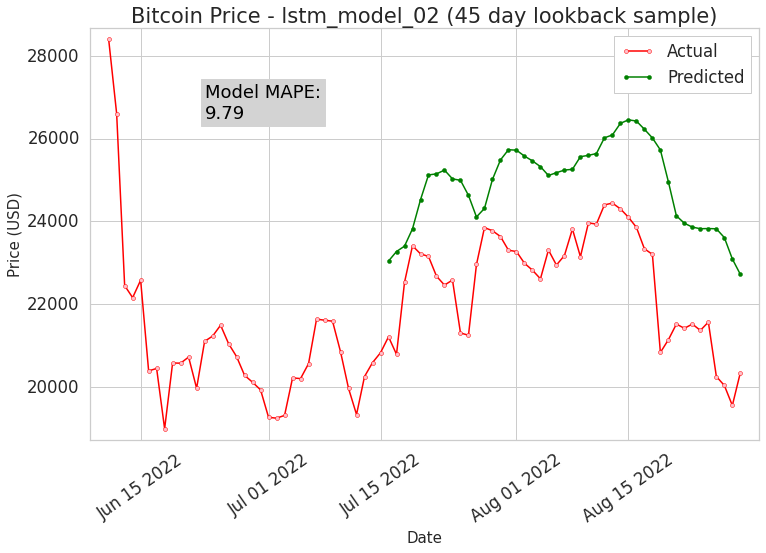

In [ ]:
plt.figure(figsize=(12,7.4))
plt.plot(btc_bonds_indices_df_to_model.index[-80:], scaled_testY[-80:], marker='.', markerfacecolor='pink',markersize=8, color='red', label='Actual')
plt.plot(btc_bonds_indices_df_to_model.index[-45:], forecast_scaled, marker='.', markerfacecolor='green', markersize=8, color='green', label='Predicted')
plt.title('Bitcoin Price - gru_model_02 (45 day lookback sample)', fontsize=21)
plt.xlabel('Date',fontsize=15)
plt.ylabel('Price (USD)',fontsize=15)
plt.margins(0.03)

plt.text(dt.date(2022,6,23),26500, "Model MAPE:\n{}".format(gru_model_02_mape),color='black',backgroundcolor='lightgrey')

plt.xticks(rotation=35)
# plt.grid(True, color='lightgrey')
plt.grid(True)
plt.legend()
plt.show()

### **gru_model_03 - GRU Baseline + 'lumber' (samples=45 days)**
lumber => feature from Commodities category

#### **COPY dataset**

In [ ]:
btc_comm_df_to_model = pd.read_csv(r'/content/drive/MyDrive/___DBS_September 2021_anderskiss11/__DISSERTATION_DBS_APPLIED RESEARCH PAPER/___CODE_Dissertation/_CSV/btc_comm_df_to_model.csv',index_col=0)
print(type(btc_comm_df_to_model.index))
btc_comm_df_to_model = btc_comm_df_to_model.set_index(pd.to_datetime(btc_comm_df_to_model.index))
print(type(btc_comm_df_to_model.index))
print('Model loaded from .CSV')

btc_comm_df_to_model.head(3)

<class 'pandas.core.indexes.base.Index'>
<class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Model loaded from .CSV


BTC  Open  High  Low  BTC_vol    BTC_RSI    BTC_log    gold  \
2011-09-14  5.6   5.8   5.8  5.3  43768.0  31.804028  -3.509132  1826.5   
2011-09-15  4.8   5.6   5.6  4.4  86221.0  26.586215 -15.415068  1781.4   
2011-09-16  4.8   4.8   5.0  4.6  31651.0  26.586215   0.000000  1814.7   

             wheat    gas  lumber    oil  copper   nickel  
2011-09-14  704.00  4.039   237.2  88.91   3.885  21364.0  
2011-09-15  697.75  3.878   244.2  89.40   3.945  21785.0  
2011-09-16  693.38  3.809   244.6  87.96   3.920  21486.0

In [ ]:
btc_comm_df_to_model.drop(['gold','wheat','gas','oil','copper','nickel'], axis = 1, inplace=True)
btc_comm_df_to_model.head(3)

BTC  Open  High  Low  BTC_vol    BTC_RSI    BTC_log  lumber
2011-09-14  5.6   5.8   5.8  5.3  43768.0  31.804028  -3.509132   237.2
2011-09-15  4.8   5.6   5.6  4.4  86221.0  26.586215 -15.415068   244.2
2011-09-16  4.8   4.8   5.0  4.6  31651.0  26.586215   0.000000   244.6

In [ ]:
df_sanity_check(btc_bonds_indices_df_to_model)

SHAPE of df is:		 (4003, 8)
NaN in df present?	 False
NaN count in df:	 0
COLUMNS in df:
	 BTC
	 Open
	 High
	 Low
	 BTC_vol
	 BTC_RSI
	 BTC_log
	 NDX


In [ ]:
# CONVERT dates from DatetimeIndex object to Series
date_range = df_dates.to_series()
print(type(date_range))
date_range[-3:]

<class 'pandas.core.series.Series'>


2022-08-27   2022-08-27
2022-08-28   2022-08-28
2022-08-29   2022-08-29
dtype: datetime64[ns]

In [ ]:
date_range.shape

(4003,)

#### **SCALE data**

In [ ]:
# SCALE data
# for multivariate example
cols = btc_comm_df_to_model.columns
x = btc_comm_df_to_model.values #returns a numpy array

# MINMAX Scaler
min_max_scaler = MinMaxScaler()
scaled_data = min_max_scaler.fit_transform(btc_comm_df_to_model)
scaled_data
# Standard Scaler
# stnd_scaler = StandardScaler()
# scaled_data = stnd_scaler.fit_transform(btc_comm_df_to_model)
# scaled_data

array([[5.33128770e-05, 5.62740368e-05, 5.07332403e-05, ...,
        2.52914840e-01, 3.50294611e-01, 1.76961150e-02],
       [4.14655710e-05, 5.33122454e-05, 4.78341980e-05, ...,
        1.92181695e-01, 2.99042383e-01, 2.24421995e-02],
       [4.14655710e-05, 4.14650797e-05, 3.91370711e-05, ...,
        1.92181695e-01, 3.65400591e-01, 2.27134043e-02],
       ...,
       [2.96655061e-01, 2.99850281e-01, 2.94851446e-01, ...,
        2.50867832e-01, 3.60784156e-01, 2.11878771e-01],
       [2.89491884e-01, 2.96655989e-01, 2.92056769e-01, ...,
        2.22822051e-01, 3.54879612e-01, 2.12488982e-01],
       [2.99600598e-01, 2.89504744e-01, 2.95589252e-01, ...,
        3.08310814e-01, 3.80174335e-01, 2.02522205e-01]])

In [ ]:
gru_model_03_scaled = pd.DataFrame(scaled_data)
gru_model_03_scaled.columns = cols
gru_model_03_scaled.index = date_range
gru_model_03_scaled.head(3)

BTC      Open      High       Low   BTC_vol   BTC_RSI  \
2011-09-14  0.000053  0.000056  0.000051  0.000050  0.000010  0.252915   
2011-09-15  0.000041  0.000053  0.000048  0.000036  0.000019  0.192182   
2011-09-16  0.000041  0.000041  0.000039  0.000039  0.000007  0.192182   

             BTC_log    lumber  
2011-09-14  0.350295  0.017696  
2011-09-15  0.299042  0.022442  
2011-09-16  0.365401  0.022713

In [ ]:
# VERIFY data shape
gru_model_03_scaled.shape

(4003, 8)

In [ ]:
gru_model_03_scaled.iloc[:3, :1]

BTC
2011-09-14  0.000053
2011-09-15  0.000041
2011-09-16  0.000041

#### **RESHAPE data**
**shapes includes: sample, time steps, features**

In [ ]:
# models need data in the form [sample, timesteps, features]

samples = 45 # samples
steps = 1 # timesteps
X = []
Y = []
for i in range(gru_model_03_scaled.shape[0] - samples):
    # ENSURE INDEX RANGE for X matches input range 
    # use Open,High,Low to predict Close
    X.append(gru_model_03_scaled.iloc[i:i+samples, 1:].values) # Independent Samples
    Y.append(gru_model_03_scaled.iloc[i+samples, :1].values) # Dependent Samples
print('Training Data length:',len(X[0:1][0]),'\n', X[0:1])
print('\nTesting Data length:', len(Y[0:1]),'\n', Y[0:1])

Training Data length: 45 
 [array([[5.62740368e-05, 5.07332403e-05, 4.97490687e-05, 9.73527780e-06,
        2.52914840e-01, 3.50294611e-01, 1.76961150e-02],
       [5.33122454e-05, 4.78341980e-05, 3.61811409e-05, 1.92353640e-05,
        1.92181695e-01, 2.99042383e-01, 2.24421995e-02],
       [4.14650797e-05, 3.91370711e-05, 3.91962360e-05, 7.02374872e-06,
        1.92181695e-01, 3.65400591e-01, 2.27134043e-02],
       [4.14650797e-05, 3.76875499e-05, 4.07037835e-05, 4.48430562e-06,
        1.92181695e-01, 3.65400591e-01, 2.27134043e-02],
       [4.14650797e-05, 4.78341980e-05, 4.07037835e-05, 9.92683255e-06,
        2.71593434e-01, 3.99857076e-01, 2.27134043e-02],
       [4.73886626e-05, 4.78341980e-05, 4.37188786e-05, 1.10933920e-05,
        3.25710822e-01, 3.89545775e-01, 2.04081633e-02],
       [5.18313497e-05, 6.52284518e-05, 5.12566162e-05, 2.60673342e-05,
        4.19959672e-01, 4.09972395e-01, 2.29846091e-02],
       [6.07167239e-05, 5.79808460e-05, 4.67339736e-05, 1.51945881e-0

In [ ]:
type(X)

list

In [ ]:
# Convert data from list to array for modeling
print("Original datatype for X is:\t", type(X))
print("- - - - - - - - - - - - - - - - - - - - -")
X = np.array(X)
Y = np.array(Y)
print("Converted datatype for X is:\t", type(X))
print('\nX Shape: ', X.shape, '\nY Shape: ', Y.shape)

Original datatype for X is:	 <class 'list'>
- - - - - - - - - - - - - - - - - - - - -
Converted datatype for X is:	 <class 'numpy.ndarray'>

X Shape:  (3958, 45, 7) 
Y Shape:  (3958, 1)


In [ ]:
# ESTABLISH training and testing sets
split_data = round(0.7 * X.shape[0])
trainX, trainY = X[:split_data], Y[:split_data]
testX, testY =  X[split_data:], Y[split_data:]
print('Train Set (input and output arrays):\n','TRAIN INPUTS: ',trainX.shape,'\t\tTRAIN OUTPUT: ',trainY.shape,'\n\nTest Set (input and output arrays):\n','TEST INPUTS: ',testX.shape,'\t\tTEST OUTPUT: ', testY.shape)

Train Set (input and output arrays):
 TRAIN INPUTS:  (2771, 45, 7) 		TRAIN OUTPUT:  (2771, 1) 

Test Set (input and output arrays):
 TEST INPUTS:  (1187, 45, 7) 		TEST OUTPUT:  (1187, 1)


#### **BUILD / TRAIN / SAVE Model**

In [ ]:
# VERIFY that the same train/test sets are used
# Reshaped data
print('X Shape: ', X.shape, '\nY Shape: ', Y.shape)

X Shape:  (3958, 45, 7) 
Y Shape:  (3958, 1)


In [ ]:
# VERIFY training and testing sets
print("\n# # # SPLIT DATASETS: # # #\n")
print('Train Set Input:',trainX.shape,'\t\tTrain Set Output:', trainY.shape)
print("\n- - - - - - - - - - - - -\n")      
print('\nTest Set Input:',testX.shape,'\t\tTest Set Output:', testY.shape)


# # # SPLIT DATASETS: # # #

Train Set Input: (2771, 45, 7) 		Train Set Output: (2771, 1)

- - - - - - - - - - - - -


Test Set Input: (1187, 45, 7) 		Test Set Output: (1187, 1)


In [ ]:
# BUILD the GRU
gru_model_03 = keras.Sequential()
gru_model_03.add(layers.GRU(16,
                             input_shape=(trainX.shape[1], trainX.shape[2])))

# Add a Dense layer with 1 units
gru_model_03.add(layers.Dense(1))
gru_model_03.compile(optimizer='adam',loss='mean_squared_error',metrics='MeanSquaredError')
gru_model_03.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 16)                1536      
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1,553
Trainable params: 1,553
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# fit the model
history = gru_model_03.fit(trainX,
                        trainY,
                        shuffle = False, 
                        epochs=50,
                        batch_size=15,
                        validation_split=0.2,
                        verbose=1)

pickle.dump(gru_model_03, open("/content/drive/MyDrive/___DBS_September 2021_anderskiss11/__DISSERTATION_DBS_APPLIED RESEARCH PAPER/___CODE_Dissertation/_MODELS/gru_model_03_{}.pkl".format(pkl_str), "wb"))
# gru_model_03 = pickle.load(open('/content/drive/MyDrive/___DBS_September 2021_anderskiss11/__DISSERTATION_DBS_APPLIED RESEARCH PAPER/___CODE_Dissertation/_MODELS/gru_model_03_____.pk', 'rb'))
print("\nModel:\tgru_model_03 successfully saved to .pkl file")


Epoch 1/50
148/148 [==============================] - 11s 32ms/step - loss: 2.4511e-04 - mean_squared_error: 2.4511e-04 - val_loss: 5.6850e-04 - val_mean_squared_error: 5.6850e-04
Epoch 2/50
148/148 [==============================] - 5s 31ms/step - loss: 1.3120e-04 - mean_squared_error: 1.3120e-04 - val_loss: 3.3171e-04 - val_mean_squared_error: 3.3171e-04
Epoch 3/50
148/148 [==============================] - 4s 30ms/step - loss: 5.0784e-05 - mean_squared_error: 5.0784e-05 - val_loss: 2.7142e-04 - val_mean_squared_error: 2.7142e-04
Epoch 4/50
148/148 [==============================] - 4s 30ms/step - loss: 1.6964e-05 - mean_squared_error: 1.6964e-05 - val_loss: 2.5517e-04 - val_mean_squared_error: 2.5517e-04
Epoch 5/50
148/148 [==============================] - 4s 29ms/step - loss: 1.0436e-05 - mean_squared_error: 1.0436e-05 - val_loss: 2.3353e-04 - val_mean_squared_error: 2.3353e-04
Epoch 6/50
148/148 [==============================] - 5s 31ms/step - loss: 8.1420e-06 - mean_squared_err


Model:	gru_model_03 successfully saved to .pkl file


In [ ]:
# gru_model_03 = pickle.load(open("/content/drive/MyDrive/___DBS_September 2021_anderskiss11/__DISSERTATION_DBS_APPLIED RESEARCH PAPER/___CODE_Dissertation/_MODELS/_____.pkl", "rb"))
# print("gru_model_03 successfully loaded!")

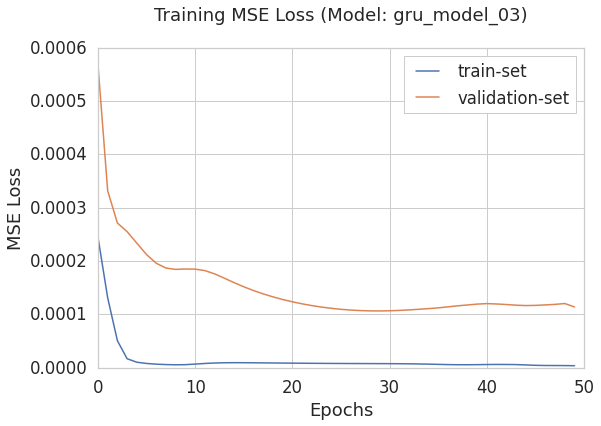

In [ ]:
# Plotting the loss 
plt.figure(figsize=(8.7,6.3))
plt.title('Training MSE Loss (Model: gru_model_03)',fontsize=18,y=1.07)
plt.plot(history.history['loss'], label = 'train-set')
plt.plot(history.history['val_loss'], label ='validation-set')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.tight_layout()
plt.legend()
# Save image with proper modelname
# plt.savefig('/content/drive/MyDrive/___DBS_September 2021_anderskiss11/__DISSERTATION_DBS_APPLIED RESEARCH PAPER/__IMAGES & FILES_Dissertation/gru_model_03_loss_{}.png'.format(pkl_str),bbox_inches='tight',dpi=120)
# plt.savefig('lstm_model_03_loss_.png'.format(pkl_str), bbox_inches='tight', dpi=120)

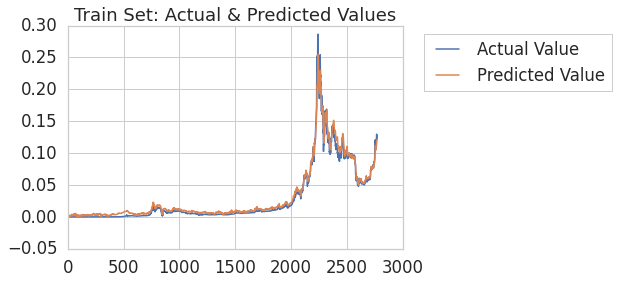

In [ ]:
# This is a one step forecast
y_pred_train = gru_model_03.predict(trainX)
plt.title('Train Set: Actual & Predicted Values')
plt.plot(trainY, label = 'Actual Value')
plt.plot(y_pred_train, label = 'Predicted Value')
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
# plt.legend(loc="upper left")
# plt.legend()

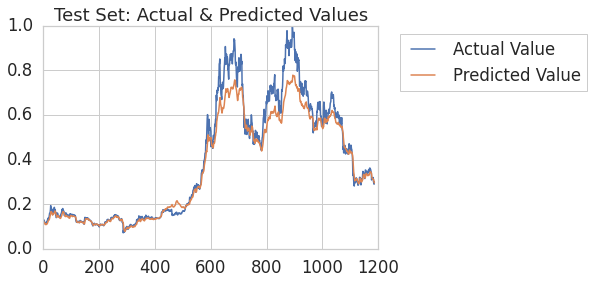

In [ ]:
# This is a one step forecast
y_pred = gru_model_03.predict(testX)
plt.title('Test Set: Actual & Predicted Values')
plt.plot(testY, label = 'Actual Value')
plt.plot(y_pred, label = 'Predicted Value')
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
# plt.legend(loc="upper left")
# plt.legend()

#### **EVALUATION Metric**

In [ ]:
# Measure RMSE error
gru_model_03_rmse_train = np.sqrt(metrics.mean_squared_error(y_pred_train,trainY)).round(5)
gru_model_03_rmse_test = np.sqrt(metrics.mean_squared_error(y_pred,testY)).round(5)
print("Train RMSE:\t{}".format(gru_model_03_rmse_train), "\nTest RMSE:\t{}".format(gru_model_03_rmse_test))
# CALCULATE Mean Absolute Percentage Error (MAPE)
gru_model_03_mape = (np.mean(np.abs((testY - y_pred) / testY)) * 100).round(2)
gru_model_03_acc = (100 - gru_model_03_mape).round(2)

print("\nMAPE:\t\t{}".format(gru_model_03_mape), "\nModel Accuracy:\t{}%\n".format(gru_model_03_acc))

Train RMSE:	0.00574 
Test RMSE:	0.06289

MAPE:		7.72 
Model Accuracy:	92.28%



#### **STORE Data**

In [ ]:
# STORE model information and evaluation metrics in a dictionary
gru_model_03_dict = {
                    'Model_name': 'gru_model_03',
                    'Model_Type': 'GRU',
                    'Model_Dataset': 'BTC only',
                    'Samples (lookback)': samples,
                    'Total params' : 1553,
                    'Train_Split': '70%',
                    'Model_Epochs': 50,
                    'Hidden_Layers': '1L',
                    'Hidden_Neurons': '16 (1L)',
                    'RMSE_train_score':gru_model_03_rmse_train,
                    'RMSE_test_score':gru_model_03_rmse_test,
                    'MAPE':gru_model_03_mape,
                    'model_percent_acc':gru_model_03_acc
                    }
gru_model_03_dict

{'Model_name': 'gru_model_03',
 'Model_Type': 'GRU',
 'Model_Dataset': 'BTC only',
 'Samples (lookback)': 45,
 'Total params': 1553,
 'Train_Split': '70%',
 'Model_Epochs': 50,
 'Hidden_Layers': '1L',
 'Hidden_Neurons': '16 (1L)',
 'RMSE_train_score': 0.00574,
 'RMSE_test_score': 0.06289,
 'MAPE': 7.72,
 'model_percent_acc': 92.28}

In [ ]:
all_eval_df.head(12)

Model_name Model_Type                     Model_Dataset  \
0  lstm_model_01       LSTM                          BTC only   
1  lstm_model_02       LSTM                         BTC + NDX   
2  lstm_model_03       LSTM                      BTC + lumber   
3  lstm_model_04       LSTM            BTC + U.S. Debt-to-GDP   
4  lstm_model_05       LSTM  BTC + NDX + lumber + debt_to_gdp   
5   gru_model_01        GRU                          BTC only   
6   gru_model_02        GRU                         BTC + NDX   

  Samples (lookback) Total params Train_Split Model_Epochs Hidden_Layers  \
0                 45         1489         70%           50            1L   
1                 45         1553         70%           50            1L   
2                 45         1553         70%           50            1L   
3                 45         1553         70%           50            1L   
4                 45         1681         70%           50            1L   
5                 45         1169         70%           50            1L   
6                 45         1217         70%           50            1L   

  Hidden_Neurons  RMSE_train_score  RMSE_test_score   MAPE  Accuracy (%)  
0        16 (1L)           0.00583          0.03688   6.99         93.01  
1        16 (1L)           0.00861          0.03565   9.79         90.21  
2        16 (1L)           0.00541          0.13467  14.99         85.01  
3        16 (1L)           0.00546          0.16582  20.67         79.33  
4        16 (1L)           0.00593          0.15152  17.70         82.30  
5        16 (1L)           0.00484          0.03840   4.80         95.20  
6        16 (1L)           0.00870          0.02519   3.59         96.41

In [ ]:
# all_eval_df.drop([1], inplace=True)
all_eval_df = add_eval_dict(gru_model_03_dict, all_eval_df)
all_eval_df.head(12)

Model_name Model_Type                     Model_Dataset  \
0  lstm_model_01       LSTM                          BTC only   
1  lstm_model_02       LSTM                         BTC + NDX   
2  lstm_model_03       LSTM                      BTC + lumber   
3  lstm_model_04       LSTM            BTC + U.S. Debt-to-GDP   
4  lstm_model_05       LSTM  BTC + NDX + lumber + debt_to_gdp   
5   gru_model_01        GRU                          BTC only   
6   gru_model_02        GRU                         BTC + NDX   
7   gru_model_03        GRU                          BTC only   

  Samples (lookback) Total params Train_Split Model_Epochs Hidden_Layers  \
0                 45         1489         70%           50            1L   
1                 45         1553         70%           50            1L   
2                 45         1553         70%           50            1L   
3                 45         1553         70%           50            1L   
4                 45         1681         70%           50            1L   
5                 45         1169         70%           50            1L   
6                 45         1217         70%           50            1L   
7                 45         1553         70%           50            1L   

  Hidden_Neurons  RMSE_train_score  RMSE_test_score   MAPE  Accuracy (%)  
0        16 (1L)           0.00583          0.03688   6.99         93.01  
1        16 (1L)           0.00861          0.03565   9.79         90.21  
2        16 (1L)           0.00541          0.13467  14.99         85.01  
3        16 (1L)           0.00546          0.16582  20.67         79.33  
4        16 (1L)           0.00593          0.15152  17.70         82.30  
5        16 (1L)           0.00484          0.03840   4.80         95.20  
6        16 (1L)           0.00870          0.02519   3.59         96.41  
7        16 (1L)           0.00574          0.06289   7.72         92.28

In [ ]:
all_eval_df.to_pickle('/content/drive/MyDrive/___DBS_September 2021_anderskiss11/__DISSERTATION_DBS_APPLIED RESEARCH PAPER/__IMAGES & FILES_Dissertation/gru_model_03_eval_metrics_{}.pkl'.format(pkl_str))
print("Dataframe saved to .pkl")

# all_eval_df = pickle.load(open('/content/drive/MyDrive/___DBS_September 2021_anderskiss11/__DISSERTATION_DBS_APPLIED RESEARCH PAPER/__IMAGES & FILES_Dissertation/gru_model_03_eval_metrics_29Aug2022_0818.pkl', 'rb'))
# all_eval_df.head()

Dataframe saved to .pkl


#### **MAKE Prediction**

In [ ]:
# MAKE FORECAST PREDICTION
forecast = gru_model_03.predict(X[-samples:])
print(len(forecast))

# MAKE COPIES OF PREDICTED VALUE IN ORDER TO MATCH THE EXPECTED SHAPE WHEN INVERSING
forecast_copies = np.repeat(forecast, btc_comm_df_to_model.shape[1], axis=-1)
print(forecast_copies)

45
[[0.3411925  0.3411925  0.3411925  0.3411925  0.3411925  0.3411925
  0.3411925  0.3411925 ]
 [0.344609   0.344609   0.344609   0.344609   0.344609   0.344609
  0.344609   0.344609  ]
 [0.34652188 0.34652188 0.34652188 0.34652188 0.34652188 0.34652188
  0.34652188 0.34652188]
 [0.35273153 0.35273153 0.35273153 0.35273153 0.35273153 0.35273153
  0.35273153 0.35273153]
 [0.36314133 0.36314133 0.36314133 0.36314133 0.36314133 0.36314133
  0.36314133 0.36314133]
 [0.3720219  0.3720219  0.3720219  0.3720219  0.3720219  0.3720219
  0.3720219  0.3720219 ]
 [0.37240037 0.37240037 0.37240037 0.37240037 0.37240037 0.37240037
  0.37240037 0.37240037]
 [0.37374642 0.37374642 0.37374642 0.37374642 0.37374642 0.37374642
  0.37374642 0.37374642]
 [0.37061018 0.37061018 0.37061018 0.37061018 0.37061018 0.37061018
  0.37061018 0.37061018]
 [0.37009212 0.37009212 0.37009212 0.37009212 0.37009212 0.37009212
  0.37009212 0.37009212]
 [0.36470363 0.36470363 0.36470363 0.36470363 0.36470363 0.36470363
  0

In [ ]:
# INVERSE SCALER
# forecast_scaled = stnd_scaler.inverse_transform(prediction_copies)[:,0]
forecast_scaled = min_max_scaler.inverse_transform(forecast_copies)[:,0]
print(len(forecast_scaled))
forecast_scaled[-5:]

45


array([23827.193, 23820.951, 23608.246, 23091.473, 22719.287],
      dtype=float32)

In [ ]:
# INVERSE testY data for comparison of 
copies_test = np.repeat(testY, btc_comm_df_to_model.shape[1], axis=-1)
print(copies_test)

# MINMAX SCALER on testY
# forecast_scaled_testY = stnd_scaler.inverse_transform(copies_test)[:,0]
scaled_testY = min_max_scaler.inverse_transform(copies_test)[:,0]
print(len(scaled_testY))
scaled_testY[-5:]

[[0.12671138 0.12671138 0.12671138 ... 0.12671138 0.12671138 0.12671138]
 [0.12652479 0.12652479 0.12652479 ... 0.12652479 0.12652479 0.12652479]
 [0.12923338 0.12923338 0.12923338 ... 0.12923338 0.12923338 0.12923338]
 ...
 [0.29665506 0.29665506 0.29665506 ... 0.29665506 0.29665506 0.29665506]
 [0.28949188 0.28949188 0.28949188 ... 0.28949188 0.28949188 0.28949188]
 [0.30124441 0.30124441 0.30124441 ... 0.30124441 0.30124441 0.30124441]]
1187


array([21565.4, 20249.9, 20033.9, 19550.2, 20343.8])

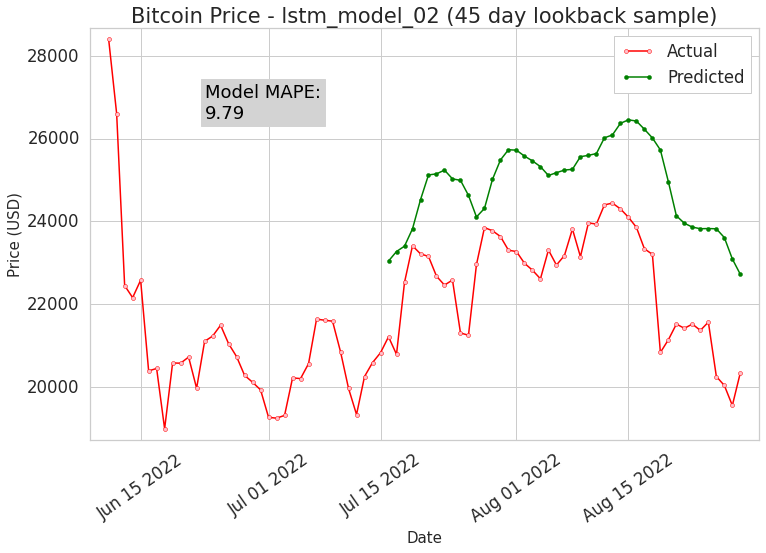

In [ ]:
plt.figure(figsize=(12,7.4))
plt.plot(btc_bonds_indices_df_to_model.index[-80:], scaled_testY[-80:], marker='.', markerfacecolor='pink',markersize=8, color='red', label='Actual')
plt.plot(btc_bonds_indices_df_to_model.index[-45:], forecast_scaled, marker='.', markerfacecolor='green', markersize=8, color='green', label='Predicted')
plt.title('Bitcoin Price - gru_model_03 (45 day lookback sample)', fontsize=21)
plt.xlabel('Date',fontsize=15)
plt.ylabel('Price (USD)',fontsize=15)
plt.margins(0.03)

plt.text(dt.date(2022,6,23),26500, "Model MAPE:\n{}".format(lstm_model_03_mape),color='black',backgroundcolor='lightgrey')

plt.xticks(rotation=35)
# plt.grid(True, color='lightgrey')
plt.grid(True)
plt.legend()
plt.show()

### **gru_model_04 - GRU Baseline + 'debt_to_gdp' (samples=45 days)**
debt_to_gdp => corresponds to the U.S. Federal Debt as a Percentage of Gross Domestic Product (feature from **Macroeconomic Metrics** category)

#### **COPY dataset**

In [ ]:
# btc_macro_df_to_model = pd.read_csv(r'/content/drive/MyDrive/___DBS_September 2021_anderskiss11/__DISSERTATION_DBS_APPLIED RESEARCH PAPER/___CODE_Dissertation/_CSV/btc_macro_df_to_model.csv',index_col=0)
# print('Model loaded from .CSV')
# print(type(btc_macro_df_to_model.index))
# btc_macro_df_to_model = btc_macro_df_to_model.set_index(pd.to_datetime(btc_macro_df_to_model.index))
# print(type(btc_macro_df_to_model.index))

btc_macro_df_to_model
btc_macro_df_to_model.head(3)

BTC  Open  High  Low  BTC_vol    BTC_RSI    BTC_log  debt_to_gdp
2011-09-14  5.6   5.8   5.8  5.3  43768.0  31.804028  -3.509132     94.52097
2011-09-15  4.8   5.6   5.6  4.4  86221.0  26.586215 -15.415068     94.52097
2011-09-16  4.8   4.8   5.0  4.6  31651.0  26.586215   0.000000     94.52097

In [ ]:
print(btc_macro_df_to_model.index.dtype)
print(type(btc_macro_df_to_model.index))

btc_macro_df_to_model.head(3)
print(btc_macro_df_to_model.index.dtype)

datetime64[ns]
<class 'pandas.core.indexes.datetimes.DatetimeIndex'>
datetime64[ns]


In [ ]:
df_sanity_check(btc_macro_df_to_model)

SHAPE of df is:		 (4007, 8)
NaN in df present?	 False
NaN count in df:	 0
COLUMNS in df:
	 BTC
	 Open
	 High
	 Low
	 BTC_vol
	 BTC_RSI
	 BTC_log
	 debt_to_gdp


In [ ]:
df_dates = pd.to_datetime(btc_macro_df_to_model.index)
df_dates[:3]

DatetimeIndex(['2011-09-14', '2011-09-15', '2011-09-16'], dtype='datetime64[ns]', freq=None)

In [ ]:
# CONVERT dates from DatetimeIndex object to Series
date_range = df_dates.to_series()
print(type(date_range))
date_range[-3:]

<class 'pandas.core.series.Series'>


2022-08-31   2022-08-31
2022-09-01   2022-09-01
2022-09-02   2022-09-02
dtype: datetime64[ns]

In [ ]:
date_range.shape

(4007,)

#### **SCALE data**

In [ ]:
# SCALE data
# for multivariate example
cols = btc_macro_df_to_model.columns
x = btc_macro_df_to_model.values #returns a numpy array

# MINMAX Scaler
min_max_scaler = MinMaxScaler()
scaled_data = min_max_scaler.fit_transform(btc_macro_df_to_model)
scaled_data
# Standard Scaler
# stnd_scaler = StandardScaler()
# scaled_data = stnd_scaler.fit_transform(btc_macro_df_to_model)
# scaled_data

array([[5.33128770e-05, 5.62740368e-05, 5.07332403e-05, ...,
        2.52914840e-01, 3.50294611e-01, 0.00000000e+00],
       [4.14655710e-05, 5.33122454e-05, 4.78341980e-05, ...,
        1.92181695e-01, 2.99042383e-01, 0.00000000e+00],
       [4.14655710e-05, 4.14650797e-05, 3.91370711e-05, ...,
        1.92181695e-01, 3.65400591e-01, 0.00000000e+00],
       ...,
       [2.96803153e-01, 2.93089993e-01, 2.96670595e-01, ...,
        3.12470281e-01, 3.70831797e-01, 6.87700386e-01],
       [2.98020463e-01, 2.96888490e-01, 2.92809071e-01, ...,
        3.22418259e-01, 3.67162363e-01, 6.87700386e-01],
       [2.97247427e-01, 2.98098382e-01, 2.93832432e-01, ...,
        3.18381493e-01, 3.64282637e-01, 6.87700386e-01]])

In [ ]:
gru_model_04_scaled = pd.DataFrame(scaled_data)
gru_model_04_scaled.columns = cols
gru_model_04_scaled.index = date_range
gru_model_04_scaled.head(3)

BTC      Open      High       Low   BTC_vol   BTC_RSI  \
2011-09-14  0.000053  0.000056  0.000051  0.000050  0.000010  0.252915   
2011-09-15  0.000041  0.000053  0.000048  0.000036  0.000019  0.192182   
2011-09-16  0.000041  0.000041  0.000039  0.000039  0.000007  0.192182   

             BTC_log  debt_to_gdp  
2011-09-14  0.350295          0.0  
2011-09-15  0.299042          0.0  
2011-09-16  0.365401          0.0

In [ ]:
# VERIFY data shape
gru_model_04_scaled.shape

(4007, 8)

In [ ]:
gru_model_04_scaled.iloc[:3, :1]

BTC
2011-09-14  0.000053
2011-09-15  0.000041
2011-09-16  0.000041

#### **RESHAPE data**
**shapes includes: sample, time steps, features**

In [ ]:
# models need data in the form [sample, timesteps, features]

samples = 45 # samples
steps = 1 # timesteps
X = []
Y = []
for i in range(gru_model_04_scaled.shape[0] - samples):
    # ENSURE INDEX RANGE for X matches input range 
    # use Open,High,Low to predict Close
    X.append(gru_model_04_scaled.iloc[i:i+samples, 1:].values) # Independent Samples
    Y.append(gru_model_04_scaled.iloc[i+samples, :1].values) # Dependent Samples
print('Training Data length:',len(X[0:1][0]),'\n', X[0:1])
print('\nTesting Data length:', len(Y[0:1]),'\n', Y[0:1])

Training Data length: 45 
 [array([[5.62740368e-05, 5.07332403e-05, 4.97490687e-05, 9.73527780e-06,
        2.52914840e-01, 3.50294611e-01, 0.00000000e+00],
       [5.33122454e-05, 4.78341980e-05, 3.61811409e-05, 1.92353640e-05,
        1.92181695e-01, 2.99042383e-01, 0.00000000e+00],
       [4.14650797e-05, 3.91370711e-05, 3.91962360e-05, 7.02374872e-06,
        1.92181695e-01, 3.65400591e-01, 0.00000000e+00],
       [4.14650797e-05, 3.76875499e-05, 4.07037835e-05, 4.48430562e-06,
        1.92181695e-01, 3.65400591e-01, 0.00000000e+00],
       [4.14650797e-05, 4.78341980e-05, 4.07037835e-05, 9.92683255e-06,
        2.71593434e-01, 3.99857076e-01, 0.00000000e+00],
       [4.73886626e-05, 4.78341980e-05, 4.37188786e-05, 1.10933920e-05,
        3.25710822e-01, 3.89545775e-01, 0.00000000e+00],
       [5.18313497e-05, 6.52284518e-05, 5.12566162e-05, 2.60673342e-05,
        4.19959672e-01, 4.09972395e-01, 0.00000000e+00],
       [6.07167239e-05, 5.79808460e-05, 4.67339736e-05, 1.51945881e-0

In [ ]:
type(X)

list

In [ ]:
# Convert data from list to array for modeling
print("Original datatype for X is:\t", type(X))
print("- - - - - - - - - - - - - - - - - - - - -")
X = np.array(X)
Y = np.array(Y)
print("Converted datatype for X is:\t", type(X))
print('\nX Shape: ', X.shape, '\nY Shape: ', Y.shape)

Original datatype for X is:	 <class 'list'>
- - - - - - - - - - - - - - - - - - - - -
Converted datatype for X is:	 <class 'numpy.ndarray'>

X Shape:  (3962, 45, 7) 
Y Shape:  (3962, 1)


In [ ]:
# ESTABLISH training and testing sets
split_data = round(0.7 * X.shape[0])
trainX, trainY = X[:split_data], Y[:split_data]
testX, testY =  X[split_data:], Y[split_data:]
print('Train Set (input and output arrays):\n','TRAIN INPUTS: ',trainX.shape,'\t\tTRAIN OUTPUT: ',trainY.shape,'\n\nTest Set (input and output arrays):\n','TEST INPUTS: ',testX.shape,'\t\tTEST OUTPUT: ', testY.shape)

Train Set (input and output arrays):
 TRAIN INPUTS:  (2773, 45, 7) 		TRAIN OUTPUT:  (2773, 1) 

Test Set (input and output arrays):
 TEST INPUTS:  (1189, 45, 7) 		TEST OUTPUT:  (1189, 1)


#### **BUILD / TRAIN / SAVE Model**

In [ ]:
# VERIFY that the same train/test sets are used
# Reshaped data
print('X Shape: ', X.shape, '\nY Shape: ', Y.shape)

X Shape:  (3962, 45, 7) 
Y Shape:  (3962, 1)


In [ ]:
# VERIFY training and testing sets
print("\n# # # SPLIT DATASETS: # # #\n")
print('Train Set Input:',trainX.shape,'\t\tTrain Set Output:', trainY.shape)
print("\n- - - - - - - - - - - - -\n")      
print('\nTest Set Input:',testX.shape,'\t\tTest Set Output:', testY.shape)


# # # SPLIT DATASETS: # # #

Train Set Input: (2773, 45, 7) 		Train Set Output: (2773, 1)

- - - - - - - - - - - - -


Test Set Input: (1189, 45, 7) 		Test Set Output: (1189, 1)


In [ ]:
# BUILD the GRU
gru_model_04 = keras.Sequential()
gru_model_04.add(layers.GRU(16,
                             input_shape=(trainX.shape[1], trainX.shape[2])))

# Add a Dense layer with 1 units
gru_model_04.add(layers.Dense(1))
gru_model_04.compile(optimizer='adam',loss='mean_squared_error',metrics='MeanSquaredError')
gru_model_04.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 16)                1200      
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1,217
Trainable params: 1,217
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# fit the model
history = gru_model_04.fit(trainX,
                        trainY,
                        shuffle = False, 
                        epochs=50,
                        batch_size=15,
                        validation_split=0.2,
                        verbose=1)

pickle.dump(gru_model_04, open("/content/drive/MyDrive/___DBS_September 2021_anderskiss11/__DISSERTATION_DBS_APPLIED RESEARCH PAPER/___CODE_Dissertation/_MODELS/gru_model_04_{}.pkl".format(pkl_str), "wb"))
# gru_model_04 = pickle.load(open('/content/drive/MyDrive/___DBS_September 2021_anderskiss11/__DISSERTATION_DBS_APPLIED RESEARCH PAPER/___CODE_Dissertation/_MODELS/gru_model_04_____.pk', 'rb'))
print("\nModel:\tgru_model_04 successfully saved to .pkl file")

Epoch 1/50
148/148 [==============================] - 6s 27ms/step - loss: 6.0502e-04 - mean_squared_error: 6.0502e-04 - val_loss: 5.5297e-04 - val_mean_squared_error: 5.5297e-04
Epoch 2/50
148/148 [==============================] - 3s 23ms/step - loss: 2.9953e-04 - mean_squared_error: 2.9953e-04 - val_loss: 1.4584e-04 - val_mean_squared_error: 1.4584e-04
Epoch 3/50
148/148 [==============================] - 3s 23ms/step - loss: 9.2364e-05 - mean_squared_error: 9.2364e-05 - val_loss: 7.7429e-05 - val_mean_squared_error: 7.7429e-05
Epoch 4/50
148/148 [==============================] - 3s 23ms/step - loss: 2.9825e-05 - mean_squared_error: 2.9825e-05 - val_loss: 7.7086e-05 - val_mean_squared_error: 7.7086e-05
Epoch 5/50
148/148 [==============================] - 3s 23ms/step - loss: 1.3549e-05 - mean_squared_error: 1.3549e-05 - val_loss: 7.5227e-05 - val_mean_squared_error: 7.5227e-05
Epoch 6/50
148/148 [==============================] - 4s 25ms/step - loss: 9.4416e-06 - mean_squared_erro


Model:	gru_model_04 successfully saved to .pkl file


In [ ]:
# gru_model_04 = pickle.load(open("/content/drive/MyDrive/___DBS_September 2021_anderskiss11/__DISSERTATION_DBS_APPLIED RESEARCH PAPER/___CODE_Dissertation/_MODELS/_____.pkl", "rb"))
# print("gru_model_04 successfully loaded!")

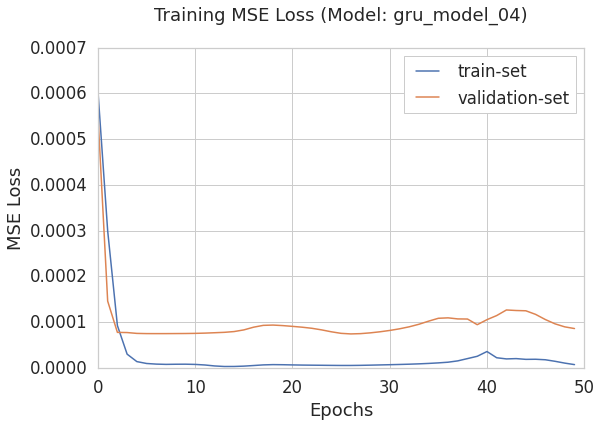

In [ ]:
# Plotting the loss 
plt.figure(figsize=(8.7,6.3))
plt.title('Training MSE Loss (Model: gru_model_04)',fontsize=18,y=1.07)
plt.plot(history.history['loss'], label = 'train-set')
plt.plot(history.history['val_loss'], label ='validation-set')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.tight_layout()
plt.legend()
# Save image with proper modelname
plt.savefig('/content/drive/MyDrive/___DBS_September 2021_anderskiss11/__DISSERTATION_DBS_APPLIED RESEARCH PAPER/__IMAGES & FILES_Dissertation/gru_model_04_loss_{}.png'.format(pkl_str),bbox_inches='tight',dpi=120)
# plt.savefig('gru_model_04_loss_.png'.format(pkl_str), bbox_inches='tight', dpi=120)

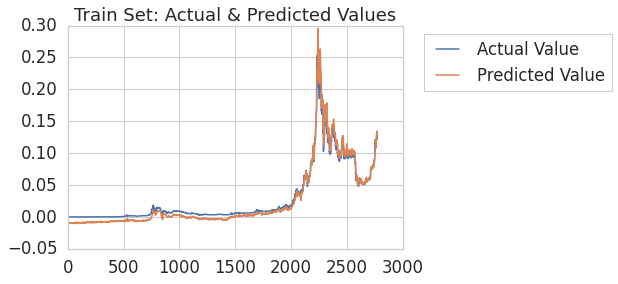

In [ ]:
# This is a one step forecast
y_pred_train = gru_model_04.predict(trainX)
plt.title('Train Set: Actual & Predicted Values')
plt.plot(trainY, label = 'Actual Value')
plt.plot(y_pred_train, label = 'Predicted Value')
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
# plt.legend(loc="upper left")
# plt.legend()

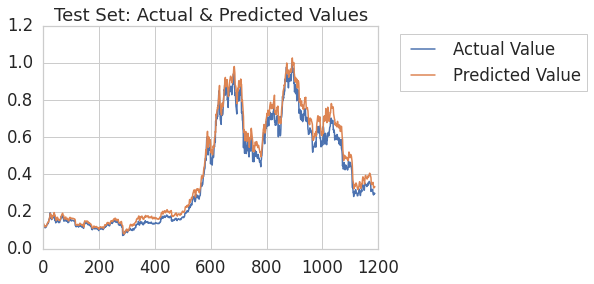

In [ ]:
# This is a one step forecast
y_pred = gru_model_04.predict(testX)
plt.title('Test Set: Actual & Predicted Values')
plt.plot(testY, label = 'Actual Value')
plt.plot(y_pred, label = 'Predicted Value')
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
# plt.legend(loc="upper left")
# plt.legend()

#### **EVALUATION Metric**

In [ ]:
# Measure RMSE error
gru_model_04_rmse_train = np.sqrt(metrics.mean_squared_error(y_pred_train,trainY)).round(5)
gru_model_04_rmse_test = np.sqrt(metrics.mean_squared_error(y_pred,testY)).round(5)
print("Train RMSE:\t{}".format(gru_model_04_rmse_train), "\nTest RMSE:\t{}".format(gru_model_04_rmse_test))
# CALCULATE Mean Absolute Percentage Error (MAPE)
gru_model_04_mape = (np.mean(np.abs((testY - y_pred) / testY)) * 100).round(2)
gru_model_04_acc = (100 - gru_model_04_mape).round(2)

print("\nMAPE:\t\t{}".format(gru_model_04_mape), "\nModel Accuracy:\t{}%\n".format(gru_model_04_acc))

Train RMSE:	0.00708 
Test RMSE:	0.04589

MAPE:		10.56 
Model Accuracy:	89.44%



#### **STORE Data**

In [ ]:
# STORE model information and evaluation metrics in a dictionary
gru_model_04_dict = {
                    'Model_name': 'gru_model_04',
                    'Model_Type': 'GRU',
                    'Model_Dataset': 'BTC only',
                    'Samples (lookback)': samples,
                    'Total params' : 1553,
                    'Train_Split': '70%',
                    'Model_Epochs': 50,
                    'Hidden_Layers': '1L',
                    'Hidden_Neurons': '16 (1L)',
                    'RMSE_train_score':gru_model_04_rmse_train,
                    'RMSE_test_score':gru_model_04_rmse_test,
                    'MAPE':gru_model_04_mape,
                    'model_percent_acc':gru_model_04_acc
                    }
gru_model_04_dict

# DELETE
# plt.savefig('/content/drive/MyDrive/___DBS_September 2041_anderskiss11/__DISSERTATION_DBS_APPLIED RESEARCH PAPER/__IMAGES & FILES_Dissertation/gru_model_04_loss_{}.png'.format(pkl_str),bbox_inches='tight',dpi=120)
# plt.savefig('gru_model_04_loss_.png'.format(pkl_str), bbox_inches='tight', dpi=120)

{'Model_name': 'gru_model_04',
 'Model_Type': 'GRU',
 'Model_Dataset': 'BTC only',
 'Samples (lookback)': 45,
 'Total params': 1553,
 'Train_Split': '70%',
 'Model_Epochs': 50,
 'Hidden_Layers': '1L',
 'Hidden_Neurons': '16 (1L)',
 'RMSE_train_score': 0.01287,
 'RMSE_test_score': 0.06994,
 'MAPE': 18.44,
 'model_percent_acc': 81.56}

In [ ]:
all_eval_df.head(12)

Model_name Model_Type                     Model_Dataset  \
0  lstm_model_01       LSTM                          BTC only   
1  lstm_model_02       LSTM                         BTC + NDX   
2  lstm_model_03       LSTM                      BTC + lumber   
3  lstm_model_04       LSTM            BTC + U.S. Debt-to-GDP   
4  lstm_model_05       LSTM  BTC + NDX + lumber + debt_to_gdp   
5   gru_model_01        GRU                          BTC only   
6   gru_model_02        GRU                         BTC + NDX   
7   gru_model_03        GRU                      BTC + lumber   
8   gru_model_04        GRU            BTC + U.S. Debt-to-GDP   

  Samples (lookback) Total params Train_Split Model_Epochs Hidden_Layers  \
0                 45         1489         70%           50            1L   
1                 45         1553         70%           50            1L   
2                 45         1553         70%           50            1L   
3                 45         1553         70%           50            1L   
4                 45         1681         70%           50            1L   
5                 45         1169         70%           50            1L   
6                 45         1217         70%           50            1L   
7                 45         1217         70%           50            1L   
8                 45         1217         70%           50            1L   

  Hidden_Neurons  RMSE_train_score  RMSE_test_score   MAPE  Accuracy (%)  
0        16 (1L)           0.00583          0.03688   6.99         93.01  
1        16 (1L)           0.00861          0.03565   9.79         90.21  
2        16 (1L)           0.00541          0.13467  14.99         85.01  
3        16 (1L)           0.00546          0.16582  20.67         79.33  
4        16 (1L)           0.00593          0.15152  17.70         82.30  
5        16 (1L)           0.00484          0.03840   4.80         95.20  
6        16 (1L)           0.00497          0.05125   6.50         93.50  
7        16 (1L)           0.00769          0.03349   4.71         95.29  
8        16 (1L)           0.00601          0.02553   4.57         95.43

In [ ]:
# all_eval_df.drop([1], inplace=True)
all_eval_df = add_eval_dict(gru_model_04_dict,all_eval_df)
all_eval_df.head(12)

Model_name Model_Type                     Model_Dataset  \
0  lstm_model_01       LSTM                          BTC only   
1  lstm_model_02       LSTM                         BTC + NDX   
2  lstm_model_03       LSTM                      BTC + lumber   
3  lstm_model_04       LSTM            BTC + U.S. Debt-to-GDP   
4  lstm_model_05       LSTM  BTC + NDX + lumber + debt_to_gdp   
5   gru_model_01        GRU                          BTC only   
6   gru_model_02        GRU                         BTC + NDX   
7   gru_model_03        GRU                          BTC only   
8   gru_model_04        GRU                          BTC only   

  Samples (lookback) Total params Train_Split Model_Epochs Hidden_Layers  \
0                 45         1489         70%           50            1L   
1                 45         1553         70%           50            1L   
2                 45         1553         70%           50            1L   
3                 45         1553         70%           50            1L   
4                 45         1681         70%           50            1L   
5                 45         1169         70%           50            1L   
6                 45         1217         70%           50            1L   
7                 45         1553         70%           50            1L   
8                 45         1553         70%           50            1L   

  Hidden_Neurons  RMSE_train_score  RMSE_test_score   MAPE  Accuracy (%)  
0        16 (1L)           0.00583          0.03688   6.99         93.01  
1        16 (1L)           0.00861          0.03565   9.79         90.21  
2        16 (1L)           0.00541          0.13467  14.99         85.01  
3        16 (1L)           0.00546          0.16582  20.67         79.33  
4        16 (1L)           0.00593          0.15152  17.70         82.30  
5        16 (1L)           0.00484          0.03840   4.80         95.20  
6        16 (1L)           0.00870          0.02519   3.59         96.41  
7        16 (1L)           0.00574          0.06289   7.72         92.28  
8        16 (1L)           0.00495          0.09216  13.53         86.47

In [ ]:
all_eval_df.to_pickle('/content/drive/MyDrive/___DBS_September 2021_anderskiss11/__DISSERTATION_DBS_APPLIED RESEARCH PAPER/__IMAGES & FILES_Dissertation/gru_model_04_eval_metrics_{}.pkl'.format(pkl_str))
print("Dataframe saved to .pkl")

# all_eval_df = pickle.load(open('/content/drive/MyDrive/___DBS_September 2021_anderskiss11/__DISSERTATION_DBS_APPLIED RESEARCH PAPER/__IMAGES & FILES_Dissertation/gru_model_04_eval_metrics_29Aug2022_0818.pkl', 'rb'))
# all_eval_df.head()

Dataframe saved to .pkl


In [ ]:
all_eval_df = pickle.load(open('/content/drive/MyDrive/___DBS_September 2021_anderskiss11/__DISSERTATION_DBS_APPLIED RESEARCH PAPER/__IMAGES & FILES_Dissertation/gru_model_04_eval_metrics_29Aug2022_0818.pkl', 'rb'))
all_eval_df.head()

FileNotFoundError: ignored

#### **MAKE Prediction**

In [ ]:
# MAKE FORECAST PREDICTION
forecast = gru_model_04.predict(X[-samples:])
print(len(forecast))

# MAKE COPIES OF PREDICTED VALUE IN ORDER TO MATCH THE EXPECTED SHAPE WHEN INVERSING
forecast_copies = np.repeat(forecast, btc_macro_df_to_model.shape[1], axis=-1)
print(forecast_copies)

45
[[0.3789449  0.3789449  0.3789449  0.3789449  0.3789449  0.3789449
  0.3789449  0.3789449 ]
 [0.3870412  0.3870412  0.3870412  0.3870412  0.3870412  0.3870412
  0.3870412  0.3870412 ]
 [0.38222128 0.38222128 0.38222128 0.38222128 0.38222128 0.38222128
  0.38222128 0.38222128]
 [0.37880883 0.37880883 0.37880883 0.37880883 0.37880883 0.37880883
  0.37880883 0.37880883]
 [0.37175617 0.37175617 0.37175617 0.37175617 0.37175617 0.37175617
  0.37175617 0.37175617]
 [0.37363228 0.37363228 0.37363228 0.37363228 0.37363228 0.37363228
  0.37363228 0.37363228]
 [0.35726866 0.35726866 0.35726866 0.35726866 0.35726866 0.35726866
  0.35726866 0.35726866]
 [0.3487289  0.3487289  0.3487289  0.3487289  0.3487289  0.3487289
  0.3487289  0.3487289 ]
 [0.3676619  0.3676619  0.3676619  0.3676619  0.3676619  0.3676619
  0.3676619  0.3676619 ]
 [0.3870186  0.3870186  0.3870186  0.3870186  0.3870186  0.3870186
  0.3870186  0.3870186 ]
 [0.39386243 0.39386243 0.39386243 0.39386243 0.39386243 0.39386243
  0.

In [ ]:
# INVERSE SCALER
# forecast_scaled = stnd_scaler.inverse_transform(prediction_copies)[:,0]
forecast_scaled = min_max_scaler.inverse_transform(forecast_copies)[:,0]
print(len(forecast_scaled))
forecast_scaled[-5:]

45


array([22031.844, 22604.867, 22423.723, 22584.11 , 22516.639],
      dtype=float32)

In [ ]:
# INVERSE testY data for comparison of 
copies_test = np.repeat(testY, btc_macro_df_to_model.shape[1], axis=-1)
print(copies_test)

# MINMAX SCALER on testY
# forecast_scaled_testY = stnd_scaler.inverse_transform(copies_test)[:,0]
scaled_testY = min_max_scaler.inverse_transform(copies_test)[:,0]
print(len(scaled_testY))
scaled_testY[-5:]

[[0.12923338 0.12923338 0.12923338 ... 0.12923338 0.12923338 0.12923338]
 [0.12029162 0.12029162 0.12029162 ... 0.12029162 0.12029162 0.12029162]
 [0.11378597 0.11378597 0.11378597 ... 0.11378597 0.11378597 0.11378597]
 ...
 [0.29680315 0.29680315 0.29680315 ... 0.29680315 0.29680315 0.29680315]
 [0.29802046 0.29802046 0.29802046 ... 0.29802046 0.29802046 0.29802046]
 [0.29724743 0.29724743 0.29724743 ... 0.29724743 0.29724743 0.29724743]]
1189


array([20295.8, 19792.6, 20043.9, 20126.1, 20073.9])

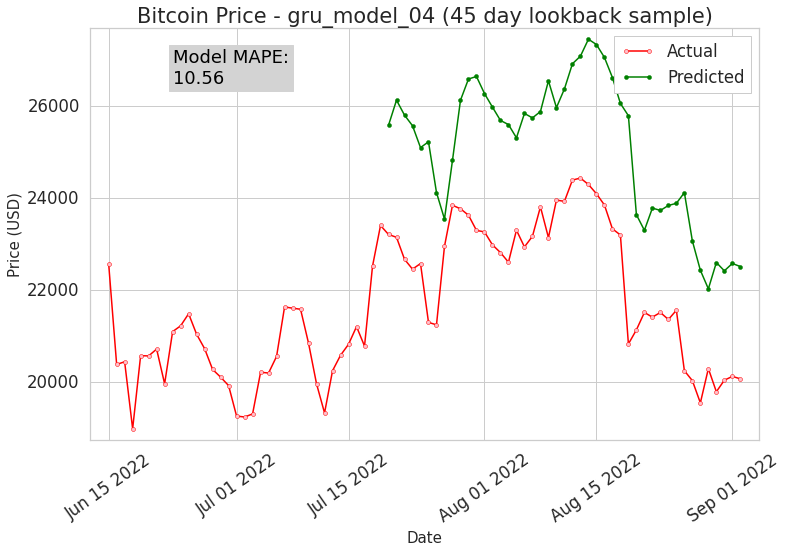

In [ ]:
plt.figure(figsize=(12,7.4))
plt.plot(btc_macro_df_to_model.index[-80:], scaled_testY[-80:], marker='.', markerfacecolor='pink',markersize=8, color='red', label='Actual')
plt.plot(btc_macro_df_to_model.index[-45:], forecast_scaled, marker='.', markerfacecolor='green', markersize=8, color='green', label='Predicted')
plt.title('Bitcoin Price - gru_model_04 (45 day lookback sample)', fontsize=21)
plt.xlabel('Date',fontsize=15)
plt.ylabel('Price (USD)',fontsize=15)
plt.margins(0.03)

plt.text(dt.date(2022,6,23),26500, "Model MAPE:\n{}".format(gru_model_04_mape),color='black',backgroundcolor='lightgrey')

plt.xticks(rotation=35)
# plt.grid(True, color='lightgrey')
plt.grid(True)
plt.legend()
plt.show()

### **gru_model_05 - GRU Baseline + 'NDX' + 'lumber' + 'debt_to_gdp'**

(samples=45 days)

(combine features from all categories category)

#### **COPY dataset**

In [ ]:
combined_macro_df = pd.read_csv(r'/content/drive/MyDrive/___DBS_September 2021_anderskiss11/__DISSERTATION_DBS_APPLIED RESEARCH PAPER/___CODE_Dissertation/_CSV/combined_macro_df.csv',index_col=0)

print('Model loaded from .CSV')
print(type(combined_macro_df.index))
combined_macro_df = combined_macro_df.set_index(pd.to_datetime(combined_macro_df.index))
print(type(combined_macro_df.index))

combined_macro_df.head(3)

Model loaded from .CSV
<class 'pandas.core.indexes.base.Index'>
<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


BTC  Open  High  Low  BTC_vol    BTC_RSI    BTC_log      NDX  \
2011-09-14  5.6   5.8   5.8  5.3  43768.0  31.804028  -3.509132  2252.75   
2011-09-15  4.8   5.6   5.6  4.4  86221.0  26.586215 -15.415068  2286.56   
2011-09-16  4.8   4.8   5.0  4.6  31651.0  26.586215   0.000000  2306.09   

            debt_to_gdp  lumber  
2011-09-14     94.52097   237.2  
2011-09-15     94.52097   244.2  
2011-09-16     94.52097   244.6

In [ ]:
df_sanity_check(combined_macro_df)

SHAPE of df is:		 (4003, 10)
NaN in df present?	 False
NaN count in df:	 0
COLUMNS in df:
	 BTC
	 Open
	 High
	 Low
	 BTC_vol
	 BTC_RSI
	 BTC_log
	 NDX
	 debt_to_gdp
	 lumber


In [ ]:
df_dates = pd.to_datetime(combined_macro_df.index)
df_dates[:3]

DatetimeIndex(['2011-09-14', '2011-09-15', '2011-09-16'], dtype='datetime64[ns]', freq=None)

In [ ]:
# CONVERT dates from DatetimeIndex object to Series
date_range = df_dates.to_series()
print(type(date_range))
date_range[-3:]

<class 'pandas.core.series.Series'>


2022-08-27   2022-08-27
2022-08-28   2022-08-28
2022-08-29   2022-08-29
dtype: datetime64[ns]

In [ ]:
date_range.shape

(4003,)

#### **SCALE data**

In [ ]:
# SCALE data
# for multivariate example
cols = combined_macro_df.columns
x = combined_macro_df.values #returns a numpy array

# MINMAX Scaler
min_max_scaler = MinMaxScaler()
scaled_data = min_max_scaler.fit_transform(combined_macro_df)
scaled_data
# Standard Scaler
# stnd_scaler = StandardScaler()
# scaled_data = stnd_scaler.fit_transform(combined_macro_df)
# scaled_data

array([[5.33128770e-05, 5.62740368e-05, 5.07332403e-05, ...,
        1.15755472e-02, 0.00000000e+00, 1.76961150e-02],
       [4.14655710e-05, 5.33122454e-05, 4.78341980e-05, ...,
        1.39091543e-02, 0.00000000e+00, 2.24421995e-02],
       [4.14655710e-05, 4.14650797e-05, 3.91370711e-05, ...,
        1.52571385e-02, 0.00000000e+00, 2.27134043e-02],
       ...,
       [2.96655061e-01, 2.99850281e-01, 2.94851446e-01, ...,
        7.26112104e-01, 6.87700386e-01, 2.11878771e-01],
       [2.89491884e-01, 2.96655989e-01, 2.92056769e-01, ...,
        7.26112104e-01, 6.87700386e-01, 2.12488982e-01],
       [3.00533573e-01, 2.89504744e-01, 2.95589252e-01, ...,
        7.21232305e-01, 6.87700386e-01, 2.02522205e-01]])

In [ ]:
gru_model_05_scaled = pd.DataFrame(scaled_data)
gru_model_05_scaled.columns = cols
gru_model_05_scaled.index = date_range
gru_model_05_scaled.head(3)

BTC      Open      High       Low   BTC_vol   BTC_RSI  \
2011-09-14  0.000053  0.000056  0.000051  0.000050  0.000010  0.252915   
2011-09-15  0.000041  0.000053  0.000048  0.000036  0.000019  0.192182   
2011-09-16  0.000041  0.000041  0.000039  0.000039  0.000007  0.192182   

             BTC_log       NDX  debt_to_gdp    lumber  
2011-09-14  0.350295  0.011576          0.0  0.017696  
2011-09-15  0.299042  0.013909          0.0  0.022442  
2011-09-16  0.365401  0.015257          0.0  0.022713

In [ ]:
# VERIFY data shape
gru_model_05_scaled.shape

(4003, 10)

In [ ]:
gru_model_05_scaled.iloc[:3, :1]

BTC
2011-09-14  0.000053
2011-09-15  0.000041
2011-09-16  0.000041

#### **RESHAPE data**
**shapes includes: sample, time steps, features**

In [ ]:
# models need data in the form [sample, timesteps, features]

samples = 45 # samples
steps = 1 # timesteps
X = []
Y = []
for i in range(gru_model_05_scaled.shape[0] - samples):
    # ENSURE INDEX RANGE for X matches input range 
    # use Open,High,Low to predict Close
    X.append(gru_model_05_scaled.iloc[i:i+samples, 1:].values) # Independent Samples
    Y.append(gru_model_05_scaled.iloc[i+samples, :1].values) # Dependent Samples
print('Training Data length:',len(X[0:1][0]),'\n', X[0:1])
print('\nTesting Data length:', len(Y[0:1]),'\n', Y[0:1])

Training Data length: 45 
 [array([[5.62740368e-05, 5.07332403e-05, 4.97490687e-05, 9.73527780e-06,
        2.52914840e-01, 3.50294611e-01, 1.15755472e-02, 0.00000000e+00,
        1.76961150e-02],
       [5.33122454e-05, 4.78341980e-05, 3.61811409e-05, 1.92353640e-05,
        1.92181695e-01, 2.99042383e-01, 1.39091543e-02, 0.00000000e+00,
        2.24421995e-02],
       [4.14650797e-05, 3.91370711e-05, 3.91962360e-05, 7.02374872e-06,
        1.92181695e-01, 3.65400591e-01, 1.52571385e-02, 0.00000000e+00,
        2.27134043e-02],
       [4.14650797e-05, 3.76875499e-05, 4.07037835e-05, 4.48430562e-06,
        1.92181695e-01, 3.65400591e-01, 1.52571385e-02, 0.00000000e+00,
        2.27134043e-02],
       [4.14650797e-05, 4.78341980e-05, 4.07037835e-05, 9.92683255e-06,
        2.71593434e-01, 3.99857076e-01, 1.52571385e-02, 0.00000000e+00,
        2.27134043e-02],
       [4.73886626e-05, 4.78341980e-05, 4.37188786e-05, 1.10933920e-05,
        3.25710822e-01, 3.89545775e-01, 1.54414251e-02,

In [ ]:
type(X)

list

In [ ]:
# Convert data from list to array for modeling
print("Original datatype for X is:\t", type(X))
print("- - - - - - - - - - - - - - - - - - - - -")
X = np.array(X)
Y = np.array(Y)
print("Converted datatype for X is:\t", type(X))
print('\nX Shape: ', X.shape, '\nY Shape: ', Y.shape)

Original datatype for X is:	 <class 'list'>
- - - - - - - - - - - - - - - - - - - - -
Converted datatype for X is:	 <class 'numpy.ndarray'>

X Shape:  (3958, 45, 9) 
Y Shape:  (3958, 1)


In [ ]:
# ESTABLISH training and testing sets
split_data = round(0.7 * X.shape[0])
trainX, trainY = X[:split_data], Y[:split_data]
testX, testY =  X[split_data:], Y[split_data:]
print('Train Set (input and output arrays):\n','TRAIN INPUTS: ',trainX.shape,'\t\tTRAIN OUTPUT: ',trainY.shape,'\n\nTest Set (input and output arrays):\n','TEST INPUTS: ',testX.shape,'\t\tTEST OUTPUT: ', testY.shape)

Train Set (input and output arrays):
 TRAIN INPUTS:  (2771, 45, 9) 		TRAIN OUTPUT:  (2771, 1) 

Test Set (input and output arrays):
 TEST INPUTS:  (1187, 45, 9) 		TEST OUTPUT:  (1187, 1)


#### **BUILD / TRAIN / SAVE Model**

In [ ]:
# VERIFY that the same train/test sets are used
# Reshaped data
print('X Shape: ', X.shape, '\nY Shape: ', Y.shape)

X Shape:  (3958, 45, 9) 
Y Shape:  (3958, 1)


In [ ]:
# VERIFY training and testing sets
print("\n# # # SPLIT DATASETS: # # #\n")
print('Train Set Input:',trainX.shape,'\t\tTrain Set Output:', trainY.shape)
print("\n- - - - - - - - - - - - -\n")      
print('\nTest Set Input:',testX.shape,'\t\tTest Set Output:', testY.shape)


# # # SPLIT DATASETS: # # #

Train Set Input: (2771, 45, 9) 		Train Set Output: (2771, 1)

- - - - - - - - - - - - -


Test Set Input: (1187, 45, 9) 		Test Set Output: (1187, 1)


In [ ]:
# BUILD the GRU
gru_model_05 = keras.Sequential()
gru_model_05.add(layers.GRU(16,
                            input_shape=(trainX.shape[1], trainX.shape[2])))

# Add a Dense layer with 1 units
gru_model_05.add(layers.Dense(1))
gru_model_05.compile(optimizer='adam',loss='mean_squared_error',metrics='MeanSquaredError')
gru_model_05.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_6 (GRU)                 (None, 16)                1296      
                                                                 
 dense_8 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1,313
Trainable params: 1,313
Non-trainable params: 0
_________________________________________________________________


In [ ]:
print(pkl_str)

29Aug2022_1929


In [ ]:
# fit the model
history = gru_model_05.fit(trainX,
                        trainY,
                        shuffle = False, 
                        epochs=50,
                        batch_size=15,
                        validation_split=0.2,
                        verbose=1)

pickle.dump(gru_model_05, open("/content/drive/MyDrive/___DBS_September 2021_anderskiss11/__DISSERTATION_DBS_APPLIED RESEARCH PAPER/___CODE_Dissertation/_MODELS/gru_model_05_{}.pkl".format(pkl_str), "wb"))
print("\nModel:\tgru_model_05 successfully saved to .pkl file")

Epoch 1/50
148/148 [==============================] - 12s 55ms/step - loss: 1.2440e-04 - mean_squared_error: 1.2440e-04 - val_loss: 5.0809e-04 - val_mean_squared_error: 5.0809e-04
Epoch 2/50
148/148 [==============================] - 6s 41ms/step - loss: 2.5478e-04 - mean_squared_error: 2.5478e-04 - val_loss: 3.0457e-04 - val_mean_squared_error: 3.0457e-04
Epoch 3/50
148/148 [==============================] - 7s 46ms/step - loss: 1.0687e-04 - mean_squared_error: 1.0687e-04 - val_loss: 2.0950e-04 - val_mean_squared_error: 2.0950e-04
Epoch 4/50
148/148 [==============================] - 6s 40ms/step - loss: 1.1479e-04 - mean_squared_error: 1.1479e-04 - val_loss: 1.8278e-04 - val_mean_squared_error: 1.8278e-04
Epoch 5/50
148/148 [==============================] - 6s 39ms/step - loss: 1.0603e-04 - mean_squared_error: 1.0603e-04 - val_loss: 1.6936e-04 - val_mean_squared_error: 1.6936e-04
Epoch 6/50
148/148 [==============================] - 7s 46ms/step - loss: 8.7226e-05 - mean_squared_err


Model:	gru_model_05 successfully saved to .pkl file


In [ ]:
# gru_model_05 = pickle.load(open('/content/drive/MyDrive/___DBS_September 2021_anderskiss11/__DISSERTATION_DBS_APPLIED RESEARCH PAPER/___CODE_Dissertation/_MODELS/gru_model_05____.pkl', 'rb'))
# print("\nModel:\tgru_model_05 successfully loaded from .pkl file")

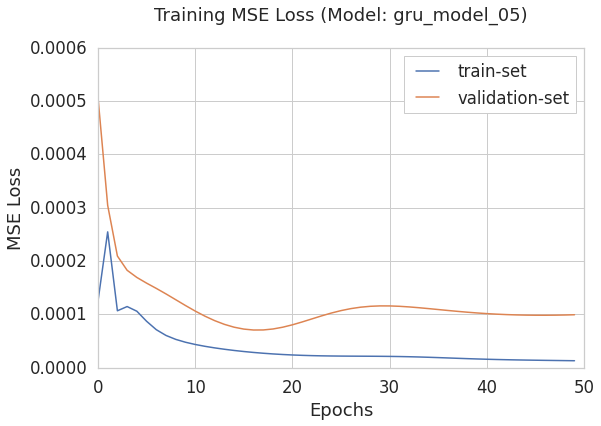

In [ ]:
# Plotting the loss 
plt.figure(figsize=(8.7,6.3))
plt.title('Training MSE Loss (Model: gru_model_05)',fontsize=18,y=1.07)
plt.plot(history.history['loss'], label = 'train-set')
plt.plot(history.history['val_loss'], label ='validation-set')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.tight_layout()
plt.legend()
# Save image with proper modelname
plt.savefig('/content/drive/MyDrive/___DBS_September 2021_anderskiss11/__DISSERTATION_DBS_APPLIED RESEARCH PAPER/__IMAGES & FILES_Dissertation/gru_model_05_loss_{}.png'.format(pkl_str),bbox_inches='tight',dpi=120)
# plt.savefig('gru_model_05_loss_.png'.format(pkl_str), bbox_inches='tight', dpi=120)

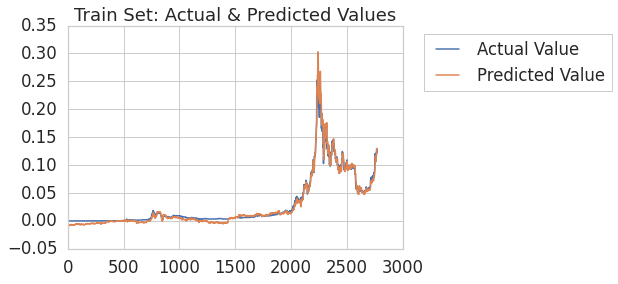

In [ ]:
# This is a one step forecast
y_pred_train = gru_model_05.predict(trainX)
plt.title('Train Set: Actual & Predicted Values')
plt.plot(trainY, label = 'Actual Value')
plt.plot(y_pred_train, label = 'Predicted Value')
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
# plt.legend(loc="upper left")
# plt.legend()

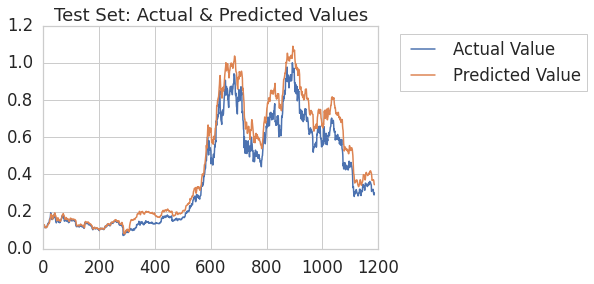

In [ ]:
# This is a one step forecast
y_pred = gru_model_05.predict(testX)
plt.title('Test Set: Actual & Predicted Values')
plt.plot(testY, label = 'Actual Value')
plt.plot(y_pred, label = 'Predicted Value')
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
# plt.legend(loc="upper left")
# plt.legend()

#### **EVALUATION Metric**

In [ ]:
# Measure RMSE error
gru_model_05_rmse_train = np.sqrt(metrics.mean_squared_error(y_pred_train,trainY)).round(5)
gru_model_05_rmse_test = np.sqrt(metrics.mean_squared_error(y_pred,testY)).round(5)
print("Train RMSE:\t{}".format(gru_model_05_rmse_train), "\nTest RMSE:\t{}".format(gru_model_05_rmse_test))
# CALCULATE Mean Absolute Percentage Error (MAPE)
gru_model_05_mape = (np.mean(np.abs((testY - y_pred) / testY)) * 100).round(2)
gru_model_05_acc = (100 - gru_model_05_mape).round(2)

print("\nMAPE:\t\t{}".format(gru_model_05_mape), "\nModel Accuracy:\t{}%\n".format(gru_model_05_acc))

Train RMSE:	0.00571 
Test RMSE:	0.08091

MAPE:		16.18 
Model Accuracy:	83.82%



#### **STORE Data**

In [ ]:
# STORE model information and evaluation metrics in a dictionary
gru_model_05_dict = {
                    'Model_name': 'gru_model_05',
                    'Model_Type': 'GRU',
                    'Model_Dataset': 'BTC + NDX + lumber + debt_to_gdp',
                    'Samples (lookback)': samples,
                    'Total params' : 1313,
                    'Train_Split': '70%',
                    'Model_Epochs': 50,
                    'Hidden_Layers': '1L',
                    'Hidden_Neurons': '16 (1L)',
                    'RMSE_train_score':gru_model_05_rmse_train,
                    'RMSE_test_score':gru_model_05_rmse_test,
                    'MAPE':gru_model_05_mape,
                    'model_percent_acc':gru_model_05_acc
                    }
gru_model_05_dict

# DELETE
# plt.savefig('/content/drive/MyDrive/___DBS_September 2051_anderskiss11/__DISSERTATION_DBS_APPLIED RESEARCH PAPER/__IMAGES & FILES_Dissertation/gru_model_05_loss_{}.png'.format(pkl_str),bbox_inches='tight',dpi=120)
# plt.savefig('gru_model_05_loss_.png'.format(pkl_str), bbox_inches='tight', dpi=120)

{'Model_name': 'gru_model_05',
 'Model_Type': 'GRU',
 'Model_Dataset': 'BTC + NDX + lumber + debt_to_gdp',
 'Samples (lookback)': 45,
 'Total params': 1313,
 'Train_Split': '70%',
 'Model_Epochs': 50,
 'Hidden_Layers': '1L',
 'Hidden_Neurons': '16 (1L)',
 'RMSE_train_score': 0.00571,
 'RMSE_test_score': 0.08091,
 'MAPE': 16.18,
 'model_percent_acc': 83.82}

In [ ]:
all_eval_df.head(12)

Model_name Model_Type                     Model_Dataset  \
0  lstm_model_01       LSTM                          BTC only   
1  lstm_model_02       LSTM                         BTC + NDX   
2  lstm_model_03       LSTM                      BTC + lumber   
3  lstm_model_04       LSTM            BTC + U.S. Debt-to-GDP   
4  lstm_model_05       LSTM  BTC + NDX + lumber + debt_to_gdp   
5   gru_model_01        GRU                          BTC only   
6   gru_model_02        GRU                         BTC + NDX   
7   gru_model_03        GRU                      BTC + lumber   
8   gru_model_04        GRU            BTC + U.S. Debt-to-GDP   

  Samples (lookback) Total params Train_Split Model_Epochs Hidden_Layers  \
0                 45         1489         70%           50            1L   
1                 45         1553         70%           50            1L   
2                 45         1553         70%           50            1L   
3                 45         1553         70%           50            1L   
4                 45         1681         70%           50            1L   
5                 45         1169         70%           50            1L   
6                 45         1217         70%           50            1L   
7                 45         1217         70%           50            1L   
8                 45         1217         70%           50            1L   

  Hidden_Neurons  RMSE_train_score  RMSE_test_score   MAPE  Accuracy (%)  
0        16 (1L)           0.00583          0.03688   6.99         93.01  
1        16 (1L)           0.00861          0.03565   9.79         90.21  
2        16 (1L)           0.00541          0.13467  14.99         85.01  
3        16 (1L)           0.00546          0.16582  20.67         79.33  
4        16 (1L)           0.00593          0.15152  17.70         82.30  
5        16 (1L)           0.00484          0.03840   4.80         95.20  
6        16 (1L)           0.00497          0.05125   6.50         93.50  
7        16 (1L)           0.00769          0.03349   4.71         95.29  
8        16 (1L)           0.00601          0.02553   4.57         95.43

In [ ]:
# all_eval_df.drop([1], inplace=True)
all_eval_df = add_eval_dict(gru_model_05_dict,all_eval_df)
all_eval_df.head(12)

Model_name Model_Type                     Model_Dataset  \
0  lstm_model_01       LSTM                          BTC only   
1  lstm_model_02       LSTM                         BTC + NDX   
2  lstm_model_03       LSTM                      BTC + lumber   
3  lstm_model_04       LSTM            BTC + U.S. Debt-to-GDP   
4  lstm_model_05       LSTM  BTC + NDX + lumber + debt_to_gdp   
5   gru_model_01        GRU                          BTC only   
6   gru_model_02        GRU                         BTC + NDX   
7   gru_model_03        GRU                      BTC + lumber   
8   gru_model_04        GRU            BTC + U.S. Debt-to-GDP   
9   gru_model_05        GRU  BTC + NDX + lumber + debt_to_gdp   

  Samples (lookback) Total params Train_Split Model_Epochs Hidden_Layers  \
0                 45         1489         70%           50            1L   
1                 45         1553         70%           50            1L   
2                 45         1553         70%           50            1L   
3                 45         1553         70%           50            1L   
4                 45         1681         70%           50            1L   
5                 45         1169         70%           50            1L   
6                 45         1217         70%           50            1L   
7                 45         1217         70%           50            1L   
8                 45         1217         70%           50            1L   
9                 45         1313         70%           50            1L   

  Hidden_Neurons  RMSE_train_score  RMSE_test_score   MAPE  Accuracy (%)  
0        16 (1L)           0.00583          0.03688   6.99         93.01  
1        16 (1L)           0.00861          0.03565   9.79         90.21  
2        16 (1L)           0.00541          0.13467  14.99         85.01  
3        16 (1L)           0.00546          0.16582  20.67         79.33  
4        16 (1L)           0.00593          0.15152  17.70         82.30  
5        16 (1L)           0.00484          0.03840   4.80         95.20  
6        16 (1L)           0.00497          0.05125   6.50         93.50  
7        16 (1L)           0.00769          0.03349   4.71         95.29  
8        16 (1L)           0.00601          0.02553   4.57         95.43  
9        16 (1L)           0.00571          0.08091  16.18         83.82

In [ ]:
all_eval_df.to_pickle('/content/drive/MyDrive/___DBS_September 2021_anderskiss11/__DISSERTATION_DBS_APPLIED RESEARCH PAPER/__IMAGES & FILES_Dissertation/gru_model_05_eval_metrics_{}.pkl'.format(pkl_str))
print("Dataframe saved to .pkl")

# all_eval_df = pickle.load(open('/content/drive/MyDrive/___DBS_September 2021_anderskiss11/__DISSERTATION_DBS_APPLIED RESEARCH PAPER/__IMAGES & FILES_Dissertation/gru_model_05_eval_metrics_29Aug2022_0818.pkl', 'rb'))
# all_eval_df.head()

Dataframe saved to .pkl


In [ ]:
# all_eval_df = pickle.load(open('/content/drive/MyDrive/___DBS_September 2021_anderskiss11/__DISSERTATION_DBS_APPLIED RESEARCH PAPER/__IMAGES & FILES_Dissertation/gru_model_05_eval_metrics_29Aug2022_0818.pkl', 'rb'))
# all_eval_df.head()

#### **MAKE Prediction**

In [ ]:
# MAKE FORECAST PREDICTION
forecast = gru_model_05.predict(X[-samples:])
print(len(forecast))

# MAKE COPIES OF PREDICTED VALUE IN ORDER TO MATCH THE EXPECTED SHAPE WHEN INVERSING
forecast_copies = np.repeat(forecast, combined_macro_df.shape[1], axis=-1)
print(forecast_copies)

45
[[0.3411925  0.3411925  0.3411925  0.3411925  0.3411925  0.3411925
  0.3411925  0.3411925 ]
 [0.344609   0.344609   0.344609   0.344609   0.344609   0.344609
  0.344609   0.344609  ]
 [0.34652188 0.34652188 0.34652188 0.34652188 0.34652188 0.34652188
  0.34652188 0.34652188]
 [0.35273153 0.35273153 0.35273153 0.35273153 0.35273153 0.35273153
  0.35273153 0.35273153]
 [0.36314133 0.36314133 0.36314133 0.36314133 0.36314133 0.36314133
  0.36314133 0.36314133]
 [0.3720219  0.3720219  0.3720219  0.3720219  0.3720219  0.3720219
  0.3720219  0.3720219 ]
 [0.37240037 0.37240037 0.37240037 0.37240037 0.37240037 0.37240037
  0.37240037 0.37240037]
 [0.37374642 0.37374642 0.37374642 0.37374642 0.37374642 0.37374642
  0.37374642 0.37374642]
 [0.37061018 0.37061018 0.37061018 0.37061018 0.37061018 0.37061018
  0.37061018 0.37061018]
 [0.37009212 0.37009212 0.37009212 0.37009212 0.37009212 0.37009212
  0.37009212 0.37009212]
 [0.36470363 0.36470363 0.36470363 0.36470363 0.36470363 0.36470363
  0

In [ ]:
# INVERSE SCALER
# forecast_scaled = stnd_scaler.inverse_transform(prediction_copies)[:,0]
forecast_scaled = min_max_scaler.inverse_transform(forecast_copies)[:,0]
print(len(forecast_scaled))
forecast_scaled[-5:]

45


array([23827.193, 23820.951, 23608.246, 23091.473, 22719.287],
      dtype=float32)

In [ ]:
# INVERSE testY data for comparison of 
copies_test = np.repeat(testY, combined_macro_df.shape[1], axis=-1)
print(copies_test)

# MINMAX SCALER on testY
# forecast_scaled_testY = stnd_scaler.inverse_transform(copies_test)[:,0]
scaled_testY = min_max_scaler.inverse_transform(copies_test)[:,0]
print(len(scaled_testY))
scaled_testY[-5:]

[[0.12671138 0.12671138 0.12671138 ... 0.12671138 0.12671138 0.12671138]
 [0.12652479 0.12652479 0.12652479 ... 0.12652479 0.12652479 0.12652479]
 [0.12923338 0.12923338 0.12923338 ... 0.12923338 0.12923338 0.12923338]
 ...
 [0.29665506 0.29665506 0.29665506 ... 0.29665506 0.29665506 0.29665506]
 [0.28949188 0.28949188 0.28949188 ... 0.28949188 0.28949188 0.28949188]
 [0.30124441 0.30124441 0.30124441 ... 0.30124441 0.30124441 0.30124441]]
1187


array([21565.4, 20249.9, 20033.9, 19550.2, 20343.8])

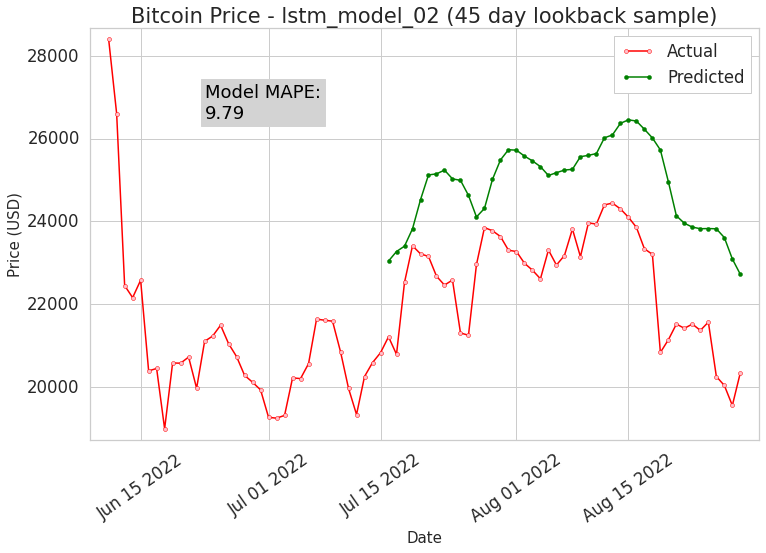

In [ ]:
plt.figure(figsize=(12,7.4))
plt.plot(combined_macro_df.index[-80:], scaled_testY[-80:], marker='.', markerfacecolor='pink',markersize=8, color='red', label='Actual')
plt.plot(combined_macro_df.index[-45:], forecast_scaled, marker='.', markerfacecolor='green', markersize=8, color='green', label='Predicted')
plt.title('Bitcoin Price - gru_model_05 - BTC and 3x macro features (45 day lookback sample)', fontsize=21)
plt.xlabel('Date',fontsize=15)
plt.ylabel('Price (USD)',fontsize=15)
plt.margins(0.03)

plt.text(dt.date(2022,6,23),26500, "Model MAPE:\n{}".format(gru_model_05_mape),color='black',backgroundcolor='lightgrey')

plt.xticks(rotation=35)
# plt.grid(True, color='lightgrey')
plt.grid(True)
plt.legend()
plt.show()

# **EVALUATION**

Based on the transposed dataframe ('all_eval_df_transposed) below, the best performing model in terms of MAPE and Accuracy GRU Model 04. This GRU model was trained on the additional feature, 'U.S. Debt-to-GDP'. This model outperformed the GRU Baseline, that was only trained on the 'Bitcoin price and technical indicator' data.

In fact, a **total of three GRU's outperformed their baseline**. In addition to GRU Model 04, GRU Model 02 and GRU Model 03 also performed better than the baseline GRU.

Interestingly, none of the LSTM models improved beyond the baseline with additional input features. 

It can be concluded, that the GRU's simplified architecture was able to detect hidden patterns in single additional features. All but one GRU model outperformed the baseline LSTM, further cementing this point. Conversely, the LSTM models was unable to effectively learn from additional features with none outperforming the baseline LSTM. 

In [ ]:
# REVIEW ALL METRICS TABLE

In [ ]:
all_eval_df = pickle.load(open('/content/drive/MyDrive/___DBS_September 2021_anderskiss11/__DISSERTATION_DBS_APPLIED RESEARCH PAPER/__IMAGES & FILES_Dissertation/gru_model_05_eval_metrics_29Aug2022_1929.pkl', 'rb'))
all_eval_df.head(15)

Model_name Model_Type                     Model_Dataset  \
0  lstm_model_01       LSTM                          BTC only   
1  lstm_model_02       LSTM                         BTC + NDX   
2  lstm_model_03       LSTM                      BTC + lumber   
3  lstm_model_04       LSTM            BTC + U.S. Debt-to-GDP   
4  lstm_model_05       LSTM  BTC + NDX + lumber + debt_to_gdp   
5   gru_model_01        GRU                          BTC only   
6   gru_model_02        GRU                         BTC + NDX   
7   gru_model_03        GRU                      BTC + lumber   
8   gru_model_04        GRU            BTC + U.S. Debt-to-GDP   
9   gru_model_05        GRU  BTC + NDX + lumber + debt_to_gdp   

  Samples (lookback) Total params Train_Split Model_Epochs Hidden_Layers  \
0                 45         1489         70%           50            1L   
1                 45         1553         70%           50            1L   
2                 45         1553         70%           50            1L   
3                 45         1553         70%           50            1L   
4                 45         1681         70%           50            1L   
5                 45         1169         70%           50            1L   
6                 45         1217         70%           50            1L   
7                 45         1217         70%           50            1L   
8                 45         1217         70%           50            1L   
9                 45         1313         70%           50            1L   

  Hidden_Neurons  RMSE_train_score  RMSE_test_score   MAPE  Accuracy (%)  
0        16 (1L)           0.00583          0.03688   6.99         93.01  
1        16 (1L)           0.00861          0.03565   9.79         90.21  
2        16 (1L)           0.00541          0.13467  14.99         85.01  
3        16 (1L)           0.00546          0.16582  20.67         79.33  
4        16 (1L)           0.00593          0.15152  17.70         82.30  
5        16 (1L)           0.00484          0.03840   4.80         95.20  
6        16 (1L)           0.00497          0.05125   6.50         93.50  
7        16 (1L)           0.00769          0.03349   4.71         95.29  
8        16 (1L)           0.00601          0.02553   4.57         95.43  
9        16 (1L)           0.00571          0.08091  16.18         83.82

In [ ]:
# display(all_eval_df)
# all_eval_df.style
print(tabulate(all_eval_df, headers = 'keys', tablefmt = 'orgtbl'))

|    | Model_name    | Model_Type   | Model_Dataset                    |   Samples (lookback) |   Total params | Train_Split   |   Model_Epochs | Hidden_Layers   | Hidden_Neurons   |   RMSE_train_score |   RMSE_test_score |   MAPE |   Accuracy (%) |
|----+---------------+--------------+----------------------------------+----------------------+----------------+---------------+----------------+-----------------+------------------+--------------------+-------------------+--------+----------------|
|  0 | lstm_model_01 | LSTM         | BTC only                         |                   45 |           1489 | 70%           |             50 | 1L              | 16 (1L)          |            0.00583 |           0.03688 |   6.99 |          93.01 |
|  1 | lstm_model_02 | LSTM         | BTC + NDX                        |                   45 |           1553 | 70%           |             50 | 1L              | 16 (1L)          |            0.00861 |           0.03565 |   9.79 |          90.21 |


In [ ]:
all_eval_df_transposed = all_eval_df.T

In [ ]:
all_eval_df_transposed

0              1              2  \
Model_name          lstm_model_01  lstm_model_02  lstm_model_03   
Model_Type                   LSTM           LSTM           LSTM   
Model_Dataset            BTC only      BTC + NDX   BTC + lumber   
Samples (lookback)             45             45             45   
Total params                 1489           1553           1553   
Train_Split                   70%            70%            70%   
Model_Epochs                   50             50             50   
Hidden_Layers                  1L             1L             1L   
Hidden_Neurons            16 (1L)        16 (1L)        16 (1L)   
RMSE_train_score          0.00583        0.00861        0.00541   
RMSE_test_score           0.03688        0.03565        0.13467   
MAPE                         6.99           9.79          14.99   
Accuracy (%)                93.01          90.21          85.01   

                                         3                                 4  \
Model_name                   lstm_model_04                     lstm_model_05   
Model_Type                            LSTM                              LSTM   
Model_Dataset       BTC + U.S. Debt-to-GDP  BTC + NDX + lumber + debt_to_gdp   
Samples (lookback)                      45                                45   
Total params                          1553                              1681   
Train_Split                            70%                               70%   
Model_Epochs                            50                                50   
Hidden_Layers                           1L                                1L   
Hidden_Neurons                     16 (1L)                           16 (1L)   
RMSE_train_score                   0.00546                           0.00593   
RMSE_test_score                    0.16582                           0.15152   
MAPE                                 20.67                              17.7   
Accuracy (%)                         79.33                              82.3   

                               5             6             7  \
Model_name          gru_model_01  gru_model_02  gru_model_03   
Model_Type                   GRU           GRU           GRU   
Model_Dataset           BTC only     BTC + NDX  BTC + lumber   
Samples (lookback)            45            45            45   
Total params                1169          1217          1217   
Train_Split                  70%           70%           70%   
Model_Epochs                  50            50            50   
Hidden_Layers                 1L            1L            1L   
Hidden_Neurons           16 (1L)       16 (1L)       16 (1L)   
RMSE_train_score         0.00484       0.00497       0.00769   
RMSE_test_score           0.0384       0.05125       0.03349   
MAPE                         4.8           6.5          4.71   
Accuracy (%)                95.2          93.5         95.29   

                                         8                                 9  
Model_name                    gru_model_04                      gru_model_05  
Model_Type                             GRU                               GRU  
Model_Dataset       BTC + U.S. Debt-to-GDP  BTC + NDX + lumber + debt_to_gdp  
Samples (lookback)                      45                                45  
Total params                          1217                              1313  
Train_Split                            70%                               70%  
Model_Epochs                            50                                50  
Hidden_Layers                           1L                                1L  
Hidden_Neurons                     16 (1L)                           16 (1L)  
RMSE_train_score                   0.00601                           0.00571  
RMSE_test_score                    0.02553                           0.08091  
MAPE                                  4.57                             16.18  
Accuracy (%)                         95.43      

In [ ]:
# all_eval_df_transposed.to_csv(r'/content/drive/MyDrive/___DBS_September 2021_anderskiss11/__DISSERTATION_DBS_APPLIED RESEARCH PAPER/___CODE_Dissertation/_CSV/all_eval_df_transposed_{}.csv'.format(pkl_str),index=True,header=False)
print('Evaluation Metrics table saved to .CSV!')

Evaluation Metrics table saved to .CSV!


# **DEPLOYMENT**

Given that most accurate model with the least error was **GRU Model 4 (Bitcoin data combined with the macroeconomic metric, U.S. Debt as a Percentage of GDP)**, this model could be deployed to predict future Bitcoin price. 

For example, an application could utilize the models discussed here to help with investment strategies for investing in Bitcoin. One example of a deployed application could be an internal tool at a financial firm that has clients interested in investing in Bitcoin. 

With the capability to forecast the future (1-day ahead) Bitcoin price, this tool could help investment managers make more informed decisions for their clients. 

Ideally, any deployed model and subsequent application would combine the models discussed here with others, such as statistical and machine learning models. 

By combining multiple techniques, a more robust investment allocation process would result by limiting the signal derived from any single model.
